In [1]:
import os
import numpy as np
import glob
from skimage.io import imread,imsave
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import random
import tqdm
import keras
from tqdm.notebook import tqdm_notebook
import yaml
from dvclive.keras import DVCLiveCallback
from loss import tversky_loss, focal_tversky,sdice_loss, dice_loss,log_cosh_dice_loss

In [2]:
tf.config.list_physical_devices('GPU')
params = yaml.safe_load(open("params.yaml"))['model_params']

In [3]:
# Specify the size of patches and number of classes expected by the model.
image_size = params['Image_patch_size']
mask_size = params['Mask_patch_size']
num_class = params['Number_of_classes']
lr = params['Learning_rate']
batchsize = params['Batch_size']
optimizer = params['Optimizer']
epochs = params['Epochs']

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
PATH = 'tfrecords/'
BATCH_SIZE = batchsize

In [5]:
FILENAMES = tf.io.gfile.glob(PATH +"*large_images.tfrecords")
split_ind = int(0.7 * len(FILENAMES))
TRAINING_FILENAMES, VALID_FILENAMES = FILENAMES[:split_ind], FILENAMES[split_ind:]
print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))

Train TFRecord Files: 10
Validation TFRecord Files: 5


In [6]:
def read_tfrecord(example):
    tfrecord_format = (
        {
         "image":tf.io.FixedLenFeature(shape=[*image_size], dtype=tf.float32),
         "mask":tf.io.FixedLenFeature(shape=[*mask_size], dtype=tf.float32)
        }
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = example["image"]
    mask = example["mask"]
    mask = tf.one_hot(tf.cast(mask, tf.uint8), 2)
    return image,mask

In [7]:
from functools import partial

In [8]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

In [9]:
seed=42

In [10]:
def augmentation(image, mask):
    # both use the same seed, so they'll make the same random changes
    flip_image = tf.image.random_flip_left_right(image,seed=seed)
    flip_mask = tf.image.random_flip_left_right(mask,seed=seed)
    # Other transformations...
    return flip_image, flip_mask

In [11]:
def get_dataset(filenames):
    dataset = tf.data.Dataset.range(10)
    dataset = load_dataset(filenames).cache().repeat()
    # to avoid data loss error
    dataset = dataset.apply(tf.data.experimental.ignore_errors())
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [12]:
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)

  0%|          | 0/3 [00:00<?, ?it/s]

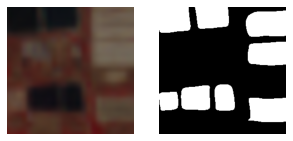

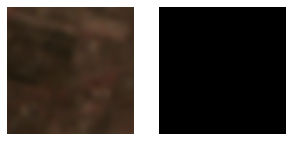

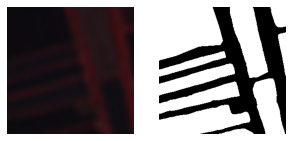

In [13]:
image_batch, label_batch = next(iter(train_dataset))
for i in tqdm_notebook(range(3)):
    image = image_batch[i]
    mask = label_batch[i]
    #Convert categorical to integer for visualization
    mask = np.argmax(mask, axis=2)
    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0:3])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

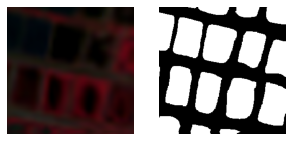

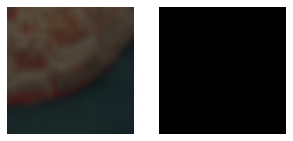

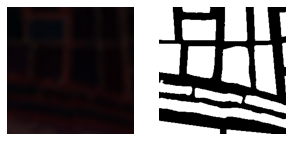

In [14]:
testimage_batch, label_batch = next(iter(valid_dataset))
for i in tqdm_notebook(range(3)):
    image = testimage_batch[i]
    mask = label_batch[i]
    #Convert categorical to integer for visualization
    mask = np.argmax(mask, axis=2)
    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0:3])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

In [15]:
# GPUS = ["GPU:0","GPU:1","GPU:2","GPU:3"]
# strategy = tf.distribute.MirroredStrategy( GPUS )
# print('Number of devices: %d' % strategy.num_replicas_in_sync)

In [16]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


Number of devices: 4


In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input, GlobalAveragePooling2D, Dense, Multiply
from keras.applications.resnet import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D

In [18]:
# input dimensions, no. of channels, and no. of classes for the model
IMG_HEIGHT = image_batch.shape[1]
IMG_WIDTH  = image_batch.shape[2]
IMG_CHANNELS = image_batch.shape[3]
n_classes=num_class

In [19]:
def SqueezeAndExcitation(inputs, ratio=8):
    
    b, h, w, c = inputs.shape
    
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(c//ratio, activation='relu', use_bias=False)(x)
    x = Dense(c, activation='sigmoid', use_bias=False)(x)
    
    x = Multiply()([inputs, x])
    
    return x


def ASPP(image_features):

    shape = image_features.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]))(image_features)
    y_pool = Conv2D(filters=128, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=128, kernel_size=1, padding='same', use_bias=False)(image_features)
    y_1 = BatchNormalization(name=f'bn_2')(y_1)
    y_1 = Activation('relu', name=f'relu_2')(y_1)

    y_6 = Conv2D(filters=128, kernel_size=3, padding='same', dilation_rate = 6,use_bias=False)(image_features)
    y_6 = BatchNormalization(name=f'bn_3')(y_6)
    y_6 = Activation('relu', name=f'relu_3')(y_6)

    y_12 = Conv2D(filters=128, kernel_size=1, padding='same', dilation_rate = 12,use_bias=False)(image_features)
    y_12 = BatchNormalization(name=f'bn_4')(y_12)
    y_12 = Activation('relu', name=f'relu_4')(y_12)

    y_18 = Conv2D(filters=128, kernel_size=3, padding='same', dilation_rate = 6,use_bias=False)(image_features)
    y_18 = BatchNormalization(name=f'bn_5')(y_18)
    y_18 = Activation('relu', name=f'relu_5')(y_18)

    y_c = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=128, kernel_size=1, padding='same', use_bias=False)(y_c)
    y = BatchNormalization(name=f'bn_6')(y)
    y = Activation('relu', name=f'relu_6')(y)

    return y

In [20]:
def DeepLabV3PlusSE(inputs, classes=1):

    inputs = Input(inputs)

    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    high_level_image_features = base_model.get_layer('conv4_block6_add').output
    high_level_image_features = SqueezeAndExcitation(high_level_image_features, ratio=16)
    
    x_a = ASPP(high_level_image_features)
    x_a = SqueezeAndExcitation(x_a, ratio=16)
    x_a = UpSampling2D(size=4, interpolation='bilinear')(x_a)

    low_level_image_features = base_model.get_layer('conv2_block3_add').output
    low_level_image_features = SqueezeAndExcitation(low_level_image_features, ratio=16)

    x_b = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(low_level_image_features)
    x_b = BatchNormalization(name=f'bn_7')(x_b)
    x_b = Activation('relu', name=f'relu_7')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_8')(x)
    x = Activation('relu', name=f'relu_8')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_9')(x)
    x = Activation('relu', name=f'relu_9')(x)

    x = UpSampling2D(size=4, interpolation='bilinear')(x)

    """ Outputs """
    x = Conv2D(classes, (1, 1), name='output_layer')(x)
    
    if classes == 1:
      x = Activation('sigmoid')(x)
    else:
      x = Activation('softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    
    return model

In [21]:
loss = params['Loss']
if loss == 'sdice_loss':
    with strategy.scope():
        model = DeepLabV3PlusSE((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),n_classes)
        model.compile(
        optimizer=optimizer,
        loss=sdice_loss,
        metrics=[[tf.keras.metrics.OneHotIoU(num_classes=2,target_class_ids=[0,1]),tf.keras.metrics.Precision()\
            ,tf.keras.metrics.Recall()]]
        )
elif loss == 'focal_tversky':
    with strategy.scope():
        model = DeepLabV3PlusSE((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),n_classes)
        model.compile(
        optimizer=optimizer,
        loss=focal_tversky,
        metrics=[[tf.keras.metrics.OneHotIoU(num_classes=2,target_class_ids=[0,1]),tf.keras.metrics.Precision()\
            ,tf.keras.metrics.Recall()]]
        )
elif loss == 'tversky_loss':
    with strategy.scope():
        model = DeepLabV3PlusSE((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),n_classes)
        model.compile(
        optimizer=optimizer,
        loss=tversky_loss,
        metrics=[[tf.keras.metrics.OneHotIoU(num_classes=2,target_class_ids=[0,1]),tf.keras.metrics.Precision()\
            ,tf.keras.metrics.Recall()]]
        )
elif loss == 'log_cosh_dice_loss':
    with strategy.scope():
        model = DeepLabV3PlusSE((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),n_classes)
        model.compile(
        optimizer=optimizer,
        loss=log_cosh_dice_loss,
        metrics=[[tf.keras.metrics.OneHotIoU(num_classes=2,target_class_ids=[0,1]),tf.keras.metrics.Precision()\
            ,tf.keras.metrics.Recall()]]
        )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [22]:
# calculation of steps per epoch for traning and validation
filespershard = 500
number_of_shards = len(glob.glob(PATH+'*.tfrecords'))
steps_per_epoch = (number_of_shards*filespershard*0.7)// BATCH_SIZE
val_steps_per_epoch = (number_of_shards*filespershard*0.3)//BATCH_SIZE

In [23]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger,LearningRateScheduler,TensorBoard

In [24]:
#ModelCheckpoint callback saves a model at some interval. 
checkpoint_path = 'model_checkpoint/'
os.makedirs(checkpoint_path, exist_ok=True)
filepath=checkpoint_path+"resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_one_hot_io_u', verbose=1, save_best_only=True, mode='max')

In [25]:
# earlystop for stopping the model when there is no improvement
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
log_csv = CSVLogger('/home/ubuntu/Notebooks for Unet_training/models for deeplab+SE v5/tversky-logs/sdice_lossv1.csv', separator=',', append=False)

In [26]:
epochs=epochs
learning_rate = lr
decay_rate = learning_rate / epochs
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate

In [27]:
lr_rate = LearningRateScheduler(exp_decay)

In [28]:
callbacks_list = [checkpoint,early_stop,lr_rate,DVCLiveCallback(dir='evaluation')]

In [29]:
%%time
history=model.fit(train_dataset,
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          verbose=1,
          validation_data=valid_dataset,
          validation_steps=val_steps_per_epoch,
          callbacks=callbacks_list,
          )

Epoch 1/10


INFO:tensorflow:batch_all_reduce: 207 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 207 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 207 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 207 all-reduces with algorithm = nccl, num_packs = 1


  1/328 [..............................] - ETA: 5:25:46 - loss: 0.4137 - one_hot_io_u: 0.2518 - precision: 0.4054 - recall: 0.4054

  2/328 [..............................] - ETA: 24s - loss: 0.3271 - one_hot_io_u: 0.3887 - precision: 0.5613 - recall: 0.5613    

  3/328 [..............................] - ETA: 24s - loss: 0.3269 - one_hot_io_u: 0.3952 - precision: 0.5710 - recall: 0.5710

  4/328 [..............................] - ETA: 24s - loss: 0.2832 - one_hot_io_u: 0.4560 - precision: 0.6347 - recall: 0.6347

  5/328 [..............................] - ETA: 24s - loss: 0.2767 - one_hot_io_u: 0.4750 - precision: 0.6500 - recall: 0.6500

  6/328 [..............................] - ETA: 24s - loss: 0.2768 - one_hot_io_u: 0.4773 - precision: 0.6537 - recall: 0.6537

  7/328 [..............................] - ETA: 24s - loss: 0.2688 - one_hot_io_u: 0.4916 - precision: 0.6665 - recall: 0.6665

  8/328 [..............................] - ETA: 23s - loss: 0.2682 - one_hot_io_u: 0.4921 - precision: 0.6683 - recall: 0.6683

  9/328 [..............................] - ETA: 23s - loss: 0.2616 - one_hot_io_u: 0.5030 - precision: 0.6781 - recall: 0.6781

 10/328 [..............................] - ETA: 23s - loss: 0.2546 - one_hot_io_u: 0.5130 - precision: 0.6876 - recall: 0.6876

 11/328 [>.............................] - ETA: 23s - loss: 0.2494 - one_hot_io_u: 0.5219 - precision: 0.6946 - recall: 0.6946

 12/328 [>.............................] - ETA: 23s - loss: 0.2469 - one_hot_io_u: 0.5258 - precision: 0.6998 - recall: 0.6998

 13/328 [>.............................] - ETA: 23s - loss: 0.2392 - one_hot_io_u: 0.5367 - precision: 0.7093 - recall: 0.7093

 14/328 [>.............................] - ETA: 23s - loss: 0.2351 - one_hot_io_u: 0.5433 - precision: 0.7150 - recall: 0.7150

 15/328 [>.............................] - ETA: 23s - loss: 0.2335 - one_hot_io_u: 0.5463 - precision: 0.7171 - recall: 0.7171

 16/328 [>.............................] - ETA: 23s - loss: 0.2317 - one_hot_io_u: 0.5489 - precision: 0.7198 - recall: 0.7198

 17/328 [>.............................] - ETA: 23s - loss: 0.2274 - one_hot_io_u: 0.5545 - precision: 0.7248 - recall: 0.7248

 18/328 [>.............................] - ETA: 23s - loss: 0.2245 - one_hot_io_u: 0.5587 - precision: 0.7294 - recall: 0.7294

 19/328 [>.............................] - ETA: 23s - loss: 0.2198 - one_hot_io_u: 0.5664 - precision: 0.7358 - recall: 0.7358

 20/328 [>.............................] - ETA: 22s - loss: 0.2164 - one_hot_io_u: 0.5716 - precision: 0.7399 - recall: 0.7399

 21/328 [>.............................] - ETA: 22s - loss: 0.2132 - one_hot_io_u: 0.5762 - precision: 0.7436 - recall: 0.7436

 22/328 [=>............................] - ETA: 22s - loss: 0.2097 - one_hot_io_u: 0.5818 - precision: 0.7480 - recall: 0.7480

 23/328 [=>............................] - ETA: 22s - loss: 0.2084 - one_hot_io_u: 0.5843 - precision: 0.7495 - recall: 0.7495

 24/328 [=>............................] - ETA: 22s - loss: 0.2086 - one_hot_io_u: 0.5846 - precision: 0.7498 - recall: 0.7498

 25/328 [=>............................] - ETA: 22s - loss: 0.2082 - one_hot_io_u: 0.5856 - precision: 0.7501 - recall: 0.7501

 26/328 [=>............................] - ETA: 22s - loss: 0.2094 - one_hot_io_u: 0.5837 - precision: 0.7489 - recall: 0.7489

 27/328 [=>............................] - ETA: 22s - loss: 0.2067 - one_hot_io_u: 0.5873 - precision: 0.7520 - recall: 0.7520

 28/328 [=>............................] - ETA: 22s - loss: 0.2051 - one_hot_io_u: 0.5897 - precision: 0.7540 - recall: 0.7540

 29/328 [=>............................] - ETA: 22s - loss: 0.2057 - one_hot_io_u: 0.5889 - precision: 0.7539 - recall: 0.7539

 30/328 [=>............................] - ETA: 22s - loss: 0.2065 - one_hot_io_u: 0.5890 - precision: 0.7534 - recall: 0.7534

 31/328 [=>............................] - ETA: 22s - loss: 0.2055 - one_hot_io_u: 0.5912 - precision: 0.7548 - recall: 0.7548

 32/328 [=>............................] - ETA: 21s - loss: 0.2055 - one_hot_io_u: 0.5913 - precision: 0.7547 - recall: 0.7547

 33/328 [==>...........................] - ETA: 21s - loss: 0.2046 - one_hot_io_u: 0.5930 - precision: 0.7557 - recall: 0.7557

 34/328 [==>...........................] - ETA: 21s - loss: 0.2031 - one_hot_io_u: 0.5952 - precision: 0.7569 - recall: 0.7569

 35/328 [==>...........................] - ETA: 21s - loss: 0.2019 - one_hot_io_u: 0.5965 - precision: 0.7581 - recall: 0.7581

 36/328 [==>...........................] - ETA: 21s - loss: 0.1998 - one_hot_io_u: 0.5999 - precision: 0.7603 - recall: 0.7603

 37/328 [==>...........................] - ETA: 21s - loss: 0.1978 - one_hot_io_u: 0.6028 - precision: 0.7625 - recall: 0.7625

 38/328 [==>...........................] - ETA: 21s - loss: 0.1982 - one_hot_io_u: 0.6023 - precision: 0.7625 - recall: 0.7625

 39/328 [==>...........................] - ETA: 21s - loss: 0.1969 - one_hot_io_u: 0.6044 - precision: 0.7645 - recall: 0.7645

 40/328 [==>...........................] - ETA: 21s - loss: 0.1973 - one_hot_io_u: 0.6042 - precision: 0.7642 - recall: 0.7642

 41/328 [==>...........................] - ETA: 21s - loss: 0.1972 - one_hot_io_u: 0.6046 - precision: 0.7645 - recall: 0.7645

 42/328 [==>...........................] - ETA: 21s - loss: 0.1957 - one_hot_io_u: 0.6073 - precision: 0.7662 - recall: 0.7662

 43/328 [==>...........................] - ETA: 21s - loss: 0.1954 - one_hot_io_u: 0.6077 - precision: 0.7664 - recall: 0.7664

 44/328 [===>..........................] - ETA: 21s - loss: 0.1947 - one_hot_io_u: 0.6089 - precision: 0.7672 - recall: 0.7672

 45/328 [===>..........................] - ETA: 20s - loss: 0.1943 - one_hot_io_u: 0.6098 - precision: 0.7677 - recall: 0.7677

 46/328 [===>..........................] - ETA: 20s - loss: 0.1942 - one_hot_io_u: 0.6099 - precision: 0.7679 - recall: 0.7679

 47/328 [===>..........................] - ETA: 20s - loss: 0.1916 - one_hot_io_u: 0.6139 - precision: 0.7709 - recall: 0.7709

 48/328 [===>..........................] - ETA: 20s - loss: 0.1902 - one_hot_io_u: 0.6161 - precision: 0.7726 - recall: 0.7726

 49/328 [===>..........................] - ETA: 20s - loss: 0.1900 - one_hot_io_u: 0.6173 - precision: 0.7730 - recall: 0.7730

 50/328 [===>..........................] - ETA: 20s - loss: 0.1885 - one_hot_io_u: 0.6195 - precision: 0.7747 - recall: 0.7747

 51/328 [===>..........................] - ETA: 20s - loss: 0.1880 - one_hot_io_u: 0.6203 - precision: 0.7755 - recall: 0.7755

 52/328 [===>..........................] - ETA: 20s - loss: 0.1865 - one_hot_io_u: 0.6226 - precision: 0.7772 - recall: 0.7772

 53/328 [===>..........................] - ETA: 20s - loss: 0.1850 - one_hot_io_u: 0.6252 - precision: 0.7789 - recall: 0.7789

 54/328 [===>..........................] - ETA: 20s - loss: 0.1848 - one_hot_io_u: 0.6254 - precision: 0.7791 - recall: 0.7791

 55/328 [====>.........................] - ETA: 20s - loss: 0.1841 - one_hot_io_u: 0.6264 - precision: 0.7797 - recall: 0.7797

 56/328 [====>.........................] - ETA: 20s - loss: 0.1828 - one_hot_io_u: 0.6284 - precision: 0.7812 - recall: 0.7812

 57/328 [====>.........................] - ETA: 20s - loss: 0.1824 - one_hot_io_u: 0.6288 - precision: 0.7814 - recall: 0.7814

 58/328 [====>.........................] - ETA: 20s - loss: 0.1825 - one_hot_io_u: 0.6287 - precision: 0.7814 - recall: 0.7814

 59/328 [====>.........................] - ETA: 19s - loss: 0.1814 - one_hot_io_u: 0.6303 - precision: 0.7825 - recall: 0.7825

 60/328 [====>.........................] - ETA: 19s - loss: 0.1804 - one_hot_io_u: 0.6321 - precision: 0.7837 - recall: 0.7837

 61/328 [====>.........................] - ETA: 19s - loss: 0.1800 - one_hot_io_u: 0.6326 - precision: 0.7841 - recall: 0.7841

 62/328 [====>.........................] - ETA: 19s - loss: 0.1804 - one_hot_io_u: 0.6318 - precision: 0.7837 - recall: 0.7837

 63/328 [====>.........................] - ETA: 19s - loss: 0.1795 - one_hot_io_u: 0.6333 - precision: 0.7847 - recall: 0.7847

 64/328 [====>.........................] - ETA: 19s - loss: 0.1788 - one_hot_io_u: 0.6345 - precision: 0.7857 - recall: 0.7857

 65/328 [====>.........................] - ETA: 19s - loss: 0.1786 - one_hot_io_u: 0.6352 - precision: 0.7858 - recall: 0.7858

 66/328 [=====>........................] - ETA: 19s - loss: 0.1782 - one_hot_io_u: 0.6357 - precision: 0.7863 - recall: 0.7863

 67/328 [=====>........................] - ETA: 19s - loss: 0.1775 - one_hot_io_u: 0.6368 - precision: 0.7869 - recall: 0.7869

 68/328 [=====>........................] - ETA: 19s - loss: 0.1775 - one_hot_io_u: 0.6371 - precision: 0.7869 - recall: 0.7869

 69/328 [=====>........................] - ETA: 19s - loss: 0.1765 - one_hot_io_u: 0.6387 - precision: 0.7881 - recall: 0.7881

 70/328 [=====>........................] - ETA: 19s - loss: 0.1764 - one_hot_io_u: 0.6390 - precision: 0.7883 - recall: 0.7883

 71/328 [=====>........................] - ETA: 19s - loss: 0.1765 - one_hot_io_u: 0.6389 - precision: 0.7881 - recall: 0.7881

 72/328 [=====>........................] - ETA: 18s - loss: 0.1762 - one_hot_io_u: 0.6396 - precision: 0.7885 - recall: 0.7885

 73/328 [=====>........................] - ETA: 18s - loss: 0.1757 - one_hot_io_u: 0.6404 - precision: 0.7891 - recall: 0.7891

 74/328 [=====>........................] - ETA: 18s - loss: 0.1751 - one_hot_io_u: 0.6412 - precision: 0.7897 - recall: 0.7897

 75/328 [=====>........................] - ETA: 18s - loss: 0.1744 - one_hot_io_u: 0.6422 - precision: 0.7906 - recall: 0.7906

 76/328 [=====>........................] - ETA: 18s - loss: 0.1741 - one_hot_io_u: 0.6425 - precision: 0.7907 - recall: 0.7907

 77/328 [======>.......................] - ETA: 18s - loss: 0.1731 - one_hot_io_u: 0.6441 - precision: 0.7920 - recall: 0.7920

 78/328 [======>.......................] - ETA: 18s - loss: 0.1729 - one_hot_io_u: 0.6444 - precision: 0.7921 - recall: 0.7921

 79/328 [======>.......................] - ETA: 18s - loss: 0.1723 - one_hot_io_u: 0.6454 - precision: 0.7928 - recall: 0.7928

 80/328 [======>.......................] - ETA: 18s - loss: 0.1720 - one_hot_io_u: 0.6458 - precision: 0.7933 - recall: 0.7933

 81/328 [======>.......................] - ETA: 18s - loss: 0.1714 - one_hot_io_u: 0.6467 - precision: 0.7940 - recall: 0.7940

 82/328 [======>.......................] - ETA: 18s - loss: 0.1714 - one_hot_io_u: 0.6469 - precision: 0.7940 - recall: 0.7940

 83/328 [======>.......................] - ETA: 18s - loss: 0.1708 - one_hot_io_u: 0.6477 - precision: 0.7947 - recall: 0.7947

 84/328 [======>.......................] - ETA: 18s - loss: 0.1704 - one_hot_io_u: 0.6484 - precision: 0.7952 - recall: 0.7952

 85/328 [======>.......................] - ETA: 17s - loss: 0.1717 - one_hot_io_u: 0.6467 - precision: 0.7941 - recall: 0.7941

 86/328 [======>.......................] - ETA: 17s - loss: 0.1712 - one_hot_io_u: 0.6473 - precision: 0.7946 - recall: 0.7946

 87/328 [======>.......................] - ETA: 17s - loss: 0.1709 - one_hot_io_u: 0.6477 - precision: 0.7949 - recall: 0.7949

 88/328 [=======>......................] - ETA: 17s - loss: 0.1709 - one_hot_io_u: 0.6477 - precision: 0.7950 - recall: 0.7950

 89/328 [=======>......................] - ETA: 17s - loss: 0.1707 - one_hot_io_u: 0.6480 - precision: 0.7951 - recall: 0.7951

 90/328 [=======>......................] - ETA: 17s - loss: 0.1708 - one_hot_io_u: 0.6478 - precision: 0.7948 - recall: 0.7948

 91/328 [=======>......................] - ETA: 17s - loss: 0.1702 - one_hot_io_u: 0.6489 - precision: 0.7956 - recall: 0.7956

 92/328 [=======>......................] - ETA: 17s - loss: 0.1699 - one_hot_io_u: 0.6495 - precision: 0.7961 - recall: 0.7961

 93/328 [=======>......................] - ETA: 17s - loss: 0.1692 - one_hot_io_u: 0.6505 - precision: 0.7968 - recall: 0.7968

 94/328 [=======>......................] - ETA: 17s - loss: 0.1685 - one_hot_io_u: 0.6517 - precision: 0.7977 - recall: 0.7977

 95/328 [=======>......................] - ETA: 17s - loss: 0.1682 - one_hot_io_u: 0.6523 - precision: 0.7981 - recall: 0.7981

 96/328 [=======>......................] - ETA: 17s - loss: 0.1684 - one_hot_io_u: 0.6519 - precision: 0.7978 - recall: 0.7978

 97/328 [=======>......................] - ETA: 17s - loss: 0.1681 - one_hot_io_u: 0.6525 - precision: 0.7982 - recall: 0.7982

 98/328 [=======>......................] - ETA: 17s - loss: 0.1678 - one_hot_io_u: 0.6527 - precision: 0.7985 - recall: 0.7985

 99/328 [========>.....................] - ETA: 16s - loss: 0.1675 - one_hot_io_u: 0.6533 - precision: 0.7989 - recall: 0.7989

100/328 [========>.....................] - ETA: 16s - loss: 0.1674 - one_hot_io_u: 0.6535 - precision: 0.7991 - recall: 0.7991

101/328 [========>.....................] - ETA: 16s - loss: 0.1674 - one_hot_io_u: 0.6532 - precision: 0.7989 - recall: 0.7989

102/328 [========>.....................] - ETA: 16s - loss: 0.1670 - one_hot_io_u: 0.6541 - precision: 0.7994 - recall: 0.7994

103/328 [========>.....................] - ETA: 16s - loss: 0.1669 - one_hot_io_u: 0.6542 - precision: 0.7995 - recall: 0.7995

104/328 [========>.....................] - ETA: 16s - loss: 0.1667 - one_hot_io_u: 0.6545 - precision: 0.7997 - recall: 0.7997

105/328 [========>.....................] - ETA: 16s - loss: 0.1662 - one_hot_io_u: 0.6551 - precision: 0.8002 - recall: 0.8002

106/328 [========>.....................] - ETA: 16s - loss: 0.1660 - one_hot_io_u: 0.6553 - precision: 0.8004 - recall: 0.8004

107/328 [========>.....................] - ETA: 16s - loss: 0.1657 - one_hot_io_u: 0.6557 - precision: 0.8006 - recall: 0.8006

108/328 [========>.....................] - ETA: 16s - loss: 0.1656 - one_hot_io_u: 0.6559 - precision: 0.8008 - recall: 0.8008

109/328 [========>.....................] - ETA: 16s - loss: 0.1657 - one_hot_io_u: 0.6557 - precision: 0.8007 - recall: 0.8007

110/328 [=========>....................] - ETA: 16s - loss: 0.1655 - one_hot_io_u: 0.6557 - precision: 0.8008 - recall: 0.8008

111/328 [=========>....................] - ETA: 16s - loss: 0.1650 - one_hot_io_u: 0.6567 - precision: 0.8015 - recall: 0.8015

112/328 [=========>....................] - ETA: 15s - loss: 0.1650 - one_hot_io_u: 0.6565 - precision: 0.8014 - recall: 0.8014

113/328 [=========>....................] - ETA: 15s - loss: 0.1650 - one_hot_io_u: 0.6566 - precision: 0.8014 - recall: 0.8014

114/328 [=========>....................] - ETA: 15s - loss: 0.1651 - one_hot_io_u: 0.6563 - precision: 0.8013 - recall: 0.8013

115/328 [=========>....................] - ETA: 15s - loss: 0.1649 - one_hot_io_u: 0.6566 - precision: 0.8014 - recall: 0.8014

116/328 [=========>....................] - ETA: 15s - loss: 0.1643 - one_hot_io_u: 0.6576 - precision: 0.8022 - recall: 0.8022

117/328 [=========>....................] - ETA: 15s - loss: 0.1642 - one_hot_io_u: 0.6578 - precision: 0.8023 - recall: 0.8023

118/328 [=========>....................] - ETA: 15s - loss: 0.1637 - one_hot_io_u: 0.6586 - precision: 0.8029 - recall: 0.8029

119/328 [=========>....................] - ETA: 15s - loss: 0.1636 - one_hot_io_u: 0.6587 - precision: 0.8029 - recall: 0.8029

120/328 [=========>....................] - ETA: 15s - loss: 0.1632 - one_hot_io_u: 0.6592 - precision: 0.8033 - recall: 0.8033

121/328 [==========>...................] - ETA: 15s - loss: 0.1631 - one_hot_io_u: 0.6597 - precision: 0.8036 - recall: 0.8036

122/328 [==========>...................] - ETA: 15s - loss: 0.1630 - one_hot_io_u: 0.6597 - precision: 0.8037 - recall: 0.8037

123/328 [==========>...................] - ETA: 15s - loss: 0.1625 - one_hot_io_u: 0.6604 - precision: 0.8042 - recall: 0.8042

124/328 [==========>...................] - ETA: 15s - loss: 0.1624 - one_hot_io_u: 0.6605 - precision: 0.8043 - recall: 0.8043

125/328 [==========>...................] - ETA: 14s - loss: 0.1625 - one_hot_io_u: 0.6604 - precision: 0.8042 - recall: 0.8042

126/328 [==========>...................] - ETA: 14s - loss: 0.1626 - one_hot_io_u: 0.6603 - precision: 0.8041 - recall: 0.8041

127/328 [==========>...................] - ETA: 14s - loss: 0.1627 - one_hot_io_u: 0.6600 - precision: 0.8039 - recall: 0.8039

128/328 [==========>...................] - ETA: 14s - loss: 0.1627 - one_hot_io_u: 0.6601 - precision: 0.8039 - recall: 0.8039

129/328 [==========>...................] - ETA: 14s - loss: 0.1622 - one_hot_io_u: 0.6610 - precision: 0.8045 - recall: 0.8045

130/328 [==========>...................] - ETA: 14s - loss: 0.1622 - one_hot_io_u: 0.6610 - precision: 0.8046 - recall: 0.8046

131/328 [==========>...................] - ETA: 14s - loss: 0.1618 - one_hot_io_u: 0.6617 - precision: 0.8050 - recall: 0.8050

132/328 [===========>..................] - ETA: 14s - loss: 0.1615 - one_hot_io_u: 0.6621 - precision: 0.8053 - recall: 0.8053

133/328 [===========>..................] - ETA: 14s - loss: 0.1613 - one_hot_io_u: 0.6624 - precision: 0.8055 - recall: 0.8055

134/328 [===========>..................] - ETA: 14s - loss: 0.1614 - one_hot_io_u: 0.6623 - precision: 0.8054 - recall: 0.8054

135/328 [===========>..................] - ETA: 14s - loss: 0.1613 - one_hot_io_u: 0.6623 - precision: 0.8054 - recall: 0.8054

136/328 [===========>..................] - ETA: 14s - loss: 0.1611 - one_hot_io_u: 0.6627 - precision: 0.8056 - recall: 0.8056

137/328 [===========>..................] - ETA: 14s - loss: 0.1607 - one_hot_io_u: 0.6634 - precision: 0.8061 - recall: 0.8061

138/328 [===========>..................] - ETA: 14s - loss: 0.1604 - one_hot_io_u: 0.6640 - precision: 0.8064 - recall: 0.8064

139/328 [===========>..................] - ETA: 13s - loss: 0.1605 - one_hot_io_u: 0.6639 - precision: 0.8063 - recall: 0.8063

140/328 [===========>..................] - ETA: 13s - loss: 0.1605 - one_hot_io_u: 0.6639 - precision: 0.8062 - recall: 0.8062

141/328 [===========>..................] - ETA: 13s - loss: 0.1602 - one_hot_io_u: 0.6644 - precision: 0.8065 - recall: 0.8065

142/328 [===========>..................] - ETA: 13s - loss: 0.1596 - one_hot_io_u: 0.6654 - precision: 0.8072 - recall: 0.8072

143/328 [============>.................] - ETA: 13s - loss: 0.1594 - one_hot_io_u: 0.6658 - precision: 0.8074 - recall: 0.8074

144/328 [============>.................] - ETA: 13s - loss: 0.1593 - one_hot_io_u: 0.6660 - precision: 0.8076 - recall: 0.8076

145/328 [============>.................] - ETA: 13s - loss: 0.1593 - one_hot_io_u: 0.6659 - precision: 0.8075 - recall: 0.8075

146/328 [============>.................] - ETA: 13s - loss: 0.1598 - one_hot_io_u: 0.6652 - precision: 0.8070 - recall: 0.8070

147/328 [============>.................] - ETA: 13s - loss: 0.1595 - one_hot_io_u: 0.6657 - precision: 0.8074 - recall: 0.8074

148/328 [============>.................] - ETA: 13s - loss: 0.1596 - one_hot_io_u: 0.6654 - precision: 0.8072 - recall: 0.8072

149/328 [============>.................] - ETA: 13s - loss: 0.1595 - one_hot_io_u: 0.6656 - precision: 0.8073 - recall: 0.8073

150/328 [============>.................] - ETA: 13s - loss: 0.1594 - one_hot_io_u: 0.6658 - precision: 0.8076 - recall: 0.8076

151/328 [============>.................] - ETA: 13s - loss: 0.1592 - one_hot_io_u: 0.6661 - precision: 0.8078 - recall: 0.8078

152/328 [============>.................] - ETA: 12s - loss: 0.1590 - one_hot_io_u: 0.6665 - precision: 0.8080 - recall: 0.8080

153/328 [============>.................] - ETA: 12s - loss: 0.1587 - one_hot_io_u: 0.6671 - precision: 0.8084 - recall: 0.8084

154/328 [=============>................] - ETA: 12s - loss: 0.1584 - one_hot_io_u: 0.6677 - precision: 0.8088 - recall: 0.8088

155/328 [=============>................] - ETA: 12s - loss: 0.1584 - one_hot_io_u: 0.6677 - precision: 0.8089 - recall: 0.8089

156/328 [=============>................] - ETA: 12s - loss: 0.1584 - one_hot_io_u: 0.6679 - precision: 0.8089 - recall: 0.8089

157/328 [=============>................] - ETA: 12s - loss: 0.1579 - one_hot_io_u: 0.6686 - precision: 0.8094 - recall: 0.8094

158/328 [=============>................] - ETA: 12s - loss: 0.1578 - one_hot_io_u: 0.6687 - precision: 0.8095 - recall: 0.8095

159/328 [=============>................] - ETA: 12s - loss: 0.1577 - one_hot_io_u: 0.6689 - precision: 0.8096 - recall: 0.8096

160/328 [=============>................] - ETA: 12s - loss: 0.1576 - one_hot_io_u: 0.6692 - precision: 0.8098 - recall: 0.8098

161/328 [=============>................] - ETA: 12s - loss: 0.1575 - one_hot_io_u: 0.6693 - precision: 0.8098 - recall: 0.8098

162/328 [=============>................] - ETA: 12s - loss: 0.1575 - one_hot_io_u: 0.6693 - precision: 0.8098 - recall: 0.8098

163/328 [=============>................] - ETA: 12s - loss: 0.1576 - one_hot_io_u: 0.6693 - precision: 0.8098 - recall: 0.8098

164/328 [==============>...............] - ETA: 12s - loss: 0.1575 - one_hot_io_u: 0.6694 - precision: 0.8099 - recall: 0.8099

165/328 [==============>...............] - ETA: 12s - loss: 0.1576 - one_hot_io_u: 0.6694 - precision: 0.8098 - recall: 0.8098

166/328 [==============>...............] - ETA: 11s - loss: 0.1572 - one_hot_io_u: 0.6701 - precision: 0.8103 - recall: 0.8103

167/328 [==============>...............] - ETA: 11s - loss: 0.1571 - one_hot_io_u: 0.6702 - precision: 0.8103 - recall: 0.8103

168/328 [==============>...............] - ETA: 11s - loss: 0.1569 - one_hot_io_u: 0.6705 - precision: 0.8105 - recall: 0.8105

169/328 [==============>...............] - ETA: 11s - loss: 0.1568 - one_hot_io_u: 0.6707 - precision: 0.8106 - recall: 0.8106

170/328 [==============>...............] - ETA: 11s - loss: 0.1567 - one_hot_io_u: 0.6710 - precision: 0.8108 - recall: 0.8108

171/328 [==============>...............] - ETA: 11s - loss: 0.1562 - one_hot_io_u: 0.6719 - precision: 0.8114 - recall: 0.8114

172/328 [==============>...............] - ETA: 11s - loss: 0.1561 - one_hot_io_u: 0.6721 - precision: 0.8115 - recall: 0.8115

173/328 [==============>...............] - ETA: 11s - loss: 0.1563 - one_hot_io_u: 0.6717 - precision: 0.8112 - recall: 0.8112

174/328 [==============>...............] - ETA: 11s - loss: 0.1562 - one_hot_io_u: 0.6719 - precision: 0.8113 - recall: 0.8113

175/328 [===============>..............] - ETA: 11s - loss: 0.1562 - one_hot_io_u: 0.6718 - precision: 0.8113 - recall: 0.8113

176/328 [===============>..............] - ETA: 11s - loss: 0.1563 - one_hot_io_u: 0.6719 - precision: 0.8113 - recall: 0.8113

177/328 [===============>..............] - ETA: 11s - loss: 0.1561 - one_hot_io_u: 0.6721 - precision: 0.8115 - recall: 0.8115

178/328 [===============>..............] - ETA: 11s - loss: 0.1559 - one_hot_io_u: 0.6725 - precision: 0.8117 - recall: 0.8117

179/328 [===============>..............] - ETA: 10s - loss: 0.1559 - one_hot_io_u: 0.6725 - precision: 0.8117 - recall: 0.8117

180/328 [===============>..............] - ETA: 10s - loss: 0.1558 - one_hot_io_u: 0.6727 - precision: 0.8119 - recall: 0.8119

181/328 [===============>..............] - ETA: 10s - loss: 0.1559 - one_hot_io_u: 0.6726 - precision: 0.8118 - recall: 0.8118

182/328 [===============>..............] - ETA: 10s - loss: 0.1558 - one_hot_io_u: 0.6728 - precision: 0.8118 - recall: 0.8118

183/328 [===============>..............] - ETA: 10s - loss: 0.1556 - one_hot_io_u: 0.6731 - precision: 0.8121 - recall: 0.8121

184/328 [===============>..............] - ETA: 10s - loss: 0.1555 - one_hot_io_u: 0.6732 - precision: 0.8122 - recall: 0.8122

185/328 [===============>..............] - ETA: 10s - loss: 0.1553 - one_hot_io_u: 0.6737 - precision: 0.8124 - recall: 0.8124

186/328 [================>.............] - ETA: 10s - loss: 0.1549 - one_hot_io_u: 0.6744 - precision: 0.8129 - recall: 0.8129

187/328 [================>.............] - ETA: 10s - loss: 0.1547 - one_hot_io_u: 0.6747 - precision: 0.8131 - recall: 0.8131

188/328 [================>.............] - ETA: 10s - loss: 0.1545 - one_hot_io_u: 0.6753 - precision: 0.8135 - recall: 0.8135

189/328 [================>.............] - ETA: 10s - loss: 0.1541 - one_hot_io_u: 0.6759 - precision: 0.8139 - recall: 0.8139

190/328 [================>.............] - ETA: 10s - loss: 0.1540 - one_hot_io_u: 0.6762 - precision: 0.8140 - recall: 0.8140

191/328 [================>.............] - ETA: 10s - loss: 0.1539 - one_hot_io_u: 0.6762 - precision: 0.8140 - recall: 0.8140

192/328 [================>.............] - ETA: 10s - loss: 0.1539 - one_hot_io_u: 0.6762 - precision: 0.8141 - recall: 0.8141

193/328 [================>.............] - ETA: 9s - loss: 0.1539 - one_hot_io_u: 0.6762 - precision: 0.8140 - recall: 0.8140 

194/328 [================>.............] - ETA: 9s - loss: 0.1540 - one_hot_io_u: 0.6761 - precision: 0.8140 - recall: 0.8140

195/328 [================>.............] - ETA: 9s - loss: 0.1538 - one_hot_io_u: 0.6763 - precision: 0.8141 - recall: 0.8141

196/328 [================>.............] - ETA: 9s - loss: 0.1534 - one_hot_io_u: 0.6770 - precision: 0.8146 - recall: 0.8146

197/328 [=================>............] - ETA: 9s - loss: 0.1530 - one_hot_io_u: 0.6778 - precision: 0.8151 - recall: 0.8151

198/328 [=================>............] - ETA: 9s - loss: 0.1529 - one_hot_io_u: 0.6779 - precision: 0.8151 - recall: 0.8151

199/328 [=================>............] - ETA: 9s - loss: 0.1527 - one_hot_io_u: 0.6783 - precision: 0.8154 - recall: 0.8154

200/328 [=================>............] - ETA: 9s - loss: 0.1529 - one_hot_io_u: 0.6777 - precision: 0.8150 - recall: 0.8150

201/328 [=================>............] - ETA: 9s - loss: 0.1533 - one_hot_io_u: 0.6772 - precision: 0.8146 - recall: 0.8146

202/328 [=================>............] - ETA: 9s - loss: 0.1531 - one_hot_io_u: 0.6774 - precision: 0.8147 - recall: 0.8147

203/328 [=================>............] - ETA: 9s - loss: 0.1532 - one_hot_io_u: 0.6774 - precision: 0.8147 - recall: 0.8147

204/328 [=================>............] - ETA: 9s - loss: 0.1533 - one_hot_io_u: 0.6771 - precision: 0.8145 - recall: 0.8145

205/328 [=================>............] - ETA: 9s - loss: 0.1531 - one_hot_io_u: 0.6774 - precision: 0.8148 - recall: 0.8148

206/328 [=================>............] - ETA: 8s - loss: 0.1530 - one_hot_io_u: 0.6778 - precision: 0.8150 - recall: 0.8150

207/328 [=================>............] - ETA: 8s - loss: 0.1528 - one_hot_io_u: 0.6782 - precision: 0.8152 - recall: 0.8152

208/328 [==================>...........] - ETA: 8s - loss: 0.1530 - one_hot_io_u: 0.6778 - precision: 0.8150 - recall: 0.8150

209/328 [==================>...........] - ETA: 8s - loss: 0.1531 - one_hot_io_u: 0.6776 - precision: 0.8148 - recall: 0.8148

210/328 [==================>...........] - ETA: 8s - loss: 0.1530 - one_hot_io_u: 0.6777 - precision: 0.8149 - recall: 0.8149

211/328 [==================>...........] - ETA: 8s - loss: 0.1528 - one_hot_io_u: 0.6780 - precision: 0.8151 - recall: 0.8151

212/328 [==================>...........] - ETA: 8s - loss: 0.1528 - one_hot_io_u: 0.6781 - precision: 0.8152 - recall: 0.8152

213/328 [==================>...........] - ETA: 8s - loss: 0.1529 - one_hot_io_u: 0.6777 - precision: 0.8150 - recall: 0.8150

214/328 [==================>...........] - ETA: 8s - loss: 0.1529 - one_hot_io_u: 0.6778 - precision: 0.8151 - recall: 0.8151

215/328 [==================>...........] - ETA: 8s - loss: 0.1529 - one_hot_io_u: 0.6778 - precision: 0.8151 - recall: 0.8151

216/328 [==================>...........] - ETA: 8s - loss: 0.1525 - one_hot_io_u: 0.6783 - precision: 0.8155 - recall: 0.8155

217/328 [==================>...........] - ETA: 8s - loss: 0.1525 - one_hot_io_u: 0.6783 - precision: 0.8155 - recall: 0.8155

218/328 [==================>...........] - ETA: 8s - loss: 0.1523 - one_hot_io_u: 0.6787 - precision: 0.8157 - recall: 0.8157

219/328 [===================>..........] - ETA: 8s - loss: 0.1522 - one_hot_io_u: 0.6789 - precision: 0.8159 - recall: 0.8159

220/328 [===================>..........] - ETA: 7s - loss: 0.1520 - one_hot_io_u: 0.6791 - precision: 0.8161 - recall: 0.8161

221/328 [===================>..........] - ETA: 7s - loss: 0.1518 - one_hot_io_u: 0.6795 - precision: 0.8164 - recall: 0.8164

222/328 [===================>..........] - ETA: 7s - loss: 0.1516 - one_hot_io_u: 0.6798 - precision: 0.8165 - recall: 0.8165

223/328 [===================>..........] - ETA: 7s - loss: 0.1517 - one_hot_io_u: 0.6797 - precision: 0.8164 - recall: 0.8164

224/328 [===================>..........] - ETA: 7s - loss: 0.1516 - one_hot_io_u: 0.6799 - precision: 0.8165 - recall: 0.8165

225/328 [===================>..........] - ETA: 7s - loss: 0.1512 - one_hot_io_u: 0.6806 - precision: 0.8170 - recall: 0.8170

226/328 [===================>..........] - ETA: 7s - loss: 0.1512 - one_hot_io_u: 0.6807 - precision: 0.8170 - recall: 0.8170

227/328 [===================>..........] - ETA: 7s - loss: 0.1512 - one_hot_io_u: 0.6807 - precision: 0.8170 - recall: 0.8170

228/328 [===================>..........] - ETA: 7s - loss: 0.1510 - one_hot_io_u: 0.6811 - precision: 0.8172 - recall: 0.8172

229/328 [===================>..........] - ETA: 7s - loss: 0.1511 - one_hot_io_u: 0.6810 - precision: 0.8172 - recall: 0.8172

230/328 [====================>.........] - ETA: 7s - loss: 0.1509 - one_hot_io_u: 0.6812 - precision: 0.8173 - recall: 0.8173

231/328 [====================>.........] - ETA: 7s - loss: 0.1507 - one_hot_io_u: 0.6817 - precision: 0.8176 - recall: 0.8176

232/328 [====================>.........] - ETA: 7s - loss: 0.1504 - one_hot_io_u: 0.6822 - precision: 0.8180 - recall: 0.8180

233/328 [====================>.........] - ETA: 6s - loss: 0.1502 - one_hot_io_u: 0.6824 - precision: 0.8181 - recall: 0.8181

234/328 [====================>.........] - ETA: 6s - loss: 0.1500 - one_hot_io_u: 0.6827 - precision: 0.8184 - recall: 0.8184

235/328 [====================>.........] - ETA: 6s - loss: 0.1500 - one_hot_io_u: 0.6827 - precision: 0.8184 - recall: 0.8184

236/328 [====================>.........] - ETA: 6s - loss: 0.1502 - one_hot_io_u: 0.6826 - precision: 0.8183 - recall: 0.8183

237/328 [====================>.........] - ETA: 6s - loss: 0.1499 - one_hot_io_u: 0.6829 - precision: 0.8186 - recall: 0.8186

238/328 [====================>.........] - ETA: 6s - loss: 0.1498 - one_hot_io_u: 0.6831 - precision: 0.8187 - recall: 0.8187

239/328 [====================>.........] - ETA: 6s - loss: 0.1497 - one_hot_io_u: 0.6833 - precision: 0.8189 - recall: 0.8189

240/328 [====================>.........] - ETA: 6s - loss: 0.1496 - one_hot_io_u: 0.6835 - precision: 0.8190 - recall: 0.8190

241/328 [=====================>........] - ETA: 6s - loss: 0.1496 - one_hot_io_u: 0.6835 - precision: 0.8190 - recall: 0.8190

242/328 [=====================>........] - ETA: 6s - loss: 0.1494 - one_hot_io_u: 0.6838 - precision: 0.8193 - recall: 0.8193

243/328 [=====================>........] - ETA: 6s - loss: 0.1493 - one_hot_io_u: 0.6839 - precision: 0.8193 - recall: 0.8193

244/328 [=====================>........] - ETA: 6s - loss: 0.1492 - one_hot_io_u: 0.6840 - precision: 0.8194 - recall: 0.8194

245/328 [=====================>........] - ETA: 6s - loss: 0.1491 - one_hot_io_u: 0.6843 - precision: 0.8196 - recall: 0.8196

246/328 [=====================>........] - ETA: 6s - loss: 0.1489 - one_hot_io_u: 0.6846 - precision: 0.8198 - recall: 0.8198

247/328 [=====================>........] - ETA: 5s - loss: 0.1489 - one_hot_io_u: 0.6845 - precision: 0.8198 - recall: 0.8198

248/328 [=====================>........] - ETA: 5s - loss: 0.1488 - one_hot_io_u: 0.6846 - precision: 0.8199 - recall: 0.8199

249/328 [=====================>........] - ETA: 5s - loss: 0.1486 - one_hot_io_u: 0.6850 - precision: 0.8201 - recall: 0.8201

250/328 [=====================>........] - ETA: 5s - loss: 0.1487 - one_hot_io_u: 0.6849 - precision: 0.8200 - recall: 0.8200

251/328 [=====================>........] - ETA: 5s - loss: 0.1487 - one_hot_io_u: 0.6848 - precision: 0.8199 - recall: 0.8199

252/328 [======================>.......] - ETA: 5s - loss: 0.1485 - one_hot_io_u: 0.6850 - precision: 0.8202 - recall: 0.8202

253/328 [======================>.......] - ETA: 5s - loss: 0.1483 - one_hot_io_u: 0.6855 - precision: 0.8205 - recall: 0.8205

254/328 [======================>.......] - ETA: 5s - loss: 0.1485 - one_hot_io_u: 0.6852 - precision: 0.8202 - recall: 0.8202

255/328 [======================>.......] - ETA: 5s - loss: 0.1484 - one_hot_io_u: 0.6855 - precision: 0.8204 - recall: 0.8204

256/328 [======================>.......] - ETA: 5s - loss: 0.1482 - one_hot_io_u: 0.6858 - precision: 0.8207 - recall: 0.8207

257/328 [======================>.......] - ETA: 5s - loss: 0.1481 - one_hot_io_u: 0.6860 - precision: 0.8207 - recall: 0.8207

258/328 [======================>.......] - ETA: 5s - loss: 0.1481 - one_hot_io_u: 0.6861 - precision: 0.8207 - recall: 0.8207

259/328 [======================>.......] - ETA: 5s - loss: 0.1482 - one_hot_io_u: 0.6860 - precision: 0.8206 - recall: 0.8206

260/328 [======================>.......] - ETA: 5s - loss: 0.1481 - one_hot_io_u: 0.6862 - precision: 0.8207 - recall: 0.8207

261/328 [======================>.......] - ETA: 4s - loss: 0.1481 - one_hot_io_u: 0.6863 - precision: 0.8208 - recall: 0.8208

262/328 [======================>.......] - ETA: 4s - loss: 0.1480 - one_hot_io_u: 0.6864 - precision: 0.8208 - recall: 0.8208

263/328 [=======================>......] - ETA: 4s - loss: 0.1478 - one_hot_io_u: 0.6869 - precision: 0.8212 - recall: 0.8212

264/328 [=======================>......] - ETA: 4s - loss: 0.1477 - one_hot_io_u: 0.6869 - precision: 0.8212 - recall: 0.8212

265/328 [=======================>......] - ETA: 4s - loss: 0.1476 - one_hot_io_u: 0.6870 - precision: 0.8213 - recall: 0.8213

266/328 [=======================>......] - ETA: 4s - loss: 0.1475 - one_hot_io_u: 0.6872 - precision: 0.8215 - recall: 0.8215

267/328 [=======================>......] - ETA: 4s - loss: 0.1475 - one_hot_io_u: 0.6872 - precision: 0.8215 - recall: 0.8215

268/328 [=======================>......] - ETA: 4s - loss: 0.1474 - one_hot_io_u: 0.6871 - precision: 0.8215 - recall: 0.8215

269/328 [=======================>......] - ETA: 4s - loss: 0.1474 - one_hot_io_u: 0.6872 - precision: 0.8215 - recall: 0.8215

270/328 [=======================>......] - ETA: 4s - loss: 0.1474 - one_hot_io_u: 0.6871 - precision: 0.8214 - recall: 0.8214

271/328 [=======================>......] - ETA: 4s - loss: 0.1472 - one_hot_io_u: 0.6875 - precision: 0.8217 - recall: 0.8217

272/328 [=======================>......] - ETA: 4s - loss: 0.1471 - one_hot_io_u: 0.6878 - precision: 0.8218 - recall: 0.8218

273/328 [=======================>......] - ETA: 4s - loss: 0.1471 - one_hot_io_u: 0.6878 - precision: 0.8218 - recall: 0.8218

274/328 [========================>.....] - ETA: 4s - loss: 0.1469 - one_hot_io_u: 0.6881 - precision: 0.8220 - recall: 0.8220

275/328 [========================>.....] - ETA: 3s - loss: 0.1468 - one_hot_io_u: 0.6884 - precision: 0.8222 - recall: 0.8222

276/328 [========================>.....] - ETA: 3s - loss: 0.1468 - one_hot_io_u: 0.6884 - precision: 0.8222 - recall: 0.8222

277/328 [========================>.....] - ETA: 3s - loss: 0.1467 - one_hot_io_u: 0.6886 - precision: 0.8223 - recall: 0.8223

278/328 [========================>.....] - ETA: 3s - loss: 0.1465 - one_hot_io_u: 0.6889 - precision: 0.8225 - recall: 0.8225

279/328 [========================>.....] - ETA: 3s - loss: 0.1463 - one_hot_io_u: 0.6893 - precision: 0.8228 - recall: 0.8228

280/328 [========================>.....] - ETA: 3s - loss: 0.1461 - one_hot_io_u: 0.6896 - precision: 0.8230 - recall: 0.8230

281/328 [========================>.....] - ETA: 3s - loss: 0.1459 - one_hot_io_u: 0.6899 - precision: 0.8232 - recall: 0.8232

282/328 [========================>.....] - ETA: 3s - loss: 0.1457 - one_hot_io_u: 0.6903 - precision: 0.8235 - recall: 0.8235

283/328 [========================>.....] - ETA: 3s - loss: 0.1456 - one_hot_io_u: 0.6906 - precision: 0.8237 - recall: 0.8237

284/328 [========================>.....] - ETA: 3s - loss: 0.1454 - one_hot_io_u: 0.6909 - precision: 0.8238 - recall: 0.8238

285/328 [=========================>....] - ETA: 3s - loss: 0.1453 - one_hot_io_u: 0.6911 - precision: 0.8240 - recall: 0.8240

286/328 [=========================>....] - ETA: 3s - loss: 0.1452 - one_hot_io_u: 0.6913 - precision: 0.8241 - recall: 0.8241

287/328 [=========================>....] - ETA: 3s - loss: 0.1450 - one_hot_io_u: 0.6916 - precision: 0.8244 - recall: 0.8244

288/328 [=========================>....] - ETA: 2s - loss: 0.1448 - one_hot_io_u: 0.6920 - precision: 0.8246 - recall: 0.8246

289/328 [=========================>....] - ETA: 2s - loss: 0.1447 - one_hot_io_u: 0.6922 - precision: 0.8247 - recall: 0.8247

290/328 [=========================>....] - ETA: 2s - loss: 0.1446 - one_hot_io_u: 0.6924 - precision: 0.8249 - recall: 0.8249

291/328 [=========================>....] - ETA: 2s - loss: 0.1444 - one_hot_io_u: 0.6926 - precision: 0.8250 - recall: 0.8250

292/328 [=========================>....] - ETA: 2s - loss: 0.1442 - one_hot_io_u: 0.6930 - precision: 0.8253 - recall: 0.8253

293/328 [=========================>....] - ETA: 2s - loss: 0.1441 - one_hot_io_u: 0.6932 - precision: 0.8254 - recall: 0.8254

294/328 [=========================>....] - ETA: 2s - loss: 0.1440 - one_hot_io_u: 0.6934 - precision: 0.8255 - recall: 0.8255

295/328 [=========================>....] - ETA: 2s - loss: 0.1439 - one_hot_io_u: 0.6935 - precision: 0.8256 - recall: 0.8256

296/328 [==========================>...] - ETA: 2s - loss: 0.1438 - one_hot_io_u: 0.6937 - precision: 0.8257 - recall: 0.8257

297/328 [==========================>...] - ETA: 2s - loss: 0.1436 - one_hot_io_u: 0.6940 - precision: 0.8260 - recall: 0.8260

298/328 [==========================>...] - ETA: 2s - loss: 0.1434 - one_hot_io_u: 0.6945 - precision: 0.8262 - recall: 0.8262

299/328 [==========================>...] - ETA: 2s - loss: 0.1435 - one_hot_io_u: 0.6942 - precision: 0.8261 - recall: 0.8261

300/328 [==========================>...] - ETA: 2s - loss: 0.1434 - one_hot_io_u: 0.6943 - precision: 0.8262 - recall: 0.8262

301/328 [==========================>...] - ETA: 2s - loss: 0.1433 - one_hot_io_u: 0.6945 - precision: 0.8263 - recall: 0.8263

302/328 [==========================>...] - ETA: 1s - loss: 0.1433 - one_hot_io_u: 0.6945 - precision: 0.8264 - recall: 0.8264

303/328 [==========================>...] - ETA: 1s - loss: 0.1431 - one_hot_io_u: 0.6949 - precision: 0.8266 - recall: 0.8266

304/328 [==========================>...] - ETA: 1s - loss: 0.1429 - one_hot_io_u: 0.6951 - precision: 0.8267 - recall: 0.8267

305/328 [==========================>...] - ETA: 1s - loss: 0.1431 - one_hot_io_u: 0.6949 - precision: 0.8266 - recall: 0.8266

306/328 [==========================>...] - ETA: 1s - loss: 0.1429 - one_hot_io_u: 0.6952 - precision: 0.8268 - recall: 0.8268

307/328 [===========================>..] - ETA: 1s - loss: 0.1428 - one_hot_io_u: 0.6953 - precision: 0.8269 - recall: 0.8269

308/328 [===========================>..] - ETA: 1s - loss: 0.1428 - one_hot_io_u: 0.6955 - precision: 0.8269 - recall: 0.8269

309/328 [===========================>..] - ETA: 1s - loss: 0.1427 - one_hot_io_u: 0.6955 - precision: 0.8269 - recall: 0.8269

310/328 [===========================>..] - ETA: 1s - loss: 0.1427 - one_hot_io_u: 0.6954 - precision: 0.8269 - recall: 0.8269

311/328 [===========================>..] - ETA: 1s - loss: 0.1428 - one_hot_io_u: 0.6953 - precision: 0.8268 - recall: 0.8268

312/328 [===========================>..] - ETA: 1s - loss: 0.1426 - one_hot_io_u: 0.6957 - precision: 0.8271 - recall: 0.8271

313/328 [===========================>..] - ETA: 1s - loss: 0.1424 - one_hot_io_u: 0.6960 - precision: 0.8273 - recall: 0.8273

314/328 [===========================>..] - ETA: 1s - loss: 0.1424 - one_hot_io_u: 0.6960 - precision: 0.8272 - recall: 0.8272

315/328 [===========================>..] - ETA: 0s - loss: 0.1423 - one_hot_io_u: 0.6962 - precision: 0.8274 - recall: 0.8274

316/328 [===========================>..] - ETA: 0s - loss: 0.1423 - one_hot_io_u: 0.6964 - precision: 0.8274 - recall: 0.8274

317/328 [===========================>..] - ETA: 0s - loss: 0.1422 - one_hot_io_u: 0.6965 - precision: 0.8275 - recall: 0.8275

318/328 [============================>.] - ETA: 0s - loss: 0.1421 - one_hot_io_u: 0.6967 - precision: 0.8276 - recall: 0.8276

319/328 [============================>.] - ETA: 0s - loss: 0.1419 - one_hot_io_u: 0.6969 - precision: 0.8278 - recall: 0.8278

320/328 [============================>.] - ETA: 0s - loss: 0.1418 - one_hot_io_u: 0.6971 - precision: 0.8279 - recall: 0.8279

321/328 [============================>.] - ETA: 0s - loss: 0.1417 - one_hot_io_u: 0.6973 - precision: 0.8280 - recall: 0.8280

322/328 [============================>.] - ETA: 0s - loss: 0.1415 - one_hot_io_u: 0.6977 - precision: 0.8283 - recall: 0.8283

323/328 [============================>.] - ETA: 0s - loss: 0.1413 - one_hot_io_u: 0.6980 - precision: 0.8285 - recall: 0.8285

324/328 [============================>.] - ETA: 0s - loss: 0.1413 - one_hot_io_u: 0.6980 - precision: 0.8285 - recall: 0.8285

325/328 [============================>.] - ETA: 0s - loss: 0.1413 - one_hot_io_u: 0.6981 - precision: 0.8286 - recall: 0.8286

326/328 [============================>.] - ETA: 0s - loss: 0.1412 - one_hot_io_u: 0.6982 - precision: 0.8287 - recall: 0.8287

327/328 [============================>.] - ETA: 0s - loss: 0.1410 - one_hot_io_u: 0.6986 - precision: 0.8289 - recall: 0.8289

328/328 [==============================] - ETA: 0s - loss: 0.1409 - one_hot_io_u: 0.6987 - precision: 0.8290 - recall: 0.8290


Epoch 1: val_one_hot_io_u improved from -inf to 0.29239, saving model to model_checkpoint/resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5


328/328 [==============================] - 99s 120ms/step - loss: 0.1409 - one_hot_io_u: 0.6987 - precision: 0.8290 - recall: 0.8290 - val_loss: 0.4036 - val_one_hot_io_u: 0.2924 - val_precision: 0.5848 - val_recall: 0.5848 - lr: 1.0000e-04


Epoch 2/10


  1/328 [..............................] - ETA: 24s - loss: 0.1102 - one_hot_io_u: 0.7375 - precision: 0.8677 - recall: 0.8677

  2/328 [..............................] - ETA: 25s - loss: 0.1057 - one_hot_io_u: 0.7569 - precision: 0.8681 - recall: 0.8681

  3/328 [..............................] - ETA: 24s - loss: 0.1094 - one_hot_io_u: 0.7532 - precision: 0.8645 - recall: 0.8645

  4/328 [..............................] - ETA: 24s - loss: 0.1094 - one_hot_io_u: 0.7512 - precision: 0.8645 - recall: 0.8645

  5/328 [..............................] - ETA: 24s - loss: 0.1120 - one_hot_io_u: 0.7459 - precision: 0.8605 - recall: 0.8605

  6/328 [..............................] - ETA: 24s - loss: 0.1144 - one_hot_io_u: 0.7424 - precision: 0.8582 - recall: 0.8582

  7/328 [..............................] - ETA: 24s - loss: 0.1107 - one_hot_io_u: 0.7503 - precision: 0.8632 - recall: 0.8632

  8/328 [..............................] - ETA: 24s - loss: 0.1086 - one_hot_io_u: 0.7553 - precision: 0.8660 - recall: 0.8660

  9/328 [..............................] - ETA: 24s - loss: 0.1112 - one_hot_io_u: 0.7479 - precision: 0.8624 - recall: 0.8624

 10/328 [..............................] - ETA: 24s - loss: 0.1113 - one_hot_io_u: 0.7475 - precision: 0.8625 - recall: 0.8625

 11/328 [>.............................] - ETA: 24s - loss: 0.1085 - one_hot_io_u: 0.7533 - precision: 0.8658 - recall: 0.8658

 12/328 [>.............................] - ETA: 24s - loss: 0.1055 - one_hot_io_u: 0.7590 - precision: 0.8696 - recall: 0.8696

 13/328 [>.............................] - ETA: 24s - loss: 0.1063 - one_hot_io_u: 0.7572 - precision: 0.8682 - recall: 0.8682

 14/328 [>.............................] - ETA: 24s - loss: 0.1074 - one_hot_io_u: 0.7551 - precision: 0.8670 - recall: 0.8670

 15/328 [>.............................] - ETA: 24s - loss: 0.1088 - one_hot_io_u: 0.7528 - precision: 0.8653 - recall: 0.8653

 16/328 [>.............................] - ETA: 24s - loss: 0.1070 - one_hot_io_u: 0.7573 - precision: 0.8680 - recall: 0.8680

 17/328 [>.............................] - ETA: 24s - loss: 0.1075 - one_hot_io_u: 0.7564 - precision: 0.8670 - recall: 0.8670

 18/328 [>.............................] - ETA: 23s - loss: 0.1062 - one_hot_io_u: 0.7586 - precision: 0.8686 - recall: 0.8686

 19/328 [>.............................] - ETA: 23s - loss: 0.1042 - one_hot_io_u: 0.7624 - precision: 0.8710 - recall: 0.8710

 20/328 [>.............................] - ETA: 23s - loss: 0.1046 - one_hot_io_u: 0.7614 - precision: 0.8705 - recall: 0.8705

 21/328 [>.............................] - ETA: 23s - loss: 0.1047 - one_hot_io_u: 0.7611 - precision: 0.8703 - recall: 0.8703

 22/328 [=>............................] - ETA: 23s - loss: 0.1052 - one_hot_io_u: 0.7600 - precision: 0.8696 - recall: 0.8696

 23/328 [=>............................] - ETA: 23s - loss: 0.1069 - one_hot_io_u: 0.7564 - precision: 0.8674 - recall: 0.8674

 24/328 [=>............................] - ETA: 23s - loss: 0.1083 - one_hot_io_u: 0.7544 - precision: 0.8660 - recall: 0.8660

 25/328 [=>............................] - ETA: 23s - loss: 0.1086 - one_hot_io_u: 0.7543 - precision: 0.8660 - recall: 0.8660

 26/328 [=>............................] - ETA: 23s - loss: 0.1083 - one_hot_io_u: 0.7543 - precision: 0.8662 - recall: 0.8662

 27/328 [=>............................] - ETA: 23s - loss: 0.1070 - one_hot_io_u: 0.7581 - precision: 0.8681 - recall: 0.8681

 28/328 [=>............................] - ETA: 23s - loss: 0.1082 - one_hot_io_u: 0.7554 - precision: 0.8665 - recall: 0.8665

 29/328 [=>............................] - ETA: 23s - loss: 0.1075 - one_hot_io_u: 0.7568 - precision: 0.8673 - recall: 0.8673

 30/328 [=>............................] - ETA: 23s - loss: 0.1076 - one_hot_io_u: 0.7567 - precision: 0.8673 - recall: 0.8673

 31/328 [=>............................] - ETA: 22s - loss: 0.1065 - one_hot_io_u: 0.7586 - precision: 0.8685 - recall: 0.8685

 32/328 [=>............................] - ETA: 22s - loss: 0.1063 - one_hot_io_u: 0.7587 - precision: 0.8689 - recall: 0.8689

 33/328 [==>...........................] - ETA: 22s - loss: 0.1062 - one_hot_io_u: 0.7588 - precision: 0.8691 - recall: 0.8691

 34/328 [==>...........................] - ETA: 22s - loss: 0.1060 - one_hot_io_u: 0.7588 - precision: 0.8692 - recall: 0.8692

 35/328 [==>...........................] - ETA: 22s - loss: 0.1054 - one_hot_io_u: 0.7599 - precision: 0.8701 - recall: 0.8701

 36/328 [==>...........................] - ETA: 22s - loss: 0.1052 - one_hot_io_u: 0.7605 - precision: 0.8706 - recall: 0.8706

 37/328 [==>...........................] - ETA: 22s - loss: 0.1047 - one_hot_io_u: 0.7616 - precision: 0.8711 - recall: 0.8711

 38/328 [==>...........................] - ETA: 22s - loss: 0.1043 - one_hot_io_u: 0.7625 - precision: 0.8715 - recall: 0.8715

 39/328 [==>...........................] - ETA: 22s - loss: 0.1042 - one_hot_io_u: 0.7625 - precision: 0.8715 - recall: 0.8715

 40/328 [==>...........................] - ETA: 22s - loss: 0.1044 - one_hot_io_u: 0.7621 - precision: 0.8714 - recall: 0.8714

 41/328 [==>...........................] - ETA: 22s - loss: 0.1061 - one_hot_io_u: 0.7593 - precision: 0.8695 - recall: 0.8695

 42/328 [==>...........................] - ETA: 22s - loss: 0.1075 - one_hot_io_u: 0.7574 - precision: 0.8682 - recall: 0.8682

 43/328 [==>...........................] - ETA: 21s - loss: 0.1068 - one_hot_io_u: 0.7590 - precision: 0.8691 - recall: 0.8691

 44/328 [===>..........................] - ETA: 21s - loss: 0.1064 - one_hot_io_u: 0.7596 - precision: 0.8695 - recall: 0.8695

 45/328 [===>..........................] - ETA: 21s - loss: 0.1067 - one_hot_io_u: 0.7594 - precision: 0.8692 - recall: 0.8692

 46/328 [===>..........................] - ETA: 21s - loss: 0.1058 - one_hot_io_u: 0.7611 - precision: 0.8703 - recall: 0.8703

 47/328 [===>..........................] - ETA: 21s - loss: 0.1055 - one_hot_io_u: 0.7618 - precision: 0.8709 - recall: 0.8709

 48/328 [===>..........................] - ETA: 21s - loss: 0.1056 - one_hot_io_u: 0.7612 - precision: 0.8706 - recall: 0.8706

 49/328 [===>..........................] - ETA: 21s - loss: 0.1058 - one_hot_io_u: 0.7612 - precision: 0.8704 - recall: 0.8704

 50/328 [===>..........................] - ETA: 21s - loss: 0.1063 - one_hot_io_u: 0.7600 - precision: 0.8697 - recall: 0.8697

 51/328 [===>..........................] - ETA: 21s - loss: 0.1064 - one_hot_io_u: 0.7598 - precision: 0.8695 - recall: 0.8695

 52/328 [===>..........................] - ETA: 21s - loss: 0.1060 - one_hot_io_u: 0.7607 - precision: 0.8700 - recall: 0.8700

 53/328 [===>..........................] - ETA: 21s - loss: 0.1063 - one_hot_io_u: 0.7603 - precision: 0.8696 - recall: 0.8696

 54/328 [===>..........................] - ETA: 21s - loss: 0.1065 - one_hot_io_u: 0.7600 - precision: 0.8693 - recall: 0.8693

 55/328 [====>.........................] - ETA: 20s - loss: 0.1074 - one_hot_io_u: 0.7583 - precision: 0.8681 - recall: 0.8681

 56/328 [====>.........................] - ETA: 20s - loss: 0.1073 - one_hot_io_u: 0.7585 - precision: 0.8681 - recall: 0.8681

 57/328 [====>.........................] - ETA: 20s - loss: 0.1078 - one_hot_io_u: 0.7573 - precision: 0.8674 - recall: 0.8674

 58/328 [====>.........................] - ETA: 20s - loss: 0.1077 - one_hot_io_u: 0.7574 - precision: 0.8675 - recall: 0.8675

 59/328 [====>.........................] - ETA: 20s - loss: 0.1082 - one_hot_io_u: 0.7567 - precision: 0.8669 - recall: 0.8669

 60/328 [====>.........................] - ETA: 20s - loss: 0.1077 - one_hot_io_u: 0.7579 - precision: 0.8675 - recall: 0.8675

 61/328 [====>.........................] - ETA: 20s - loss: 0.1082 - one_hot_io_u: 0.7569 - precision: 0.8669 - recall: 0.8669

 62/328 [====>.........................] - ETA: 20s - loss: 0.1083 - one_hot_io_u: 0.7567 - precision: 0.8668 - recall: 0.8668

 63/328 [====>.........................] - ETA: 20s - loss: 0.1085 - one_hot_io_u: 0.7565 - precision: 0.8667 - recall: 0.8667

 64/328 [====>.........................] - ETA: 20s - loss: 0.1079 - one_hot_io_u: 0.7575 - precision: 0.8674 - recall: 0.8674

 65/328 [====>.........................] - ETA: 20s - loss: 0.1080 - one_hot_io_u: 0.7573 - precision: 0.8673 - recall: 0.8673

 66/328 [=====>........................] - ETA: 20s - loss: 0.1083 - one_hot_io_u: 0.7568 - precision: 0.8670 - recall: 0.8670

 67/328 [=====>........................] - ETA: 19s - loss: 0.1089 - one_hot_io_u: 0.7557 - precision: 0.8662 - recall: 0.8662

 68/328 [=====>........................] - ETA: 19s - loss: 0.1089 - one_hot_io_u: 0.7555 - precision: 0.8661 - recall: 0.8661

 69/328 [=====>........................] - ETA: 19s - loss: 0.1084 - one_hot_io_u: 0.7565 - precision: 0.8667 - recall: 0.8667

 70/328 [=====>........................] - ETA: 19s - loss: 0.1082 - one_hot_io_u: 0.7569 - precision: 0.8670 - recall: 0.8670

 71/328 [=====>........................] - ETA: 19s - loss: 0.1082 - one_hot_io_u: 0.7573 - precision: 0.8672 - recall: 0.8672

 72/328 [=====>........................] - ETA: 19s - loss: 0.1079 - one_hot_io_u: 0.7578 - precision: 0.8676 - recall: 0.8676

 73/328 [=====>........................] - ETA: 19s - loss: 0.1084 - one_hot_io_u: 0.7571 - precision: 0.8670 - recall: 0.8670

 74/328 [=====>........................] - ETA: 19s - loss: 0.1082 - one_hot_io_u: 0.7573 - precision: 0.8672 - recall: 0.8672

 75/328 [=====>........................] - ETA: 19s - loss: 0.1079 - one_hot_io_u: 0.7581 - precision: 0.8677 - recall: 0.8677

 76/328 [=====>........................] - ETA: 19s - loss: 0.1078 - one_hot_io_u: 0.7580 - precision: 0.8676 - recall: 0.8676

 77/328 [======>.......................] - ETA: 19s - loss: 0.1075 - one_hot_io_u: 0.7586 - precision: 0.8681 - recall: 0.8681

 78/328 [======>.......................] - ETA: 19s - loss: 0.1074 - one_hot_io_u: 0.7587 - precision: 0.8680 - recall: 0.8680

 79/328 [======>.......................] - ETA: 18s - loss: 0.1073 - one_hot_io_u: 0.7589 - precision: 0.8682 - recall: 0.8682

 80/328 [======>.......................] - ETA: 18s - loss: 0.1071 - one_hot_io_u: 0.7593 - precision: 0.8684 - recall: 0.8684

 81/328 [======>.......................] - ETA: 18s - loss: 0.1071 - one_hot_io_u: 0.7594 - precision: 0.8684 - recall: 0.8684

 82/328 [======>.......................] - ETA: 18s - loss: 0.1075 - one_hot_io_u: 0.7585 - precision: 0.8679 - recall: 0.8679

 83/328 [======>.......................] - ETA: 18s - loss: 0.1078 - one_hot_io_u: 0.7576 - precision: 0.8674 - recall: 0.8674

 84/328 [======>.......................] - ETA: 18s - loss: 0.1075 - one_hot_io_u: 0.7580 - precision: 0.8676 - recall: 0.8676

 85/328 [======>.......................] - ETA: 18s - loss: 0.1070 - one_hot_io_u: 0.7591 - precision: 0.8683 - recall: 0.8683

 86/328 [======>.......................] - ETA: 18s - loss: 0.1072 - one_hot_io_u: 0.7586 - precision: 0.8680 - recall: 0.8680

 87/328 [======>.......................] - ETA: 18s - loss: 0.1068 - one_hot_io_u: 0.7593 - precision: 0.8686 - recall: 0.8686

 88/328 [=======>......................] - ETA: 18s - loss: 0.1066 - one_hot_io_u: 0.7599 - precision: 0.8689 - recall: 0.8689

 89/328 [=======>......................] - ETA: 18s - loss: 0.1069 - one_hot_io_u: 0.7593 - precision: 0.8684 - recall: 0.8684

 90/328 [=======>......................] - ETA: 18s - loss: 0.1068 - one_hot_io_u: 0.7593 - precision: 0.8684 - recall: 0.8684

 91/328 [=======>......................] - ETA: 18s - loss: 0.1066 - one_hot_io_u: 0.7597 - precision: 0.8687 - recall: 0.8687

 92/328 [=======>......................] - ETA: 17s - loss: 0.1072 - one_hot_io_u: 0.7586 - precision: 0.8681 - recall: 0.8681

 93/328 [=======>......................] - ETA: 17s - loss: 0.1074 - one_hot_io_u: 0.7584 - precision: 0.8679 - recall: 0.8679

 94/328 [=======>......................] - ETA: 17s - loss: 0.1077 - one_hot_io_u: 0.7578 - precision: 0.8675 - recall: 0.8675

 95/328 [=======>......................] - ETA: 17s - loss: 0.1076 - one_hot_io_u: 0.7578 - precision: 0.8676 - recall: 0.8676

 96/328 [=======>......................] - ETA: 17s - loss: 0.1072 - one_hot_io_u: 0.7586 - precision: 0.8681 - recall: 0.8681

 97/328 [=======>......................] - ETA: 17s - loss: 0.1069 - one_hot_io_u: 0.7590 - precision: 0.8685 - recall: 0.8685

 98/328 [=======>......................] - ETA: 17s - loss: 0.1068 - one_hot_io_u: 0.7592 - precision: 0.8686 - recall: 0.8686

 99/328 [========>.....................] - ETA: 17s - loss: 0.1067 - one_hot_io_u: 0.7593 - precision: 0.8687 - recall: 0.8687

100/328 [========>.....................] - ETA: 17s - loss: 0.1067 - one_hot_io_u: 0.7594 - precision: 0.8687 - recall: 0.8687

101/328 [========>.....................] - ETA: 17s - loss: 0.1063 - one_hot_io_u: 0.7600 - precision: 0.8691 - recall: 0.8691

102/328 [========>.....................] - ETA: 17s - loss: 0.1062 - one_hot_io_u: 0.7602 - precision: 0.8692 - recall: 0.8692

103/328 [========>.....................] - ETA: 17s - loss: 0.1062 - one_hot_io_u: 0.7604 - precision: 0.8693 - recall: 0.8693

104/328 [========>.....................] - ETA: 16s - loss: 0.1063 - one_hot_io_u: 0.7602 - precision: 0.8691 - recall: 0.8691

105/328 [========>.....................] - ETA: 16s - loss: 0.1065 - one_hot_io_u: 0.7599 - precision: 0.8689 - recall: 0.8689

106/328 [========>.....................] - ETA: 16s - loss: 0.1064 - one_hot_io_u: 0.7600 - precision: 0.8689 - recall: 0.8689

107/328 [========>.....................] - ETA: 16s - loss: 0.1065 - one_hot_io_u: 0.7597 - precision: 0.8688 - recall: 0.8688

108/328 [========>.....................] - ETA: 16s - loss: 0.1064 - one_hot_io_u: 0.7598 - precision: 0.8689 - recall: 0.8689

109/328 [========>.....................] - ETA: 16s - loss: 0.1061 - one_hot_io_u: 0.7604 - precision: 0.8692 - recall: 0.8692

110/328 [=========>....................] - ETA: 16s - loss: 0.1062 - one_hot_io_u: 0.7604 - precision: 0.8692 - recall: 0.8692

111/328 [=========>....................] - ETA: 16s - loss: 0.1061 - one_hot_io_u: 0.7605 - precision: 0.8692 - recall: 0.8692

112/328 [=========>....................] - ETA: 16s - loss: 0.1062 - one_hot_io_u: 0.7603 - precision: 0.8692 - recall: 0.8692

113/328 [=========>....................] - ETA: 16s - loss: 0.1060 - one_hot_io_u: 0.7607 - precision: 0.8694 - recall: 0.8694

114/328 [=========>....................] - ETA: 16s - loss: 0.1060 - one_hot_io_u: 0.7607 - precision: 0.8694 - recall: 0.8694

115/328 [=========>....................] - ETA: 16s - loss: 0.1060 - one_hot_io_u: 0.7607 - precision: 0.8694 - recall: 0.8694

116/328 [=========>....................] - ETA: 16s - loss: 0.1064 - one_hot_io_u: 0.7600 - precision: 0.8689 - recall: 0.8689

117/328 [=========>....................] - ETA: 15s - loss: 0.1062 - one_hot_io_u: 0.7602 - precision: 0.8691 - recall: 0.8691

118/328 [=========>....................] - ETA: 15s - loss: 0.1061 - one_hot_io_u: 0.7605 - precision: 0.8693 - recall: 0.8693

119/328 [=========>....................] - ETA: 15s - loss: 0.1061 - one_hot_io_u: 0.7604 - precision: 0.8693 - recall: 0.8693

120/328 [=========>....................] - ETA: 15s - loss: 0.1064 - one_hot_io_u: 0.7600 - precision: 0.8690 - recall: 0.8690

121/328 [==========>...................] - ETA: 15s - loss: 0.1063 - one_hot_io_u: 0.7602 - precision: 0.8691 - recall: 0.8691

122/328 [==========>...................] - ETA: 15s - loss: 0.1068 - one_hot_io_u: 0.7592 - precision: 0.8685 - recall: 0.8685

123/328 [==========>...................] - ETA: 15s - loss: 0.1070 - one_hot_io_u: 0.7587 - precision: 0.8682 - recall: 0.8682

124/328 [==========>...................] - ETA: 15s - loss: 0.1072 - one_hot_io_u: 0.7584 - precision: 0.8681 - recall: 0.8681

125/328 [==========>...................] - ETA: 15s - loss: 0.1073 - one_hot_io_u: 0.7583 - precision: 0.8680 - recall: 0.8680

126/328 [==========>...................] - ETA: 15s - loss: 0.1073 - one_hot_io_u: 0.7583 - precision: 0.8680 - recall: 0.8680

127/328 [==========>...................] - ETA: 15s - loss: 0.1072 - one_hot_io_u: 0.7586 - precision: 0.8682 - recall: 0.8682

128/328 [==========>...................] - ETA: 15s - loss: 0.1071 - one_hot_io_u: 0.7589 - precision: 0.8683 - recall: 0.8683

129/328 [==========>...................] - ETA: 15s - loss: 0.1071 - one_hot_io_u: 0.7589 - precision: 0.8683 - recall: 0.8683

130/328 [==========>...................] - ETA: 14s - loss: 0.1069 - one_hot_io_u: 0.7595 - precision: 0.8686 - recall: 0.8686

131/328 [==========>...................] - ETA: 14s - loss: 0.1069 - one_hot_io_u: 0.7594 - precision: 0.8686 - recall: 0.8686

132/328 [===========>..................] - ETA: 14s - loss: 0.1064 - one_hot_io_u: 0.7602 - precision: 0.8692 - recall: 0.8692

133/328 [===========>..................] - ETA: 14s - loss: 0.1065 - one_hot_io_u: 0.7598 - precision: 0.8690 - recall: 0.8690

134/328 [===========>..................] - ETA: 14s - loss: 0.1066 - one_hot_io_u: 0.7598 - precision: 0.8690 - recall: 0.8690

135/328 [===========>..................] - ETA: 14s - loss: 0.1064 - one_hot_io_u: 0.7602 - precision: 0.8692 - recall: 0.8692

136/328 [===========>..................] - ETA: 14s - loss: 0.1061 - one_hot_io_u: 0.7607 - precision: 0.8695 - recall: 0.8695

137/328 [===========>..................] - ETA: 14s - loss: 0.1062 - one_hot_io_u: 0.7607 - precision: 0.8694 - recall: 0.8694

138/328 [===========>..................] - ETA: 14s - loss: 0.1060 - one_hot_io_u: 0.7610 - precision: 0.8696 - recall: 0.8696

139/328 [===========>..................] - ETA: 14s - loss: 0.1062 - one_hot_io_u: 0.7607 - precision: 0.8694 - recall: 0.8694

140/328 [===========>..................] - ETA: 14s - loss: 0.1063 - one_hot_io_u: 0.7604 - precision: 0.8692 - recall: 0.8692

141/328 [===========>..................] - ETA: 14s - loss: 0.1064 - one_hot_io_u: 0.7604 - precision: 0.8691 - recall: 0.8691

142/328 [===========>..................] - ETA: 14s - loss: 0.1062 - one_hot_io_u: 0.7607 - precision: 0.8694 - recall: 0.8694

143/328 [============>.................] - ETA: 13s - loss: 0.1059 - one_hot_io_u: 0.7611 - precision: 0.8697 - recall: 0.8697

144/328 [============>.................] - ETA: 13s - loss: 0.1057 - one_hot_io_u: 0.7616 - precision: 0.8700 - recall: 0.8700

145/328 [============>.................] - ETA: 13s - loss: 0.1055 - one_hot_io_u: 0.7619 - precision: 0.8702 - recall: 0.8702

146/328 [============>.................] - ETA: 13s - loss: 0.1058 - one_hot_io_u: 0.7616 - precision: 0.8699 - recall: 0.8699

147/328 [============>.................] - ETA: 13s - loss: 0.1060 - one_hot_io_u: 0.7613 - precision: 0.8697 - recall: 0.8697

148/328 [============>.................] - ETA: 13s - loss: 0.1059 - one_hot_io_u: 0.7615 - precision: 0.8698 - recall: 0.8698

149/328 [============>.................] - ETA: 13s - loss: 0.1059 - one_hot_io_u: 0.7616 - precision: 0.8698 - recall: 0.8698

150/328 [============>.................] - ETA: 13s - loss: 0.1057 - one_hot_io_u: 0.7618 - precision: 0.8700 - recall: 0.8700

151/328 [============>.................] - ETA: 13s - loss: 0.1058 - one_hot_io_u: 0.7618 - precision: 0.8700 - recall: 0.8700

152/328 [============>.................] - ETA: 13s - loss: 0.1060 - one_hot_io_u: 0.7613 - precision: 0.8697 - recall: 0.8697

153/328 [============>.................] - ETA: 13s - loss: 0.1060 - one_hot_io_u: 0.7612 - precision: 0.8696 - recall: 0.8696

154/328 [=============>................] - ETA: 13s - loss: 0.1059 - one_hot_io_u: 0.7614 - precision: 0.8698 - recall: 0.8698

155/328 [=============>................] - ETA: 13s - loss: 0.1060 - one_hot_io_u: 0.7612 - precision: 0.8696 - recall: 0.8696

156/328 [=============>................] - ETA: 12s - loss: 0.1058 - one_hot_io_u: 0.7616 - precision: 0.8699 - recall: 0.8699

157/328 [=============>................] - ETA: 12s - loss: 0.1058 - one_hot_io_u: 0.7616 - precision: 0.8699 - recall: 0.8699

158/328 [=============>................] - ETA: 12s - loss: 0.1057 - one_hot_io_u: 0.7617 - precision: 0.8699 - recall: 0.8699

159/328 [=============>................] - ETA: 12s - loss: 0.1056 - one_hot_io_u: 0.7618 - precision: 0.8700 - recall: 0.8700

160/328 [=============>................] - ETA: 12s - loss: 0.1055 - one_hot_io_u: 0.7620 - precision: 0.8701 - recall: 0.8701

161/328 [=============>................] - ETA: 12s - loss: 0.1054 - one_hot_io_u: 0.7623 - precision: 0.8703 - recall: 0.8703

162/328 [=============>................] - ETA: 12s - loss: 0.1053 - one_hot_io_u: 0.7625 - precision: 0.8704 - recall: 0.8704

163/328 [=============>................] - ETA: 12s - loss: 0.1052 - one_hot_io_u: 0.7626 - precision: 0.8705 - recall: 0.8705

164/328 [==============>...............] - ETA: 12s - loss: 0.1052 - one_hot_io_u: 0.7627 - precision: 0.8705 - recall: 0.8705

165/328 [==============>...............] - ETA: 12s - loss: 0.1052 - one_hot_io_u: 0.7627 - precision: 0.8705 - recall: 0.8705

166/328 [==============>...............] - ETA: 12s - loss: 0.1052 - one_hot_io_u: 0.7627 - precision: 0.8705 - recall: 0.8705

167/328 [==============>...............] - ETA: 12s - loss: 0.1053 - one_hot_io_u: 0.7624 - precision: 0.8704 - recall: 0.8704

168/328 [==============>...............] - ETA: 12s - loss: 0.1053 - one_hot_io_u: 0.7626 - precision: 0.8704 - recall: 0.8704

169/328 [==============>...............] - ETA: 11s - loss: 0.1053 - one_hot_io_u: 0.7624 - precision: 0.8704 - recall: 0.8704

170/328 [==============>...............] - ETA: 11s - loss: 0.1052 - one_hot_io_u: 0.7627 - precision: 0.8705 - recall: 0.8705

171/328 [==============>...............] - ETA: 11s - loss: 0.1050 - one_hot_io_u: 0.7631 - precision: 0.8708 - recall: 0.8708

172/328 [==============>...............] - ETA: 11s - loss: 0.1047 - one_hot_io_u: 0.7636 - precision: 0.8711 - recall: 0.8711

173/328 [==============>...............] - ETA: 11s - loss: 0.1047 - one_hot_io_u: 0.7637 - precision: 0.8711 - recall: 0.8711

174/328 [==============>...............] - ETA: 11s - loss: 0.1044 - one_hot_io_u: 0.7642 - precision: 0.8715 - recall: 0.8715

175/328 [===============>..............] - ETA: 11s - loss: 0.1045 - one_hot_io_u: 0.7640 - precision: 0.8713 - recall: 0.8713

176/328 [===============>..............] - ETA: 11s - loss: 0.1045 - one_hot_io_u: 0.7642 - precision: 0.8714 - recall: 0.8714

177/328 [===============>..............] - ETA: 11s - loss: 0.1046 - one_hot_io_u: 0.7640 - precision: 0.8712 - recall: 0.8712

178/328 [===============>..............] - ETA: 11s - loss: 0.1047 - one_hot_io_u: 0.7636 - precision: 0.8710 - recall: 0.8710

179/328 [===============>..............] - ETA: 11s - loss: 0.1047 - one_hot_io_u: 0.7637 - precision: 0.8711 - recall: 0.8711

180/328 [===============>..............] - ETA: 11s - loss: 0.1046 - one_hot_io_u: 0.7637 - precision: 0.8711 - recall: 0.8711

181/328 [===============>..............] - ETA: 11s - loss: 0.1046 - one_hot_io_u: 0.7638 - precision: 0.8712 - recall: 0.8712

182/328 [===============>..............] - ETA: 10s - loss: 0.1046 - one_hot_io_u: 0.7637 - precision: 0.8711 - recall: 0.8711

183/328 [===============>..............] - ETA: 10s - loss: 0.1045 - one_hot_io_u: 0.7640 - precision: 0.8712 - recall: 0.8712

184/328 [===============>..............] - ETA: 10s - loss: 0.1044 - one_hot_io_u: 0.7642 - precision: 0.8714 - recall: 0.8714

185/328 [===============>..............] - ETA: 10s - loss: 0.1044 - one_hot_io_u: 0.7642 - precision: 0.8714 - recall: 0.8714

186/328 [================>.............] - ETA: 10s - loss: 0.1044 - one_hot_io_u: 0.7642 - precision: 0.8713 - recall: 0.8713

187/328 [================>.............] - ETA: 10s - loss: 0.1044 - one_hot_io_u: 0.7643 - precision: 0.8714 - recall: 0.8714

188/328 [================>.............] - ETA: 10s - loss: 0.1042 - one_hot_io_u: 0.7646 - precision: 0.8716 - recall: 0.8716

189/328 [================>.............] - ETA: 10s - loss: 0.1043 - one_hot_io_u: 0.7643 - precision: 0.8714 - recall: 0.8714

190/328 [================>.............] - ETA: 10s - loss: 0.1046 - one_hot_io_u: 0.7639 - precision: 0.8711 - recall: 0.8711

191/328 [================>.............] - ETA: 10s - loss: 0.1047 - one_hot_io_u: 0.7636 - precision: 0.8710 - recall: 0.8710

192/328 [================>.............] - ETA: 10s - loss: 0.1050 - one_hot_io_u: 0.7629 - precision: 0.8706 - recall: 0.8706

193/328 [================>.............] - ETA: 10s - loss: 0.1049 - one_hot_io_u: 0.7631 - precision: 0.8707 - recall: 0.8707

194/328 [================>.............] - ETA: 10s - loss: 0.1047 - one_hot_io_u: 0.7635 - precision: 0.8710 - recall: 0.8710

195/328 [================>.............] - ETA: 9s - loss: 0.1048 - one_hot_io_u: 0.7634 - precision: 0.8708 - recall: 0.8708 

196/328 [================>.............] - ETA: 9s - loss: 0.1050 - one_hot_io_u: 0.7630 - precision: 0.8706 - recall: 0.8706

197/328 [=================>............] - ETA: 9s - loss: 0.1050 - one_hot_io_u: 0.7630 - precision: 0.8706 - recall: 0.8706

198/328 [=================>............] - ETA: 9s - loss: 0.1049 - one_hot_io_u: 0.7631 - precision: 0.8706 - recall: 0.8706

199/328 [=================>............] - ETA: 9s - loss: 0.1049 - one_hot_io_u: 0.7632 - precision: 0.8707 - recall: 0.8707

200/328 [=================>............] - ETA: 9s - loss: 0.1048 - one_hot_io_u: 0.7633 - precision: 0.8708 - recall: 0.8708

201/328 [=================>............] - ETA: 9s - loss: 0.1047 - one_hot_io_u: 0.7637 - precision: 0.8710 - recall: 0.8710

202/328 [=================>............] - ETA: 9s - loss: 0.1046 - one_hot_io_u: 0.7637 - precision: 0.8711 - recall: 0.8711

203/328 [=================>............] - ETA: 9s - loss: 0.1048 - one_hot_io_u: 0.7634 - precision: 0.8709 - recall: 0.8709

204/328 [=================>............] - ETA: 9s - loss: 0.1048 - one_hot_io_u: 0.7634 - precision: 0.8708 - recall: 0.8708

205/328 [=================>............] - ETA: 9s - loss: 0.1048 - one_hot_io_u: 0.7635 - precision: 0.8709 - recall: 0.8709

206/328 [=================>............] - ETA: 9s - loss: 0.1048 - one_hot_io_u: 0.7633 - precision: 0.8708 - recall: 0.8708

207/328 [=================>............] - ETA: 9s - loss: 0.1048 - one_hot_io_u: 0.7632 - precision: 0.8708 - recall: 0.8708

208/328 [==================>...........] - ETA: 8s - loss: 0.1049 - one_hot_io_u: 0.7631 - precision: 0.8707 - recall: 0.8707

209/328 [==================>...........] - ETA: 8s - loss: 0.1048 - one_hot_io_u: 0.7634 - precision: 0.8709 - recall: 0.8709

210/328 [==================>...........] - ETA: 8s - loss: 0.1049 - one_hot_io_u: 0.7632 - precision: 0.8707 - recall: 0.8707

211/328 [==================>...........] - ETA: 8s - loss: 0.1050 - one_hot_io_u: 0.7632 - precision: 0.8707 - recall: 0.8707

212/328 [==================>...........] - ETA: 8s - loss: 0.1051 - one_hot_io_u: 0.7630 - precision: 0.8706 - recall: 0.8706

213/328 [==================>...........] - ETA: 8s - loss: 0.1051 - one_hot_io_u: 0.7629 - precision: 0.8705 - recall: 0.8705

214/328 [==================>...........] - ETA: 8s - loss: 0.1052 - one_hot_io_u: 0.7628 - precision: 0.8705 - recall: 0.8705

215/328 [==================>...........] - ETA: 8s - loss: 0.1053 - one_hot_io_u: 0.7625 - precision: 0.8703 - recall: 0.8703

216/328 [==================>...........] - ETA: 8s - loss: 0.1053 - one_hot_io_u: 0.7626 - precision: 0.8703 - recall: 0.8703

217/328 [==================>...........] - ETA: 8s - loss: 0.1053 - one_hot_io_u: 0.7624 - precision: 0.8703 - recall: 0.8703

218/328 [==================>...........] - ETA: 8s - loss: 0.1053 - one_hot_io_u: 0.7625 - precision: 0.8703 - recall: 0.8703

219/328 [===================>..........] - ETA: 8s - loss: 0.1052 - one_hot_io_u: 0.7626 - precision: 0.8704 - recall: 0.8704

220/328 [===================>..........] - ETA: 8s - loss: 0.1052 - one_hot_io_u: 0.7625 - precision: 0.8704 - recall: 0.8704

221/328 [===================>..........] - ETA: 7s - loss: 0.1053 - one_hot_io_u: 0.7624 - precision: 0.8703 - recall: 0.8703

222/328 [===================>..........] - ETA: 7s - loss: 0.1052 - one_hot_io_u: 0.7626 - precision: 0.8705 - recall: 0.8705

223/328 [===================>..........] - ETA: 7s - loss: 0.1050 - one_hot_io_u: 0.7630 - precision: 0.8707 - recall: 0.8707

224/328 [===================>..........] - ETA: 7s - loss: 0.1050 - one_hot_io_u: 0.7630 - precision: 0.8707 - recall: 0.8707

225/328 [===================>..........] - ETA: 7s - loss: 0.1050 - one_hot_io_u: 0.7629 - precision: 0.8706 - recall: 0.8706

226/328 [===================>..........] - ETA: 7s - loss: 0.1049 - one_hot_io_u: 0.7632 - precision: 0.8708 - recall: 0.8708

227/328 [===================>..........] - ETA: 7s - loss: 0.1049 - one_hot_io_u: 0.7631 - precision: 0.8707 - recall: 0.8707

228/328 [===================>..........] - ETA: 7s - loss: 0.1049 - one_hot_io_u: 0.7631 - precision: 0.8708 - recall: 0.8708

229/328 [===================>..........] - ETA: 7s - loss: 0.1049 - one_hot_io_u: 0.7630 - precision: 0.8707 - recall: 0.8707

230/328 [====================>.........] - ETA: 7s - loss: 0.1049 - one_hot_io_u: 0.7632 - precision: 0.8708 - recall: 0.8708

231/328 [====================>.........] - ETA: 7s - loss: 0.1050 - one_hot_io_u: 0.7629 - precision: 0.8706 - recall: 0.8706

232/328 [====================>.........] - ETA: 7s - loss: 0.1049 - one_hot_io_u: 0.7630 - precision: 0.8707 - recall: 0.8707

233/328 [====================>.........] - ETA: 7s - loss: 0.1050 - one_hot_io_u: 0.7629 - precision: 0.8706 - recall: 0.8706

234/328 [====================>.........] - ETA: 6s - loss: 0.1050 - one_hot_io_u: 0.7628 - precision: 0.8706 - recall: 0.8706

235/328 [====================>.........] - ETA: 6s - loss: 0.1050 - one_hot_io_u: 0.7629 - precision: 0.8706 - recall: 0.8706

236/328 [====================>.........] - ETA: 6s - loss: 0.1049 - one_hot_io_u: 0.7631 - precision: 0.8707 - recall: 0.8707

237/328 [====================>.........] - ETA: 6s - loss: 0.1051 - one_hot_io_u: 0.7626 - precision: 0.8704 - recall: 0.8704

238/328 [====================>.........] - ETA: 6s - loss: 0.1052 - one_hot_io_u: 0.7625 - precision: 0.8703 - recall: 0.8703

239/328 [====================>.........] - ETA: 6s - loss: 0.1052 - one_hot_io_u: 0.7626 - precision: 0.8703 - recall: 0.8703

240/328 [====================>.........] - ETA: 6s - loss: 0.1054 - one_hot_io_u: 0.7621 - precision: 0.8700 - recall: 0.8700

241/328 [=====================>........] - ETA: 6s - loss: 0.1054 - one_hot_io_u: 0.7622 - precision: 0.8701 - recall: 0.8701

242/328 [=====================>........] - ETA: 6s - loss: 0.1056 - one_hot_io_u: 0.7618 - precision: 0.8698 - recall: 0.8698

243/328 [=====================>........] - ETA: 6s - loss: 0.1056 - one_hot_io_u: 0.7618 - precision: 0.8698 - recall: 0.8698

244/328 [=====================>........] - ETA: 6s - loss: 0.1055 - one_hot_io_u: 0.7619 - precision: 0.8699 - recall: 0.8699

245/328 [=====================>........] - ETA: 6s - loss: 0.1055 - one_hot_io_u: 0.7620 - precision: 0.8699 - recall: 0.8699

246/328 [=====================>........] - ETA: 6s - loss: 0.1054 - one_hot_io_u: 0.7619 - precision: 0.8699 - recall: 0.8699

247/328 [=====================>........] - ETA: 6s - loss: 0.1053 - one_hot_io_u: 0.7622 - precision: 0.8701 - recall: 0.8701

248/328 [=====================>........] - ETA: 5s - loss: 0.1052 - one_hot_io_u: 0.7624 - precision: 0.8702 - recall: 0.8702

249/328 [=====================>........] - ETA: 5s - loss: 0.1051 - one_hot_io_u: 0.7626 - precision: 0.8703 - recall: 0.8703

250/328 [=====================>........] - ETA: 5s - loss: 0.1051 - one_hot_io_u: 0.7626 - precision: 0.8703 - recall: 0.8703

251/328 [=====================>........] - ETA: 5s - loss: 0.1053 - one_hot_io_u: 0.7622 - precision: 0.8701 - recall: 0.8701

252/328 [======================>.......] - ETA: 5s - loss: 0.1052 - one_hot_io_u: 0.7624 - precision: 0.8702 - recall: 0.8702

253/328 [======================>.......] - ETA: 5s - loss: 0.1051 - one_hot_io_u: 0.7627 - precision: 0.8704 - recall: 0.8704

254/328 [======================>.......] - ETA: 5s - loss: 0.1050 - one_hot_io_u: 0.7630 - precision: 0.8705 - recall: 0.8705

255/328 [======================>.......] - ETA: 5s - loss: 0.1051 - one_hot_io_u: 0.7628 - precision: 0.8704 - recall: 0.8704

256/328 [======================>.......] - ETA: 5s - loss: 0.1054 - one_hot_io_u: 0.7623 - precision: 0.8701 - recall: 0.8701

257/328 [======================>.......] - ETA: 5s - loss: 0.1054 - one_hot_io_u: 0.7623 - precision: 0.8701 - recall: 0.8701

258/328 [======================>.......] - ETA: 5s - loss: 0.1054 - one_hot_io_u: 0.7623 - precision: 0.8701 - recall: 0.8701

259/328 [======================>.......] - ETA: 5s - loss: 0.1053 - one_hot_io_u: 0.7624 - precision: 0.8701 - recall: 0.8701

260/328 [======================>.......] - ETA: 5s - loss: 0.1053 - one_hot_io_u: 0.7624 - precision: 0.8702 - recall: 0.8702

261/328 [======================>.......] - ETA: 4s - loss: 0.1055 - one_hot_io_u: 0.7620 - precision: 0.8699 - recall: 0.8699

262/328 [======================>.......] - ETA: 4s - loss: 0.1055 - one_hot_io_u: 0.7621 - precision: 0.8699 - recall: 0.8699

263/328 [=======================>......] - ETA: 4s - loss: 0.1058 - one_hot_io_u: 0.7616 - precision: 0.8696 - recall: 0.8696

264/328 [=======================>......] - ETA: 4s - loss: 0.1057 - one_hot_io_u: 0.7617 - precision: 0.8697 - recall: 0.8697

265/328 [=======================>......] - ETA: 4s - loss: 0.1058 - one_hot_io_u: 0.7615 - precision: 0.8696 - recall: 0.8696

266/328 [=======================>......] - ETA: 4s - loss: 0.1058 - one_hot_io_u: 0.7616 - precision: 0.8696 - recall: 0.8696

267/328 [=======================>......] - ETA: 4s - loss: 0.1058 - one_hot_io_u: 0.7616 - precision: 0.8696 - recall: 0.8696

268/328 [=======================>......] - ETA: 4s - loss: 0.1056 - one_hot_io_u: 0.7619 - precision: 0.8698 - recall: 0.8698

269/328 [=======================>......] - ETA: 4s - loss: 0.1056 - one_hot_io_u: 0.7619 - precision: 0.8698 - recall: 0.8698

270/328 [=======================>......] - ETA: 4s - loss: 0.1055 - one_hot_io_u: 0.7622 - precision: 0.8699 - recall: 0.8699

271/328 [=======================>......] - ETA: 4s - loss: 0.1055 - one_hot_io_u: 0.7622 - precision: 0.8700 - recall: 0.8700

272/328 [=======================>......] - ETA: 4s - loss: 0.1054 - one_hot_io_u: 0.7624 - precision: 0.8700 - recall: 0.8700

273/328 [=======================>......] - ETA: 4s - loss: 0.1053 - one_hot_io_u: 0.7626 - precision: 0.8702 - recall: 0.8702

274/328 [========================>.....] - ETA: 3s - loss: 0.1052 - one_hot_io_u: 0.7628 - precision: 0.8703 - recall: 0.8703

275/328 [========================>.....] - ETA: 3s - loss: 0.1051 - one_hot_io_u: 0.7630 - precision: 0.8704 - recall: 0.8704

276/328 [========================>.....] - ETA: 3s - loss: 0.1052 - one_hot_io_u: 0.7628 - precision: 0.8703 - recall: 0.8703

277/328 [========================>.....] - ETA: 3s - loss: 0.1053 - one_hot_io_u: 0.7626 - precision: 0.8702 - recall: 0.8702

278/328 [========================>.....] - ETA: 3s - loss: 0.1052 - one_hot_io_u: 0.7627 - precision: 0.8702 - recall: 0.8702

279/328 [========================>.....] - ETA: 3s - loss: 0.1050 - one_hot_io_u: 0.7631 - precision: 0.8705 - recall: 0.8705

280/328 [========================>.....] - ETA: 3s - loss: 0.1051 - one_hot_io_u: 0.7631 - precision: 0.8705 - recall: 0.8705

281/328 [========================>.....] - ETA: 3s - loss: 0.1051 - one_hot_io_u: 0.7628 - precision: 0.8704 - recall: 0.8704

282/328 [========================>.....] - ETA: 3s - loss: 0.1050 - one_hot_io_u: 0.7630 - precision: 0.8705 - recall: 0.8705

283/328 [========================>.....] - ETA: 3s - loss: 0.1050 - one_hot_io_u: 0.7632 - precision: 0.8706 - recall: 0.8706

284/328 [========================>.....] - ETA: 3s - loss: 0.1050 - one_hot_io_u: 0.7631 - precision: 0.8705 - recall: 0.8705

285/328 [=========================>....] - ETA: 3s - loss: 0.1051 - one_hot_io_u: 0.7629 - precision: 0.8704 - recall: 0.8704

286/328 [=========================>....] - ETA: 3s - loss: 0.1050 - one_hot_io_u: 0.7632 - precision: 0.8705 - recall: 0.8705

287/328 [=========================>....] - ETA: 3s - loss: 0.1049 - one_hot_io_u: 0.7634 - precision: 0.8707 - recall: 0.8707

288/328 [=========================>....] - ETA: 2s - loss: 0.1048 - one_hot_io_u: 0.7636 - precision: 0.8708 - recall: 0.8708

289/328 [=========================>....] - ETA: 2s - loss: 0.1048 - one_hot_io_u: 0.7636 - precision: 0.8707 - recall: 0.8707

290/328 [=========================>....] - ETA: 2s - loss: 0.1049 - one_hot_io_u: 0.7635 - precision: 0.8707 - recall: 0.8707

291/328 [=========================>....] - ETA: 2s - loss: 0.1048 - one_hot_io_u: 0.7636 - precision: 0.8708 - recall: 0.8708

292/328 [=========================>....] - ETA: 2s - loss: 0.1047 - one_hot_io_u: 0.7639 - precision: 0.8709 - recall: 0.8709

293/328 [=========================>....] - ETA: 2s - loss: 0.1047 - one_hot_io_u: 0.7639 - precision: 0.8709 - recall: 0.8709

294/328 [=========================>....] - ETA: 2s - loss: 0.1047 - one_hot_io_u: 0.7640 - precision: 0.8709 - recall: 0.8709

295/328 [=========================>....] - ETA: 2s - loss: 0.1047 - one_hot_io_u: 0.7640 - precision: 0.8709 - recall: 0.8709

296/328 [==========================>...] - ETA: 2s - loss: 0.1046 - one_hot_io_u: 0.7641 - precision: 0.8711 - recall: 0.8711

297/328 [==========================>...] - ETA: 2s - loss: 0.1046 - one_hot_io_u: 0.7642 - precision: 0.8711 - recall: 0.8711

298/328 [==========================>...] - ETA: 2s - loss: 0.1047 - one_hot_io_u: 0.7639 - precision: 0.8709 - recall: 0.8709

299/328 [==========================>...] - ETA: 2s - loss: 0.1047 - one_hot_io_u: 0.7639 - precision: 0.8710 - recall: 0.8710

300/328 [==========================>...] - ETA: 2s - loss: 0.1045 - one_hot_io_u: 0.7642 - precision: 0.8712 - recall: 0.8712

301/328 [==========================>...] - ETA: 1s - loss: 0.1045 - one_hot_io_u: 0.7643 - precision: 0.8712 - recall: 0.8712

302/328 [==========================>...] - ETA: 1s - loss: 0.1044 - one_hot_io_u: 0.7645 - precision: 0.8713 - recall: 0.8713

303/328 [==========================>...] - ETA: 1s - loss: 0.1043 - one_hot_io_u: 0.7648 - precision: 0.8715 - recall: 0.8715

304/328 [==========================>...] - ETA: 1s - loss: 0.1042 - one_hot_io_u: 0.7648 - precision: 0.8715 - recall: 0.8715

305/328 [==========================>...] - ETA: 1s - loss: 0.1042 - one_hot_io_u: 0.7649 - precision: 0.8716 - recall: 0.8716

306/328 [==========================>...] - ETA: 1s - loss: 0.1041 - one_hot_io_u: 0.7651 - precision: 0.8717 - recall: 0.8717

307/328 [===========================>..] - ETA: 1s - loss: 0.1041 - one_hot_io_u: 0.7650 - precision: 0.8717 - recall: 0.8717

308/328 [===========================>..] - ETA: 1s - loss: 0.1041 - one_hot_io_u: 0.7649 - precision: 0.8716 - recall: 0.8716

309/328 [===========================>..] - ETA: 1s - loss: 0.1041 - one_hot_io_u: 0.7651 - precision: 0.8717 - recall: 0.8717

310/328 [===========================>..] - ETA: 1s - loss: 0.1040 - one_hot_io_u: 0.7651 - precision: 0.8718 - recall: 0.8718

311/328 [===========================>..] - ETA: 1s - loss: 0.1040 - one_hot_io_u: 0.7651 - precision: 0.8718 - recall: 0.8718

312/328 [===========================>..] - ETA: 1s - loss: 0.1040 - one_hot_io_u: 0.7652 - precision: 0.8718 - recall: 0.8718

313/328 [===========================>..] - ETA: 1s - loss: 0.1040 - one_hot_io_u: 0.7652 - precision: 0.8718 - recall: 0.8718

314/328 [===========================>..] - ETA: 1s - loss: 0.1040 - one_hot_io_u: 0.7651 - precision: 0.8718 - recall: 0.8718

315/328 [===========================>..] - ETA: 0s - loss: 0.1040 - one_hot_io_u: 0.7651 - precision: 0.8718 - recall: 0.8718

316/328 [===========================>..] - ETA: 0s - loss: 0.1039 - one_hot_io_u: 0.7652 - precision: 0.8719 - recall: 0.8719

317/328 [===========================>..] - ETA: 0s - loss: 0.1040 - one_hot_io_u: 0.7651 - precision: 0.8718 - recall: 0.8718

318/328 [============================>.] - ETA: 0s - loss: 0.1041 - one_hot_io_u: 0.7648 - precision: 0.8716 - recall: 0.8716

319/328 [============================>.] - ETA: 0s - loss: 0.1040 - one_hot_io_u: 0.7650 - precision: 0.8717 - recall: 0.8717

320/328 [============================>.] - ETA: 0s - loss: 0.1040 - one_hot_io_u: 0.7650 - precision: 0.8717 - recall: 0.8717

321/328 [============================>.] - ETA: 0s - loss: 0.1039 - one_hot_io_u: 0.7651 - precision: 0.8718 - recall: 0.8718

322/328 [============================>.] - ETA: 0s - loss: 0.1039 - one_hot_io_u: 0.7652 - precision: 0.8719 - recall: 0.8719

323/328 [============================>.] - ETA: 0s - loss: 0.1038 - one_hot_io_u: 0.7654 - precision: 0.8720 - recall: 0.8720

324/328 [============================>.] - ETA: 0s - loss: 0.1038 - one_hot_io_u: 0.7653 - precision: 0.8719 - recall: 0.8719

325/328 [============================>.] - ETA: 0s - loss: 0.1038 - one_hot_io_u: 0.7654 - precision: 0.8720 - recall: 0.8720

326/328 [============================>.] - ETA: 0s - loss: 0.1037 - one_hot_io_u: 0.7655 - precision: 0.8721 - recall: 0.8721

327/328 [============================>.] - ETA: 0s - loss: 0.1039 - one_hot_io_u: 0.7652 - precision: 0.8719 - recall: 0.8719

328/328 [==============================] - ETA: 0s - loss: 0.1038 - one_hot_io_u: 0.7653 - precision: 0.8720 - recall: 0.8720


Epoch 2: val_one_hot_io_u improved from 0.29239 to 0.29349, saving model to model_checkpoint/resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5


328/328 [==============================] - 30s 91ms/step - loss: 0.1038 - one_hot_io_u: 0.7653 - precision: 0.8720 - recall: 0.8720 - val_loss: 0.4036 - val_one_hot_io_u: 0.2935 - val_precision: 0.5870 - val_recall: 0.5870 - lr: 9.9999e-05


Epoch 3/10


  1/328 [..............................] - ETA: 24s - loss: 0.1168 - one_hot_io_u: 0.7444 - precision: 0.8557 - recall: 0.8557

  2/328 [..............................] - ETA: 23s - loss: 0.1093 - one_hot_io_u: 0.7564 - precision: 0.8675 - recall: 0.8675

  3/328 [..............................] - ETA: 23s - loss: 0.1010 - one_hot_io_u: 0.7742 - precision: 0.8774 - recall: 0.8774

  4/328 [..............................] - ETA: 23s - loss: 0.1054 - one_hot_io_u: 0.7638 - precision: 0.8712 - recall: 0.8712

  5/328 [..............................] - ETA: 23s - loss: 0.1046 - one_hot_io_u: 0.7681 - precision: 0.8726 - recall: 0.8726

  6/328 [..............................] - ETA: 23s - loss: 0.0985 - one_hot_io_u: 0.7786 - precision: 0.8794 - recall: 0.8794

  7/328 [..............................] - ETA: 23s - loss: 0.1033 - one_hot_io_u: 0.7658 - precision: 0.8742 - recall: 0.8742

  8/328 [..............................] - ETA: 23s - loss: 0.1090 - one_hot_io_u: 0.7544 - precision: 0.8685 - recall: 0.8685

  9/328 [..............................] - ETA: 23s - loss: 0.1077 - one_hot_io_u: 0.7570 - precision: 0.8698 - recall: 0.8698

 10/328 [..............................] - ETA: 23s - loss: 0.1051 - one_hot_io_u: 0.7622 - precision: 0.8728 - recall: 0.8728

 11/328 [>.............................] - ETA: 23s - loss: 0.1016 - one_hot_io_u: 0.7693 - precision: 0.8773 - recall: 0.8773

 12/328 [>.............................] - ETA: 23s - loss: 0.1037 - one_hot_io_u: 0.7648 - precision: 0.8746 - recall: 0.8746

 13/328 [>.............................] - ETA: 23s - loss: 0.1008 - one_hot_io_u: 0.7714 - precision: 0.8781 - recall: 0.8781

 14/328 [>.............................] - ETA: 23s - loss: 0.1007 - one_hot_io_u: 0.7705 - precision: 0.8777 - recall: 0.8777

 15/328 [>.............................] - ETA: 23s - loss: 0.1017 - one_hot_io_u: 0.7684 - precision: 0.8766 - recall: 0.8766

 16/328 [>.............................] - ETA: 23s - loss: 0.1003 - one_hot_io_u: 0.7710 - precision: 0.8782 - recall: 0.8782

 17/328 [>.............................] - ETA: 23s - loss: 0.0994 - one_hot_io_u: 0.7734 - precision: 0.8790 - recall: 0.8790

 18/328 [>.............................] - ETA: 23s - loss: 0.0984 - one_hot_io_u: 0.7753 - precision: 0.8805 - recall: 0.8805

 19/328 [>.............................] - ETA: 23s - loss: 0.0987 - one_hot_io_u: 0.7745 - precision: 0.8801 - recall: 0.8801

 20/328 [>.............................] - ETA: 23s - loss: 0.0979 - one_hot_io_u: 0.7762 - precision: 0.8813 - recall: 0.8813

 21/328 [>.............................] - ETA: 23s - loss: 0.0965 - one_hot_io_u: 0.7785 - precision: 0.8828 - recall: 0.8828

 22/328 [=>............................] - ETA: 22s - loss: 0.0989 - one_hot_io_u: 0.7744 - precision: 0.8796 - recall: 0.8796

 23/328 [=>............................] - ETA: 22s - loss: 0.0970 - one_hot_io_u: 0.7786 - precision: 0.8818 - recall: 0.8818

 24/328 [=>............................] - ETA: 22s - loss: 0.0964 - one_hot_io_u: 0.7794 - precision: 0.8822 - recall: 0.8822

 25/328 [=>............................] - ETA: 22s - loss: 0.0960 - one_hot_io_u: 0.7797 - precision: 0.8827 - recall: 0.8827

 26/328 [=>............................] - ETA: 22s - loss: 0.0973 - one_hot_io_u: 0.7779 - precision: 0.8814 - recall: 0.8814

 27/328 [=>............................] - ETA: 22s - loss: 0.0980 - one_hot_io_u: 0.7768 - precision: 0.8803 - recall: 0.8803

 28/328 [=>............................] - ETA: 22s - loss: 0.0976 - one_hot_io_u: 0.7771 - precision: 0.8806 - recall: 0.8806

 29/328 [=>............................] - ETA: 22s - loss: 0.0968 - one_hot_io_u: 0.7784 - precision: 0.8815 - recall: 0.8815

 30/328 [=>............................] - ETA: 22s - loss: 0.0956 - one_hot_io_u: 0.7804 - precision: 0.8830 - recall: 0.8830

 31/328 [=>............................] - ETA: 22s - loss: 0.0949 - one_hot_io_u: 0.7815 - precision: 0.8839 - recall: 0.8839

 32/328 [=>............................] - ETA: 22s - loss: 0.0953 - one_hot_io_u: 0.7810 - precision: 0.8832 - recall: 0.8832

 33/328 [==>...........................] - ETA: 22s - loss: 0.0945 - one_hot_io_u: 0.7828 - precision: 0.8842 - recall: 0.8842

 34/328 [==>...........................] - ETA: 22s - loss: 0.0944 - one_hot_io_u: 0.7829 - precision: 0.8841 - recall: 0.8841

 35/328 [==>...........................] - ETA: 22s - loss: 0.0934 - one_hot_io_u: 0.7850 - precision: 0.8855 - recall: 0.8855

 36/328 [==>...........................] - ETA: 22s - loss: 0.0926 - one_hot_io_u: 0.7866 - precision: 0.8864 - recall: 0.8864

 37/328 [==>...........................] - ETA: 22s - loss: 0.0922 - one_hot_io_u: 0.7872 - precision: 0.8869 - recall: 0.8869

 38/328 [==>...........................] - ETA: 22s - loss: 0.0930 - one_hot_io_u: 0.7856 - precision: 0.8859 - recall: 0.8859

 39/328 [==>...........................] - ETA: 21s - loss: 0.0927 - one_hot_io_u: 0.7858 - precision: 0.8860 - recall: 0.8860

 40/328 [==>...........................] - ETA: 21s - loss: 0.0918 - one_hot_io_u: 0.7878 - precision: 0.8872 - recall: 0.8872

 41/328 [==>...........................] - ETA: 21s - loss: 0.0923 - one_hot_io_u: 0.7873 - precision: 0.8867 - recall: 0.8867

 42/328 [==>...........................] - ETA: 21s - loss: 0.0925 - one_hot_io_u: 0.7865 - precision: 0.8863 - recall: 0.8863

 43/328 [==>...........................] - ETA: 21s - loss: 0.0925 - one_hot_io_u: 0.7868 - precision: 0.8864 - recall: 0.8864

 44/328 [===>..........................] - ETA: 21s - loss: 0.0929 - one_hot_io_u: 0.7862 - precision: 0.8858 - recall: 0.8858

 45/328 [===>..........................] - ETA: 21s - loss: 0.0933 - one_hot_io_u: 0.7852 - precision: 0.8852 - recall: 0.8852

 46/328 [===>..........................] - ETA: 21s - loss: 0.0937 - one_hot_io_u: 0.7847 - precision: 0.8848 - recall: 0.8848

 47/328 [===>..........................] - ETA: 21s - loss: 0.0945 - one_hot_io_u: 0.7833 - precision: 0.8838 - recall: 0.8838

 48/328 [===>..........................] - ETA: 21s - loss: 0.0937 - one_hot_io_u: 0.7851 - precision: 0.8849 - recall: 0.8849

 49/328 [===>..........................] - ETA: 21s - loss: 0.0939 - one_hot_io_u: 0.7848 - precision: 0.8847 - recall: 0.8847

 50/328 [===>..........................] - ETA: 21s - loss: 0.0940 - one_hot_io_u: 0.7849 - precision: 0.8847 - recall: 0.8847

 51/328 [===>..........................] - ETA: 21s - loss: 0.0944 - one_hot_io_u: 0.7838 - precision: 0.8841 - recall: 0.8841

 52/328 [===>..........................] - ETA: 20s - loss: 0.0942 - one_hot_io_u: 0.7841 - precision: 0.8842 - recall: 0.8842

 53/328 [===>..........................] - ETA: 20s - loss: 0.0948 - one_hot_io_u: 0.7832 - precision: 0.8835 - recall: 0.8835

 54/328 [===>..........................] - ETA: 20s - loss: 0.0946 - one_hot_io_u: 0.7839 - precision: 0.8838 - recall: 0.8838

 55/328 [====>.........................] - ETA: 20s - loss: 0.0948 - one_hot_io_u: 0.7836 - precision: 0.8836 - recall: 0.8836

 56/328 [====>.........................] - ETA: 20s - loss: 0.0948 - one_hot_io_u: 0.7835 - precision: 0.8836 - recall: 0.8836

 57/328 [====>.........................] - ETA: 20s - loss: 0.0954 - one_hot_io_u: 0.7823 - precision: 0.8828 - recall: 0.8828

 58/328 [====>.........................] - ETA: 20s - loss: 0.0953 - one_hot_io_u: 0.7826 - precision: 0.8831 - recall: 0.8831

 59/328 [====>.........................] - ETA: 20s - loss: 0.0957 - one_hot_io_u: 0.7818 - precision: 0.8826 - recall: 0.8826

 60/328 [====>.........................] - ETA: 20s - loss: 0.0953 - one_hot_io_u: 0.7827 - precision: 0.8830 - recall: 0.8830

 61/328 [====>.........................] - ETA: 20s - loss: 0.0951 - one_hot_io_u: 0.7831 - precision: 0.8832 - recall: 0.8832

 62/328 [====>.........................] - ETA: 20s - loss: 0.0950 - one_hot_io_u: 0.7831 - precision: 0.8833 - recall: 0.8833

 63/328 [====>.........................] - ETA: 20s - loss: 0.0951 - one_hot_io_u: 0.7830 - precision: 0.8832 - recall: 0.8832

 64/328 [====>.........................] - ETA: 19s - loss: 0.0952 - one_hot_io_u: 0.7829 - precision: 0.8830 - recall: 0.8830

 65/328 [====>.........................] - ETA: 19s - loss: 0.0951 - one_hot_io_u: 0.7829 - precision: 0.8831 - recall: 0.8831

 66/328 [=====>........................] - ETA: 19s - loss: 0.0956 - one_hot_io_u: 0.7822 - precision: 0.8825 - recall: 0.8825

 67/328 [=====>........................] - ETA: 19s - loss: 0.0955 - one_hot_io_u: 0.7826 - precision: 0.8827 - recall: 0.8827

 68/328 [=====>........................] - ETA: 19s - loss: 0.0955 - one_hot_io_u: 0.7826 - precision: 0.8827 - recall: 0.8827

 69/328 [=====>........................] - ETA: 19s - loss: 0.0950 - one_hot_io_u: 0.7837 - precision: 0.8832 - recall: 0.8832

 70/328 [=====>........................] - ETA: 19s - loss: 0.0945 - one_hot_io_u: 0.7849 - precision: 0.8840 - recall: 0.8840

 71/328 [=====>........................] - ETA: 19s - loss: 0.0945 - one_hot_io_u: 0.7846 - precision: 0.8838 - recall: 0.8838

 72/328 [=====>........................] - ETA: 19s - loss: 0.0943 - one_hot_io_u: 0.7851 - precision: 0.8840 - recall: 0.8840

 73/328 [=====>........................] - ETA: 19s - loss: 0.0941 - one_hot_io_u: 0.7856 - precision: 0.8843 - recall: 0.8843

 74/328 [=====>........................] - ETA: 19s - loss: 0.0938 - one_hot_io_u: 0.7864 - precision: 0.8848 - recall: 0.8848

 75/328 [=====>........................] - ETA: 19s - loss: 0.0932 - one_hot_io_u: 0.7873 - precision: 0.8854 - recall: 0.8854

 76/328 [=====>........................] - ETA: 19s - loss: 0.0936 - one_hot_io_u: 0.7866 - precision: 0.8849 - recall: 0.8849

 77/328 [======>.......................] - ETA: 18s - loss: 0.0934 - one_hot_io_u: 0.7872 - precision: 0.8853 - recall: 0.8853

 78/328 [======>.......................] - ETA: 18s - loss: 0.0934 - one_hot_io_u: 0.7872 - precision: 0.8852 - recall: 0.8852

 79/328 [======>.......................] - ETA: 18s - loss: 0.0937 - one_hot_io_u: 0.7865 - precision: 0.8848 - recall: 0.8848

 80/328 [======>.......................] - ETA: 18s - loss: 0.0936 - one_hot_io_u: 0.7867 - precision: 0.8849 - recall: 0.8849

 81/328 [======>.......................] - ETA: 18s - loss: 0.0936 - one_hot_io_u: 0.7868 - precision: 0.8850 - recall: 0.8850

 82/328 [======>.......................] - ETA: 18s - loss: 0.0937 - one_hot_io_u: 0.7866 - precision: 0.8848 - recall: 0.8848

 83/328 [======>.......................] - ETA: 18s - loss: 0.0933 - one_hot_io_u: 0.7872 - precision: 0.8852 - recall: 0.8852

 84/328 [======>.......................] - ETA: 18s - loss: 0.0936 - one_hot_io_u: 0.7866 - precision: 0.8850 - recall: 0.8850

 85/328 [======>.......................] - ETA: 18s - loss: 0.0941 - one_hot_io_u: 0.7859 - precision: 0.8845 - recall: 0.8845

 86/328 [======>.......................] - ETA: 18s - loss: 0.0941 - one_hot_io_u: 0.7860 - precision: 0.8845 - recall: 0.8845

 87/328 [======>.......................] - ETA: 18s - loss: 0.0939 - one_hot_io_u: 0.7863 - precision: 0.8847 - recall: 0.8847

 88/328 [=======>......................] - ETA: 18s - loss: 0.0936 - one_hot_io_u: 0.7870 - precision: 0.8851 - recall: 0.8851

 89/328 [=======>......................] - ETA: 17s - loss: 0.0934 - one_hot_io_u: 0.7873 - precision: 0.8853 - recall: 0.8853

 90/328 [=======>......................] - ETA: 17s - loss: 0.0933 - one_hot_io_u: 0.7875 - precision: 0.8854 - recall: 0.8854

 91/328 [=======>......................] - ETA: 17s - loss: 0.0932 - one_hot_io_u: 0.7875 - precision: 0.8855 - recall: 0.8855

 92/328 [=======>......................] - ETA: 17s - loss: 0.0934 - one_hot_io_u: 0.7871 - precision: 0.8853 - recall: 0.8853

 93/328 [=======>......................] - ETA: 17s - loss: 0.0933 - one_hot_io_u: 0.7872 - precision: 0.8854 - recall: 0.8854

 94/328 [=======>......................] - ETA: 17s - loss: 0.0931 - one_hot_io_u: 0.7876 - precision: 0.8857 - recall: 0.8857

 95/328 [=======>......................] - ETA: 17s - loss: 0.0931 - one_hot_io_u: 0.7877 - precision: 0.8857 - recall: 0.8857

 96/328 [=======>......................] - ETA: 17s - loss: 0.0930 - one_hot_io_u: 0.7878 - precision: 0.8857 - recall: 0.8857

 97/328 [=======>......................] - ETA: 17s - loss: 0.0931 - one_hot_io_u: 0.7874 - precision: 0.8856 - recall: 0.8856

 98/328 [=======>......................] - ETA: 17s - loss: 0.0933 - one_hot_io_u: 0.7872 - precision: 0.8854 - recall: 0.8854

 99/328 [========>.....................] - ETA: 17s - loss: 0.0934 - one_hot_io_u: 0.7868 - precision: 0.8852 - recall: 0.8852

100/328 [========>.....................] - ETA: 17s - loss: 0.0932 - one_hot_io_u: 0.7872 - precision: 0.8856 - recall: 0.8856

101/328 [========>.....................] - ETA: 17s - loss: 0.0930 - one_hot_io_u: 0.7875 - precision: 0.8858 - recall: 0.8858

102/328 [========>.....................] - ETA: 16s - loss: 0.0929 - one_hot_io_u: 0.7878 - precision: 0.8859 - recall: 0.8859

103/328 [========>.....................] - ETA: 16s - loss: 0.0927 - one_hot_io_u: 0.7882 - precision: 0.8862 - recall: 0.8862

104/328 [========>.....................] - ETA: 16s - loss: 0.0925 - one_hot_io_u: 0.7886 - precision: 0.8864 - recall: 0.8864

105/328 [========>.....................] - ETA: 16s - loss: 0.0926 - one_hot_io_u: 0.7883 - precision: 0.8863 - recall: 0.8863

106/328 [========>.....................] - ETA: 16s - loss: 0.0924 - one_hot_io_u: 0.7887 - precision: 0.8866 - recall: 0.8866

107/328 [========>.....................] - ETA: 16s - loss: 0.0925 - one_hot_io_u: 0.7884 - precision: 0.8864 - recall: 0.8864

108/328 [========>.....................] - ETA: 16s - loss: 0.0923 - one_hot_io_u: 0.7887 - precision: 0.8866 - recall: 0.8866

109/328 [========>.....................] - ETA: 16s - loss: 0.0924 - one_hot_io_u: 0.7885 - precision: 0.8864 - recall: 0.8864

110/328 [=========>....................] - ETA: 16s - loss: 0.0924 - one_hot_io_u: 0.7883 - precision: 0.8864 - recall: 0.8864

111/328 [=========>....................] - ETA: 16s - loss: 0.0927 - one_hot_io_u: 0.7879 - precision: 0.8860 - recall: 0.8860

112/328 [=========>....................] - ETA: 16s - loss: 0.0927 - one_hot_io_u: 0.7880 - precision: 0.8861 - recall: 0.8861

113/328 [=========>....................] - ETA: 16s - loss: 0.0926 - one_hot_io_u: 0.7881 - precision: 0.8862 - recall: 0.8862

114/328 [=========>....................] - ETA: 16s - loss: 0.0926 - one_hot_io_u: 0.7880 - precision: 0.8862 - recall: 0.8862

115/328 [=========>....................] - ETA: 15s - loss: 0.0926 - one_hot_io_u: 0.7880 - precision: 0.8863 - recall: 0.8863

116/328 [=========>....................] - ETA: 15s - loss: 0.0927 - one_hot_io_u: 0.7876 - precision: 0.8860 - recall: 0.8860

117/328 [=========>....................] - ETA: 15s - loss: 0.0930 - one_hot_io_u: 0.7871 - precision: 0.8857 - recall: 0.8857

118/328 [=========>....................] - ETA: 15s - loss: 0.0928 - one_hot_io_u: 0.7873 - precision: 0.8859 - recall: 0.8859

119/328 [=========>....................] - ETA: 15s - loss: 0.0926 - one_hot_io_u: 0.7878 - precision: 0.8862 - recall: 0.8862

120/328 [=========>....................] - ETA: 15s - loss: 0.0923 - one_hot_io_u: 0.7882 - precision: 0.8865 - recall: 0.8865

121/328 [==========>...................] - ETA: 15s - loss: 0.0926 - one_hot_io_u: 0.7879 - precision: 0.8862 - recall: 0.8862

122/328 [==========>...................] - ETA: 15s - loss: 0.0925 - one_hot_io_u: 0.7880 - precision: 0.8863 - recall: 0.8863

123/328 [==========>...................] - ETA: 15s - loss: 0.0926 - one_hot_io_u: 0.7880 - precision: 0.8862 - recall: 0.8862

124/328 [==========>...................] - ETA: 15s - loss: 0.0925 - one_hot_io_u: 0.7883 - precision: 0.8863 - recall: 0.8863

125/328 [==========>...................] - ETA: 15s - loss: 0.0925 - one_hot_io_u: 0.7883 - precision: 0.8863 - recall: 0.8863

126/328 [==========>...................] - ETA: 15s - loss: 0.0928 - one_hot_io_u: 0.7877 - precision: 0.8859 - recall: 0.8859

127/328 [==========>...................] - ETA: 15s - loss: 0.0928 - one_hot_io_u: 0.7877 - precision: 0.8859 - recall: 0.8859

128/328 [==========>...................] - ETA: 14s - loss: 0.0929 - one_hot_io_u: 0.7874 - precision: 0.8857 - recall: 0.8857

129/328 [==========>...................] - ETA: 14s - loss: 0.0929 - one_hot_io_u: 0.7874 - precision: 0.8857 - recall: 0.8857

130/328 [==========>...................] - ETA: 14s - loss: 0.0929 - one_hot_io_u: 0.7873 - precision: 0.8856 - recall: 0.8856

131/328 [==========>...................] - ETA: 14s - loss: 0.0931 - one_hot_io_u: 0.7868 - precision: 0.8853 - recall: 0.8853

132/328 [===========>..................] - ETA: 14s - loss: 0.0929 - one_hot_io_u: 0.7874 - precision: 0.8857 - recall: 0.8857

133/328 [===========>..................] - ETA: 14s - loss: 0.0928 - one_hot_io_u: 0.7876 - precision: 0.8858 - recall: 0.8858

134/328 [===========>..................] - ETA: 14s - loss: 0.0930 - one_hot_io_u: 0.7872 - precision: 0.8856 - recall: 0.8856

135/328 [===========>..................] - ETA: 14s - loss: 0.0929 - one_hot_io_u: 0.7873 - precision: 0.8856 - recall: 0.8856

136/328 [===========>..................] - ETA: 14s - loss: 0.0928 - one_hot_io_u: 0.7876 - precision: 0.8858 - recall: 0.8858

137/328 [===========>..................] - ETA: 14s - loss: 0.0928 - one_hot_io_u: 0.7876 - precision: 0.8858 - recall: 0.8858

138/328 [===========>..................] - ETA: 14s - loss: 0.0933 - one_hot_io_u: 0.7867 - precision: 0.8852 - recall: 0.8852

139/328 [===========>..................] - ETA: 14s - loss: 0.0931 - one_hot_io_u: 0.7871 - precision: 0.8854 - recall: 0.8854

140/328 [===========>..................] - ETA: 14s - loss: 0.0929 - one_hot_io_u: 0.7876 - precision: 0.8857 - recall: 0.8857

141/328 [===========>..................] - ETA: 13s - loss: 0.0929 - one_hot_io_u: 0.7875 - precision: 0.8857 - recall: 0.8857

142/328 [===========>..................] - ETA: 13s - loss: 0.0928 - one_hot_io_u: 0.7878 - precision: 0.8858 - recall: 0.8858

143/328 [============>.................] - ETA: 13s - loss: 0.0928 - one_hot_io_u: 0.7877 - precision: 0.8858 - recall: 0.8858

144/328 [============>.................] - ETA: 13s - loss: 0.0931 - one_hot_io_u: 0.7870 - precision: 0.8854 - recall: 0.8854

145/328 [============>.................] - ETA: 13s - loss: 0.0931 - one_hot_io_u: 0.7870 - precision: 0.8854 - recall: 0.8854

146/328 [============>.................] - ETA: 13s - loss: 0.0929 - one_hot_io_u: 0.7873 - precision: 0.8856 - recall: 0.8856

147/328 [============>.................] - ETA: 13s - loss: 0.0928 - one_hot_io_u: 0.7877 - precision: 0.8858 - recall: 0.8858

148/328 [============>.................] - ETA: 13s - loss: 0.0927 - one_hot_io_u: 0.7878 - precision: 0.8859 - recall: 0.8859

149/328 [============>.................] - ETA: 13s - loss: 0.0927 - one_hot_io_u: 0.7880 - precision: 0.8859 - recall: 0.8859

150/328 [============>.................] - ETA: 13s - loss: 0.0925 - one_hot_io_u: 0.7883 - precision: 0.8861 - recall: 0.8861

151/328 [============>.................] - ETA: 13s - loss: 0.0926 - one_hot_io_u: 0.7882 - precision: 0.8860 - recall: 0.8860

152/328 [============>.................] - ETA: 13s - loss: 0.0925 - one_hot_io_u: 0.7885 - precision: 0.8862 - recall: 0.8862

153/328 [============>.................] - ETA: 13s - loss: 0.0926 - one_hot_io_u: 0.7882 - precision: 0.8861 - recall: 0.8861

154/328 [=============>................] - ETA: 12s - loss: 0.0928 - one_hot_io_u: 0.7878 - precision: 0.8858 - recall: 0.8858

155/328 [=============>................] - ETA: 12s - loss: 0.0927 - one_hot_io_u: 0.7879 - precision: 0.8859 - recall: 0.8859

156/328 [=============>................] - ETA: 12s - loss: 0.0928 - one_hot_io_u: 0.7877 - precision: 0.8857 - recall: 0.8857

157/328 [=============>................] - ETA: 12s - loss: 0.0927 - one_hot_io_u: 0.7878 - precision: 0.8858 - recall: 0.8858

158/328 [=============>................] - ETA: 12s - loss: 0.0927 - one_hot_io_u: 0.7879 - precision: 0.8858 - recall: 0.8858

159/328 [=============>................] - ETA: 12s - loss: 0.0929 - one_hot_io_u: 0.7875 - precision: 0.8856 - recall: 0.8856

160/328 [=============>................] - ETA: 12s - loss: 0.0928 - one_hot_io_u: 0.7879 - precision: 0.8858 - recall: 0.8858

161/328 [=============>................] - ETA: 12s - loss: 0.0926 - one_hot_io_u: 0.7882 - precision: 0.8859 - recall: 0.8859

162/328 [=============>................] - ETA: 12s - loss: 0.0924 - one_hot_io_u: 0.7886 - precision: 0.8862 - recall: 0.8862

163/328 [=============>................] - ETA: 12s - loss: 0.0924 - one_hot_io_u: 0.7887 - precision: 0.8862 - recall: 0.8862

164/328 [==============>...............] - ETA: 12s - loss: 0.0923 - one_hot_io_u: 0.7890 - precision: 0.8865 - recall: 0.8865

165/328 [==============>...............] - ETA: 12s - loss: 0.0922 - one_hot_io_u: 0.7893 - precision: 0.8866 - recall: 0.8866

166/328 [==============>...............] - ETA: 12s - loss: 0.0920 - one_hot_io_u: 0.7895 - precision: 0.8868 - recall: 0.8868

167/328 [==============>...............] - ETA: 11s - loss: 0.0920 - one_hot_io_u: 0.7896 - precision: 0.8868 - recall: 0.8868

168/328 [==============>...............] - ETA: 11s - loss: 0.0919 - one_hot_io_u: 0.7900 - precision: 0.8870 - recall: 0.8870

169/328 [==============>...............] - ETA: 11s - loss: 0.0920 - one_hot_io_u: 0.7897 - precision: 0.8869 - recall: 0.8869

170/328 [==============>...............] - ETA: 11s - loss: 0.0920 - one_hot_io_u: 0.7898 - precision: 0.8868 - recall: 0.8868

171/328 [==============>...............] - ETA: 11s - loss: 0.0920 - one_hot_io_u: 0.7899 - precision: 0.8869 - recall: 0.8869

172/328 [==============>...............] - ETA: 11s - loss: 0.0918 - one_hot_io_u: 0.7904 - precision: 0.8871 - recall: 0.8871

173/328 [==============>...............] - ETA: 11s - loss: 0.0916 - one_hot_io_u: 0.7907 - precision: 0.8874 - recall: 0.8874

174/328 [==============>...............] - ETA: 11s - loss: 0.0916 - one_hot_io_u: 0.7909 - precision: 0.8874 - recall: 0.8874

175/328 [===============>..............] - ETA: 11s - loss: 0.0915 - one_hot_io_u: 0.7910 - precision: 0.8875 - recall: 0.8875

176/328 [===============>..............] - ETA: 11s - loss: 0.0914 - one_hot_io_u: 0.7912 - precision: 0.8876 - recall: 0.8876

177/328 [===============>..............] - ETA: 11s - loss: 0.0914 - one_hot_io_u: 0.7911 - precision: 0.8876 - recall: 0.8876

178/328 [===============>..............] - ETA: 11s - loss: 0.0915 - one_hot_io_u: 0.7910 - precision: 0.8875 - recall: 0.8875

179/328 [===============>..............] - ETA: 11s - loss: 0.0912 - one_hot_io_u: 0.7916 - precision: 0.8878 - recall: 0.8878

180/328 [===============>..............] - ETA: 11s - loss: 0.0912 - one_hot_io_u: 0.7917 - precision: 0.8878 - recall: 0.8878

181/328 [===============>..............] - ETA: 10s - loss: 0.0912 - one_hot_io_u: 0.7916 - precision: 0.8877 - recall: 0.8877

182/328 [===============>..............] - ETA: 10s - loss: 0.0911 - one_hot_io_u: 0.7920 - precision: 0.8879 - recall: 0.8879

183/328 [===============>..............] - ETA: 10s - loss: 0.0909 - one_hot_io_u: 0.7922 - precision: 0.8881 - recall: 0.8881

184/328 [===============>..............] - ETA: 10s - loss: 0.0908 - one_hot_io_u: 0.7925 - precision: 0.8883 - recall: 0.8883

185/328 [===============>..............] - ETA: 10s - loss: 0.0907 - one_hot_io_u: 0.7927 - precision: 0.8884 - recall: 0.8884

186/328 [================>.............] - ETA: 10s - loss: 0.0906 - one_hot_io_u: 0.7928 - precision: 0.8885 - recall: 0.8885

187/328 [================>.............] - ETA: 10s - loss: 0.0906 - one_hot_io_u: 0.7931 - precision: 0.8885 - recall: 0.8885

188/328 [================>.............] - ETA: 10s - loss: 0.0905 - one_hot_io_u: 0.7931 - precision: 0.8886 - recall: 0.8886

189/328 [================>.............] - ETA: 10s - loss: 0.0905 - one_hot_io_u: 0.7930 - precision: 0.8886 - recall: 0.8886

190/328 [================>.............] - ETA: 10s - loss: 0.0906 - one_hot_io_u: 0.7929 - precision: 0.8885 - recall: 0.8885

191/328 [================>.............] - ETA: 10s - loss: 0.0905 - one_hot_io_u: 0.7930 - precision: 0.8885 - recall: 0.8885

192/328 [================>.............] - ETA: 10s - loss: 0.0905 - one_hot_io_u: 0.7930 - precision: 0.8886 - recall: 0.8886

193/328 [================>.............] - ETA: 10s - loss: 0.0904 - one_hot_io_u: 0.7931 - precision: 0.8887 - recall: 0.8887

194/328 [================>.............] - ETA: 9s - loss: 0.0907 - one_hot_io_u: 0.7925 - precision: 0.8883 - recall: 0.8883 

195/328 [================>.............] - ETA: 9s - loss: 0.0909 - one_hot_io_u: 0.7923 - precision: 0.8881 - recall: 0.8881

196/328 [================>.............] - ETA: 9s - loss: 0.0909 - one_hot_io_u: 0.7921 - precision: 0.8880 - recall: 0.8880

197/328 [=================>............] - ETA: 9s - loss: 0.0908 - one_hot_io_u: 0.7923 - precision: 0.8881 - recall: 0.8881

198/328 [=================>............] - ETA: 9s - loss: 0.0907 - one_hot_io_u: 0.7926 - precision: 0.8883 - recall: 0.8883

199/328 [=================>............] - ETA: 9s - loss: 0.0905 - one_hot_io_u: 0.7929 - precision: 0.8885 - recall: 0.8885

200/328 [=================>............] - ETA: 9s - loss: 0.0905 - one_hot_io_u: 0.7930 - precision: 0.8885 - recall: 0.8885

201/328 [=================>............] - ETA: 9s - loss: 0.0905 - one_hot_io_u: 0.7930 - precision: 0.8885 - recall: 0.8885

202/328 [=================>............] - ETA: 9s - loss: 0.0906 - one_hot_io_u: 0.7929 - precision: 0.8884 - recall: 0.8884

203/328 [=================>............] - ETA: 9s - loss: 0.0904 - one_hot_io_u: 0.7932 - precision: 0.8886 - recall: 0.8886

204/328 [=================>............] - ETA: 9s - loss: 0.0904 - one_hot_io_u: 0.7933 - precision: 0.8887 - recall: 0.8887

205/328 [=================>............] - ETA: 9s - loss: 0.0905 - one_hot_io_u: 0.7930 - precision: 0.8885 - recall: 0.8885

206/328 [=================>............] - ETA: 9s - loss: 0.0907 - one_hot_io_u: 0.7927 - precision: 0.8883 - recall: 0.8883

207/328 [=================>............] - ETA: 8s - loss: 0.0908 - one_hot_io_u: 0.7924 - precision: 0.8882 - recall: 0.8882

208/328 [==================>...........] - ETA: 8s - loss: 0.0906 - one_hot_io_u: 0.7928 - precision: 0.8884 - recall: 0.8884

209/328 [==================>...........] - ETA: 8s - loss: 0.0906 - one_hot_io_u: 0.7929 - precision: 0.8885 - recall: 0.8885

210/328 [==================>...........] - ETA: 8s - loss: 0.0904 - one_hot_io_u: 0.7932 - precision: 0.8887 - recall: 0.8887

211/328 [==================>...........] - ETA: 8s - loss: 0.0904 - one_hot_io_u: 0.7932 - precision: 0.8887 - recall: 0.8887

212/328 [==================>...........] - ETA: 8s - loss: 0.0903 - one_hot_io_u: 0.7933 - precision: 0.8888 - recall: 0.8888

213/328 [==================>...........] - ETA: 8s - loss: 0.0902 - one_hot_io_u: 0.7935 - precision: 0.8889 - recall: 0.8889

214/328 [==================>...........] - ETA: 8s - loss: 0.0902 - one_hot_io_u: 0.7936 - precision: 0.8889 - recall: 0.8889

215/328 [==================>...........] - ETA: 8s - loss: 0.0903 - one_hot_io_u: 0.7933 - precision: 0.8888 - recall: 0.8888

216/328 [==================>...........] - ETA: 8s - loss: 0.0903 - one_hot_io_u: 0.7933 - precision: 0.8887 - recall: 0.8887

217/328 [==================>...........] - ETA: 8s - loss: 0.0903 - one_hot_io_u: 0.7932 - precision: 0.8887 - recall: 0.8887

218/328 [==================>...........] - ETA: 8s - loss: 0.0902 - one_hot_io_u: 0.7934 - precision: 0.8888 - recall: 0.8888

219/328 [===================>..........] - ETA: 8s - loss: 0.0902 - one_hot_io_u: 0.7934 - precision: 0.8889 - recall: 0.8889

220/328 [===================>..........] - ETA: 7s - loss: 0.0902 - one_hot_io_u: 0.7934 - precision: 0.8889 - recall: 0.8889

221/328 [===================>..........] - ETA: 7s - loss: 0.0902 - one_hot_io_u: 0.7933 - precision: 0.8889 - recall: 0.8889

222/328 [===================>..........] - ETA: 7s - loss: 0.0902 - one_hot_io_u: 0.7932 - precision: 0.8889 - recall: 0.8889

223/328 [===================>..........] - ETA: 7s - loss: 0.0902 - one_hot_io_u: 0.7932 - precision: 0.8888 - recall: 0.8888

224/328 [===================>..........] - ETA: 7s - loss: 0.0902 - one_hot_io_u: 0.7932 - precision: 0.8889 - recall: 0.8889

225/328 [===================>..........] - ETA: 7s - loss: 0.0902 - one_hot_io_u: 0.7931 - precision: 0.8888 - recall: 0.8888

226/328 [===================>..........] - ETA: 7s - loss: 0.0903 - one_hot_io_u: 0.7930 - precision: 0.8888 - recall: 0.8888

227/328 [===================>..........] - ETA: 7s - loss: 0.0901 - one_hot_io_u: 0.7934 - precision: 0.8890 - recall: 0.8890

228/328 [===================>..........] - ETA: 7s - loss: 0.0901 - one_hot_io_u: 0.7934 - precision: 0.8890 - recall: 0.8890

229/328 [===================>..........] - ETA: 7s - loss: 0.0899 - one_hot_io_u: 0.7938 - precision: 0.8892 - recall: 0.8892

230/328 [====================>.........] - ETA: 7s - loss: 0.0898 - one_hot_io_u: 0.7939 - precision: 0.8893 - recall: 0.8893

231/328 [====================>.........] - ETA: 7s - loss: 0.0899 - one_hot_io_u: 0.7937 - precision: 0.8892 - recall: 0.8892

232/328 [====================>.........] - ETA: 7s - loss: 0.0898 - one_hot_io_u: 0.7938 - precision: 0.8893 - recall: 0.8893

233/328 [====================>.........] - ETA: 7s - loss: 0.0898 - one_hot_io_u: 0.7938 - precision: 0.8892 - recall: 0.8892

234/328 [====================>.........] - ETA: 6s - loss: 0.0898 - one_hot_io_u: 0.7938 - precision: 0.8893 - recall: 0.8893

235/328 [====================>.........] - ETA: 6s - loss: 0.0900 - one_hot_io_u: 0.7935 - precision: 0.8890 - recall: 0.8890

236/328 [====================>.........] - ETA: 6s - loss: 0.0900 - one_hot_io_u: 0.7934 - precision: 0.8890 - recall: 0.8890

237/328 [====================>.........] - ETA: 6s - loss: 0.0899 - one_hot_io_u: 0.7936 - precision: 0.8891 - recall: 0.8891

238/328 [====================>.........] - ETA: 6s - loss: 0.0899 - one_hot_io_u: 0.7936 - precision: 0.8891 - recall: 0.8891

239/328 [====================>.........] - ETA: 6s - loss: 0.0898 - one_hot_io_u: 0.7939 - precision: 0.8893 - recall: 0.8893

240/328 [====================>.........] - ETA: 6s - loss: 0.0896 - one_hot_io_u: 0.7942 - precision: 0.8894 - recall: 0.8894

241/328 [=====================>........] - ETA: 6s - loss: 0.0894 - one_hot_io_u: 0.7946 - precision: 0.8897 - recall: 0.8897

242/328 [=====================>........] - ETA: 6s - loss: 0.0894 - one_hot_io_u: 0.7946 - precision: 0.8897 - recall: 0.8897

243/328 [=====================>........] - ETA: 6s - loss: 0.0895 - one_hot_io_u: 0.7945 - precision: 0.8896 - recall: 0.8896

244/328 [=====================>........] - ETA: 6s - loss: 0.0894 - one_hot_io_u: 0.7946 - precision: 0.8897 - recall: 0.8897

245/328 [=====================>........] - ETA: 6s - loss: 0.0894 - one_hot_io_u: 0.7946 - precision: 0.8897 - recall: 0.8897

246/328 [=====================>........] - ETA: 6s - loss: 0.0894 - one_hot_io_u: 0.7947 - precision: 0.8897 - recall: 0.8897

247/328 [=====================>........] - ETA: 5s - loss: 0.0894 - one_hot_io_u: 0.7947 - precision: 0.8898 - recall: 0.8898

248/328 [=====================>........] - ETA: 5s - loss: 0.0894 - one_hot_io_u: 0.7947 - precision: 0.8898 - recall: 0.8898

249/328 [=====================>........] - ETA: 5s - loss: 0.0894 - one_hot_io_u: 0.7947 - precision: 0.8897 - recall: 0.8897

250/328 [=====================>........] - ETA: 5s - loss: 0.0893 - one_hot_io_u: 0.7950 - precision: 0.8899 - recall: 0.8899

251/328 [=====================>........] - ETA: 5s - loss: 0.0892 - one_hot_io_u: 0.7951 - precision: 0.8899 - recall: 0.8899

252/328 [======================>.......] - ETA: 5s - loss: 0.0892 - one_hot_io_u: 0.7952 - precision: 0.8900 - recall: 0.8900

253/328 [======================>.......] - ETA: 5s - loss: 0.0892 - one_hot_io_u: 0.7951 - precision: 0.8899 - recall: 0.8899

254/328 [======================>.......] - ETA: 5s - loss: 0.0891 - one_hot_io_u: 0.7952 - precision: 0.8900 - recall: 0.8900

255/328 [======================>.......] - ETA: 5s - loss: 0.0890 - one_hot_io_u: 0.7955 - precision: 0.8901 - recall: 0.8901

256/328 [======================>.......] - ETA: 5s - loss: 0.0890 - one_hot_io_u: 0.7956 - precision: 0.8902 - recall: 0.8902

257/328 [======================>.......] - ETA: 5s - loss: 0.0889 - one_hot_io_u: 0.7958 - precision: 0.8903 - recall: 0.8903

258/328 [======================>.......] - ETA: 5s - loss: 0.0890 - one_hot_io_u: 0.7957 - precision: 0.8902 - recall: 0.8902

259/328 [======================>.......] - ETA: 5s - loss: 0.0890 - one_hot_io_u: 0.7958 - precision: 0.8903 - recall: 0.8903

260/328 [======================>.......] - ETA: 5s - loss: 0.0889 - one_hot_io_u: 0.7959 - precision: 0.8903 - recall: 0.8903

261/328 [======================>.......] - ETA: 4s - loss: 0.0888 - one_hot_io_u: 0.7961 - precision: 0.8904 - recall: 0.8904

262/328 [======================>.......] - ETA: 4s - loss: 0.0889 - one_hot_io_u: 0.7959 - precision: 0.8903 - recall: 0.8903

263/328 [=======================>......] - ETA: 4s - loss: 0.0890 - one_hot_io_u: 0.7958 - precision: 0.8902 - recall: 0.8902

264/328 [=======================>......] - ETA: 4s - loss: 0.0889 - one_hot_io_u: 0.7959 - precision: 0.8903 - recall: 0.8903

265/328 [=======================>......] - ETA: 4s - loss: 0.0889 - one_hot_io_u: 0.7959 - precision: 0.8903 - recall: 0.8903

266/328 [=======================>......] - ETA: 4s - loss: 0.0888 - one_hot_io_u: 0.7962 - precision: 0.8905 - recall: 0.8905

267/328 [=======================>......] - ETA: 4s - loss: 0.0887 - one_hot_io_u: 0.7963 - precision: 0.8905 - recall: 0.8905

268/328 [=======================>......] - ETA: 4s - loss: 0.0889 - one_hot_io_u: 0.7960 - precision: 0.8904 - recall: 0.8904

269/328 [=======================>......] - ETA: 4s - loss: 0.0888 - one_hot_io_u: 0.7961 - precision: 0.8904 - recall: 0.8904

270/328 [=======================>......] - ETA: 4s - loss: 0.0888 - one_hot_io_u: 0.7961 - precision: 0.8904 - recall: 0.8904

271/328 [=======================>......] - ETA: 4s - loss: 0.0888 - one_hot_io_u: 0.7961 - precision: 0.8905 - recall: 0.8905

272/328 [=======================>......] - ETA: 4s - loss: 0.0888 - one_hot_io_u: 0.7961 - precision: 0.8905 - recall: 0.8905

273/328 [=======================>......] - ETA: 4s - loss: 0.0889 - one_hot_io_u: 0.7959 - precision: 0.8904 - recall: 0.8904

274/328 [========================>.....] - ETA: 3s - loss: 0.0888 - one_hot_io_u: 0.7961 - precision: 0.8905 - recall: 0.8905

275/328 [========================>.....] - ETA: 3s - loss: 0.0887 - one_hot_io_u: 0.7962 - precision: 0.8906 - recall: 0.8906

276/328 [========================>.....] - ETA: 3s - loss: 0.0887 - one_hot_io_u: 0.7963 - precision: 0.8906 - recall: 0.8906

277/328 [========================>.....] - ETA: 3s - loss: 0.0887 - one_hot_io_u: 0.7963 - precision: 0.8906 - recall: 0.8906

278/328 [========================>.....] - ETA: 3s - loss: 0.0886 - one_hot_io_u: 0.7964 - precision: 0.8907 - recall: 0.8907

279/328 [========================>.....] - ETA: 3s - loss: 0.0887 - one_hot_io_u: 0.7963 - precision: 0.8906 - recall: 0.8906

280/328 [========================>.....] - ETA: 3s - loss: 0.0886 - one_hot_io_u: 0.7964 - precision: 0.8906 - recall: 0.8906

281/328 [========================>.....] - ETA: 3s - loss: 0.0886 - one_hot_io_u: 0.7964 - precision: 0.8906 - recall: 0.8906

282/328 [========================>.....] - ETA: 3s - loss: 0.0886 - one_hot_io_u: 0.7965 - precision: 0.8906 - recall: 0.8906

283/328 [========================>.....] - ETA: 3s - loss: 0.0887 - one_hot_io_u: 0.7964 - precision: 0.8906 - recall: 0.8906

284/328 [========================>.....] - ETA: 3s - loss: 0.0888 - one_hot_io_u: 0.7961 - precision: 0.8904 - recall: 0.8904

285/328 [=========================>....] - ETA: 3s - loss: 0.0888 - one_hot_io_u: 0.7962 - precision: 0.8905 - recall: 0.8905

286/328 [=========================>....] - ETA: 3s - loss: 0.0887 - one_hot_io_u: 0.7964 - precision: 0.8906 - recall: 0.8906

287/328 [=========================>....] - ETA: 3s - loss: 0.0888 - one_hot_io_u: 0.7962 - precision: 0.8904 - recall: 0.8904

288/328 [=========================>....] - ETA: 2s - loss: 0.0888 - one_hot_io_u: 0.7962 - precision: 0.8905 - recall: 0.8905

289/328 [=========================>....] - ETA: 2s - loss: 0.0889 - one_hot_io_u: 0.7961 - precision: 0.8904 - recall: 0.8904

290/328 [=========================>....] - ETA: 2s - loss: 0.0889 - one_hot_io_u: 0.7960 - precision: 0.8903 - recall: 0.8903

291/328 [=========================>....] - ETA: 2s - loss: 0.0890 - one_hot_io_u: 0.7958 - precision: 0.8902 - recall: 0.8902

292/328 [=========================>....] - ETA: 2s - loss: 0.0890 - one_hot_io_u: 0.7958 - precision: 0.8902 - recall: 0.8902

293/328 [=========================>....] - ETA: 2s - loss: 0.0892 - one_hot_io_u: 0.7955 - precision: 0.8900 - recall: 0.8900

294/328 [=========================>....] - ETA: 2s - loss: 0.0892 - one_hot_io_u: 0.7955 - precision: 0.8900 - recall: 0.8900

295/328 [=========================>....] - ETA: 2s - loss: 0.0891 - one_hot_io_u: 0.7957 - precision: 0.8901 - recall: 0.8901

296/328 [==========================>...] - ETA: 2s - loss: 0.0891 - one_hot_io_u: 0.7957 - precision: 0.8902 - recall: 0.8902

297/328 [==========================>...] - ETA: 2s - loss: 0.0890 - one_hot_io_u: 0.7959 - precision: 0.8903 - recall: 0.8903

298/328 [==========================>...] - ETA: 2s - loss: 0.0889 - one_hot_io_u: 0.7960 - precision: 0.8904 - recall: 0.8904

299/328 [==========================>...] - ETA: 2s - loss: 0.0889 - one_hot_io_u: 0.7960 - precision: 0.8903 - recall: 0.8903

300/328 [==========================>...] - ETA: 2s - loss: 0.0889 - one_hot_io_u: 0.7961 - precision: 0.8904 - recall: 0.8904

301/328 [==========================>...] - ETA: 1s - loss: 0.0888 - one_hot_io_u: 0.7962 - precision: 0.8904 - recall: 0.8904

302/328 [==========================>...] - ETA: 1s - loss: 0.0888 - one_hot_io_u: 0.7963 - precision: 0.8905 - recall: 0.8905

303/328 [==========================>...] - ETA: 1s - loss: 0.0888 - one_hot_io_u: 0.7962 - precision: 0.8904 - recall: 0.8904

304/328 [==========================>...] - ETA: 1s - loss: 0.0889 - one_hot_io_u: 0.7962 - precision: 0.8904 - recall: 0.8904

305/328 [==========================>...] - ETA: 1s - loss: 0.0889 - one_hot_io_u: 0.7961 - precision: 0.8903 - recall: 0.8903

306/328 [==========================>...] - ETA: 1s - loss: 0.0890 - one_hot_io_u: 0.7959 - precision: 0.8902 - recall: 0.8902

307/328 [===========================>..] - ETA: 1s - loss: 0.0890 - one_hot_io_u: 0.7958 - precision: 0.8902 - recall: 0.8902

308/328 [===========================>..] - ETA: 1s - loss: 0.0890 - one_hot_io_u: 0.7959 - precision: 0.8902 - recall: 0.8902

309/328 [===========================>..] - ETA: 1s - loss: 0.0889 - one_hot_io_u: 0.7960 - precision: 0.8903 - recall: 0.8903

310/328 [===========================>..] - ETA: 1s - loss: 0.0889 - one_hot_io_u: 0.7960 - precision: 0.8903 - recall: 0.8903

311/328 [===========================>..] - ETA: 1s - loss: 0.0889 - one_hot_io_u: 0.7960 - precision: 0.8903 - recall: 0.8903

312/328 [===========================>..] - ETA: 1s - loss: 0.0889 - one_hot_io_u: 0.7960 - precision: 0.8904 - recall: 0.8904

313/328 [===========================>..] - ETA: 1s - loss: 0.0889 - one_hot_io_u: 0.7960 - precision: 0.8904 - recall: 0.8904

314/328 [===========================>..] - ETA: 1s - loss: 0.0888 - one_hot_io_u: 0.7960 - precision: 0.8904 - recall: 0.8904

315/328 [===========================>..] - ETA: 0s - loss: 0.0888 - one_hot_io_u: 0.7962 - precision: 0.8905 - recall: 0.8905

316/328 [===========================>..] - ETA: 0s - loss: 0.0887 - one_hot_io_u: 0.7963 - precision: 0.8905 - recall: 0.8905

317/328 [===========================>..] - ETA: 0s - loss: 0.0886 - one_hot_io_u: 0.7966 - precision: 0.8907 - recall: 0.8907

318/328 [============================>.] - ETA: 0s - loss: 0.0886 - one_hot_io_u: 0.7965 - precision: 0.8907 - recall: 0.8907

319/328 [============================>.] - ETA: 0s - loss: 0.0887 - one_hot_io_u: 0.7964 - precision: 0.8906 - recall: 0.8906

320/328 [============================>.] - ETA: 0s - loss: 0.0887 - one_hot_io_u: 0.7964 - precision: 0.8906 - recall: 0.8906

321/328 [============================>.] - ETA: 0s - loss: 0.0888 - one_hot_io_u: 0.7962 - precision: 0.8905 - recall: 0.8905

322/328 [============================>.] - ETA: 0s - loss: 0.0887 - one_hot_io_u: 0.7964 - precision: 0.8906 - recall: 0.8906

323/328 [============================>.] - ETA: 0s - loss: 0.0888 - one_hot_io_u: 0.7961 - precision: 0.8904 - recall: 0.8904

324/328 [============================>.] - ETA: 0s - loss: 0.0889 - one_hot_io_u: 0.7961 - precision: 0.8903 - recall: 0.8903

325/328 [============================>.] - ETA: 0s - loss: 0.0889 - one_hot_io_u: 0.7959 - precision: 0.8902 - recall: 0.8902

326/328 [============================>.] - ETA: 0s - loss: 0.0889 - one_hot_io_u: 0.7959 - precision: 0.8903 - recall: 0.8903

327/328 [============================>.] - ETA: 0s - loss: 0.0889 - one_hot_io_u: 0.7961 - precision: 0.8903 - recall: 0.8903

328/328 [==============================] - ETA: 0s - loss: 0.0889 - one_hot_io_u: 0.7960 - precision: 0.8903 - recall: 0.8903


Epoch 3: val_one_hot_io_u improved from 0.29349 to 0.52874, saving model to model_checkpoint/resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5


328/328 [==============================] - 30s 91ms/step - loss: 0.0889 - one_hot_io_u: 0.7960 - precision: 0.8903 - recall: 0.8903 - val_loss: 0.2418 - val_one_hot_io_u: 0.5287 - val_precision: 0.7057 - val_recall: 0.7057 - lr: 9.9998e-05


Epoch 4/10


  1/328 [..............................] - ETA: 23s - loss: 0.0997 - one_hot_io_u: 0.7576 - precision: 0.8713 - recall: 0.8713

  2/328 [..............................] - ETA: 23s - loss: 0.0985 - one_hot_io_u: 0.7658 - precision: 0.8730 - recall: 0.8730

  3/328 [..............................] - ETA: 23s - loss: 0.0914 - one_hot_io_u: 0.7872 - precision: 0.8857 - recall: 0.8857

  4/328 [..............................] - ETA: 23s - loss: 0.0851 - one_hot_io_u: 0.8002 - precision: 0.8942 - recall: 0.8942

  5/328 [..............................] - ETA: 23s - loss: 0.0844 - one_hot_io_u: 0.8017 - precision: 0.8963 - recall: 0.8963

  6/328 [..............................] - ETA: 23s - loss: 0.0799 - one_hot_io_u: 0.8108 - precision: 0.9011 - recall: 0.9011

  7/328 [..............................] - ETA: 23s - loss: 0.0760 - one_hot_io_u: 0.8200 - precision: 0.9059 - recall: 0.9059

  8/328 [..............................] - ETA: 23s - loss: 0.0774 - one_hot_io_u: 0.8166 - precision: 0.9043 - recall: 0.9043

  9/328 [..............................] - ETA: 23s - loss: 0.0750 - one_hot_io_u: 0.8221 - precision: 0.9069 - recall: 0.9069

 10/328 [..............................] - ETA: 23s - loss: 0.0746 - one_hot_io_u: 0.8223 - precision: 0.9071 - recall: 0.9071

 11/328 [>.............................] - ETA: 23s - loss: 0.0773 - one_hot_io_u: 0.8158 - precision: 0.9038 - recall: 0.9038

 12/328 [>.............................] - ETA: 23s - loss: 0.0785 - one_hot_io_u: 0.8134 - precision: 0.9026 - recall: 0.9026

 13/328 [>.............................] - ETA: 23s - loss: 0.0771 - one_hot_io_u: 0.8168 - precision: 0.9047 - recall: 0.9047

 14/328 [>.............................] - ETA: 23s - loss: 0.0791 - one_hot_io_u: 0.8140 - precision: 0.9023 - recall: 0.9023

 15/328 [>.............................] - ETA: 23s - loss: 0.0786 - one_hot_io_u: 0.8134 - precision: 0.9028 - recall: 0.9028

 16/328 [>.............................] - ETA: 23s - loss: 0.0777 - one_hot_io_u: 0.8144 - precision: 0.9038 - recall: 0.9038

 17/328 [>.............................] - ETA: 23s - loss: 0.0781 - one_hot_io_u: 0.8140 - precision: 0.9033 - recall: 0.9033

 18/328 [>.............................] - ETA: 23s - loss: 0.0773 - one_hot_io_u: 0.8149 - precision: 0.9044 - recall: 0.9044

 19/328 [>.............................] - ETA: 22s - loss: 0.0783 - one_hot_io_u: 0.8131 - precision: 0.9031 - recall: 0.9031

 20/328 [>.............................] - ETA: 22s - loss: 0.0782 - one_hot_io_u: 0.8136 - precision: 0.9031 - recall: 0.9031

 21/328 [>.............................] - ETA: 22s - loss: 0.0806 - one_hot_io_u: 0.8075 - precision: 0.8997 - recall: 0.8997

 22/328 [=>............................] - ETA: 22s - loss: 0.0815 - one_hot_io_u: 0.8055 - precision: 0.8984 - recall: 0.8984

 23/328 [=>............................] - ETA: 22s - loss: 0.0809 - one_hot_io_u: 0.8067 - precision: 0.8995 - recall: 0.8995

 24/328 [=>............................] - ETA: 22s - loss: 0.0805 - one_hot_io_u: 0.8082 - precision: 0.9001 - recall: 0.9001

 25/328 [=>............................] - ETA: 22s - loss: 0.0798 - one_hot_io_u: 0.8091 - precision: 0.9010 - recall: 0.9010

 26/328 [=>............................] - ETA: 22s - loss: 0.0799 - one_hot_io_u: 0.8095 - precision: 0.9010 - recall: 0.9010

 27/328 [=>............................] - ETA: 22s - loss: 0.0799 - one_hot_io_u: 0.8099 - precision: 0.9009 - recall: 0.9009

 28/328 [=>............................] - ETA: 22s - loss: 0.0790 - one_hot_io_u: 0.8112 - precision: 0.9021 - recall: 0.9021

 29/328 [=>............................] - ETA: 22s - loss: 0.0792 - one_hot_io_u: 0.8109 - precision: 0.9020 - recall: 0.9020

 30/328 [=>............................] - ETA: 22s - loss: 0.0797 - one_hot_io_u: 0.8103 - precision: 0.9014 - recall: 0.9014

 31/328 [=>............................] - ETA: 22s - loss: 0.0796 - one_hot_io_u: 0.8105 - precision: 0.9014 - recall: 0.9014

 32/328 [=>............................] - ETA: 21s - loss: 0.0792 - one_hot_io_u: 0.8116 - precision: 0.9020 - recall: 0.9020

 33/328 [==>...........................] - ETA: 21s - loss: 0.0790 - one_hot_io_u: 0.8122 - precision: 0.9022 - recall: 0.9022

 34/328 [==>...........................] - ETA: 21s - loss: 0.0784 - one_hot_io_u: 0.8132 - precision: 0.9030 - recall: 0.9030

 35/328 [==>...........................] - ETA: 21s - loss: 0.0796 - one_hot_io_u: 0.8106 - precision: 0.9015 - recall: 0.9015

 36/328 [==>...........................] - ETA: 21s - loss: 0.0801 - one_hot_io_u: 0.8102 - precision: 0.9010 - recall: 0.9010

 37/328 [==>...........................] - ETA: 21s - loss: 0.0793 - one_hot_io_u: 0.8119 - precision: 0.9021 - recall: 0.9021

 38/328 [==>...........................] - ETA: 21s - loss: 0.0802 - one_hot_io_u: 0.8102 - precision: 0.9010 - recall: 0.9010

 39/328 [==>...........................] - ETA: 21s - loss: 0.0803 - one_hot_io_u: 0.8098 - precision: 0.9008 - recall: 0.9008

 40/328 [==>...........................] - ETA: 21s - loss: 0.0804 - one_hot_io_u: 0.8094 - precision: 0.9008 - recall: 0.9008

 41/328 [==>...........................] - ETA: 21s - loss: 0.0813 - one_hot_io_u: 0.8073 - precision: 0.8996 - recall: 0.8996

 42/328 [==>...........................] - ETA: 21s - loss: 0.0808 - one_hot_io_u: 0.8085 - precision: 0.9001 - recall: 0.9001

 43/328 [==>...........................] - ETA: 21s - loss: 0.0820 - one_hot_io_u: 0.8058 - precision: 0.8985 - recall: 0.8985

 44/328 [===>..........................] - ETA: 21s - loss: 0.0822 - one_hot_io_u: 0.8058 - precision: 0.8985 - recall: 0.8985

 45/328 [===>..........................] - ETA: 21s - loss: 0.0825 - one_hot_io_u: 0.8050 - precision: 0.8980 - recall: 0.8980

 46/328 [===>..........................] - ETA: 20s - loss: 0.0824 - one_hot_io_u: 0.8057 - precision: 0.8982 - recall: 0.8982

 47/328 [===>..........................] - ETA: 20s - loss: 0.0826 - one_hot_io_u: 0.8059 - precision: 0.8979 - recall: 0.8979

 48/328 [===>..........................] - ETA: 20s - loss: 0.0830 - one_hot_io_u: 0.8051 - precision: 0.8973 - recall: 0.8973

 49/328 [===>..........................] - ETA: 20s - loss: 0.0828 - one_hot_io_u: 0.8056 - precision: 0.8976 - recall: 0.8976

 50/328 [===>..........................] - ETA: 20s - loss: 0.0827 - one_hot_io_u: 0.8060 - precision: 0.8978 - recall: 0.8978

 51/328 [===>..........................] - ETA: 20s - loss: 0.0829 - one_hot_io_u: 0.8052 - precision: 0.8974 - recall: 0.8974

 52/328 [===>..........................] - ETA: 20s - loss: 0.0829 - one_hot_io_u: 0.8055 - precision: 0.8975 - recall: 0.8975

 53/328 [===>..........................] - ETA: 20s - loss: 0.0828 - one_hot_io_u: 0.8053 - precision: 0.8975 - recall: 0.8975

 54/328 [===>..........................] - ETA: 20s - loss: 0.0829 - one_hot_io_u: 0.8053 - precision: 0.8974 - recall: 0.8974

 55/328 [====>.........................] - ETA: 20s - loss: 0.0829 - one_hot_io_u: 0.8056 - precision: 0.8974 - recall: 0.8974

 56/328 [====>.........................] - ETA: 20s - loss: 0.0833 - one_hot_io_u: 0.8050 - precision: 0.8969 - recall: 0.8969

 57/328 [====>.........................] - ETA: 20s - loss: 0.0832 - one_hot_io_u: 0.8051 - precision: 0.8970 - recall: 0.8970

 58/328 [====>.........................] - ETA: 20s - loss: 0.0832 - one_hot_io_u: 0.8054 - precision: 0.8970 - recall: 0.8970

 59/328 [====>.........................] - ETA: 20s - loss: 0.0830 - one_hot_io_u: 0.8060 - precision: 0.8972 - recall: 0.8972

 60/328 [====>.........................] - ETA: 20s - loss: 0.0830 - one_hot_io_u: 0.8060 - precision: 0.8973 - recall: 0.8973

 61/328 [====>.........................] - ETA: 19s - loss: 0.0830 - one_hot_io_u: 0.8062 - precision: 0.8973 - recall: 0.8973

 62/328 [====>.........................] - ETA: 19s - loss: 0.0828 - one_hot_io_u: 0.8066 - precision: 0.8976 - recall: 0.8976

 63/328 [====>.........................] - ETA: 19s - loss: 0.0828 - one_hot_io_u: 0.8067 - precision: 0.8976 - recall: 0.8976

 64/328 [====>.........................] - ETA: 19s - loss: 0.0830 - one_hot_io_u: 0.8062 - precision: 0.8973 - recall: 0.8973

 65/328 [====>.........................] - ETA: 19s - loss: 0.0834 - one_hot_io_u: 0.8053 - precision: 0.8969 - recall: 0.8969

 66/328 [=====>........................] - ETA: 19s - loss: 0.0832 - one_hot_io_u: 0.8058 - precision: 0.8971 - recall: 0.8971

 67/328 [=====>........................] - ETA: 19s - loss: 0.0828 - one_hot_io_u: 0.8065 - precision: 0.8977 - recall: 0.8977

 68/328 [=====>........................] - ETA: 19s - loss: 0.0827 - one_hot_io_u: 0.8069 - precision: 0.8978 - recall: 0.8978

 69/328 [=====>........................] - ETA: 19s - loss: 0.0824 - one_hot_io_u: 0.8074 - precision: 0.8981 - recall: 0.8981

 70/328 [=====>........................] - ETA: 19s - loss: 0.0822 - one_hot_io_u: 0.8079 - precision: 0.8983 - recall: 0.8983

 71/328 [=====>........................] - ETA: 19s - loss: 0.0821 - one_hot_io_u: 0.8085 - precision: 0.8985 - recall: 0.8985

 72/328 [=====>........................] - ETA: 19s - loss: 0.0816 - one_hot_io_u: 0.8095 - precision: 0.8992 - recall: 0.8992

 73/328 [=====>........................] - ETA: 19s - loss: 0.0816 - one_hot_io_u: 0.8096 - precision: 0.8992 - recall: 0.8992

 74/328 [=====>........................] - ETA: 18s - loss: 0.0816 - one_hot_io_u: 0.8095 - precision: 0.8993 - recall: 0.8993

 75/328 [=====>........................] - ETA: 18s - loss: 0.0812 - one_hot_io_u: 0.8103 - precision: 0.8997 - recall: 0.8997

 76/328 [=====>........................] - ETA: 18s - loss: 0.0809 - one_hot_io_u: 0.8109 - precision: 0.9001 - recall: 0.9001

 77/328 [======>.......................] - ETA: 18s - loss: 0.0809 - one_hot_io_u: 0.8109 - precision: 0.9001 - recall: 0.9001

 78/328 [======>.......................] - ETA: 18s - loss: 0.0810 - one_hot_io_u: 0.8105 - precision: 0.8999 - recall: 0.8999

 79/328 [======>.......................] - ETA: 18s - loss: 0.0809 - one_hot_io_u: 0.8112 - precision: 0.9001 - recall: 0.9001

 80/328 [======>.......................] - ETA: 18s - loss: 0.0806 - one_hot_io_u: 0.8117 - precision: 0.9004 - recall: 0.9004

 81/328 [======>.......................] - ETA: 18s - loss: 0.0805 - one_hot_io_u: 0.8118 - precision: 0.9005 - recall: 0.9005

 82/328 [======>.......................] - ETA: 18s - loss: 0.0806 - one_hot_io_u: 0.8118 - precision: 0.9005 - recall: 0.9005

 83/328 [======>.......................] - ETA: 18s - loss: 0.0806 - one_hot_io_u: 0.8120 - precision: 0.9005 - recall: 0.9005

 84/328 [======>.......................] - ETA: 18s - loss: 0.0810 - one_hot_io_u: 0.8112 - precision: 0.9000 - recall: 0.9000

 85/328 [======>.......................] - ETA: 18s - loss: 0.0808 - one_hot_io_u: 0.8115 - precision: 0.9003 - recall: 0.9003

 86/328 [======>.......................] - ETA: 17s - loss: 0.0806 - one_hot_io_u: 0.8120 - precision: 0.9005 - recall: 0.9005

 87/328 [======>.......................] - ETA: 17s - loss: 0.0808 - one_hot_io_u: 0.8116 - precision: 0.9002 - recall: 0.9002

 88/328 [=======>......................] - ETA: 17s - loss: 0.0806 - one_hot_io_u: 0.8120 - precision: 0.9004 - recall: 0.9004

 89/328 [=======>......................] - ETA: 17s - loss: 0.0805 - one_hot_io_u: 0.8123 - precision: 0.9005 - recall: 0.9005

 90/328 [=======>......................] - ETA: 17s - loss: 0.0804 - one_hot_io_u: 0.8124 - precision: 0.9007 - recall: 0.9007

 91/328 [=======>......................] - ETA: 17s - loss: 0.0802 - one_hot_io_u: 0.8129 - precision: 0.9010 - recall: 0.9010

 92/328 [=======>......................] - ETA: 17s - loss: 0.0803 - one_hot_io_u: 0.8127 - precision: 0.9008 - recall: 0.9008

 93/328 [=======>......................] - ETA: 17s - loss: 0.0804 - one_hot_io_u: 0.8123 - precision: 0.9006 - recall: 0.9006

 94/328 [=======>......................] - ETA: 17s - loss: 0.0801 - one_hot_io_u: 0.8129 - precision: 0.9010 - recall: 0.9010

 95/328 [=======>......................] - ETA: 17s - loss: 0.0799 - one_hot_io_u: 0.8131 - precision: 0.9012 - recall: 0.9012

 96/328 [=======>......................] - ETA: 17s - loss: 0.0796 - one_hot_io_u: 0.8136 - precision: 0.9015 - recall: 0.9015

 97/328 [=======>......................] - ETA: 17s - loss: 0.0796 - one_hot_io_u: 0.8136 - precision: 0.9016 - recall: 0.9016

 98/328 [=======>......................] - ETA: 17s - loss: 0.0797 - one_hot_io_u: 0.8135 - precision: 0.9015 - recall: 0.9015

 99/328 [========>.....................] - ETA: 16s - loss: 0.0796 - one_hot_io_u: 0.8137 - precision: 0.9015 - recall: 0.9015

100/328 [========>.....................] - ETA: 16s - loss: 0.0794 - one_hot_io_u: 0.8140 - precision: 0.9017 - recall: 0.9017

101/328 [========>.....................] - ETA: 16s - loss: 0.0791 - one_hot_io_u: 0.8147 - precision: 0.9022 - recall: 0.9022

102/328 [========>.....................] - ETA: 16s - loss: 0.0791 - one_hot_io_u: 0.8146 - precision: 0.9021 - recall: 0.9021

103/328 [========>.....................] - ETA: 16s - loss: 0.0793 - one_hot_io_u: 0.8143 - precision: 0.9020 - recall: 0.9020

104/328 [========>.....................] - ETA: 16s - loss: 0.0791 - one_hot_io_u: 0.8146 - precision: 0.9021 - recall: 0.9021

105/328 [========>.....................] - ETA: 16s - loss: 0.0795 - one_hot_io_u: 0.8139 - precision: 0.9017 - recall: 0.9017

106/328 [========>.....................] - ETA: 16s - loss: 0.0794 - one_hot_io_u: 0.8140 - precision: 0.9018 - recall: 0.9018

107/328 [========>.....................] - ETA: 16s - loss: 0.0794 - one_hot_io_u: 0.8142 - precision: 0.9018 - recall: 0.9018

108/328 [========>.....................] - ETA: 16s - loss: 0.0797 - one_hot_io_u: 0.8135 - precision: 0.9014 - recall: 0.9014

109/328 [========>.....................] - ETA: 16s - loss: 0.0796 - one_hot_io_u: 0.8139 - precision: 0.9016 - recall: 0.9016

110/328 [=========>....................] - ETA: 16s - loss: 0.0795 - one_hot_io_u: 0.8141 - precision: 0.9017 - recall: 0.9017

111/328 [=========>....................] - ETA: 16s - loss: 0.0794 - one_hot_io_u: 0.8144 - precision: 0.9018 - recall: 0.9018

112/328 [=========>....................] - ETA: 15s - loss: 0.0792 - one_hot_io_u: 0.8150 - precision: 0.9021 - recall: 0.9021

113/328 [=========>....................] - ETA: 15s - loss: 0.0791 - one_hot_io_u: 0.8153 - precision: 0.9023 - recall: 0.9023

114/328 [=========>....................] - ETA: 15s - loss: 0.0790 - one_hot_io_u: 0.8156 - precision: 0.9023 - recall: 0.9023

115/328 [=========>....................] - ETA: 15s - loss: 0.0790 - one_hot_io_u: 0.8156 - precision: 0.9024 - recall: 0.9024

116/328 [=========>....................] - ETA: 15s - loss: 0.0793 - one_hot_io_u: 0.8152 - precision: 0.9020 - recall: 0.9020

117/328 [=========>....................] - ETA: 15s - loss: 0.0792 - one_hot_io_u: 0.8151 - precision: 0.9021 - recall: 0.9021

118/328 [=========>....................] - ETA: 15s - loss: 0.0791 - one_hot_io_u: 0.8153 - precision: 0.9022 - recall: 0.9022

119/328 [=========>....................] - ETA: 15s - loss: 0.0792 - one_hot_io_u: 0.8151 - precision: 0.9021 - recall: 0.9021

120/328 [=========>....................] - ETA: 15s - loss: 0.0791 - one_hot_io_u: 0.8153 - precision: 0.9022 - recall: 0.9022

121/328 [==========>...................] - ETA: 15s - loss: 0.0791 - one_hot_io_u: 0.8152 - precision: 0.9022 - recall: 0.9022

122/328 [==========>...................] - ETA: 15s - loss: 0.0791 - one_hot_io_u: 0.8151 - precision: 0.9021 - recall: 0.9021

123/328 [==========>...................] - ETA: 15s - loss: 0.0789 - one_hot_io_u: 0.8154 - precision: 0.9023 - recall: 0.9023

124/328 [==========>...................] - ETA: 15s - loss: 0.0791 - one_hot_io_u: 0.8151 - precision: 0.9022 - recall: 0.9022

125/328 [==========>...................] - ETA: 14s - loss: 0.0790 - one_hot_io_u: 0.8153 - precision: 0.9023 - recall: 0.9023

126/328 [==========>...................] - ETA: 14s - loss: 0.0790 - one_hot_io_u: 0.8153 - precision: 0.9023 - recall: 0.9023

127/328 [==========>...................] - ETA: 14s - loss: 0.0789 - one_hot_io_u: 0.8156 - precision: 0.9024 - recall: 0.9024

128/328 [==========>...................] - ETA: 14s - loss: 0.0789 - one_hot_io_u: 0.8156 - precision: 0.9024 - recall: 0.9024

129/328 [==========>...................] - ETA: 14s - loss: 0.0793 - one_hot_io_u: 0.8149 - precision: 0.9020 - recall: 0.9020

130/328 [==========>...................] - ETA: 14s - loss: 0.0791 - one_hot_io_u: 0.8153 - precision: 0.9022 - recall: 0.9022

131/328 [==========>...................] - ETA: 14s - loss: 0.0791 - one_hot_io_u: 0.8151 - precision: 0.9021 - recall: 0.9021

132/328 [===========>..................] - ETA: 14s - loss: 0.0795 - one_hot_io_u: 0.8144 - precision: 0.9017 - recall: 0.9017

133/328 [===========>..................] - ETA: 14s - loss: 0.0796 - one_hot_io_u: 0.8142 - precision: 0.9016 - recall: 0.9016

134/328 [===========>..................] - ETA: 14s - loss: 0.0797 - one_hot_io_u: 0.8141 - precision: 0.9015 - recall: 0.9015

135/328 [===========>..................] - ETA: 14s - loss: 0.0797 - one_hot_io_u: 0.8140 - precision: 0.9015 - recall: 0.9015

136/328 [===========>..................] - ETA: 14s - loss: 0.0796 - one_hot_io_u: 0.8142 - precision: 0.9016 - recall: 0.9016

137/328 [===========>..................] - ETA: 14s - loss: 0.0797 - one_hot_io_u: 0.8142 - precision: 0.9016 - recall: 0.9016

138/328 [===========>..................] - ETA: 14s - loss: 0.0795 - one_hot_io_u: 0.8147 - precision: 0.9019 - recall: 0.9019

139/328 [===========>..................] - ETA: 13s - loss: 0.0792 - one_hot_io_u: 0.8151 - precision: 0.9021 - recall: 0.9021

140/328 [===========>..................] - ETA: 13s - loss: 0.0790 - one_hot_io_u: 0.8155 - precision: 0.9024 - recall: 0.9024

141/328 [===========>..................] - ETA: 13s - loss: 0.0790 - one_hot_io_u: 0.8155 - precision: 0.9024 - recall: 0.9024

142/328 [===========>..................] - ETA: 13s - loss: 0.0791 - one_hot_io_u: 0.8155 - precision: 0.9023 - recall: 0.9023

143/328 [============>.................] - ETA: 13s - loss: 0.0791 - one_hot_io_u: 0.8156 - precision: 0.9023 - recall: 0.9023

144/328 [============>.................] - ETA: 13s - loss: 0.0791 - one_hot_io_u: 0.8157 - precision: 0.9023 - recall: 0.9023

145/328 [============>.................] - ETA: 13s - loss: 0.0789 - one_hot_io_u: 0.8160 - precision: 0.9025 - recall: 0.9025

146/328 [============>.................] - ETA: 13s - loss: 0.0788 - one_hot_io_u: 0.8163 - precision: 0.9027 - recall: 0.9027

147/328 [============>.................] - ETA: 13s - loss: 0.0788 - one_hot_io_u: 0.8163 - precision: 0.9027 - recall: 0.9027

148/328 [============>.................] - ETA: 13s - loss: 0.0788 - one_hot_io_u: 0.8161 - precision: 0.9026 - recall: 0.9026

149/328 [============>.................] - ETA: 13s - loss: 0.0788 - one_hot_io_u: 0.8163 - precision: 0.9026 - recall: 0.9026

150/328 [============>.................] - ETA: 13s - loss: 0.0788 - one_hot_io_u: 0.8162 - precision: 0.9026 - recall: 0.9026

151/328 [============>.................] - ETA: 13s - loss: 0.0790 - one_hot_io_u: 0.8159 - precision: 0.9024 - recall: 0.9024

152/328 [============>.................] - ETA: 12s - loss: 0.0791 - one_hot_io_u: 0.8158 - precision: 0.9024 - recall: 0.9024

153/328 [============>.................] - ETA: 12s - loss: 0.0790 - one_hot_io_u: 0.8159 - precision: 0.9024 - recall: 0.9024

154/328 [=============>................] - ETA: 12s - loss: 0.0790 - one_hot_io_u: 0.8159 - precision: 0.9024 - recall: 0.9024

155/328 [=============>................] - ETA: 12s - loss: 0.0789 - one_hot_io_u: 0.8161 - precision: 0.9026 - recall: 0.9026

156/328 [=============>................] - ETA: 12s - loss: 0.0789 - one_hot_io_u: 0.8161 - precision: 0.9026 - recall: 0.9026

157/328 [=============>................] - ETA: 12s - loss: 0.0788 - one_hot_io_u: 0.8163 - precision: 0.9027 - recall: 0.9027

158/328 [=============>................] - ETA: 12s - loss: 0.0787 - one_hot_io_u: 0.8165 - precision: 0.9029 - recall: 0.9029

159/328 [=============>................] - ETA: 12s - loss: 0.0790 - one_hot_io_u: 0.8159 - precision: 0.9025 - recall: 0.9025

160/328 [=============>................] - ETA: 12s - loss: 0.0789 - one_hot_io_u: 0.8161 - precision: 0.9026 - recall: 0.9026

161/328 [=============>................] - ETA: 12s - loss: 0.0788 - one_hot_io_u: 0.8163 - precision: 0.9027 - recall: 0.9027

162/328 [=============>................] - ETA: 12s - loss: 0.0788 - one_hot_io_u: 0.8164 - precision: 0.9027 - recall: 0.9027

163/328 [=============>................] - ETA: 12s - loss: 0.0787 - one_hot_io_u: 0.8166 - precision: 0.9028 - recall: 0.9028

164/328 [==============>...............] - ETA: 12s - loss: 0.0788 - one_hot_io_u: 0.8164 - precision: 0.9027 - recall: 0.9027

165/328 [==============>...............] - ETA: 11s - loss: 0.0789 - one_hot_io_u: 0.8162 - precision: 0.9026 - recall: 0.9026

166/328 [==============>...............] - ETA: 11s - loss: 0.0788 - one_hot_io_u: 0.8163 - precision: 0.9027 - recall: 0.9027

167/328 [==============>...............] - ETA: 11s - loss: 0.0787 - one_hot_io_u: 0.8165 - precision: 0.9028 - recall: 0.9028

168/328 [==============>...............] - ETA: 11s - loss: 0.0786 - one_hot_io_u: 0.8167 - precision: 0.9029 - recall: 0.9029

169/328 [==============>...............] - ETA: 11s - loss: 0.0786 - one_hot_io_u: 0.8169 - precision: 0.9030 - recall: 0.9030

170/328 [==============>...............] - ETA: 11s - loss: 0.0785 - one_hot_io_u: 0.8169 - precision: 0.9031 - recall: 0.9031

171/328 [==============>...............] - ETA: 11s - loss: 0.0785 - one_hot_io_u: 0.8169 - precision: 0.9031 - recall: 0.9031

172/328 [==============>...............] - ETA: 11s - loss: 0.0786 - one_hot_io_u: 0.8168 - precision: 0.9030 - recall: 0.9030

173/328 [==============>...............] - ETA: 11s - loss: 0.0785 - one_hot_io_u: 0.8170 - precision: 0.9031 - recall: 0.9031

174/328 [==============>...............] - ETA: 11s - loss: 0.0784 - one_hot_io_u: 0.8174 - precision: 0.9033 - recall: 0.9033

175/328 [===============>..............] - ETA: 11s - loss: 0.0787 - one_hot_io_u: 0.8168 - precision: 0.9029 - recall: 0.9029

176/328 [===============>..............] - ETA: 11s - loss: 0.0787 - one_hot_io_u: 0.8166 - precision: 0.9028 - recall: 0.9028

177/328 [===============>..............] - ETA: 11s - loss: 0.0788 - one_hot_io_u: 0.8164 - precision: 0.9026 - recall: 0.9026

178/328 [===============>..............] - ETA: 10s - loss: 0.0788 - one_hot_io_u: 0.8166 - precision: 0.9027 - recall: 0.9027

179/328 [===============>..............] - ETA: 10s - loss: 0.0787 - one_hot_io_u: 0.8168 - precision: 0.9028 - recall: 0.9028

180/328 [===============>..............] - ETA: 10s - loss: 0.0787 - one_hot_io_u: 0.8168 - precision: 0.9028 - recall: 0.9028

181/328 [===============>..............] - ETA: 10s - loss: 0.0787 - one_hot_io_u: 0.8168 - precision: 0.9028 - recall: 0.9028

182/328 [===============>..............] - ETA: 10s - loss: 0.0788 - one_hot_io_u: 0.8167 - precision: 0.9028 - recall: 0.9028

183/328 [===============>..............] - ETA: 10s - loss: 0.0787 - one_hot_io_u: 0.8169 - precision: 0.9029 - recall: 0.9029

184/328 [===============>..............] - ETA: 10s - loss: 0.0789 - one_hot_io_u: 0.8165 - precision: 0.9027 - recall: 0.9027

185/328 [===============>..............] - ETA: 10s - loss: 0.0788 - one_hot_io_u: 0.8168 - precision: 0.9028 - recall: 0.9028

186/328 [================>.............] - ETA: 10s - loss: 0.0787 - one_hot_io_u: 0.8169 - precision: 0.9029 - recall: 0.9029

187/328 [================>.............] - ETA: 10s - loss: 0.0788 - one_hot_io_u: 0.8168 - precision: 0.9028 - recall: 0.9028

188/328 [================>.............] - ETA: 10s - loss: 0.0788 - one_hot_io_u: 0.8168 - precision: 0.9028 - recall: 0.9028

189/328 [================>.............] - ETA: 10s - loss: 0.0788 - one_hot_io_u: 0.8169 - precision: 0.9029 - recall: 0.9029

190/328 [================>.............] - ETA: 10s - loss: 0.0787 - one_hot_io_u: 0.8170 - precision: 0.9029 - recall: 0.9029

191/328 [================>.............] - ETA: 10s - loss: 0.0786 - one_hot_io_u: 0.8172 - precision: 0.9030 - recall: 0.9030

192/328 [================>.............] - ETA: 9s - loss: 0.0785 - one_hot_io_u: 0.8174 - precision: 0.9031 - recall: 0.9031 

193/328 [================>.............] - ETA: 9s - loss: 0.0786 - one_hot_io_u: 0.8173 - precision: 0.9030 - recall: 0.9030

194/328 [================>.............] - ETA: 9s - loss: 0.0786 - one_hot_io_u: 0.8173 - precision: 0.9030 - recall: 0.9030

195/328 [================>.............] - ETA: 9s - loss: 0.0785 - one_hot_io_u: 0.8173 - precision: 0.9030 - recall: 0.9030

196/328 [================>.............] - ETA: 9s - loss: 0.0785 - one_hot_io_u: 0.8174 - precision: 0.9031 - recall: 0.9031

197/328 [=================>............] - ETA: 9s - loss: 0.0784 - one_hot_io_u: 0.8174 - precision: 0.9032 - recall: 0.9032

198/328 [=================>............] - ETA: 9s - loss: 0.0784 - one_hot_io_u: 0.8175 - precision: 0.9032 - recall: 0.9032

199/328 [=================>............] - ETA: 9s - loss: 0.0785 - one_hot_io_u: 0.8175 - precision: 0.9032 - recall: 0.9032

200/328 [=================>............] - ETA: 9s - loss: 0.0786 - one_hot_io_u: 0.8172 - precision: 0.9030 - recall: 0.9030

201/328 [=================>............] - ETA: 9s - loss: 0.0786 - one_hot_io_u: 0.8171 - precision: 0.9029 - recall: 0.9029

202/328 [=================>............] - ETA: 9s - loss: 0.0787 - one_hot_io_u: 0.8170 - precision: 0.9029 - recall: 0.9029

203/328 [=================>............] - ETA: 9s - loss: 0.0787 - one_hot_io_u: 0.8170 - precision: 0.9029 - recall: 0.9029

204/328 [=================>............] - ETA: 9s - loss: 0.0788 - one_hot_io_u: 0.8168 - precision: 0.9027 - recall: 0.9027

205/328 [=================>............] - ETA: 9s - loss: 0.0787 - one_hot_io_u: 0.8170 - precision: 0.9028 - recall: 0.9028

206/328 [=================>............] - ETA: 8s - loss: 0.0787 - one_hot_io_u: 0.8171 - precision: 0.9029 - recall: 0.9029

207/328 [=================>............] - ETA: 8s - loss: 0.0787 - one_hot_io_u: 0.8171 - precision: 0.9029 - recall: 0.9029

208/328 [==================>...........] - ETA: 8s - loss: 0.0786 - one_hot_io_u: 0.8172 - precision: 0.9029 - recall: 0.9029

209/328 [==================>...........] - ETA: 8s - loss: 0.0787 - one_hot_io_u: 0.8172 - precision: 0.9029 - recall: 0.9029

210/328 [==================>...........] - ETA: 8s - loss: 0.0787 - one_hot_io_u: 0.8171 - precision: 0.9029 - recall: 0.9029

211/328 [==================>...........] - ETA: 8s - loss: 0.0786 - one_hot_io_u: 0.8175 - precision: 0.9030 - recall: 0.9030

212/328 [==================>...........] - ETA: 8s - loss: 0.0786 - one_hot_io_u: 0.8174 - precision: 0.9030 - recall: 0.9030

213/328 [==================>...........] - ETA: 8s - loss: 0.0786 - one_hot_io_u: 0.8175 - precision: 0.9031 - recall: 0.9031

214/328 [==================>...........] - ETA: 8s - loss: 0.0786 - one_hot_io_u: 0.8175 - precision: 0.9030 - recall: 0.9030

215/328 [==================>...........] - ETA: 8s - loss: 0.0786 - one_hot_io_u: 0.8175 - precision: 0.9030 - recall: 0.9030

216/328 [==================>...........] - ETA: 8s - loss: 0.0785 - one_hot_io_u: 0.8177 - precision: 0.9031 - recall: 0.9031

217/328 [==================>...........] - ETA: 8s - loss: 0.0785 - one_hot_io_u: 0.8177 - precision: 0.9031 - recall: 0.9031

218/328 [==================>...........] - ETA: 8s - loss: 0.0784 - one_hot_io_u: 0.8178 - precision: 0.9032 - recall: 0.9032

219/328 [===================>..........] - ETA: 7s - loss: 0.0784 - one_hot_io_u: 0.8180 - precision: 0.9033 - recall: 0.9033

220/328 [===================>..........] - ETA: 7s - loss: 0.0784 - one_hot_io_u: 0.8179 - precision: 0.9032 - recall: 0.9032

221/328 [===================>..........] - ETA: 7s - loss: 0.0785 - one_hot_io_u: 0.8178 - precision: 0.9032 - recall: 0.9032

222/328 [===================>..........] - ETA: 7s - loss: 0.0783 - one_hot_io_u: 0.8180 - precision: 0.9033 - recall: 0.9033

223/328 [===================>..........] - ETA: 7s - loss: 0.0784 - one_hot_io_u: 0.8178 - precision: 0.9032 - recall: 0.9032

224/328 [===================>..........] - ETA: 7s - loss: 0.0784 - one_hot_io_u: 0.8179 - precision: 0.9032 - recall: 0.9032

225/328 [===================>..........] - ETA: 7s - loss: 0.0784 - one_hot_io_u: 0.8178 - precision: 0.9032 - recall: 0.9032

226/328 [===================>..........] - ETA: 7s - loss: 0.0784 - one_hot_io_u: 0.8178 - precision: 0.9032 - recall: 0.9032

227/328 [===================>..........] - ETA: 7s - loss: 0.0785 - one_hot_io_u: 0.8175 - precision: 0.9030 - recall: 0.9030

228/328 [===================>..........] - ETA: 7s - loss: 0.0786 - one_hot_io_u: 0.8173 - precision: 0.9029 - recall: 0.9029

229/328 [===================>..........] - ETA: 7s - loss: 0.0787 - one_hot_io_u: 0.8169 - precision: 0.9027 - recall: 0.9027

230/328 [====================>.........] - ETA: 7s - loss: 0.0787 - one_hot_io_u: 0.8170 - precision: 0.9028 - recall: 0.9028

231/328 [====================>.........] - ETA: 7s - loss: 0.0786 - one_hot_io_u: 0.8172 - precision: 0.9029 - recall: 0.9029

232/328 [====================>.........] - ETA: 7s - loss: 0.0785 - one_hot_io_u: 0.8174 - precision: 0.9030 - recall: 0.9030

233/328 [====================>.........] - ETA: 6s - loss: 0.0784 - one_hot_io_u: 0.8175 - precision: 0.9031 - recall: 0.9031

234/328 [====================>.........] - ETA: 6s - loss: 0.0785 - one_hot_io_u: 0.8174 - precision: 0.9030 - recall: 0.9030

235/328 [====================>.........] - ETA: 6s - loss: 0.0784 - one_hot_io_u: 0.8175 - precision: 0.9031 - recall: 0.9031

236/328 [====================>.........] - ETA: 6s - loss: 0.0784 - one_hot_io_u: 0.8175 - precision: 0.9030 - recall: 0.9030

237/328 [====================>.........] - ETA: 6s - loss: 0.0784 - one_hot_io_u: 0.8176 - precision: 0.9031 - recall: 0.9031

238/328 [====================>.........] - ETA: 6s - loss: 0.0785 - one_hot_io_u: 0.8173 - precision: 0.9029 - recall: 0.9029

239/328 [====================>.........] - ETA: 6s - loss: 0.0784 - one_hot_io_u: 0.8175 - precision: 0.9030 - recall: 0.9030

240/328 [====================>.........] - ETA: 6s - loss: 0.0783 - one_hot_io_u: 0.8178 - precision: 0.9032 - recall: 0.9032

241/328 [=====================>........] - ETA: 6s - loss: 0.0783 - one_hot_io_u: 0.8178 - precision: 0.9033 - recall: 0.9033

242/328 [=====================>........] - ETA: 6s - loss: 0.0782 - one_hot_io_u: 0.8179 - precision: 0.9033 - recall: 0.9033

243/328 [=====================>........] - ETA: 6s - loss: 0.0782 - one_hot_io_u: 0.8179 - precision: 0.9033 - recall: 0.9033

244/328 [=====================>........] - ETA: 6s - loss: 0.0780 - one_hot_io_u: 0.8182 - precision: 0.9035 - recall: 0.9035

245/328 [=====================>........] - ETA: 6s - loss: 0.0780 - one_hot_io_u: 0.8184 - precision: 0.9036 - recall: 0.9036

246/328 [=====================>........] - ETA: 5s - loss: 0.0778 - one_hot_io_u: 0.8186 - precision: 0.9037 - recall: 0.9037

247/328 [=====================>........] - ETA: 5s - loss: 0.0778 - one_hot_io_u: 0.8187 - precision: 0.9038 - recall: 0.9038

248/328 [=====================>........] - ETA: 5s - loss: 0.0778 - one_hot_io_u: 0.8188 - precision: 0.9038 - recall: 0.9038

249/328 [=====================>........] - ETA: 5s - loss: 0.0778 - one_hot_io_u: 0.8189 - precision: 0.9038 - recall: 0.9038

250/328 [=====================>........] - ETA: 5s - loss: 0.0777 - one_hot_io_u: 0.8190 - precision: 0.9039 - recall: 0.9039

251/328 [=====================>........] - ETA: 5s - loss: 0.0777 - one_hot_io_u: 0.8190 - precision: 0.9039 - recall: 0.9039

252/328 [======================>.......] - ETA: 5s - loss: 0.0776 - one_hot_io_u: 0.8191 - precision: 0.9040 - recall: 0.9040

253/328 [======================>.......] - ETA: 5s - loss: 0.0777 - one_hot_io_u: 0.8190 - precision: 0.9040 - recall: 0.9040

254/328 [======================>.......] - ETA: 5s - loss: 0.0777 - one_hot_io_u: 0.8190 - precision: 0.9039 - recall: 0.9039

255/328 [======================>.......] - ETA: 5s - loss: 0.0777 - one_hot_io_u: 0.8190 - precision: 0.9039 - recall: 0.9039

256/328 [======================>.......] - ETA: 5s - loss: 0.0776 - one_hot_io_u: 0.8191 - precision: 0.9040 - recall: 0.9040

257/328 [======================>.......] - ETA: 5s - loss: 0.0775 - one_hot_io_u: 0.8193 - precision: 0.9041 - recall: 0.9041

258/328 [======================>.......] - ETA: 5s - loss: 0.0775 - one_hot_io_u: 0.8194 - precision: 0.9042 - recall: 0.9042

259/328 [======================>.......] - ETA: 5s - loss: 0.0775 - one_hot_io_u: 0.8195 - precision: 0.9042 - recall: 0.9042

260/328 [======================>.......] - ETA: 4s - loss: 0.0775 - one_hot_io_u: 0.8195 - precision: 0.9042 - recall: 0.9042

261/328 [======================>.......] - ETA: 4s - loss: 0.0775 - one_hot_io_u: 0.8195 - precision: 0.9042 - recall: 0.9042

262/328 [======================>.......] - ETA: 4s - loss: 0.0775 - one_hot_io_u: 0.8193 - precision: 0.9041 - recall: 0.9041

263/328 [=======================>......] - ETA: 4s - loss: 0.0775 - one_hot_io_u: 0.8195 - precision: 0.9042 - recall: 0.9042

264/328 [=======================>......] - ETA: 4s - loss: 0.0775 - one_hot_io_u: 0.8195 - precision: 0.9042 - recall: 0.9042

265/328 [=======================>......] - ETA: 4s - loss: 0.0775 - one_hot_io_u: 0.8195 - precision: 0.9042 - recall: 0.9042

266/328 [=======================>......] - ETA: 4s - loss: 0.0774 - one_hot_io_u: 0.8196 - precision: 0.9042 - recall: 0.9042

267/328 [=======================>......] - ETA: 4s - loss: 0.0773 - one_hot_io_u: 0.8198 - precision: 0.9044 - recall: 0.9044

268/328 [=======================>......] - ETA: 4s - loss: 0.0774 - one_hot_io_u: 0.8196 - precision: 0.9042 - recall: 0.9042

269/328 [=======================>......] - ETA: 4s - loss: 0.0774 - one_hot_io_u: 0.8196 - precision: 0.9042 - recall: 0.9042

270/328 [=======================>......] - ETA: 4s - loss: 0.0776 - one_hot_io_u: 0.8193 - precision: 0.9040 - recall: 0.9040

271/328 [=======================>......] - ETA: 4s - loss: 0.0776 - one_hot_io_u: 0.8194 - precision: 0.9040 - recall: 0.9040

272/328 [=======================>......] - ETA: 4s - loss: 0.0776 - one_hot_io_u: 0.8194 - precision: 0.9041 - recall: 0.9041

273/328 [=======================>......] - ETA: 4s - loss: 0.0777 - one_hot_io_u: 0.8192 - precision: 0.9039 - recall: 0.9039

274/328 [========================>.....] - ETA: 3s - loss: 0.0776 - one_hot_io_u: 0.8193 - precision: 0.9040 - recall: 0.9040

275/328 [========================>.....] - ETA: 3s - loss: 0.0776 - one_hot_io_u: 0.8192 - precision: 0.9040 - recall: 0.9040

276/328 [========================>.....] - ETA: 3s - loss: 0.0776 - one_hot_io_u: 0.8192 - precision: 0.9040 - recall: 0.9040

277/328 [========================>.....] - ETA: 3s - loss: 0.0776 - one_hot_io_u: 0.8192 - precision: 0.9040 - recall: 0.9040

278/328 [========================>.....] - ETA: 3s - loss: 0.0776 - one_hot_io_u: 0.8191 - precision: 0.9040 - recall: 0.9040

279/328 [========================>.....] - ETA: 3s - loss: 0.0777 - one_hot_io_u: 0.8190 - precision: 0.9039 - recall: 0.9039

280/328 [========================>.....] - ETA: 3s - loss: 0.0778 - one_hot_io_u: 0.8188 - precision: 0.9038 - recall: 0.9038

281/328 [========================>.....] - ETA: 3s - loss: 0.0778 - one_hot_io_u: 0.8188 - precision: 0.9038 - recall: 0.9038

282/328 [========================>.....] - ETA: 3s - loss: 0.0777 - one_hot_io_u: 0.8189 - precision: 0.9039 - recall: 0.9039

283/328 [========================>.....] - ETA: 3s - loss: 0.0776 - one_hot_io_u: 0.8191 - precision: 0.9041 - recall: 0.9041

284/328 [========================>.....] - ETA: 3s - loss: 0.0775 - one_hot_io_u: 0.8193 - precision: 0.9042 - recall: 0.9042

285/328 [=========================>....] - ETA: 3s - loss: 0.0774 - one_hot_io_u: 0.8194 - precision: 0.9043 - recall: 0.9043

286/328 [=========================>....] - ETA: 3s - loss: 0.0775 - one_hot_io_u: 0.8192 - precision: 0.9042 - recall: 0.9042

287/328 [=========================>....] - ETA: 2s - loss: 0.0775 - one_hot_io_u: 0.8193 - precision: 0.9042 - recall: 0.9042

288/328 [=========================>....] - ETA: 2s - loss: 0.0775 - one_hot_io_u: 0.8193 - precision: 0.9042 - recall: 0.9042

289/328 [=========================>....] - ETA: 2s - loss: 0.0775 - one_hot_io_u: 0.8192 - precision: 0.9042 - recall: 0.9042

290/328 [=========================>....] - ETA: 2s - loss: 0.0774 - one_hot_io_u: 0.8193 - precision: 0.9042 - recall: 0.9042

291/328 [=========================>....] - ETA: 2s - loss: 0.0775 - one_hot_io_u: 0.8192 - precision: 0.9041 - recall: 0.9041

292/328 [=========================>....] - ETA: 2s - loss: 0.0775 - one_hot_io_u: 0.8191 - precision: 0.9041 - recall: 0.9041

293/328 [=========================>....] - ETA: 2s - loss: 0.0776 - one_hot_io_u: 0.8190 - precision: 0.9040 - recall: 0.9040

294/328 [=========================>....] - ETA: 2s - loss: 0.0776 - one_hot_io_u: 0.8190 - precision: 0.9041 - recall: 0.9041

295/328 [=========================>....] - ETA: 2s - loss: 0.0775 - one_hot_io_u: 0.8192 - precision: 0.9041 - recall: 0.9041

296/328 [==========================>...] - ETA: 2s - loss: 0.0775 - one_hot_io_u: 0.8192 - precision: 0.9042 - recall: 0.9042

297/328 [==========================>...] - ETA: 2s - loss: 0.0775 - one_hot_io_u: 0.8192 - precision: 0.9042 - recall: 0.9042

298/328 [==========================>...] - ETA: 2s - loss: 0.0774 - one_hot_io_u: 0.8194 - precision: 0.9043 - recall: 0.9043

299/328 [==========================>...] - ETA: 2s - loss: 0.0775 - one_hot_io_u: 0.8192 - precision: 0.9042 - recall: 0.9042

300/328 [==========================>...] - ETA: 2s - loss: 0.0775 - one_hot_io_u: 0.8192 - precision: 0.9041 - recall: 0.9041

301/328 [==========================>...] - ETA: 1s - loss: 0.0776 - one_hot_io_u: 0.8191 - precision: 0.9041 - recall: 0.9041

302/328 [==========================>...] - ETA: 1s - loss: 0.0776 - one_hot_io_u: 0.8190 - precision: 0.9040 - recall: 0.9040

303/328 [==========================>...] - ETA: 1s - loss: 0.0777 - one_hot_io_u: 0.8189 - precision: 0.9040 - recall: 0.9040

304/328 [==========================>...] - ETA: 1s - loss: 0.0778 - one_hot_io_u: 0.8187 - precision: 0.9039 - recall: 0.9039

305/328 [==========================>...] - ETA: 1s - loss: 0.0777 - one_hot_io_u: 0.8187 - precision: 0.9039 - recall: 0.9039

306/328 [==========================>...] - ETA: 1s - loss: 0.0777 - one_hot_io_u: 0.8187 - precision: 0.9039 - recall: 0.9039

307/328 [===========================>..] - ETA: 1s - loss: 0.0777 - one_hot_io_u: 0.8187 - precision: 0.9039 - recall: 0.9039

308/328 [===========================>..] - ETA: 1s - loss: 0.0776 - one_hot_io_u: 0.8189 - precision: 0.9040 - recall: 0.9040

309/328 [===========================>..] - ETA: 1s - loss: 0.0776 - one_hot_io_u: 0.8189 - precision: 0.9041 - recall: 0.9041

310/328 [===========================>..] - ETA: 1s - loss: 0.0777 - one_hot_io_u: 0.8188 - precision: 0.9040 - recall: 0.9040

311/328 [===========================>..] - ETA: 1s - loss: 0.0777 - one_hot_io_u: 0.8188 - precision: 0.9040 - recall: 0.9040

312/328 [===========================>..] - ETA: 1s - loss: 0.0777 - one_hot_io_u: 0.8187 - precision: 0.9039 - recall: 0.9039

313/328 [===========================>..] - ETA: 1s - loss: 0.0777 - one_hot_io_u: 0.8187 - precision: 0.9039 - recall: 0.9039

314/328 [===========================>..] - ETA: 1s - loss: 0.0779 - one_hot_io_u: 0.8184 - precision: 0.9037 - recall: 0.9037

315/328 [===========================>..] - ETA: 0s - loss: 0.0780 - one_hot_io_u: 0.8183 - precision: 0.9036 - recall: 0.9036

316/328 [===========================>..] - ETA: 0s - loss: 0.0780 - one_hot_io_u: 0.8183 - precision: 0.9036 - recall: 0.9036

317/328 [===========================>..] - ETA: 0s - loss: 0.0781 - one_hot_io_u: 0.8180 - precision: 0.9035 - recall: 0.9035

318/328 [============================>.] - ETA: 0s - loss: 0.0781 - one_hot_io_u: 0.8180 - precision: 0.9034 - recall: 0.9034

319/328 [============================>.] - ETA: 0s - loss: 0.0781 - one_hot_io_u: 0.8179 - precision: 0.9034 - recall: 0.9034

320/328 [============================>.] - ETA: 0s - loss: 0.0780 - one_hot_io_u: 0.8181 - precision: 0.9035 - recall: 0.9035

321/328 [============================>.] - ETA: 0s - loss: 0.0780 - one_hot_io_u: 0.8181 - precision: 0.9035 - recall: 0.9035

322/328 [============================>.] - ETA: 0s - loss: 0.0780 - one_hot_io_u: 0.8182 - precision: 0.9036 - recall: 0.9036

323/328 [============================>.] - ETA: 0s - loss: 0.0780 - one_hot_io_u: 0.8182 - precision: 0.9036 - recall: 0.9036

324/328 [============================>.] - ETA: 0s - loss: 0.0780 - one_hot_io_u: 0.8181 - precision: 0.9035 - recall: 0.9035

325/328 [============================>.] - ETA: 0s - loss: 0.0780 - one_hot_io_u: 0.8180 - precision: 0.9035 - recall: 0.9035

326/328 [============================>.] - ETA: 0s - loss: 0.0780 - one_hot_io_u: 0.8181 - precision: 0.9036 - recall: 0.9036

327/328 [============================>.] - ETA: 0s - loss: 0.0781 - one_hot_io_u: 0.8179 - precision: 0.9035 - recall: 0.9035

328/328 [==============================] - ETA: 0s - loss: 0.0781 - one_hot_io_u: 0.8180 - precision: 0.9035 - recall: 0.9035


Epoch 4: val_one_hot_io_u improved from 0.52874 to 0.73583, saving model to model_checkpoint/resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5


328/328 [==============================] - 29s 90ms/step - loss: 0.0781 - one_hot_io_u: 0.8180 - precision: 0.9035 - recall: 0.9035 - val_loss: 0.1199 - val_one_hot_io_u: 0.7358 - val_precision: 0.8501 - val_recall: 0.8501 - lr: 9.9997e-05


Epoch 5/10


  1/328 [..............................] - ETA: 23s - loss: 0.0392 - one_hot_io_u: 0.9024 - precision: 0.9501 - recall: 0.9501

  2/328 [..............................] - ETA: 25s - loss: 0.0563 - one_hot_io_u: 0.8590 - precision: 0.9273 - recall: 0.9273

  3/328 [..............................] - ETA: 25s - loss: 0.0632 - one_hot_io_u: 0.8464 - precision: 0.9192 - recall: 0.9192

  4/328 [..............................] - ETA: 24s - loss: 0.0632 - one_hot_io_u: 0.8475 - precision: 0.9192 - recall: 0.9192

  5/328 [..............................] - ETA: 24s - loss: 0.0730 - one_hot_io_u: 0.8263 - precision: 0.9059 - recall: 0.9059

  6/328 [..............................] - ETA: 24s - loss: 0.0717 - one_hot_io_u: 0.8290 - precision: 0.9084 - recall: 0.9084

  7/328 [..............................] - ETA: 24s - loss: 0.0775 - one_hot_io_u: 0.8177 - precision: 0.9020 - recall: 0.9020

  8/328 [..............................] - ETA: 24s - loss: 0.0800 - one_hot_io_u: 0.8127 - precision: 0.8987 - recall: 0.8987

  9/328 [..............................] - ETA: 24s - loss: 0.0803 - one_hot_io_u: 0.8121 - precision: 0.8984 - recall: 0.8984

 10/328 [..............................] - ETA: 24s - loss: 0.0816 - one_hot_io_u: 0.8096 - precision: 0.8972 - recall: 0.8972

 11/328 [>.............................] - ETA: 24s - loss: 0.0797 - one_hot_io_u: 0.8137 - precision: 0.8998 - recall: 0.8998

 12/328 [>.............................] - ETA: 24s - loss: 0.0777 - one_hot_io_u: 0.8180 - precision: 0.9026 - recall: 0.9026

 13/328 [>.............................] - ETA: 23s - loss: 0.0763 - one_hot_io_u: 0.8199 - precision: 0.9044 - recall: 0.9044

 14/328 [>.............................] - ETA: 23s - loss: 0.0759 - one_hot_io_u: 0.8198 - precision: 0.9046 - recall: 0.9046

 15/328 [>.............................] - ETA: 23s - loss: 0.0763 - one_hot_io_u: 0.8179 - precision: 0.9041 - recall: 0.9041

 16/328 [>.............................] - ETA: 23s - loss: 0.0783 - one_hot_io_u: 0.8144 - precision: 0.9018 - recall: 0.9018

 17/328 [>.............................] - ETA: 23s - loss: 0.0777 - one_hot_io_u: 0.8161 - precision: 0.9028 - recall: 0.9028

 18/328 [>.............................] - ETA: 23s - loss: 0.0768 - one_hot_io_u: 0.8187 - precision: 0.9041 - recall: 0.9041

 19/328 [>.............................] - ETA: 23s - loss: 0.0781 - one_hot_io_u: 0.8158 - precision: 0.9024 - recall: 0.9024

 20/328 [>.............................] - ETA: 23s - loss: 0.0763 - one_hot_io_u: 0.8194 - precision: 0.9050 - recall: 0.9050

 21/328 [>.............................] - ETA: 23s - loss: 0.0772 - one_hot_io_u: 0.8177 - precision: 0.9039 - recall: 0.9039

 22/328 [=>............................] - ETA: 22s - loss: 0.0768 - one_hot_io_u: 0.8182 - precision: 0.9043 - recall: 0.9043

 23/328 [=>............................] - ETA: 22s - loss: 0.0767 - one_hot_io_u: 0.8182 - precision: 0.9045 - recall: 0.9045

 24/328 [=>............................] - ETA: 22s - loss: 0.0762 - one_hot_io_u: 0.8187 - precision: 0.9051 - recall: 0.9051

 25/328 [=>............................] - ETA: 22s - loss: 0.0761 - one_hot_io_u: 0.8191 - precision: 0.9052 - recall: 0.9052

 26/328 [=>............................] - ETA: 22s - loss: 0.0756 - one_hot_io_u: 0.8209 - precision: 0.9060 - recall: 0.9060

 27/328 [=>............................] - ETA: 22s - loss: 0.0753 - one_hot_io_u: 0.8213 - precision: 0.9063 - recall: 0.9063

 28/328 [=>............................] - ETA: 22s - loss: 0.0761 - one_hot_io_u: 0.8203 - precision: 0.9055 - recall: 0.9055

 29/328 [=>............................] - ETA: 22s - loss: 0.0761 - one_hot_io_u: 0.8203 - precision: 0.9053 - recall: 0.9053

 30/328 [=>............................] - ETA: 22s - loss: 0.0762 - one_hot_io_u: 0.8198 - precision: 0.9051 - recall: 0.9051

 31/328 [=>............................] - ETA: 22s - loss: 0.0758 - one_hot_io_u: 0.8208 - precision: 0.9055 - recall: 0.9055

 32/328 [=>............................] - ETA: 21s - loss: 0.0755 - one_hot_io_u: 0.8208 - precision: 0.9059 - recall: 0.9059

 33/328 [==>...........................] - ETA: 21s - loss: 0.0754 - one_hot_io_u: 0.8213 - precision: 0.9060 - recall: 0.9060

 34/328 [==>...........................] - ETA: 21s - loss: 0.0751 - one_hot_io_u: 0.8222 - precision: 0.9064 - recall: 0.9064

 35/328 [==>...........................] - ETA: 21s - loss: 0.0752 - one_hot_io_u: 0.8218 - precision: 0.9063 - recall: 0.9063

 36/328 [==>...........................] - ETA: 21s - loss: 0.0749 - one_hot_io_u: 0.8224 - precision: 0.9066 - recall: 0.9066

 37/328 [==>...........................] - ETA: 21s - loss: 0.0755 - one_hot_io_u: 0.8212 - precision: 0.9059 - recall: 0.9059

 38/328 [==>...........................] - ETA: 21s - loss: 0.0749 - one_hot_io_u: 0.8225 - precision: 0.9066 - recall: 0.9066

 39/328 [==>...........................] - ETA: 21s - loss: 0.0750 - one_hot_io_u: 0.8221 - precision: 0.9065 - recall: 0.9065

 40/328 [==>...........................] - ETA: 21s - loss: 0.0753 - one_hot_io_u: 0.8213 - precision: 0.9060 - recall: 0.9060

 41/328 [==>...........................] - ETA: 21s - loss: 0.0748 - one_hot_io_u: 0.8222 - precision: 0.9066 - recall: 0.9066

 42/328 [==>...........................] - ETA: 21s - loss: 0.0750 - one_hot_io_u: 0.8218 - precision: 0.9063 - recall: 0.9063

 43/328 [==>...........................] - ETA: 21s - loss: 0.0745 - one_hot_io_u: 0.8231 - precision: 0.9071 - recall: 0.9071

 44/328 [===>..........................] - ETA: 20s - loss: 0.0749 - one_hot_io_u: 0.8222 - precision: 0.9066 - recall: 0.9066

 45/328 [===>..........................] - ETA: 20s - loss: 0.0750 - one_hot_io_u: 0.8220 - precision: 0.9064 - recall: 0.9064

 46/328 [===>..........................] - ETA: 20s - loss: 0.0749 - one_hot_io_u: 0.8222 - precision: 0.9065 - recall: 0.9065

 47/328 [===>..........................] - ETA: 20s - loss: 0.0747 - one_hot_io_u: 0.8228 - precision: 0.9069 - recall: 0.9069

 48/328 [===>..........................] - ETA: 20s - loss: 0.0745 - one_hot_io_u: 0.8237 - precision: 0.9073 - recall: 0.9073

 49/328 [===>..........................] - ETA: 20s - loss: 0.0748 - one_hot_io_u: 0.8230 - precision: 0.9069 - recall: 0.9069

 50/328 [===>..........................] - ETA: 20s - loss: 0.0748 - one_hot_io_u: 0.8229 - precision: 0.9068 - recall: 0.9068

 51/328 [===>..........................] - ETA: 20s - loss: 0.0748 - one_hot_io_u: 0.8229 - precision: 0.9068 - recall: 0.9068

 52/328 [===>..........................] - ETA: 20s - loss: 0.0749 - one_hot_io_u: 0.8229 - precision: 0.9068 - recall: 0.9068

 53/328 [===>..........................] - ETA: 20s - loss: 0.0745 - one_hot_io_u: 0.8235 - precision: 0.9074 - recall: 0.9074

 54/328 [===>..........................] - ETA: 20s - loss: 0.0745 - one_hot_io_u: 0.8237 - precision: 0.9075 - recall: 0.9075

 55/328 [====>.........................] - ETA: 20s - loss: 0.0741 - one_hot_io_u: 0.8244 - precision: 0.9080 - recall: 0.9080

 56/328 [====>.........................] - ETA: 19s - loss: 0.0743 - one_hot_io_u: 0.8238 - precision: 0.9078 - recall: 0.9078

 57/328 [====>.........................] - ETA: 19s - loss: 0.0745 - one_hot_io_u: 0.8235 - precision: 0.9076 - recall: 0.9076

 58/328 [====>.........................] - ETA: 19s - loss: 0.0743 - one_hot_io_u: 0.8242 - precision: 0.9079 - recall: 0.9079

 59/328 [====>.........................] - ETA: 19s - loss: 0.0741 - one_hot_io_u: 0.8249 - precision: 0.9082 - recall: 0.9082

 60/328 [====>.........................] - ETA: 19s - loss: 0.0747 - one_hot_io_u: 0.8236 - precision: 0.9073 - recall: 0.9073

 61/328 [====>.........................] - ETA: 19s - loss: 0.0751 - one_hot_io_u: 0.8228 - precision: 0.9068 - recall: 0.9068

 62/328 [====>.........................] - ETA: 19s - loss: 0.0749 - one_hot_io_u: 0.8231 - precision: 0.9070 - recall: 0.9070

 63/328 [====>.........................] - ETA: 19s - loss: 0.0750 - one_hot_io_u: 0.8229 - precision: 0.9068 - recall: 0.9068

 64/328 [====>.........................] - ETA: 19s - loss: 0.0749 - one_hot_io_u: 0.8231 - precision: 0.9070 - recall: 0.9070

 65/328 [====>.........................] - ETA: 19s - loss: 0.0749 - one_hot_io_u: 0.8233 - precision: 0.9070 - recall: 0.9070

 66/328 [=====>........................] - ETA: 19s - loss: 0.0746 - one_hot_io_u: 0.8239 - precision: 0.9073 - recall: 0.9073

 67/328 [=====>........................] - ETA: 19s - loss: 0.0752 - one_hot_io_u: 0.8226 - precision: 0.9066 - recall: 0.9066

 68/328 [=====>........................] - ETA: 19s - loss: 0.0751 - one_hot_io_u: 0.8228 - precision: 0.9067 - recall: 0.9067

 69/328 [=====>........................] - ETA: 18s - loss: 0.0753 - one_hot_io_u: 0.8223 - precision: 0.9065 - recall: 0.9065

 70/328 [=====>........................] - ETA: 18s - loss: 0.0751 - one_hot_io_u: 0.8226 - precision: 0.9066 - recall: 0.9066

 71/328 [=====>........................] - ETA: 18s - loss: 0.0748 - one_hot_io_u: 0.8232 - precision: 0.9071 - recall: 0.9071

 72/328 [=====>........................] - ETA: 18s - loss: 0.0746 - one_hot_io_u: 0.8234 - precision: 0.9072 - recall: 0.9072

 73/328 [=====>........................] - ETA: 18s - loss: 0.0743 - one_hot_io_u: 0.8241 - precision: 0.9075 - recall: 0.9075

 74/328 [=====>........................] - ETA: 18s - loss: 0.0744 - one_hot_io_u: 0.8238 - precision: 0.9074 - recall: 0.9074

 75/328 [=====>........................] - ETA: 18s - loss: 0.0750 - one_hot_io_u: 0.8226 - precision: 0.9067 - recall: 0.9067

 76/328 [=====>........................] - ETA: 18s - loss: 0.0750 - one_hot_io_u: 0.8226 - precision: 0.9067 - recall: 0.9067

 77/328 [======>.......................] - ETA: 18s - loss: 0.0748 - one_hot_io_u: 0.8232 - precision: 0.9070 - recall: 0.9070

 78/328 [======>.......................] - ETA: 18s - loss: 0.0746 - one_hot_io_u: 0.8234 - precision: 0.9072 - recall: 0.9072

 79/328 [======>.......................] - ETA: 18s - loss: 0.0747 - one_hot_io_u: 0.8235 - precision: 0.9071 - recall: 0.9071

 80/328 [======>.......................] - ETA: 18s - loss: 0.0745 - one_hot_io_u: 0.8239 - precision: 0.9074 - recall: 0.9074

 81/328 [======>.......................] - ETA: 18s - loss: 0.0745 - one_hot_io_u: 0.8239 - precision: 0.9074 - recall: 0.9074

 82/328 [======>.......................] - ETA: 18s - loss: 0.0743 - one_hot_io_u: 0.8245 - precision: 0.9077 - recall: 0.9077

 83/328 [======>.......................] - ETA: 17s - loss: 0.0742 - one_hot_io_u: 0.8249 - precision: 0.9078 - recall: 0.9078

 84/328 [======>.......................] - ETA: 17s - loss: 0.0748 - one_hot_io_u: 0.8238 - precision: 0.9072 - recall: 0.9072

 85/328 [======>.......................] - ETA: 17s - loss: 0.0750 - one_hot_io_u: 0.8234 - precision: 0.9070 - recall: 0.9070

 86/328 [======>.......................] - ETA: 17s - loss: 0.0747 - one_hot_io_u: 0.8239 - precision: 0.9073 - recall: 0.9073

 87/328 [======>.......................] - ETA: 17s - loss: 0.0748 - one_hot_io_u: 0.8237 - precision: 0.9072 - recall: 0.9072

 88/328 [=======>......................] - ETA: 17s - loss: 0.0748 - one_hot_io_u: 0.8239 - precision: 0.9073 - recall: 0.9073

 89/328 [=======>......................] - ETA: 17s - loss: 0.0748 - one_hot_io_u: 0.8238 - precision: 0.9072 - recall: 0.9072

 90/328 [=======>......................] - ETA: 17s - loss: 0.0748 - one_hot_io_u: 0.8239 - precision: 0.9073 - recall: 0.9073

 91/328 [=======>......................] - ETA: 17s - loss: 0.0752 - one_hot_io_u: 0.8231 - precision: 0.9068 - recall: 0.9068

 92/328 [=======>......................] - ETA: 17s - loss: 0.0753 - one_hot_io_u: 0.8232 - precision: 0.9068 - recall: 0.9068

 93/328 [=======>......................] - ETA: 17s - loss: 0.0752 - one_hot_io_u: 0.8234 - precision: 0.9069 - recall: 0.9069

 94/328 [=======>......................] - ETA: 17s - loss: 0.0752 - one_hot_io_u: 0.8234 - precision: 0.9068 - recall: 0.9068

 95/328 [=======>......................] - ETA: 17s - loss: 0.0750 - one_hot_io_u: 0.8238 - precision: 0.9071 - recall: 0.9071

 96/328 [=======>......................] - ETA: 17s - loss: 0.0749 - one_hot_io_u: 0.8239 - precision: 0.9071 - recall: 0.9071

 97/328 [=======>......................] - ETA: 16s - loss: 0.0748 - one_hot_io_u: 0.8242 - precision: 0.9072 - recall: 0.9072

 98/328 [=======>......................] - ETA: 16s - loss: 0.0749 - one_hot_io_u: 0.8241 - precision: 0.9071 - recall: 0.9071

 99/328 [========>.....................] - ETA: 16s - loss: 0.0751 - one_hot_io_u: 0.8239 - precision: 0.9070 - recall: 0.9070

100/328 [========>.....................] - ETA: 16s - loss: 0.0750 - one_hot_io_u: 0.8241 - precision: 0.9071 - recall: 0.9071

101/328 [========>.....................] - ETA: 16s - loss: 0.0748 - one_hot_io_u: 0.8243 - precision: 0.9072 - recall: 0.9072

102/328 [========>.....................] - ETA: 16s - loss: 0.0752 - one_hot_io_u: 0.8236 - precision: 0.9068 - recall: 0.9068

103/328 [========>.....................] - ETA: 16s - loss: 0.0751 - one_hot_io_u: 0.8240 - precision: 0.9070 - recall: 0.9070

104/328 [========>.....................] - ETA: 16s - loss: 0.0748 - one_hot_io_u: 0.8245 - precision: 0.9073 - recall: 0.9073

105/328 [========>.....................] - ETA: 16s - loss: 0.0745 - one_hot_io_u: 0.8253 - precision: 0.9078 - recall: 0.9078

106/328 [========>.....................] - ETA: 16s - loss: 0.0743 - one_hot_io_u: 0.8257 - precision: 0.9080 - recall: 0.9080

107/328 [========>.....................] - ETA: 16s - loss: 0.0744 - one_hot_io_u: 0.8254 - precision: 0.9078 - recall: 0.9078

108/328 [========>.....................] - ETA: 16s - loss: 0.0743 - one_hot_io_u: 0.8257 - precision: 0.9080 - recall: 0.9080

109/328 [========>.....................] - ETA: 16s - loss: 0.0741 - one_hot_io_u: 0.8263 - precision: 0.9082 - recall: 0.9082

110/328 [=========>....................] - ETA: 16s - loss: 0.0740 - one_hot_io_u: 0.8263 - precision: 0.9083 - recall: 0.9083

111/328 [=========>....................] - ETA: 15s - loss: 0.0740 - one_hot_io_u: 0.8264 - precision: 0.9083 - recall: 0.9083

112/328 [=========>....................] - ETA: 15s - loss: 0.0740 - one_hot_io_u: 0.8264 - precision: 0.9083 - recall: 0.9083

113/328 [=========>....................] - ETA: 15s - loss: 0.0741 - one_hot_io_u: 0.8263 - precision: 0.9083 - recall: 0.9083

114/328 [=========>....................] - ETA: 15s - loss: 0.0743 - one_hot_io_u: 0.8257 - precision: 0.9079 - recall: 0.9079

115/328 [=========>....................] - ETA: 15s - loss: 0.0745 - one_hot_io_u: 0.8253 - precision: 0.9077 - recall: 0.9077

116/328 [=========>....................] - ETA: 15s - loss: 0.0743 - one_hot_io_u: 0.8257 - precision: 0.9079 - recall: 0.9079

117/328 [=========>....................] - ETA: 15s - loss: 0.0743 - one_hot_io_u: 0.8259 - precision: 0.9080 - recall: 0.9080

118/328 [=========>....................] - ETA: 15s - loss: 0.0744 - one_hot_io_u: 0.8254 - precision: 0.9078 - recall: 0.9078

119/328 [=========>....................] - ETA: 15s - loss: 0.0743 - one_hot_io_u: 0.8256 - precision: 0.9079 - recall: 0.9079

120/328 [=========>....................] - ETA: 15s - loss: 0.0743 - one_hot_io_u: 0.8256 - precision: 0.9079 - recall: 0.9079

121/328 [==========>...................] - ETA: 15s - loss: 0.0742 - one_hot_io_u: 0.8258 - precision: 0.9080 - recall: 0.9080

122/328 [==========>...................] - ETA: 15s - loss: 0.0743 - one_hot_io_u: 0.8256 - precision: 0.9079 - recall: 0.9079

123/328 [==========>...................] - ETA: 15s - loss: 0.0743 - one_hot_io_u: 0.8258 - precision: 0.9079 - recall: 0.9079

124/328 [==========>...................] - ETA: 15s - loss: 0.0743 - one_hot_io_u: 0.8259 - precision: 0.9080 - recall: 0.9080

125/328 [==========>...................] - ETA: 14s - loss: 0.0745 - one_hot_io_u: 0.8255 - precision: 0.9077 - recall: 0.9077

126/328 [==========>...................] - ETA: 14s - loss: 0.0744 - one_hot_io_u: 0.8255 - precision: 0.9078 - recall: 0.9078

127/328 [==========>...................] - ETA: 14s - loss: 0.0745 - one_hot_io_u: 0.8253 - precision: 0.9076 - recall: 0.9076

128/328 [==========>...................] - ETA: 14s - loss: 0.0744 - one_hot_io_u: 0.8256 - precision: 0.9078 - recall: 0.9078

129/328 [==========>...................] - ETA: 14s - loss: 0.0744 - one_hot_io_u: 0.8256 - precision: 0.9079 - recall: 0.9079

130/328 [==========>...................] - ETA: 14s - loss: 0.0742 - one_hot_io_u: 0.8260 - precision: 0.9081 - recall: 0.9081

131/328 [==========>...................] - ETA: 14s - loss: 0.0742 - one_hot_io_u: 0.8260 - precision: 0.9081 - recall: 0.9081

132/328 [===========>..................] - ETA: 14s - loss: 0.0741 - one_hot_io_u: 0.8264 - precision: 0.9082 - recall: 0.9082

133/328 [===========>..................] - ETA: 14s - loss: 0.0740 - one_hot_io_u: 0.8266 - precision: 0.9083 - recall: 0.9083

134/328 [===========>..................] - ETA: 14s - loss: 0.0739 - one_hot_io_u: 0.8268 - precision: 0.9084 - recall: 0.9084

135/328 [===========>..................] - ETA: 14s - loss: 0.0739 - one_hot_io_u: 0.8268 - precision: 0.9084 - recall: 0.9084

136/328 [===========>..................] - ETA: 14s - loss: 0.0744 - one_hot_io_u: 0.8259 - precision: 0.9078 - recall: 0.9078

137/328 [===========>..................] - ETA: 14s - loss: 0.0744 - one_hot_io_u: 0.8260 - precision: 0.9078 - recall: 0.9078

138/328 [===========>..................] - ETA: 14s - loss: 0.0744 - one_hot_io_u: 0.8262 - precision: 0.9079 - recall: 0.9079

139/328 [===========>..................] - ETA: 13s - loss: 0.0742 - one_hot_io_u: 0.8264 - precision: 0.9080 - recall: 0.9080

140/328 [===========>..................] - ETA: 13s - loss: 0.0741 - one_hot_io_u: 0.8268 - precision: 0.9082 - recall: 0.9082

141/328 [===========>..................] - ETA: 13s - loss: 0.0740 - one_hot_io_u: 0.8268 - precision: 0.9082 - recall: 0.9082

142/328 [===========>..................] - ETA: 13s - loss: 0.0739 - one_hot_io_u: 0.8272 - precision: 0.9085 - recall: 0.9085

143/328 [============>.................] - ETA: 13s - loss: 0.0739 - one_hot_io_u: 0.8271 - precision: 0.9084 - recall: 0.9084

144/328 [============>.................] - ETA: 13s - loss: 0.0740 - one_hot_io_u: 0.8270 - precision: 0.9083 - recall: 0.9083

145/328 [============>.................] - ETA: 13s - loss: 0.0741 - one_hot_io_u: 0.8269 - precision: 0.9082 - recall: 0.9082

146/328 [============>.................] - ETA: 13s - loss: 0.0739 - one_hot_io_u: 0.8273 - precision: 0.9085 - recall: 0.9085

147/328 [============>.................] - ETA: 13s - loss: 0.0738 - one_hot_io_u: 0.8274 - precision: 0.9085 - recall: 0.9085

148/328 [============>.................] - ETA: 13s - loss: 0.0738 - one_hot_io_u: 0.8277 - precision: 0.9087 - recall: 0.9087

149/328 [============>.................] - ETA: 13s - loss: 0.0738 - one_hot_io_u: 0.8275 - precision: 0.9086 - recall: 0.9086

150/328 [============>.................] - ETA: 13s - loss: 0.0738 - one_hot_io_u: 0.8277 - precision: 0.9086 - recall: 0.9086

151/328 [============>.................] - ETA: 13s - loss: 0.0739 - one_hot_io_u: 0.8274 - precision: 0.9085 - recall: 0.9085

152/328 [============>.................] - ETA: 12s - loss: 0.0738 - one_hot_io_u: 0.8277 - precision: 0.9086 - recall: 0.9086

153/328 [============>.................] - ETA: 12s - loss: 0.0737 - one_hot_io_u: 0.8279 - precision: 0.9087 - recall: 0.9087

154/328 [=============>................] - ETA: 12s - loss: 0.0738 - one_hot_io_u: 0.8277 - precision: 0.9086 - recall: 0.9086

155/328 [=============>................] - ETA: 12s - loss: 0.0740 - one_hot_io_u: 0.8273 - precision: 0.9084 - recall: 0.9084

156/328 [=============>................] - ETA: 12s - loss: 0.0742 - one_hot_io_u: 0.8269 - precision: 0.9082 - recall: 0.9082

157/328 [=============>................] - ETA: 12s - loss: 0.0741 - one_hot_io_u: 0.8270 - precision: 0.9082 - recall: 0.9082

158/328 [=============>................] - ETA: 12s - loss: 0.0743 - one_hot_io_u: 0.8265 - precision: 0.9080 - recall: 0.9080

159/328 [=============>................] - ETA: 12s - loss: 0.0743 - one_hot_io_u: 0.8266 - precision: 0.9080 - recall: 0.9080

160/328 [=============>................] - ETA: 12s - loss: 0.0743 - one_hot_io_u: 0.8264 - precision: 0.9079 - recall: 0.9079

161/328 [=============>................] - ETA: 12s - loss: 0.0743 - one_hot_io_u: 0.8266 - precision: 0.9080 - recall: 0.9080

162/328 [=============>................] - ETA: 12s - loss: 0.0742 - one_hot_io_u: 0.8268 - precision: 0.9081 - recall: 0.9081

163/328 [=============>................] - ETA: 12s - loss: 0.0743 - one_hot_io_u: 0.8264 - precision: 0.9079 - recall: 0.9079

164/328 [==============>...............] - ETA: 12s - loss: 0.0744 - one_hot_io_u: 0.8261 - precision: 0.9077 - recall: 0.9077

165/328 [==============>...............] - ETA: 11s - loss: 0.0744 - one_hot_io_u: 0.8264 - precision: 0.9078 - recall: 0.9078

166/328 [==============>...............] - ETA: 11s - loss: 0.0743 - one_hot_io_u: 0.8266 - precision: 0.9079 - recall: 0.9079

167/328 [==============>...............] - ETA: 11s - loss: 0.0744 - one_hot_io_u: 0.8263 - precision: 0.9077 - recall: 0.9077

168/328 [==============>...............] - ETA: 11s - loss: 0.0744 - one_hot_io_u: 0.8264 - precision: 0.9078 - recall: 0.9078

169/328 [==============>...............] - ETA: 11s - loss: 0.0745 - one_hot_io_u: 0.8260 - precision: 0.9076 - recall: 0.9076

170/328 [==============>...............] - ETA: 11s - loss: 0.0746 - one_hot_io_u: 0.8258 - precision: 0.9075 - recall: 0.9075

171/328 [==============>...............] - ETA: 11s - loss: 0.0746 - one_hot_io_u: 0.8259 - precision: 0.9075 - recall: 0.9075

172/328 [==============>...............] - ETA: 11s - loss: 0.0746 - one_hot_io_u: 0.8260 - precision: 0.9076 - recall: 0.9076

173/328 [==============>...............] - ETA: 11s - loss: 0.0745 - one_hot_io_u: 0.8261 - precision: 0.9077 - recall: 0.9077

174/328 [==============>...............] - ETA: 11s - loss: 0.0745 - one_hot_io_u: 0.8262 - precision: 0.9077 - recall: 0.9077

175/328 [===============>..............] - ETA: 11s - loss: 0.0745 - one_hot_io_u: 0.8262 - precision: 0.9077 - recall: 0.9077

176/328 [===============>..............] - ETA: 11s - loss: 0.0745 - one_hot_io_u: 0.8262 - precision: 0.9077 - recall: 0.9077

177/328 [===============>..............] - ETA: 11s - loss: 0.0747 - one_hot_io_u: 0.8258 - precision: 0.9074 - recall: 0.9074

178/328 [===============>..............] - ETA: 11s - loss: 0.0749 - one_hot_io_u: 0.8254 - precision: 0.9072 - recall: 0.9072

179/328 [===============>..............] - ETA: 10s - loss: 0.0750 - one_hot_io_u: 0.8252 - precision: 0.9071 - recall: 0.9071

180/328 [===============>..............] - ETA: 10s - loss: 0.0749 - one_hot_io_u: 0.8254 - precision: 0.9073 - recall: 0.9073

181/328 [===============>..............] - ETA: 10s - loss: 0.0747 - one_hot_io_u: 0.8258 - precision: 0.9075 - recall: 0.9075

182/328 [===============>..............] - ETA: 10s - loss: 0.0748 - one_hot_io_u: 0.8255 - precision: 0.9073 - recall: 0.9073

183/328 [===============>..............] - ETA: 10s - loss: 0.0747 - one_hot_io_u: 0.8257 - precision: 0.9074 - recall: 0.9074

184/328 [===============>..............] - ETA: 10s - loss: 0.0747 - one_hot_io_u: 0.8259 - precision: 0.9075 - recall: 0.9075

185/328 [===============>..............] - ETA: 10s - loss: 0.0746 - one_hot_io_u: 0.8261 - precision: 0.9076 - recall: 0.9076

186/328 [================>.............] - ETA: 10s - loss: 0.0744 - one_hot_io_u: 0.8265 - precision: 0.9078 - recall: 0.9078

187/328 [================>.............] - ETA: 10s - loss: 0.0745 - one_hot_io_u: 0.8261 - precision: 0.9077 - recall: 0.9077

188/328 [================>.............] - ETA: 10s - loss: 0.0744 - one_hot_io_u: 0.8264 - precision: 0.9078 - recall: 0.9078

189/328 [================>.............] - ETA: 10s - loss: 0.0744 - one_hot_io_u: 0.8264 - precision: 0.9078 - recall: 0.9078

190/328 [================>.............] - ETA: 10s - loss: 0.0744 - one_hot_io_u: 0.8262 - precision: 0.9078 - recall: 0.9078

191/328 [================>.............] - ETA: 10s - loss: 0.0743 - one_hot_io_u: 0.8265 - precision: 0.9080 - recall: 0.9080

192/328 [================>.............] - ETA: 9s - loss: 0.0743 - one_hot_io_u: 0.8264 - precision: 0.9079 - recall: 0.9079 

193/328 [================>.............] - ETA: 9s - loss: 0.0743 - one_hot_io_u: 0.8265 - precision: 0.9080 - recall: 0.9080

194/328 [================>.............] - ETA: 9s - loss: 0.0743 - one_hot_io_u: 0.8264 - precision: 0.9080 - recall: 0.9080

195/328 [================>.............] - ETA: 9s - loss: 0.0742 - one_hot_io_u: 0.8266 - precision: 0.9081 - recall: 0.9081

196/328 [================>.............] - ETA: 9s - loss: 0.0744 - one_hot_io_u: 0.8262 - precision: 0.9079 - recall: 0.9079

197/328 [=================>............] - ETA: 9s - loss: 0.0742 - one_hot_io_u: 0.8266 - precision: 0.9081 - recall: 0.9081

198/328 [=================>............] - ETA: 9s - loss: 0.0741 - one_hot_io_u: 0.8267 - precision: 0.9082 - recall: 0.9082

199/328 [=================>............] - ETA: 9s - loss: 0.0742 - one_hot_io_u: 0.8266 - precision: 0.9081 - recall: 0.9081

200/328 [=================>............] - ETA: 9s - loss: 0.0743 - one_hot_io_u: 0.8264 - precision: 0.9080 - recall: 0.9080

201/328 [=================>............] - ETA: 9s - loss: 0.0744 - one_hot_io_u: 0.8261 - precision: 0.9079 - recall: 0.9079

202/328 [=================>............] - ETA: 9s - loss: 0.0744 - one_hot_io_u: 0.8261 - precision: 0.9079 - recall: 0.9079

203/328 [=================>............] - ETA: 9s - loss: 0.0747 - one_hot_io_u: 0.8255 - precision: 0.9075 - recall: 0.9075

204/328 [=================>............] - ETA: 9s - loss: 0.0748 - one_hot_io_u: 0.8254 - precision: 0.9074 - recall: 0.9074

205/328 [=================>............] - ETA: 9s - loss: 0.0747 - one_hot_io_u: 0.8255 - precision: 0.9074 - recall: 0.9074

206/328 [=================>............] - ETA: 8s - loss: 0.0747 - one_hot_io_u: 0.8256 - precision: 0.9075 - recall: 0.9075

207/328 [=================>............] - ETA: 8s - loss: 0.0747 - one_hot_io_u: 0.8255 - precision: 0.9075 - recall: 0.9075

208/328 [==================>...........] - ETA: 8s - loss: 0.0747 - one_hot_io_u: 0.8256 - precision: 0.9075 - recall: 0.9075

209/328 [==================>...........] - ETA: 8s - loss: 0.0748 - one_hot_io_u: 0.8255 - precision: 0.9074 - recall: 0.9074

210/328 [==================>...........] - ETA: 8s - loss: 0.0748 - one_hot_io_u: 0.8255 - precision: 0.9074 - recall: 0.9074

211/328 [==================>...........] - ETA: 8s - loss: 0.0748 - one_hot_io_u: 0.8255 - precision: 0.9074 - recall: 0.9074

212/328 [==================>...........] - ETA: 8s - loss: 0.0748 - one_hot_io_u: 0.8255 - precision: 0.9074 - recall: 0.9074

213/328 [==================>...........] - ETA: 8s - loss: 0.0746 - one_hot_io_u: 0.8257 - precision: 0.9076 - recall: 0.9076

214/328 [==================>...........] - ETA: 8s - loss: 0.0747 - one_hot_io_u: 0.8257 - precision: 0.9075 - recall: 0.9075

215/328 [==================>...........] - ETA: 8s - loss: 0.0746 - one_hot_io_u: 0.8259 - precision: 0.9076 - recall: 0.9076

216/328 [==================>...........] - ETA: 8s - loss: 0.0747 - one_hot_io_u: 0.8255 - precision: 0.9074 - recall: 0.9074

217/328 [==================>...........] - ETA: 8s - loss: 0.0747 - one_hot_io_u: 0.8255 - precision: 0.9074 - recall: 0.9074

218/328 [==================>...........] - ETA: 8s - loss: 0.0749 - one_hot_io_u: 0.8252 - precision: 0.9073 - recall: 0.9073

219/328 [===================>..........] - ETA: 7s - loss: 0.0748 - one_hot_io_u: 0.8253 - precision: 0.9073 - recall: 0.9073

220/328 [===================>..........] - ETA: 7s - loss: 0.0749 - one_hot_io_u: 0.8251 - precision: 0.9073 - recall: 0.9073

221/328 [===================>..........] - ETA: 7s - loss: 0.0749 - one_hot_io_u: 0.8252 - precision: 0.9073 - recall: 0.9073

222/328 [===================>..........] - ETA: 7s - loss: 0.0748 - one_hot_io_u: 0.8254 - precision: 0.9074 - recall: 0.9074

223/328 [===================>..........] - ETA: 7s - loss: 0.0747 - one_hot_io_u: 0.8255 - precision: 0.9075 - recall: 0.9075

224/328 [===================>..........] - ETA: 7s - loss: 0.0747 - one_hot_io_u: 0.8255 - precision: 0.9075 - recall: 0.9075

225/328 [===================>..........] - ETA: 7s - loss: 0.0746 - one_hot_io_u: 0.8257 - precision: 0.9076 - recall: 0.9076

226/328 [===================>..........] - ETA: 7s - loss: 0.0746 - one_hot_io_u: 0.8258 - precision: 0.9076 - recall: 0.9076

227/328 [===================>..........] - ETA: 7s - loss: 0.0747 - one_hot_io_u: 0.8256 - precision: 0.9075 - recall: 0.9075

228/328 [===================>..........] - ETA: 7s - loss: 0.0747 - one_hot_io_u: 0.8257 - precision: 0.9076 - recall: 0.9076

229/328 [===================>..........] - ETA: 7s - loss: 0.0747 - one_hot_io_u: 0.8256 - precision: 0.9075 - recall: 0.9075

230/328 [====================>.........] - ETA: 7s - loss: 0.0747 - one_hot_io_u: 0.8256 - precision: 0.9075 - recall: 0.9075

231/328 [====================>.........] - ETA: 7s - loss: 0.0746 - one_hot_io_u: 0.8257 - precision: 0.9076 - recall: 0.9076

232/328 [====================>.........] - ETA: 7s - loss: 0.0747 - one_hot_io_u: 0.8256 - precision: 0.9075 - recall: 0.9075

233/328 [====================>.........] - ETA: 6s - loss: 0.0747 - one_hot_io_u: 0.8255 - precision: 0.9075 - recall: 0.9075

234/328 [====================>.........] - ETA: 6s - loss: 0.0747 - one_hot_io_u: 0.8255 - precision: 0.9074 - recall: 0.9074

235/328 [====================>.........] - ETA: 6s - loss: 0.0746 - one_hot_io_u: 0.8257 - precision: 0.9076 - recall: 0.9076

236/328 [====================>.........] - ETA: 6s - loss: 0.0746 - one_hot_io_u: 0.8258 - precision: 0.9076 - recall: 0.9076

237/328 [====================>.........] - ETA: 6s - loss: 0.0745 - one_hot_io_u: 0.8259 - precision: 0.9077 - recall: 0.9077

238/328 [====================>.........] - ETA: 6s - loss: 0.0745 - one_hot_io_u: 0.8259 - precision: 0.9077 - recall: 0.9077

239/328 [====================>.........] - ETA: 6s - loss: 0.0745 - one_hot_io_u: 0.8259 - precision: 0.9078 - recall: 0.9078

240/328 [====================>.........] - ETA: 6s - loss: 0.0745 - one_hot_io_u: 0.8258 - precision: 0.9077 - recall: 0.9077

241/328 [=====================>........] - ETA: 6s - loss: 0.0744 - one_hot_io_u: 0.8261 - precision: 0.9078 - recall: 0.9078

242/328 [=====================>........] - ETA: 6s - loss: 0.0743 - one_hot_io_u: 0.8261 - precision: 0.9079 - recall: 0.9079

243/328 [=====================>........] - ETA: 6s - loss: 0.0742 - one_hot_io_u: 0.8264 - precision: 0.9081 - recall: 0.9081

244/328 [=====================>........] - ETA: 6s - loss: 0.0741 - one_hot_io_u: 0.8266 - precision: 0.9082 - recall: 0.9082

245/328 [=====================>........] - ETA: 6s - loss: 0.0741 - one_hot_io_u: 0.8267 - precision: 0.9082 - recall: 0.9082

246/328 [=====================>........] - ETA: 5s - loss: 0.0739 - one_hot_io_u: 0.8270 - precision: 0.9084 - recall: 0.9084

247/328 [=====================>........] - ETA: 5s - loss: 0.0739 - one_hot_io_u: 0.8271 - precision: 0.9085 - recall: 0.9085

248/328 [=====================>........] - ETA: 5s - loss: 0.0739 - one_hot_io_u: 0.8270 - precision: 0.9084 - recall: 0.9084

249/328 [=====================>........] - ETA: 5s - loss: 0.0740 - one_hot_io_u: 0.8269 - precision: 0.9084 - recall: 0.9084

250/328 [=====================>........] - ETA: 5s - loss: 0.0739 - one_hot_io_u: 0.8271 - precision: 0.9085 - recall: 0.9085

251/328 [=====================>........] - ETA: 5s - loss: 0.0738 - one_hot_io_u: 0.8274 - precision: 0.9087 - recall: 0.9087

252/328 [======================>.......] - ETA: 5s - loss: 0.0737 - one_hot_io_u: 0.8274 - precision: 0.9087 - recall: 0.9087

253/328 [======================>.......] - ETA: 5s - loss: 0.0738 - one_hot_io_u: 0.8272 - precision: 0.9086 - recall: 0.9086

254/328 [======================>.......] - ETA: 5s - loss: 0.0738 - one_hot_io_u: 0.8272 - precision: 0.9085 - recall: 0.9085

255/328 [======================>.......] - ETA: 5s - loss: 0.0738 - one_hot_io_u: 0.8273 - precision: 0.9086 - recall: 0.9086

256/328 [======================>.......] - ETA: 5s - loss: 0.0737 - one_hot_io_u: 0.8274 - precision: 0.9087 - recall: 0.9087

257/328 [======================>.......] - ETA: 5s - loss: 0.0738 - one_hot_io_u: 0.8272 - precision: 0.9086 - recall: 0.9086

258/328 [======================>.......] - ETA: 5s - loss: 0.0738 - one_hot_io_u: 0.8272 - precision: 0.9086 - recall: 0.9086

259/328 [======================>.......] - ETA: 5s - loss: 0.0737 - one_hot_io_u: 0.8273 - precision: 0.9086 - recall: 0.9086

260/328 [======================>.......] - ETA: 4s - loss: 0.0738 - one_hot_io_u: 0.8272 - precision: 0.9086 - recall: 0.9086

261/328 [======================>.......] - ETA: 4s - loss: 0.0738 - one_hot_io_u: 0.8273 - precision: 0.9086 - recall: 0.9086

262/328 [======================>.......] - ETA: 4s - loss: 0.0738 - one_hot_io_u: 0.8272 - precision: 0.9086 - recall: 0.9086

263/328 [=======================>......] - ETA: 4s - loss: 0.0737 - one_hot_io_u: 0.8273 - precision: 0.9087 - recall: 0.9087

264/328 [=======================>......] - ETA: 4s - loss: 0.0737 - one_hot_io_u: 0.8273 - precision: 0.9087 - recall: 0.9087

265/328 [=======================>......] - ETA: 4s - loss: 0.0737 - one_hot_io_u: 0.8274 - precision: 0.9087 - recall: 0.9087

266/328 [=======================>......] - ETA: 4s - loss: 0.0736 - one_hot_io_u: 0.8276 - precision: 0.9088 - recall: 0.9088

267/328 [=======================>......] - ETA: 4s - loss: 0.0736 - one_hot_io_u: 0.8277 - precision: 0.9088 - recall: 0.9088

268/328 [=======================>......] - ETA: 4s - loss: 0.0736 - one_hot_io_u: 0.8276 - precision: 0.9088 - recall: 0.9088

269/328 [=======================>......] - ETA: 4s - loss: 0.0736 - one_hot_io_u: 0.8276 - precision: 0.9088 - recall: 0.9088

270/328 [=======================>......] - ETA: 4s - loss: 0.0735 - one_hot_io_u: 0.8278 - precision: 0.9090 - recall: 0.9090

271/328 [=======================>......] - ETA: 4s - loss: 0.0735 - one_hot_io_u: 0.8277 - precision: 0.9088 - recall: 0.9088

272/328 [=======================>......] - ETA: 4s - loss: 0.0735 - one_hot_io_u: 0.8277 - precision: 0.9089 - recall: 0.9089

273/328 [=======================>......] - ETA: 4s - loss: 0.0736 - one_hot_io_u: 0.8275 - precision: 0.9088 - recall: 0.9088

274/328 [========================>.....] - ETA: 3s - loss: 0.0735 - one_hot_io_u: 0.8276 - precision: 0.9089 - recall: 0.9089

275/328 [========================>.....] - ETA: 3s - loss: 0.0735 - one_hot_io_u: 0.8277 - precision: 0.9089 - recall: 0.9089

276/328 [========================>.....] - ETA: 3s - loss: 0.0735 - one_hot_io_u: 0.8276 - precision: 0.9089 - recall: 0.9089

277/328 [========================>.....] - ETA: 3s - loss: 0.0737 - one_hot_io_u: 0.8273 - precision: 0.9087 - recall: 0.9087

278/328 [========================>.....] - ETA: 3s - loss: 0.0736 - one_hot_io_u: 0.8275 - precision: 0.9088 - recall: 0.9088

279/328 [========================>.....] - ETA: 3s - loss: 0.0736 - one_hot_io_u: 0.8275 - precision: 0.9087 - recall: 0.9087

280/328 [========================>.....] - ETA: 3s - loss: 0.0737 - one_hot_io_u: 0.8273 - precision: 0.9087 - recall: 0.9087

281/328 [========================>.....] - ETA: 3s - loss: 0.0737 - one_hot_io_u: 0.8273 - precision: 0.9087 - recall: 0.9087

282/328 [========================>.....] - ETA: 3s - loss: 0.0737 - one_hot_io_u: 0.8272 - precision: 0.9086 - recall: 0.9086

283/328 [========================>.....] - ETA: 3s - loss: 0.0737 - one_hot_io_u: 0.8273 - precision: 0.9087 - recall: 0.9087

284/328 [========================>.....] - ETA: 3s - loss: 0.0739 - one_hot_io_u: 0.8268 - precision: 0.9084 - recall: 0.9084

285/328 [=========================>....] - ETA: 3s - loss: 0.0739 - one_hot_io_u: 0.8269 - precision: 0.9085 - recall: 0.9085

286/328 [=========================>....] - ETA: 3s - loss: 0.0739 - one_hot_io_u: 0.8268 - precision: 0.9084 - recall: 0.9084

287/328 [=========================>....] - ETA: 2s - loss: 0.0739 - one_hot_io_u: 0.8268 - precision: 0.9084 - recall: 0.9084

288/328 [=========================>....] - ETA: 2s - loss: 0.0739 - one_hot_io_u: 0.8268 - precision: 0.9084 - recall: 0.9084

289/328 [=========================>....] - ETA: 2s - loss: 0.0739 - one_hot_io_u: 0.8268 - precision: 0.9084 - recall: 0.9084

290/328 [=========================>....] - ETA: 2s - loss: 0.0739 - one_hot_io_u: 0.8267 - precision: 0.9084 - recall: 0.9084

291/328 [=========================>....] - ETA: 2s - loss: 0.0739 - one_hot_io_u: 0.8268 - precision: 0.9085 - recall: 0.9085

292/328 [=========================>....] - ETA: 2s - loss: 0.0739 - one_hot_io_u: 0.8268 - precision: 0.9084 - recall: 0.9084

293/328 [=========================>....] - ETA: 2s - loss: 0.0738 - one_hot_io_u: 0.8267 - precision: 0.9084 - recall: 0.9084

294/328 [=========================>....] - ETA: 2s - loss: 0.0738 - one_hot_io_u: 0.8268 - precision: 0.9084 - recall: 0.9084

295/328 [=========================>....] - ETA: 2s - loss: 0.0740 - one_hot_io_u: 0.8265 - precision: 0.9083 - recall: 0.9083

296/328 [==========================>...] - ETA: 2s - loss: 0.0739 - one_hot_io_u: 0.8265 - precision: 0.9083 - recall: 0.9083

297/328 [==========================>...] - ETA: 2s - loss: 0.0739 - one_hot_io_u: 0.8266 - precision: 0.9083 - recall: 0.9083

298/328 [==========================>...] - ETA: 2s - loss: 0.0739 - one_hot_io_u: 0.8267 - precision: 0.9084 - recall: 0.9084

299/328 [==========================>...] - ETA: 2s - loss: 0.0739 - one_hot_io_u: 0.8266 - precision: 0.9084 - recall: 0.9084

300/328 [==========================>...] - ETA: 2s - loss: 0.0739 - one_hot_io_u: 0.8265 - precision: 0.9083 - recall: 0.9083

301/328 [==========================>...] - ETA: 1s - loss: 0.0739 - one_hot_io_u: 0.8265 - precision: 0.9083 - recall: 0.9083

302/328 [==========================>...] - ETA: 1s - loss: 0.0739 - one_hot_io_u: 0.8266 - precision: 0.9084 - recall: 0.9084

303/328 [==========================>...] - ETA: 1s - loss: 0.0738 - one_hot_io_u: 0.8268 - precision: 0.9085 - recall: 0.9085

304/328 [==========================>...] - ETA: 1s - loss: 0.0738 - one_hot_io_u: 0.8268 - precision: 0.9085 - recall: 0.9085

305/328 [==========================>...] - ETA: 1s - loss: 0.0737 - one_hot_io_u: 0.8269 - precision: 0.9086 - recall: 0.9086

306/328 [==========================>...] - ETA: 1s - loss: 0.0737 - one_hot_io_u: 0.8271 - precision: 0.9086 - recall: 0.9086

307/328 [===========================>..] - ETA: 1s - loss: 0.0737 - one_hot_io_u: 0.8270 - precision: 0.9086 - recall: 0.9086

308/328 [===========================>..] - ETA: 1s - loss: 0.0737 - one_hot_io_u: 0.8269 - precision: 0.9086 - recall: 0.9086

309/328 [===========================>..] - ETA: 1s - loss: 0.0738 - one_hot_io_u: 0.8267 - precision: 0.9084 - recall: 0.9084

310/328 [===========================>..] - ETA: 1s - loss: 0.0737 - one_hot_io_u: 0.8269 - precision: 0.9085 - recall: 0.9085

311/328 [===========================>..] - ETA: 1s - loss: 0.0738 - one_hot_io_u: 0.8269 - precision: 0.9085 - recall: 0.9085

312/328 [===========================>..] - ETA: 1s - loss: 0.0737 - one_hot_io_u: 0.8270 - precision: 0.9086 - recall: 0.9086

313/328 [===========================>..] - ETA: 1s - loss: 0.0738 - one_hot_io_u: 0.8269 - precision: 0.9085 - recall: 0.9085

314/328 [===========================>..] - ETA: 1s - loss: 0.0738 - one_hot_io_u: 0.8267 - precision: 0.9085 - recall: 0.9085

315/328 [===========================>..] - ETA: 0s - loss: 0.0739 - one_hot_io_u: 0.8266 - precision: 0.9084 - recall: 0.9084

316/328 [===========================>..] - ETA: 0s - loss: 0.0739 - one_hot_io_u: 0.8267 - precision: 0.9084 - recall: 0.9084

317/328 [===========================>..] - ETA: 0s - loss: 0.0739 - one_hot_io_u: 0.8267 - precision: 0.9084 - recall: 0.9084

318/328 [============================>.] - ETA: 0s - loss: 0.0739 - one_hot_io_u: 0.8268 - precision: 0.9085 - recall: 0.9085

319/328 [============================>.] - ETA: 0s - loss: 0.0739 - one_hot_io_u: 0.8267 - precision: 0.9085 - recall: 0.9085

320/328 [============================>.] - ETA: 0s - loss: 0.0738 - one_hot_io_u: 0.8268 - precision: 0.9085 - recall: 0.9085

321/328 [============================>.] - ETA: 0s - loss: 0.0738 - one_hot_io_u: 0.8268 - precision: 0.9085 - recall: 0.9085

322/328 [============================>.] - ETA: 0s - loss: 0.0738 - one_hot_io_u: 0.8269 - precision: 0.9085 - recall: 0.9085

323/328 [============================>.] - ETA: 0s - loss: 0.0738 - one_hot_io_u: 0.8270 - precision: 0.9086 - recall: 0.9086

324/328 [============================>.] - ETA: 0s - loss: 0.0738 - one_hot_io_u: 0.8269 - precision: 0.9085 - recall: 0.9085

325/328 [============================>.] - ETA: 0s - loss: 0.0738 - one_hot_io_u: 0.8269 - precision: 0.9085 - recall: 0.9085

326/328 [============================>.] - ETA: 0s - loss: 0.0739 - one_hot_io_u: 0.8268 - precision: 0.9085 - recall: 0.9085

327/328 [============================>.] - ETA: 0s - loss: 0.0738 - one_hot_io_u: 0.8270 - precision: 0.9086 - recall: 0.9086

328/328 [==============================] - ETA: 0s - loss: 0.0738 - one_hot_io_u: 0.8270 - precision: 0.9086 - recall: 0.9086


Epoch 5: val_one_hot_io_u improved from 0.73583 to 0.81944, saving model to model_checkpoint/resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5


328/328 [==============================] - 29s 90ms/step - loss: 0.0738 - one_hot_io_u: 0.8270 - precision: 0.9086 - recall: 0.9086 - val_loss: 0.0780 - val_one_hot_io_u: 0.8194 - val_precision: 0.9029 - val_recall: 0.9029 - lr: 9.9996e-05


Epoch 6/10


  1/328 [..............................] - ETA: 24s - loss: 0.0791 - one_hot_io_u: 0.8198 - precision: 0.9009 - recall: 0.9009

  2/328 [..............................] - ETA: 23s - loss: 0.0714 - one_hot_io_u: 0.8356 - precision: 0.9115 - recall: 0.9115

  3/328 [..............................] - ETA: 23s - loss: 0.0792 - one_hot_io_u: 0.8168 - precision: 0.9035 - recall: 0.9035

  4/328 [..............................] - ETA: 23s - loss: 0.0709 - one_hot_io_u: 0.8319 - precision: 0.9128 - recall: 0.9128

  5/328 [..............................] - ETA: 23s - loss: 0.0723 - one_hot_io_u: 0.8279 - precision: 0.9107 - recall: 0.9107

  6/328 [..............................] - ETA: 23s - loss: 0.0713 - one_hot_io_u: 0.8295 - precision: 0.9109 - recall: 0.9109

  7/328 [..............................] - ETA: 23s - loss: 0.0657 - one_hot_io_u: 0.8409 - precision: 0.9182 - recall: 0.9182

  8/328 [..............................] - ETA: 23s - loss: 0.0682 - one_hot_io_u: 0.8353 - precision: 0.9151 - recall: 0.9151

  9/328 [..............................] - ETA: 23s - loss: 0.0670 - one_hot_io_u: 0.8382 - precision: 0.9163 - recall: 0.9163

 10/328 [..............................] - ETA: 23s - loss: 0.0691 - one_hot_io_u: 0.8350 - precision: 0.9141 - recall: 0.9141

 11/328 [>.............................] - ETA: 23s - loss: 0.0698 - one_hot_io_u: 0.8353 - precision: 0.9136 - recall: 0.9136

 12/328 [>.............................] - ETA: 23s - loss: 0.0700 - one_hot_io_u: 0.8362 - precision: 0.9135 - recall: 0.9135

 13/328 [>.............................] - ETA: 23s - loss: 0.0685 - one_hot_io_u: 0.8393 - precision: 0.9155 - recall: 0.9155

 14/328 [>.............................] - ETA: 23s - loss: 0.0688 - one_hot_io_u: 0.8383 - precision: 0.9148 - recall: 0.9148

 15/328 [>.............................] - ETA: 23s - loss: 0.0686 - one_hot_io_u: 0.8384 - precision: 0.9150 - recall: 0.9150

 16/328 [>.............................] - ETA: 23s - loss: 0.0685 - one_hot_io_u: 0.8390 - precision: 0.9149 - recall: 0.9149

 17/328 [>.............................] - ETA: 23s - loss: 0.0691 - one_hot_io_u: 0.8375 - precision: 0.9140 - recall: 0.9140

 18/328 [>.............................] - ETA: 22s - loss: 0.0694 - one_hot_io_u: 0.8370 - precision: 0.9139 - recall: 0.9139

 19/328 [>.............................] - ETA: 22s - loss: 0.0691 - one_hot_io_u: 0.8379 - precision: 0.9143 - recall: 0.9143

 20/328 [>.............................] - ETA: 22s - loss: 0.0695 - one_hot_io_u: 0.8368 - precision: 0.9136 - recall: 0.9136

 21/328 [>.............................] - ETA: 22s - loss: 0.0690 - one_hot_io_u: 0.8377 - precision: 0.9142 - recall: 0.9142

 22/328 [=>............................] - ETA: 22s - loss: 0.0684 - one_hot_io_u: 0.8386 - precision: 0.9148 - recall: 0.9148

 23/328 [=>............................] - ETA: 22s - loss: 0.0683 - one_hot_io_u: 0.8389 - precision: 0.9149 - recall: 0.9149

 24/328 [=>............................] - ETA: 22s - loss: 0.0690 - one_hot_io_u: 0.8376 - precision: 0.9140 - recall: 0.9140

 25/328 [=>............................] - ETA: 22s - loss: 0.0681 - one_hot_io_u: 0.8395 - precision: 0.9151 - recall: 0.9151

 26/328 [=>............................] - ETA: 22s - loss: 0.0675 - one_hot_io_u: 0.8410 - precision: 0.9158 - recall: 0.9158

 27/328 [=>............................] - ETA: 22s - loss: 0.0677 - one_hot_io_u: 0.8408 - precision: 0.9156 - recall: 0.9156

 28/328 [=>............................] - ETA: 22s - loss: 0.0694 - one_hot_io_u: 0.8371 - precision: 0.9137 - recall: 0.9137

 29/328 [=>............................] - ETA: 22s - loss: 0.0695 - one_hot_io_u: 0.8372 - precision: 0.9139 - recall: 0.9139

 30/328 [=>............................] - ETA: 22s - loss: 0.0692 - one_hot_io_u: 0.8376 - precision: 0.9141 - recall: 0.9141

 31/328 [=>............................] - ETA: 21s - loss: 0.0699 - one_hot_io_u: 0.8369 - precision: 0.9136 - recall: 0.9136

 32/328 [=>............................] - ETA: 21s - loss: 0.0695 - one_hot_io_u: 0.8375 - precision: 0.9140 - recall: 0.9140

 33/328 [==>...........................] - ETA: 21s - loss: 0.0696 - one_hot_io_u: 0.8369 - precision: 0.9138 - recall: 0.9138

 34/328 [==>...........................] - ETA: 21s - loss: 0.0694 - one_hot_io_u: 0.8372 - precision: 0.9140 - recall: 0.9140

 35/328 [==>...........................] - ETA: 21s - loss: 0.0697 - one_hot_io_u: 0.8362 - precision: 0.9135 - recall: 0.9135

 36/328 [==>...........................] - ETA: 21s - loss: 0.0691 - one_hot_io_u: 0.8376 - precision: 0.9143 - recall: 0.9143

 37/328 [==>...........................] - ETA: 21s - loss: 0.0693 - one_hot_io_u: 0.8373 - precision: 0.9140 - recall: 0.9140

 38/328 [==>...........................] - ETA: 21s - loss: 0.0693 - one_hot_io_u: 0.8370 - precision: 0.9139 - recall: 0.9139

 39/328 [==>...........................] - ETA: 21s - loss: 0.0692 - one_hot_io_u: 0.8372 - precision: 0.9141 - recall: 0.9141

 40/328 [==>...........................] - ETA: 21s - loss: 0.0693 - one_hot_io_u: 0.8371 - precision: 0.9140 - recall: 0.9140

 41/328 [==>...........................] - ETA: 21s - loss: 0.0694 - one_hot_io_u: 0.8368 - precision: 0.9139 - recall: 0.9139

 42/328 [==>...........................] - ETA: 21s - loss: 0.0695 - one_hot_io_u: 0.8363 - precision: 0.9136 - recall: 0.9136

 43/328 [==>...........................] - ETA: 21s - loss: 0.0692 - one_hot_io_u: 0.8365 - precision: 0.9139 - recall: 0.9139

 44/328 [===>..........................] - ETA: 21s - loss: 0.0687 - one_hot_io_u: 0.8377 - precision: 0.9146 - recall: 0.9146

 45/328 [===>..........................] - ETA: 20s - loss: 0.0692 - one_hot_io_u: 0.8368 - precision: 0.9140 - recall: 0.9140

 46/328 [===>..........................] - ETA: 20s - loss: 0.0693 - one_hot_io_u: 0.8367 - precision: 0.9139 - recall: 0.9139

 47/328 [===>..........................] - ETA: 20s - loss: 0.0689 - one_hot_io_u: 0.8375 - precision: 0.9144 - recall: 0.9144

 48/328 [===>..........................] - ETA: 20s - loss: 0.0688 - one_hot_io_u: 0.8379 - precision: 0.9146 - recall: 0.9146

 49/328 [===>..........................] - ETA: 20s - loss: 0.0690 - one_hot_io_u: 0.8375 - precision: 0.9143 - recall: 0.9143

 50/328 [===>..........................] - ETA: 20s - loss: 0.0683 - one_hot_io_u: 0.8390 - precision: 0.9151 - recall: 0.9151

 51/328 [===>..........................] - ETA: 20s - loss: 0.0681 - one_hot_io_u: 0.8394 - precision: 0.9154 - recall: 0.9154

 52/328 [===>..........................] - ETA: 20s - loss: 0.0676 - one_hot_io_u: 0.8403 - precision: 0.9160 - recall: 0.9160

 53/328 [===>..........................] - ETA: 20s - loss: 0.0677 - one_hot_io_u: 0.8403 - precision: 0.9160 - recall: 0.9160

 54/328 [===>..........................] - ETA: 20s - loss: 0.0677 - one_hot_io_u: 0.8400 - precision: 0.9159 - recall: 0.9159

 55/328 [====>.........................] - ETA: 20s - loss: 0.0683 - one_hot_io_u: 0.8389 - precision: 0.9152 - recall: 0.9152

 56/328 [====>.........................] - ETA: 20s - loss: 0.0680 - one_hot_io_u: 0.8395 - precision: 0.9157 - recall: 0.9157

 57/328 [====>.........................] - ETA: 19s - loss: 0.0677 - one_hot_io_u: 0.8400 - precision: 0.9159 - recall: 0.9159

 58/328 [====>.........................] - ETA: 19s - loss: 0.0676 - one_hot_io_u: 0.8403 - precision: 0.9160 - recall: 0.9160

 59/328 [====>.........................] - ETA: 19s - loss: 0.0675 - one_hot_io_u: 0.8411 - precision: 0.9163 - recall: 0.9163

 60/328 [====>.........................] - ETA: 19s - loss: 0.0670 - one_hot_io_u: 0.8420 - precision: 0.9168 - recall: 0.9168

 61/328 [====>.........................] - ETA: 19s - loss: 0.0672 - one_hot_io_u: 0.8418 - precision: 0.9166 - recall: 0.9166

 62/328 [====>.........................] - ETA: 19s - loss: 0.0670 - one_hot_io_u: 0.8422 - precision: 0.9168 - recall: 0.9168

 63/328 [====>.........................] - ETA: 19s - loss: 0.0667 - one_hot_io_u: 0.8428 - precision: 0.9172 - recall: 0.9172

 64/328 [====>.........................] - ETA: 19s - loss: 0.0671 - one_hot_io_u: 0.8421 - precision: 0.9168 - recall: 0.9168

 65/328 [====>.........................] - ETA: 19s - loss: 0.0667 - one_hot_io_u: 0.8429 - precision: 0.9173 - recall: 0.9173

 66/328 [=====>........................] - ETA: 19s - loss: 0.0666 - one_hot_io_u: 0.8431 - precision: 0.9174 - recall: 0.9174

 67/328 [=====>........................] - ETA: 19s - loss: 0.0668 - one_hot_io_u: 0.8426 - precision: 0.9172 - recall: 0.9172

 68/328 [=====>........................] - ETA: 19s - loss: 0.0666 - one_hot_io_u: 0.8430 - precision: 0.9175 - recall: 0.9175

 69/328 [=====>........................] - ETA: 19s - loss: 0.0666 - one_hot_io_u: 0.8431 - precision: 0.9175 - recall: 0.9175

 70/328 [=====>........................] - ETA: 18s - loss: 0.0663 - one_hot_io_u: 0.8436 - precision: 0.9179 - recall: 0.9179

 71/328 [=====>........................] - ETA: 18s - loss: 0.0663 - one_hot_io_u: 0.8434 - precision: 0.9178 - recall: 0.9178

 72/328 [=====>........................] - ETA: 18s - loss: 0.0664 - one_hot_io_u: 0.8429 - precision: 0.9176 - recall: 0.9176

 73/328 [=====>........................] - ETA: 18s - loss: 0.0665 - one_hot_io_u: 0.8427 - precision: 0.9176 - recall: 0.9176

 74/328 [=====>........................] - ETA: 18s - loss: 0.0664 - one_hot_io_u: 0.8425 - precision: 0.9177 - recall: 0.9177

 75/328 [=====>........................] - ETA: 18s - loss: 0.0664 - one_hot_io_u: 0.8424 - precision: 0.9176 - recall: 0.9176

 76/328 [=====>........................] - ETA: 18s - loss: 0.0662 - one_hot_io_u: 0.8429 - precision: 0.9179 - recall: 0.9179

 77/328 [======>.......................] - ETA: 18s - loss: 0.0664 - one_hot_io_u: 0.8426 - precision: 0.9176 - recall: 0.9176

 78/328 [======>.......................] - ETA: 18s - loss: 0.0664 - one_hot_io_u: 0.8425 - precision: 0.9176 - recall: 0.9176

 79/328 [======>.......................] - ETA: 18s - loss: 0.0662 - one_hot_io_u: 0.8429 - precision: 0.9178 - recall: 0.9178

 80/328 [======>.......................] - ETA: 18s - loss: 0.0666 - one_hot_io_u: 0.8418 - precision: 0.9173 - recall: 0.9173

 81/328 [======>.......................] - ETA: 18s - loss: 0.0665 - one_hot_io_u: 0.8420 - precision: 0.9174 - recall: 0.9174

 82/328 [======>.......................] - ETA: 17s - loss: 0.0665 - one_hot_io_u: 0.8423 - precision: 0.9175 - recall: 0.9175

 83/328 [======>.......................] - ETA: 17s - loss: 0.0669 - one_hot_io_u: 0.8417 - precision: 0.9171 - recall: 0.9171

 84/328 [======>.......................] - ETA: 17s - loss: 0.0671 - one_hot_io_u: 0.8414 - precision: 0.9168 - recall: 0.9168

 85/328 [======>.......................] - ETA: 17s - loss: 0.0668 - one_hot_io_u: 0.8420 - precision: 0.9172 - recall: 0.9172

 86/328 [======>.......................] - ETA: 17s - loss: 0.0667 - one_hot_io_u: 0.8423 - precision: 0.9173 - recall: 0.9173

 87/328 [======>.......................] - ETA: 17s - loss: 0.0666 - one_hot_io_u: 0.8424 - precision: 0.9174 - recall: 0.9174

 88/328 [=======>......................] - ETA: 17s - loss: 0.0672 - one_hot_io_u: 0.8411 - precision: 0.9167 - recall: 0.9167

 89/328 [=======>......................] - ETA: 17s - loss: 0.0672 - one_hot_io_u: 0.8409 - precision: 0.9166 - recall: 0.9166

 90/328 [=======>......................] - ETA: 17s - loss: 0.0673 - one_hot_io_u: 0.8406 - precision: 0.9164 - recall: 0.9164

 91/328 [=======>......................] - ETA: 17s - loss: 0.0672 - one_hot_io_u: 0.8407 - precision: 0.9165 - recall: 0.9165

 92/328 [=======>......................] - ETA: 17s - loss: 0.0670 - one_hot_io_u: 0.8412 - precision: 0.9168 - recall: 0.9168

 93/328 [=======>......................] - ETA: 17s - loss: 0.0669 - one_hot_io_u: 0.8415 - precision: 0.9169 - recall: 0.9169

 94/328 [=======>......................] - ETA: 17s - loss: 0.0671 - one_hot_io_u: 0.8411 - precision: 0.9167 - recall: 0.9167

 95/328 [=======>......................] - ETA: 16s - loss: 0.0670 - one_hot_io_u: 0.8411 - precision: 0.9167 - recall: 0.9167

 96/328 [=======>......................] - ETA: 16s - loss: 0.0672 - one_hot_io_u: 0.8409 - precision: 0.9166 - recall: 0.9166

 97/328 [=======>......................] - ETA: 16s - loss: 0.0671 - one_hot_io_u: 0.8412 - precision: 0.9167 - recall: 0.9167

 98/328 [=======>......................] - ETA: 16s - loss: 0.0669 - one_hot_io_u: 0.8414 - precision: 0.9169 - recall: 0.9169

 99/328 [========>.....................] - ETA: 16s - loss: 0.0669 - one_hot_io_u: 0.8415 - precision: 0.9169 - recall: 0.9169

100/328 [========>.....................] - ETA: 16s - loss: 0.0670 - one_hot_io_u: 0.8412 - precision: 0.9167 - recall: 0.9167

101/328 [========>.....................] - ETA: 16s - loss: 0.0670 - one_hot_io_u: 0.8412 - precision: 0.9167 - recall: 0.9167

102/328 [========>.....................] - ETA: 16s - loss: 0.0674 - one_hot_io_u: 0.8404 - precision: 0.9163 - recall: 0.9163

103/328 [========>.....................] - ETA: 16s - loss: 0.0673 - one_hot_io_u: 0.8406 - precision: 0.9164 - recall: 0.9164

104/328 [========>.....................] - ETA: 16s - loss: 0.0673 - one_hot_io_u: 0.8405 - precision: 0.9165 - recall: 0.9165

105/328 [========>.....................] - ETA: 16s - loss: 0.0672 - one_hot_io_u: 0.8407 - precision: 0.9166 - recall: 0.9166

106/328 [========>.....................] - ETA: 16s - loss: 0.0674 - one_hot_io_u: 0.8403 - precision: 0.9164 - recall: 0.9164

107/328 [========>.....................] - ETA: 16s - loss: 0.0677 - one_hot_io_u: 0.8394 - precision: 0.9159 - recall: 0.9159

108/328 [========>.....................] - ETA: 16s - loss: 0.0676 - one_hot_io_u: 0.8398 - precision: 0.9161 - recall: 0.9161

109/328 [========>.....................] - ETA: 15s - loss: 0.0677 - one_hot_io_u: 0.8396 - precision: 0.9160 - recall: 0.9160

110/328 [=========>....................] - ETA: 15s - loss: 0.0675 - one_hot_io_u: 0.8398 - precision: 0.9162 - recall: 0.9162

111/328 [=========>....................] - ETA: 15s - loss: 0.0677 - one_hot_io_u: 0.8394 - precision: 0.9160 - recall: 0.9160

112/328 [=========>....................] - ETA: 15s - loss: 0.0676 - one_hot_io_u: 0.8398 - precision: 0.9162 - recall: 0.9162

113/328 [=========>....................] - ETA: 15s - loss: 0.0676 - one_hot_io_u: 0.8397 - precision: 0.9161 - recall: 0.9161

114/328 [=========>....................] - ETA: 15s - loss: 0.0677 - one_hot_io_u: 0.8394 - precision: 0.9160 - recall: 0.9160

115/328 [=========>....................] - ETA: 15s - loss: 0.0676 - one_hot_io_u: 0.8394 - precision: 0.9160 - recall: 0.9160

116/328 [=========>....................] - ETA: 15s - loss: 0.0677 - one_hot_io_u: 0.8395 - precision: 0.9160 - recall: 0.9160

117/328 [=========>....................] - ETA: 15s - loss: 0.0678 - one_hot_io_u: 0.8393 - precision: 0.9158 - recall: 0.9158

118/328 [=========>....................] - ETA: 15s - loss: 0.0682 - one_hot_io_u: 0.8386 - precision: 0.9154 - recall: 0.9154

119/328 [=========>....................] - ETA: 15s - loss: 0.0683 - one_hot_io_u: 0.8383 - precision: 0.9153 - recall: 0.9153

120/328 [=========>....................] - ETA: 15s - loss: 0.0683 - one_hot_io_u: 0.8384 - precision: 0.9153 - recall: 0.9153

121/328 [==========>...................] - ETA: 15s - loss: 0.0685 - one_hot_io_u: 0.8381 - precision: 0.9151 - recall: 0.9151

122/328 [==========>...................] - ETA: 14s - loss: 0.0685 - one_hot_io_u: 0.8381 - precision: 0.9150 - recall: 0.9150

123/328 [==========>...................] - ETA: 14s - loss: 0.0685 - one_hot_io_u: 0.8381 - precision: 0.9150 - recall: 0.9150

124/328 [==========>...................] - ETA: 14s - loss: 0.0689 - one_hot_io_u: 0.8374 - precision: 0.9146 - recall: 0.9146

125/328 [==========>...................] - ETA: 14s - loss: 0.0688 - one_hot_io_u: 0.8376 - precision: 0.9146 - recall: 0.9146

126/328 [==========>...................] - ETA: 14s - loss: 0.0687 - one_hot_io_u: 0.8377 - precision: 0.9148 - recall: 0.9148

127/328 [==========>...................] - ETA: 14s - loss: 0.0686 - one_hot_io_u: 0.8378 - precision: 0.9148 - recall: 0.9148

128/328 [==========>...................] - ETA: 14s - loss: 0.0688 - one_hot_io_u: 0.8375 - precision: 0.9146 - recall: 0.9146

129/328 [==========>...................] - ETA: 14s - loss: 0.0688 - one_hot_io_u: 0.8374 - precision: 0.9146 - recall: 0.9146

130/328 [==========>...................] - ETA: 14s - loss: 0.0689 - one_hot_io_u: 0.8372 - precision: 0.9144 - recall: 0.9144

131/328 [==========>...................] - ETA: 14s - loss: 0.0689 - one_hot_io_u: 0.8373 - precision: 0.9145 - recall: 0.9145

132/328 [===========>..................] - ETA: 14s - loss: 0.0690 - one_hot_io_u: 0.8372 - precision: 0.9144 - recall: 0.9144

133/328 [===========>..................] - ETA: 14s - loss: 0.0690 - one_hot_io_u: 0.8370 - precision: 0.9143 - recall: 0.9143

134/328 [===========>..................] - ETA: 14s - loss: 0.0689 - one_hot_io_u: 0.8375 - precision: 0.9145 - recall: 0.9145

135/328 [===========>..................] - ETA: 14s - loss: 0.0688 - one_hot_io_u: 0.8376 - precision: 0.9145 - recall: 0.9145

136/328 [===========>..................] - ETA: 13s - loss: 0.0688 - one_hot_io_u: 0.8378 - precision: 0.9147 - recall: 0.9147

137/328 [===========>..................] - ETA: 13s - loss: 0.0688 - one_hot_io_u: 0.8377 - precision: 0.9146 - recall: 0.9146

138/328 [===========>..................] - ETA: 13s - loss: 0.0688 - one_hot_io_u: 0.8375 - precision: 0.9145 - recall: 0.9145

139/328 [===========>..................] - ETA: 13s - loss: 0.0688 - one_hot_io_u: 0.8376 - precision: 0.9146 - recall: 0.9146

140/328 [===========>..................] - ETA: 13s - loss: 0.0688 - one_hot_io_u: 0.8375 - precision: 0.9145 - recall: 0.9145

141/328 [===========>..................] - ETA: 13s - loss: 0.0688 - one_hot_io_u: 0.8375 - precision: 0.9145 - recall: 0.9145

142/328 [===========>..................] - ETA: 13s - loss: 0.0688 - one_hot_io_u: 0.8375 - precision: 0.9145 - recall: 0.9145

143/328 [============>.................] - ETA: 13s - loss: 0.0687 - one_hot_io_u: 0.8378 - precision: 0.9146 - recall: 0.9146

144/328 [============>.................] - ETA: 13s - loss: 0.0686 - one_hot_io_u: 0.8380 - precision: 0.9147 - recall: 0.9147

145/328 [============>.................] - ETA: 13s - loss: 0.0685 - one_hot_io_u: 0.8383 - precision: 0.9149 - recall: 0.9149

146/328 [============>.................] - ETA: 13s - loss: 0.0684 - one_hot_io_u: 0.8385 - precision: 0.9150 - recall: 0.9150

147/328 [============>.................] - ETA: 13s - loss: 0.0683 - one_hot_io_u: 0.8387 - precision: 0.9151 - recall: 0.9151

148/328 [============>.................] - ETA: 13s - loss: 0.0684 - one_hot_io_u: 0.8386 - precision: 0.9150 - recall: 0.9150

149/328 [============>.................] - ETA: 12s - loss: 0.0683 - one_hot_io_u: 0.8388 - precision: 0.9151 - recall: 0.9151

150/328 [============>.................] - ETA: 12s - loss: 0.0683 - one_hot_io_u: 0.8387 - precision: 0.9151 - recall: 0.9151

151/328 [============>.................] - ETA: 12s - loss: 0.0685 - one_hot_io_u: 0.8382 - precision: 0.9148 - recall: 0.9148

152/328 [============>.................] - ETA: 12s - loss: 0.0685 - one_hot_io_u: 0.8384 - precision: 0.9149 - recall: 0.9149

153/328 [============>.................] - ETA: 12s - loss: 0.0684 - one_hot_io_u: 0.8387 - precision: 0.9151 - recall: 0.9151

154/328 [=============>................] - ETA: 12s - loss: 0.0685 - one_hot_io_u: 0.8384 - precision: 0.9149 - recall: 0.9149

155/328 [=============>................] - ETA: 12s - loss: 0.0685 - one_hot_io_u: 0.8385 - precision: 0.9150 - recall: 0.9150

156/328 [=============>................] - ETA: 12s - loss: 0.0684 - one_hot_io_u: 0.8387 - precision: 0.9151 - recall: 0.9151

157/328 [=============>................] - ETA: 12s - loss: 0.0683 - one_hot_io_u: 0.8388 - precision: 0.9152 - recall: 0.9152

158/328 [=============>................] - ETA: 12s - loss: 0.0684 - one_hot_io_u: 0.8388 - precision: 0.9151 - recall: 0.9151

159/328 [=============>................] - ETA: 12s - loss: 0.0684 - one_hot_io_u: 0.8387 - precision: 0.9151 - recall: 0.9151

160/328 [=============>................] - ETA: 12s - loss: 0.0684 - one_hot_io_u: 0.8387 - precision: 0.9151 - recall: 0.9151

161/328 [=============>................] - ETA: 12s - loss: 0.0683 - one_hot_io_u: 0.8390 - precision: 0.9152 - recall: 0.9152

162/328 [=============>................] - ETA: 12s - loss: 0.0682 - one_hot_io_u: 0.8391 - precision: 0.9153 - recall: 0.9153

163/328 [=============>................] - ETA: 11s - loss: 0.0682 - one_hot_io_u: 0.8393 - precision: 0.9154 - recall: 0.9154

164/328 [==============>...............] - ETA: 11s - loss: 0.0681 - one_hot_io_u: 0.8394 - precision: 0.9155 - recall: 0.9155

165/328 [==============>...............] - ETA: 11s - loss: 0.0679 - one_hot_io_u: 0.8398 - precision: 0.9157 - recall: 0.9157

166/328 [==============>...............] - ETA: 11s - loss: 0.0679 - one_hot_io_u: 0.8400 - precision: 0.9158 - recall: 0.9158

167/328 [==============>...............] - ETA: 11s - loss: 0.0680 - one_hot_io_u: 0.8396 - precision: 0.9156 - recall: 0.9156

168/328 [==============>...............] - ETA: 11s - loss: 0.0679 - one_hot_io_u: 0.8398 - precision: 0.9157 - recall: 0.9157

169/328 [==============>...............] - ETA: 11s - loss: 0.0680 - one_hot_io_u: 0.8397 - precision: 0.9157 - recall: 0.9157

170/328 [==============>...............] - ETA: 11s - loss: 0.0679 - one_hot_io_u: 0.8398 - precision: 0.9157 - recall: 0.9157

171/328 [==============>...............] - ETA: 11s - loss: 0.0678 - one_hot_io_u: 0.8400 - precision: 0.9159 - recall: 0.9159

172/328 [==============>...............] - ETA: 11s - loss: 0.0678 - one_hot_io_u: 0.8400 - precision: 0.9159 - recall: 0.9159

173/328 [==============>...............] - ETA: 11s - loss: 0.0679 - one_hot_io_u: 0.8398 - precision: 0.9157 - recall: 0.9157

174/328 [==============>...............] - ETA: 11s - loss: 0.0678 - one_hot_io_u: 0.8401 - precision: 0.9159 - recall: 0.9159

175/328 [===============>..............] - ETA: 11s - loss: 0.0677 - one_hot_io_u: 0.8402 - precision: 0.9159 - recall: 0.9159

176/328 [===============>..............] - ETA: 11s - loss: 0.0678 - one_hot_io_u: 0.8401 - precision: 0.9159 - recall: 0.9159

177/328 [===============>..............] - ETA: 10s - loss: 0.0678 - one_hot_io_u: 0.8400 - precision: 0.9159 - recall: 0.9159

178/328 [===============>..............] - ETA: 10s - loss: 0.0679 - one_hot_io_u: 0.8398 - precision: 0.9158 - recall: 0.9158

179/328 [===============>..............] - ETA: 10s - loss: 0.0679 - one_hot_io_u: 0.8397 - precision: 0.9157 - recall: 0.9157

180/328 [===============>..............] - ETA: 10s - loss: 0.0679 - one_hot_io_u: 0.8397 - precision: 0.9157 - recall: 0.9157

181/328 [===============>..............] - ETA: 10s - loss: 0.0679 - one_hot_io_u: 0.8396 - precision: 0.9157 - recall: 0.9157

182/328 [===============>..............] - ETA: 10s - loss: 0.0678 - one_hot_io_u: 0.8397 - precision: 0.9158 - recall: 0.9158

183/328 [===============>..............] - ETA: 10s - loss: 0.0679 - one_hot_io_u: 0.8397 - precision: 0.9157 - recall: 0.9157

184/328 [===============>..............] - ETA: 10s - loss: 0.0678 - one_hot_io_u: 0.8397 - precision: 0.9158 - recall: 0.9158

185/328 [===============>..............] - ETA: 10s - loss: 0.0678 - one_hot_io_u: 0.8395 - precision: 0.9157 - recall: 0.9157

186/328 [================>.............] - ETA: 10s - loss: 0.0678 - one_hot_io_u: 0.8396 - precision: 0.9158 - recall: 0.9158

187/328 [================>.............] - ETA: 10s - loss: 0.0678 - one_hot_io_u: 0.8396 - precision: 0.9158 - recall: 0.9158

188/328 [================>.............] - ETA: 10s - loss: 0.0678 - one_hot_io_u: 0.8398 - precision: 0.9158 - recall: 0.9158

189/328 [================>.............] - ETA: 10s - loss: 0.0678 - one_hot_io_u: 0.8396 - precision: 0.9157 - recall: 0.9157

190/328 [================>.............] - ETA: 9s - loss: 0.0678 - one_hot_io_u: 0.8397 - precision: 0.9158 - recall: 0.9158 

191/328 [================>.............] - ETA: 9s - loss: 0.0678 - one_hot_io_u: 0.8397 - precision: 0.9158 - recall: 0.9158

192/328 [================>.............] - ETA: 9s - loss: 0.0678 - one_hot_io_u: 0.8399 - precision: 0.9159 - recall: 0.9159

193/328 [================>.............] - ETA: 9s - loss: 0.0678 - one_hot_io_u: 0.8399 - precision: 0.9159 - recall: 0.9159

194/328 [================>.............] - ETA: 9s - loss: 0.0678 - one_hot_io_u: 0.8398 - precision: 0.9158 - recall: 0.9158

195/328 [================>.............] - ETA: 9s - loss: 0.0678 - one_hot_io_u: 0.8398 - precision: 0.9158 - recall: 0.9158

196/328 [================>.............] - ETA: 9s - loss: 0.0680 - one_hot_io_u: 0.8394 - precision: 0.9156 - recall: 0.9156

197/328 [=================>............] - ETA: 9s - loss: 0.0680 - one_hot_io_u: 0.8395 - precision: 0.9156 - recall: 0.9156

198/328 [=================>............] - ETA: 9s - loss: 0.0680 - one_hot_io_u: 0.8395 - precision: 0.9156 - recall: 0.9156

199/328 [=================>............] - ETA: 9s - loss: 0.0680 - one_hot_io_u: 0.8395 - precision: 0.9156 - recall: 0.9156

200/328 [=================>............] - ETA: 9s - loss: 0.0680 - one_hot_io_u: 0.8394 - precision: 0.9155 - recall: 0.9155

201/328 [=================>............] - ETA: 9s - loss: 0.0680 - one_hot_io_u: 0.8395 - precision: 0.9156 - recall: 0.9156

202/328 [=================>............] - ETA: 9s - loss: 0.0681 - one_hot_io_u: 0.8393 - precision: 0.9154 - recall: 0.9154

203/328 [=================>............] - ETA: 9s - loss: 0.0681 - one_hot_io_u: 0.8392 - precision: 0.9154 - recall: 0.9154

204/328 [=================>............] - ETA: 8s - loss: 0.0682 - one_hot_io_u: 0.8390 - precision: 0.9153 - recall: 0.9153

205/328 [=================>............] - ETA: 8s - loss: 0.0682 - one_hot_io_u: 0.8390 - precision: 0.9153 - recall: 0.9153

206/328 [=================>............] - ETA: 8s - loss: 0.0681 - one_hot_io_u: 0.8391 - precision: 0.9154 - recall: 0.9154

207/328 [=================>............] - ETA: 8s - loss: 0.0682 - one_hot_io_u: 0.8390 - precision: 0.9153 - recall: 0.9153

208/328 [==================>...........] - ETA: 8s - loss: 0.0682 - one_hot_io_u: 0.8389 - precision: 0.9153 - recall: 0.9153

209/328 [==================>...........] - ETA: 8s - loss: 0.0685 - one_hot_io_u: 0.8384 - precision: 0.9149 - recall: 0.9149

210/328 [==================>...........] - ETA: 8s - loss: 0.0686 - one_hot_io_u: 0.8382 - precision: 0.9148 - recall: 0.9148

211/328 [==================>...........] - ETA: 8s - loss: 0.0686 - one_hot_io_u: 0.8382 - precision: 0.9148 - recall: 0.9148

212/328 [==================>...........] - ETA: 8s - loss: 0.0685 - one_hot_io_u: 0.8384 - precision: 0.9149 - recall: 0.9149

213/328 [==================>...........] - ETA: 8s - loss: 0.0685 - one_hot_io_u: 0.8384 - precision: 0.9149 - recall: 0.9149

214/328 [==================>...........] - ETA: 8s - loss: 0.0686 - one_hot_io_u: 0.8384 - precision: 0.9149 - recall: 0.9149

215/328 [==================>...........] - ETA: 8s - loss: 0.0685 - one_hot_io_u: 0.8386 - precision: 0.9150 - recall: 0.9150

216/328 [==================>...........] - ETA: 8s - loss: 0.0683 - one_hot_io_u: 0.8389 - precision: 0.9152 - recall: 0.9152

217/328 [==================>...........] - ETA: 8s - loss: 0.0683 - one_hot_io_u: 0.8390 - precision: 0.9152 - recall: 0.9152

218/328 [==================>...........] - ETA: 7s - loss: 0.0683 - one_hot_io_u: 0.8391 - precision: 0.9153 - recall: 0.9153

219/328 [===================>..........] - ETA: 7s - loss: 0.0683 - one_hot_io_u: 0.8389 - precision: 0.9152 - recall: 0.9152

220/328 [===================>..........] - ETA: 7s - loss: 0.0683 - one_hot_io_u: 0.8389 - precision: 0.9152 - recall: 0.9152

221/328 [===================>..........] - ETA: 7s - loss: 0.0682 - one_hot_io_u: 0.8391 - precision: 0.9153 - recall: 0.9153

222/328 [===================>..........] - ETA: 7s - loss: 0.0682 - one_hot_io_u: 0.8390 - precision: 0.9153 - recall: 0.9153

223/328 [===================>..........] - ETA: 7s - loss: 0.0682 - one_hot_io_u: 0.8390 - precision: 0.9153 - recall: 0.9153

224/328 [===================>..........] - ETA: 7s - loss: 0.0681 - one_hot_io_u: 0.8392 - precision: 0.9154 - recall: 0.9154

225/328 [===================>..........] - ETA: 7s - loss: 0.0681 - one_hot_io_u: 0.8392 - precision: 0.9154 - recall: 0.9154

226/328 [===================>..........] - ETA: 7s - loss: 0.0682 - one_hot_io_u: 0.8391 - precision: 0.9154 - recall: 0.9154

227/328 [===================>..........] - ETA: 7s - loss: 0.0680 - one_hot_io_u: 0.8394 - precision: 0.9156 - recall: 0.9156

228/328 [===================>..........] - ETA: 7s - loss: 0.0680 - one_hot_io_u: 0.8394 - precision: 0.9156 - recall: 0.9156

229/328 [===================>..........] - ETA: 7s - loss: 0.0680 - one_hot_io_u: 0.8395 - precision: 0.9156 - recall: 0.9156

230/328 [====================>.........] - ETA: 7s - loss: 0.0681 - one_hot_io_u: 0.8394 - precision: 0.9155 - recall: 0.9155

231/328 [====================>.........] - ETA: 7s - loss: 0.0681 - one_hot_io_u: 0.8393 - precision: 0.9154 - recall: 0.9154

232/328 [====================>.........] - ETA: 6s - loss: 0.0681 - one_hot_io_u: 0.8392 - precision: 0.9154 - recall: 0.9154

233/328 [====================>.........] - ETA: 6s - loss: 0.0681 - one_hot_io_u: 0.8393 - precision: 0.9155 - recall: 0.9155

234/328 [====================>.........] - ETA: 6s - loss: 0.0680 - one_hot_io_u: 0.8395 - precision: 0.9156 - recall: 0.9156

235/328 [====================>.........] - ETA: 6s - loss: 0.0680 - one_hot_io_u: 0.8395 - precision: 0.9156 - recall: 0.9156

236/328 [====================>.........] - ETA: 6s - loss: 0.0680 - one_hot_io_u: 0.8394 - precision: 0.9155 - recall: 0.9155

237/328 [====================>.........] - ETA: 6s - loss: 0.0679 - one_hot_io_u: 0.8396 - precision: 0.9156 - recall: 0.9156

238/328 [====================>.........] - ETA: 6s - loss: 0.0678 - one_hot_io_u: 0.8397 - precision: 0.9157 - recall: 0.9157

239/328 [====================>.........] - ETA: 6s - loss: 0.0679 - one_hot_io_u: 0.8395 - precision: 0.9156 - recall: 0.9156

240/328 [====================>.........] - ETA: 6s - loss: 0.0680 - one_hot_io_u: 0.8393 - precision: 0.9155 - recall: 0.9155

241/328 [=====================>........] - ETA: 6s - loss: 0.0681 - one_hot_io_u: 0.8392 - precision: 0.9155 - recall: 0.9155

242/328 [=====================>........] - ETA: 6s - loss: 0.0681 - one_hot_io_u: 0.8392 - precision: 0.9155 - recall: 0.9155

243/328 [=====================>........] - ETA: 6s - loss: 0.0681 - one_hot_io_u: 0.8391 - precision: 0.9155 - recall: 0.9155

244/328 [=====================>........] - ETA: 6s - loss: 0.0680 - one_hot_io_u: 0.8393 - precision: 0.9156 - recall: 0.9156

245/328 [=====================>........] - ETA: 6s - loss: 0.0679 - one_hot_io_u: 0.8394 - precision: 0.9157 - recall: 0.9157

246/328 [=====================>........] - ETA: 5s - loss: 0.0679 - one_hot_io_u: 0.8395 - precision: 0.9157 - recall: 0.9157

247/328 [=====================>........] - ETA: 5s - loss: 0.0678 - one_hot_io_u: 0.8396 - precision: 0.9157 - recall: 0.9157

248/328 [=====================>........] - ETA: 5s - loss: 0.0678 - one_hot_io_u: 0.8397 - precision: 0.9158 - recall: 0.9158

249/328 [=====================>........] - ETA: 5s - loss: 0.0678 - one_hot_io_u: 0.8396 - precision: 0.9157 - recall: 0.9157

250/328 [=====================>........] - ETA: 5s - loss: 0.0678 - one_hot_io_u: 0.8398 - precision: 0.9158 - recall: 0.9158

251/328 [=====================>........] - ETA: 5s - loss: 0.0681 - one_hot_io_u: 0.8391 - precision: 0.9154 - recall: 0.9154

252/328 [======================>.......] - ETA: 5s - loss: 0.0682 - one_hot_io_u: 0.8389 - precision: 0.9153 - recall: 0.9153

253/328 [======================>.......] - ETA: 5s - loss: 0.0681 - one_hot_io_u: 0.8391 - precision: 0.9154 - recall: 0.9154

254/328 [======================>.......] - ETA: 5s - loss: 0.0681 - one_hot_io_u: 0.8391 - precision: 0.9154 - recall: 0.9154

255/328 [======================>.......] - ETA: 5s - loss: 0.0681 - one_hot_io_u: 0.8390 - precision: 0.9154 - recall: 0.9154

256/328 [======================>.......] - ETA: 5s - loss: 0.0681 - one_hot_io_u: 0.8391 - precision: 0.9155 - recall: 0.9155

257/328 [======================>.......] - ETA: 5s - loss: 0.0680 - one_hot_io_u: 0.8393 - precision: 0.9156 - recall: 0.9156

258/328 [======================>.......] - ETA: 5s - loss: 0.0680 - one_hot_io_u: 0.8392 - precision: 0.9155 - recall: 0.9155

259/328 [======================>.......] - ETA: 4s - loss: 0.0680 - one_hot_io_u: 0.8393 - precision: 0.9156 - recall: 0.9156

260/328 [======================>.......] - ETA: 4s - loss: 0.0680 - one_hot_io_u: 0.8393 - precision: 0.9156 - recall: 0.9156

261/328 [======================>.......] - ETA: 4s - loss: 0.0680 - one_hot_io_u: 0.8392 - precision: 0.9155 - recall: 0.9155

262/328 [======================>.......] - ETA: 4s - loss: 0.0680 - one_hot_io_u: 0.8393 - precision: 0.9156 - recall: 0.9156

263/328 [=======================>......] - ETA: 4s - loss: 0.0679 - one_hot_io_u: 0.8394 - precision: 0.9156 - recall: 0.9156

264/328 [=======================>......] - ETA: 4s - loss: 0.0680 - one_hot_io_u: 0.8392 - precision: 0.9156 - recall: 0.9156

265/328 [=======================>......] - ETA: 4s - loss: 0.0680 - one_hot_io_u: 0.8392 - precision: 0.9156 - recall: 0.9156

266/328 [=======================>......] - ETA: 4s - loss: 0.0680 - one_hot_io_u: 0.8393 - precision: 0.9156 - recall: 0.9156

267/328 [=======================>......] - ETA: 4s - loss: 0.0679 - one_hot_io_u: 0.8395 - precision: 0.9157 - recall: 0.9157

268/328 [=======================>......] - ETA: 4s - loss: 0.0678 - one_hot_io_u: 0.8397 - precision: 0.9158 - recall: 0.9158

269/328 [=======================>......] - ETA: 4s - loss: 0.0678 - one_hot_io_u: 0.8398 - precision: 0.9159 - recall: 0.9159

270/328 [=======================>......] - ETA: 4s - loss: 0.0677 - one_hot_io_u: 0.8399 - precision: 0.9160 - recall: 0.9160

271/328 [=======================>......] - ETA: 4s - loss: 0.0678 - one_hot_io_u: 0.8398 - precision: 0.9159 - recall: 0.9159

272/328 [=======================>......] - ETA: 4s - loss: 0.0679 - one_hot_io_u: 0.8395 - precision: 0.9157 - recall: 0.9157

273/328 [=======================>......] - ETA: 3s - loss: 0.0680 - one_hot_io_u: 0.8394 - precision: 0.9156 - recall: 0.9156

274/328 [========================>.....] - ETA: 3s - loss: 0.0680 - one_hot_io_u: 0.8394 - precision: 0.9156 - recall: 0.9156

275/328 [========================>.....] - ETA: 3s - loss: 0.0680 - one_hot_io_u: 0.8392 - precision: 0.9155 - recall: 0.9155

276/328 [========================>.....] - ETA: 3s - loss: 0.0679 - one_hot_io_u: 0.8394 - precision: 0.9157 - recall: 0.9157

277/328 [========================>.....] - ETA: 3s - loss: 0.0679 - one_hot_io_u: 0.8394 - precision: 0.9157 - recall: 0.9157

278/328 [========================>.....] - ETA: 3s - loss: 0.0678 - one_hot_io_u: 0.8395 - precision: 0.9158 - recall: 0.9158

279/328 [========================>.....] - ETA: 3s - loss: 0.0678 - one_hot_io_u: 0.8396 - precision: 0.9158 - recall: 0.9158

280/328 [========================>.....] - ETA: 3s - loss: 0.0678 - one_hot_io_u: 0.8397 - precision: 0.9158 - recall: 0.9158

281/328 [========================>.....] - ETA: 3s - loss: 0.0678 - one_hot_io_u: 0.8395 - precision: 0.9157 - recall: 0.9157

282/328 [========================>.....] - ETA: 3s - loss: 0.0679 - one_hot_io_u: 0.8394 - precision: 0.9157 - recall: 0.9157

283/328 [========================>.....] - ETA: 3s - loss: 0.0678 - one_hot_io_u: 0.8395 - precision: 0.9158 - recall: 0.9158

284/328 [========================>.....] - ETA: 3s - loss: 0.0677 - one_hot_io_u: 0.8397 - precision: 0.9159 - recall: 0.9159

285/328 [=========================>....] - ETA: 3s - loss: 0.0678 - one_hot_io_u: 0.8396 - precision: 0.9158 - recall: 0.9158

286/328 [=========================>....] - ETA: 3s - loss: 0.0677 - one_hot_io_u: 0.8398 - precision: 0.9160 - recall: 0.9160

287/328 [=========================>....] - ETA: 2s - loss: 0.0676 - one_hot_io_u: 0.8399 - precision: 0.9160 - recall: 0.9160

288/328 [=========================>....] - ETA: 2s - loss: 0.0676 - one_hot_io_u: 0.8400 - precision: 0.9161 - recall: 0.9161

289/328 [=========================>....] - ETA: 2s - loss: 0.0675 - one_hot_io_u: 0.8400 - precision: 0.9161 - recall: 0.9161

290/328 [=========================>....] - ETA: 2s - loss: 0.0675 - one_hot_io_u: 0.8401 - precision: 0.9162 - recall: 0.9162

291/328 [=========================>....] - ETA: 2s - loss: 0.0675 - one_hot_io_u: 0.8401 - precision: 0.9162 - recall: 0.9162

292/328 [=========================>....] - ETA: 2s - loss: 0.0675 - one_hot_io_u: 0.8401 - precision: 0.9162 - recall: 0.9162

293/328 [=========================>....] - ETA: 2s - loss: 0.0675 - one_hot_io_u: 0.8401 - precision: 0.9162 - recall: 0.9162

294/328 [=========================>....] - ETA: 2s - loss: 0.0673 - one_hot_io_u: 0.8404 - precision: 0.9164 - recall: 0.9164

295/328 [=========================>....] - ETA: 2s - loss: 0.0673 - one_hot_io_u: 0.8406 - precision: 0.9165 - recall: 0.9165

296/328 [==========================>...] - ETA: 2s - loss: 0.0673 - one_hot_io_u: 0.8405 - precision: 0.9165 - recall: 0.9165

297/328 [==========================>...] - ETA: 2s - loss: 0.0672 - one_hot_io_u: 0.8406 - precision: 0.9165 - recall: 0.9165

298/328 [==========================>...] - ETA: 2s - loss: 0.0672 - one_hot_io_u: 0.8406 - precision: 0.9165 - recall: 0.9165

299/328 [==========================>...] - ETA: 2s - loss: 0.0673 - one_hot_io_u: 0.8406 - precision: 0.9165 - recall: 0.9165

300/328 [==========================>...] - ETA: 2s - loss: 0.0671 - one_hot_io_u: 0.8408 - precision: 0.9166 - recall: 0.9166

301/328 [==========================>...] - ETA: 1s - loss: 0.0671 - one_hot_io_u: 0.8408 - precision: 0.9166 - recall: 0.9166

302/328 [==========================>...] - ETA: 1s - loss: 0.0671 - one_hot_io_u: 0.8408 - precision: 0.9166 - recall: 0.9166

303/328 [==========================>...] - ETA: 1s - loss: 0.0672 - one_hot_io_u: 0.8408 - precision: 0.9166 - recall: 0.9166

304/328 [==========================>...] - ETA: 1s - loss: 0.0675 - one_hot_io_u: 0.8402 - precision: 0.9163 - recall: 0.9163

305/328 [==========================>...] - ETA: 1s - loss: 0.0674 - one_hot_io_u: 0.8403 - precision: 0.9164 - recall: 0.9164

306/328 [==========================>...] - ETA: 1s - loss: 0.0675 - one_hot_io_u: 0.8401 - precision: 0.9162 - recall: 0.9162

307/328 [===========================>..] - ETA: 1s - loss: 0.0676 - one_hot_io_u: 0.8400 - precision: 0.9162 - recall: 0.9162

308/328 [===========================>..] - ETA: 1s - loss: 0.0675 - one_hot_io_u: 0.8401 - precision: 0.9162 - recall: 0.9162

309/328 [===========================>..] - ETA: 1s - loss: 0.0675 - one_hot_io_u: 0.8400 - precision: 0.9162 - recall: 0.9162

310/328 [===========================>..] - ETA: 1s - loss: 0.0675 - one_hot_io_u: 0.8401 - precision: 0.9162 - recall: 0.9162

311/328 [===========================>..] - ETA: 1s - loss: 0.0676 - one_hot_io_u: 0.8399 - precision: 0.9162 - recall: 0.9162

312/328 [===========================>..] - ETA: 1s - loss: 0.0676 - one_hot_io_u: 0.8398 - precision: 0.9161 - recall: 0.9161

313/328 [===========================>..] - ETA: 1s - loss: 0.0676 - one_hot_io_u: 0.8400 - precision: 0.9162 - recall: 0.9162

314/328 [===========================>..] - ETA: 1s - loss: 0.0675 - one_hot_io_u: 0.8401 - precision: 0.9162 - recall: 0.9162

315/328 [===========================>..] - ETA: 0s - loss: 0.0675 - one_hot_io_u: 0.8401 - precision: 0.9163 - recall: 0.9163

316/328 [===========================>..] - ETA: 0s - loss: 0.0675 - one_hot_io_u: 0.8401 - precision: 0.9163 - recall: 0.9163

317/328 [===========================>..] - ETA: 0s - loss: 0.0674 - one_hot_io_u: 0.8402 - precision: 0.9163 - recall: 0.9163

318/328 [============================>.] - ETA: 0s - loss: 0.0674 - one_hot_io_u: 0.8402 - precision: 0.9163 - recall: 0.9163

319/328 [============================>.] - ETA: 0s - loss: 0.0675 - one_hot_io_u: 0.8402 - precision: 0.9163 - recall: 0.9163

320/328 [============================>.] - ETA: 0s - loss: 0.0675 - one_hot_io_u: 0.8401 - precision: 0.9162 - recall: 0.9162

321/328 [============================>.] - ETA: 0s - loss: 0.0676 - one_hot_io_u: 0.8400 - precision: 0.9162 - recall: 0.9162

322/328 [============================>.] - ETA: 0s - loss: 0.0675 - one_hot_io_u: 0.8401 - precision: 0.9162 - recall: 0.9162

323/328 [============================>.] - ETA: 0s - loss: 0.0676 - one_hot_io_u: 0.8399 - precision: 0.9161 - recall: 0.9161

324/328 [============================>.] - ETA: 0s - loss: 0.0677 - one_hot_io_u: 0.8397 - precision: 0.9160 - recall: 0.9160

325/328 [============================>.] - ETA: 0s - loss: 0.0676 - one_hot_io_u: 0.8399 - precision: 0.9161 - recall: 0.9161

326/328 [============================>.] - ETA: 0s - loss: 0.0676 - one_hot_io_u: 0.8399 - precision: 0.9161 - recall: 0.9161

327/328 [============================>.] - ETA: 0s - loss: 0.0677 - one_hot_io_u: 0.8397 - precision: 0.9160 - recall: 0.9160

328/328 [==============================] - ETA: 0s - loss: 0.0677 - one_hot_io_u: 0.8397 - precision: 0.9160 - recall: 0.9160


Epoch 6: val_one_hot_io_u improved from 0.81944 to 0.84045, saving model to model_checkpoint/resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5


328/328 [==============================] - 29s 89ms/step - loss: 0.0677 - one_hot_io_u: 0.8397 - precision: 0.9160 - recall: 0.9160 - val_loss: 0.0672 - val_one_hot_io_u: 0.8405 - val_precision: 0.9161 - val_recall: 0.9161 - lr: 9.9995e-05


Epoch 7/10


  1/328 [..............................] - ETA: 23s - loss: 0.0711 - one_hot_io_u: 0.8360 - precision: 0.9137 - recall: 0.9137

  2/328 [..............................] - ETA: 23s - loss: 0.0630 - one_hot_io_u: 0.8484 - precision: 0.9217 - recall: 0.9217

  3/328 [..............................] - ETA: 24s - loss: 0.0619 - one_hot_io_u: 0.8510 - precision: 0.9224 - recall: 0.9224

  4/328 [..............................] - ETA: 25s - loss: 0.0662 - one_hot_io_u: 0.8443 - precision: 0.9178 - recall: 0.9178

  5/328 [..............................] - ETA: 24s - loss: 0.0725 - one_hot_io_u: 0.8315 - precision: 0.9099 - recall: 0.9099

  6/328 [..............................] - ETA: 24s - loss: 0.0734 - one_hot_io_u: 0.8295 - precision: 0.9083 - recall: 0.9083

  7/328 [..............................] - ETA: 24s - loss: 0.0711 - one_hot_io_u: 0.8337 - precision: 0.9111 - recall: 0.9111

  8/328 [..............................] - ETA: 24s - loss: 0.0700 - one_hot_io_u: 0.8358 - precision: 0.9126 - recall: 0.9126

  9/328 [..............................] - ETA: 24s - loss: 0.0708 - one_hot_io_u: 0.8344 - precision: 0.9116 - recall: 0.9116

 10/328 [..............................] - ETA: 24s - loss: 0.0692 - one_hot_io_u: 0.8376 - precision: 0.9135 - recall: 0.9135

 11/328 [>.............................] - ETA: 23s - loss: 0.0702 - one_hot_io_u: 0.8364 - precision: 0.9126 - recall: 0.9126

 12/328 [>.............................] - ETA: 23s - loss: 0.0680 - one_hot_io_u: 0.8405 - precision: 0.9155 - recall: 0.9155

 13/328 [>.............................] - ETA: 23s - loss: 0.0665 - one_hot_io_u: 0.8430 - precision: 0.9175 - recall: 0.9175

 14/328 [>.............................] - ETA: 23s - loss: 0.0660 - one_hot_io_u: 0.8430 - precision: 0.9179 - recall: 0.9179

 15/328 [>.............................] - ETA: 23s - loss: 0.0683 - one_hot_io_u: 0.8399 - precision: 0.9157 - recall: 0.9157

 16/328 [>.............................] - ETA: 23s - loss: 0.0687 - one_hot_io_u: 0.8382 - precision: 0.9149 - recall: 0.9149

 17/328 [>.............................] - ETA: 23s - loss: 0.0684 - one_hot_io_u: 0.8395 - precision: 0.9153 - recall: 0.9153

 18/328 [>.............................] - ETA: 23s - loss: 0.0684 - one_hot_io_u: 0.8392 - precision: 0.9153 - recall: 0.9153

 19/328 [>.............................] - ETA: 22s - loss: 0.0670 - one_hot_io_u: 0.8425 - precision: 0.9170 - recall: 0.9170

 20/328 [>.............................] - ETA: 22s - loss: 0.0669 - one_hot_io_u: 0.8426 - precision: 0.9172 - recall: 0.9172

 21/328 [>.............................] - ETA: 22s - loss: 0.0672 - one_hot_io_u: 0.8422 - precision: 0.9169 - recall: 0.9169

 22/328 [=>............................] - ETA: 22s - loss: 0.0678 - one_hot_io_u: 0.8408 - precision: 0.9162 - recall: 0.9162

 23/328 [=>............................] - ETA: 22s - loss: 0.0676 - one_hot_io_u: 0.8412 - precision: 0.9165 - recall: 0.9165

 24/328 [=>............................] - ETA: 22s - loss: 0.0674 - one_hot_io_u: 0.8411 - precision: 0.9166 - recall: 0.9166

 25/328 [=>............................] - ETA: 22s - loss: 0.0678 - one_hot_io_u: 0.8405 - precision: 0.9159 - recall: 0.9159

 26/328 [=>............................] - ETA: 22s - loss: 0.0675 - one_hot_io_u: 0.8413 - precision: 0.9163 - recall: 0.9163

 27/328 [=>............................] - ETA: 22s - loss: 0.0684 - one_hot_io_u: 0.8391 - precision: 0.9151 - recall: 0.9151

 28/328 [=>............................] - ETA: 22s - loss: 0.0683 - one_hot_io_u: 0.8395 - precision: 0.9151 - recall: 0.9151

 29/328 [=>............................] - ETA: 21s - loss: 0.0676 - one_hot_io_u: 0.8413 - precision: 0.9160 - recall: 0.9160

 30/328 [=>............................] - ETA: 21s - loss: 0.0678 - one_hot_io_u: 0.8405 - precision: 0.9156 - recall: 0.9156

 31/328 [=>............................] - ETA: 21s - loss: 0.0670 - one_hot_io_u: 0.8424 - precision: 0.9166 - recall: 0.9166

 32/328 [=>............................] - ETA: 21s - loss: 0.0669 - one_hot_io_u: 0.8423 - precision: 0.9167 - recall: 0.9167

 33/328 [==>...........................] - ETA: 21s - loss: 0.0664 - one_hot_io_u: 0.8432 - precision: 0.9174 - recall: 0.9174

 34/328 [==>...........................] - ETA: 21s - loss: 0.0659 - one_hot_io_u: 0.8440 - precision: 0.9180 - recall: 0.9180

 35/328 [==>...........................] - ETA: 21s - loss: 0.0658 - one_hot_io_u: 0.8440 - precision: 0.9181 - recall: 0.9181

 36/328 [==>...........................] - ETA: 21s - loss: 0.0666 - one_hot_io_u: 0.8428 - precision: 0.9173 - recall: 0.9173

 37/328 [==>...........................] - ETA: 21s - loss: 0.0668 - one_hot_io_u: 0.8425 - precision: 0.9171 - recall: 0.9171

 38/328 [==>...........................] - ETA: 21s - loss: 0.0661 - one_hot_io_u: 0.8437 - precision: 0.9181 - recall: 0.9181

 39/328 [==>...........................] - ETA: 21s - loss: 0.0657 - one_hot_io_u: 0.8444 - precision: 0.9185 - recall: 0.9185

 40/328 [==>...........................] - ETA: 21s - loss: 0.0651 - one_hot_io_u: 0.8453 - precision: 0.9191 - recall: 0.9191

 41/328 [==>...........................] - ETA: 21s - loss: 0.0648 - one_hot_io_u: 0.8462 - precision: 0.9194 - recall: 0.9194

 42/328 [==>...........................] - ETA: 21s - loss: 0.0649 - one_hot_io_u: 0.8457 - precision: 0.9193 - recall: 0.9193

 43/328 [==>...........................] - ETA: 20s - loss: 0.0654 - one_hot_io_u: 0.8448 - precision: 0.9187 - recall: 0.9187

 44/328 [===>..........................] - ETA: 20s - loss: 0.0654 - one_hot_io_u: 0.8448 - precision: 0.9189 - recall: 0.9189

 45/328 [===>..........................] - ETA: 20s - loss: 0.0651 - one_hot_io_u: 0.8452 - precision: 0.9191 - recall: 0.9191

 46/328 [===>..........................] - ETA: 20s - loss: 0.0655 - one_hot_io_u: 0.8442 - precision: 0.9186 - recall: 0.9186

 47/328 [===>..........................] - ETA: 20s - loss: 0.0652 - one_hot_io_u: 0.8445 - precision: 0.9190 - recall: 0.9190

 48/328 [===>..........................] - ETA: 20s - loss: 0.0651 - one_hot_io_u: 0.8447 - precision: 0.9191 - recall: 0.9191

 49/328 [===>..........................] - ETA: 20s - loss: 0.0651 - one_hot_io_u: 0.8447 - precision: 0.9190 - recall: 0.9190

 50/328 [===>..........................] - ETA: 20s - loss: 0.0653 - one_hot_io_u: 0.8443 - precision: 0.9187 - recall: 0.9187

 51/328 [===>..........................] - ETA: 20s - loss: 0.0652 - one_hot_io_u: 0.8444 - precision: 0.9187 - recall: 0.9187

 52/328 [===>..........................] - ETA: 20s - loss: 0.0653 - one_hot_io_u: 0.8443 - precision: 0.9185 - recall: 0.9185

 53/328 [===>..........................] - ETA: 20s - loss: 0.0653 - one_hot_io_u: 0.8446 - precision: 0.9186 - recall: 0.9186

 54/328 [===>..........................] - ETA: 20s - loss: 0.0650 - one_hot_io_u: 0.8449 - precision: 0.9189 - recall: 0.9189

 55/328 [====>.........................] - ETA: 20s - loss: 0.0650 - one_hot_io_u: 0.8451 - precision: 0.9190 - recall: 0.9190

 56/328 [====>.........................] - ETA: 19s - loss: 0.0649 - one_hot_io_u: 0.8455 - precision: 0.9192 - recall: 0.9192

 57/328 [====>.........................] - ETA: 19s - loss: 0.0654 - one_hot_io_u: 0.8445 - precision: 0.9185 - recall: 0.9185

 58/328 [====>.........................] - ETA: 19s - loss: 0.0656 - one_hot_io_u: 0.8443 - precision: 0.9183 - recall: 0.9183

 59/328 [====>.........................] - ETA: 19s - loss: 0.0655 - one_hot_io_u: 0.8444 - precision: 0.9184 - recall: 0.9184

 60/328 [====>.........................] - ETA: 19s - loss: 0.0655 - one_hot_io_u: 0.8442 - precision: 0.9184 - recall: 0.9184

 61/328 [====>.........................] - ETA: 19s - loss: 0.0653 - one_hot_io_u: 0.8447 - precision: 0.9187 - recall: 0.9187

 62/328 [====>.........................] - ETA: 19s - loss: 0.0652 - one_hot_io_u: 0.8449 - precision: 0.9188 - recall: 0.9188

 63/328 [====>.........................] - ETA: 19s - loss: 0.0650 - one_hot_io_u: 0.8451 - precision: 0.9190 - recall: 0.9190

 64/328 [====>.........................] - ETA: 19s - loss: 0.0649 - one_hot_io_u: 0.8456 - precision: 0.9193 - recall: 0.9193

 65/328 [====>.........................] - ETA: 19s - loss: 0.0648 - one_hot_io_u: 0.8457 - precision: 0.9193 - recall: 0.9193

 66/328 [=====>........................] - ETA: 19s - loss: 0.0649 - one_hot_io_u: 0.8456 - precision: 0.9192 - recall: 0.9192

 67/328 [=====>........................] - ETA: 19s - loss: 0.0656 - one_hot_io_u: 0.8441 - precision: 0.9184 - recall: 0.9184

 68/328 [=====>........................] - ETA: 19s - loss: 0.0654 - one_hot_io_u: 0.8445 - precision: 0.9187 - recall: 0.9187

 69/328 [=====>........................] - ETA: 18s - loss: 0.0652 - one_hot_io_u: 0.8449 - precision: 0.9189 - recall: 0.9189

 70/328 [=====>........................] - ETA: 18s - loss: 0.0654 - one_hot_io_u: 0.8445 - precision: 0.9186 - recall: 0.9186

 71/328 [=====>........................] - ETA: 18s - loss: 0.0652 - one_hot_io_u: 0.8450 - precision: 0.9189 - recall: 0.9189

 72/328 [=====>........................] - ETA: 18s - loss: 0.0651 - one_hot_io_u: 0.8452 - precision: 0.9190 - recall: 0.9190

 73/328 [=====>........................] - ETA: 18s - loss: 0.0648 - one_hot_io_u: 0.8456 - precision: 0.9193 - recall: 0.9193

 74/328 [=====>........................] - ETA: 18s - loss: 0.0653 - one_hot_io_u: 0.8446 - precision: 0.9188 - recall: 0.9188

 75/328 [=====>........................] - ETA: 18s - loss: 0.0657 - one_hot_io_u: 0.8439 - precision: 0.9182 - recall: 0.9182

 76/328 [=====>........................] - ETA: 18s - loss: 0.0656 - one_hot_io_u: 0.8440 - precision: 0.9183 - recall: 0.9183

 77/328 [======>.......................] - ETA: 18s - loss: 0.0655 - one_hot_io_u: 0.8443 - precision: 0.9184 - recall: 0.9184

 78/328 [======>.......................] - ETA: 18s - loss: 0.0654 - one_hot_io_u: 0.8445 - precision: 0.9186 - recall: 0.9186

 79/328 [======>.......................] - ETA: 18s - loss: 0.0653 - one_hot_io_u: 0.8447 - precision: 0.9187 - recall: 0.9187

 80/328 [======>.......................] - ETA: 18s - loss: 0.0652 - one_hot_io_u: 0.8449 - precision: 0.9188 - recall: 0.9188

 81/328 [======>.......................] - ETA: 18s - loss: 0.0650 - one_hot_io_u: 0.8452 - precision: 0.9190 - recall: 0.9190

 82/328 [======>.......................] - ETA: 17s - loss: 0.0656 - one_hot_io_u: 0.8440 - precision: 0.9183 - recall: 0.9183

 83/328 [======>.......................] - ETA: 17s - loss: 0.0655 - one_hot_io_u: 0.8443 - precision: 0.9185 - recall: 0.9185

 84/328 [======>.......................] - ETA: 17s - loss: 0.0657 - one_hot_io_u: 0.8439 - precision: 0.9183 - recall: 0.9183

 85/328 [======>.......................] - ETA: 17s - loss: 0.0656 - one_hot_io_u: 0.8440 - precision: 0.9184 - recall: 0.9184

 86/328 [======>.......................] - ETA: 17s - loss: 0.0662 - one_hot_io_u: 0.8422 - precision: 0.9174 - recall: 0.9174

 87/328 [======>.......................] - ETA: 17s - loss: 0.0662 - one_hot_io_u: 0.8424 - precision: 0.9174 - recall: 0.9174

 88/328 [=======>......................] - ETA: 17s - loss: 0.0660 - one_hot_io_u: 0.8427 - precision: 0.9176 - recall: 0.9176

 89/328 [=======>......................] - ETA: 17s - loss: 0.0661 - one_hot_io_u: 0.8427 - precision: 0.9175 - recall: 0.9175

 90/328 [=======>......................] - ETA: 17s - loss: 0.0661 - one_hot_io_u: 0.8425 - precision: 0.9175 - recall: 0.9175

 91/328 [=======>......................] - ETA: 17s - loss: 0.0661 - one_hot_io_u: 0.8425 - precision: 0.9175 - recall: 0.9175

 92/328 [=======>......................] - ETA: 17s - loss: 0.0659 - one_hot_io_u: 0.8427 - precision: 0.9177 - recall: 0.9177

 93/328 [=======>......................] - ETA: 17s - loss: 0.0659 - one_hot_io_u: 0.8429 - precision: 0.9177 - recall: 0.9177

 94/328 [=======>......................] - ETA: 17s - loss: 0.0663 - one_hot_io_u: 0.8420 - precision: 0.9172 - recall: 0.9172

 95/328 [=======>......................] - ETA: 17s - loss: 0.0664 - one_hot_io_u: 0.8419 - precision: 0.9171 - recall: 0.9171

 96/328 [=======>......................] - ETA: 16s - loss: 0.0662 - one_hot_io_u: 0.8424 - precision: 0.9174 - recall: 0.9174

 97/328 [=======>......................] - ETA: 16s - loss: 0.0663 - one_hot_io_u: 0.8420 - precision: 0.9172 - recall: 0.9172

 98/328 [=======>......................] - ETA: 16s - loss: 0.0661 - one_hot_io_u: 0.8424 - precision: 0.9174 - recall: 0.9174

 99/328 [========>.....................] - ETA: 16s - loss: 0.0662 - one_hot_io_u: 0.8423 - precision: 0.9173 - recall: 0.9173

100/328 [========>.....................] - ETA: 16s - loss: 0.0661 - one_hot_io_u: 0.8425 - precision: 0.9174 - recall: 0.9174

101/328 [========>.....................] - ETA: 16s - loss: 0.0660 - one_hot_io_u: 0.8421 - precision: 0.9173 - recall: 0.9173

102/328 [========>.....................] - ETA: 16s - loss: 0.0659 - one_hot_io_u: 0.8425 - precision: 0.9174 - recall: 0.9174

103/328 [========>.....................] - ETA: 16s - loss: 0.0658 - one_hot_io_u: 0.8427 - precision: 0.9176 - recall: 0.9176

104/328 [========>.....................] - ETA: 16s - loss: 0.0659 - one_hot_io_u: 0.8425 - precision: 0.9175 - recall: 0.9175

105/328 [========>.....................] - ETA: 16s - loss: 0.0660 - one_hot_io_u: 0.8425 - precision: 0.9174 - recall: 0.9174

106/328 [========>.....................] - ETA: 16s - loss: 0.0658 - one_hot_io_u: 0.8427 - precision: 0.9176 - recall: 0.9176

107/328 [========>.....................] - ETA: 16s - loss: 0.0657 - one_hot_io_u: 0.8430 - precision: 0.9178 - recall: 0.9178

108/328 [========>.....................] - ETA: 16s - loss: 0.0656 - one_hot_io_u: 0.8429 - precision: 0.9178 - recall: 0.9178

109/328 [========>.....................] - ETA: 15s - loss: 0.0656 - one_hot_io_u: 0.8430 - precision: 0.9178 - recall: 0.9178

110/328 [=========>....................] - ETA: 15s - loss: 0.0656 - one_hot_io_u: 0.8432 - precision: 0.9179 - recall: 0.9179

111/328 [=========>....................] - ETA: 15s - loss: 0.0653 - one_hot_io_u: 0.8439 - precision: 0.9182 - recall: 0.9182

112/328 [=========>....................] - ETA: 15s - loss: 0.0652 - one_hot_io_u: 0.8442 - precision: 0.9183 - recall: 0.9183

113/328 [=========>....................] - ETA: 15s - loss: 0.0652 - one_hot_io_u: 0.8442 - precision: 0.9184 - recall: 0.9184

114/328 [=========>....................] - ETA: 15s - loss: 0.0652 - one_hot_io_u: 0.8443 - precision: 0.9184 - recall: 0.9184

115/328 [=========>....................] - ETA: 15s - loss: 0.0651 - one_hot_io_u: 0.8446 - precision: 0.9185 - recall: 0.9185

116/328 [=========>....................] - ETA: 15s - loss: 0.0651 - one_hot_io_u: 0.8446 - precision: 0.9185 - recall: 0.9185

117/328 [=========>....................] - ETA: 15s - loss: 0.0651 - one_hot_io_u: 0.8446 - precision: 0.9185 - recall: 0.9185

118/328 [=========>....................] - ETA: 15s - loss: 0.0651 - one_hot_io_u: 0.8447 - precision: 0.9186 - recall: 0.9186

119/328 [=========>....................] - ETA: 15s - loss: 0.0650 - one_hot_io_u: 0.8449 - precision: 0.9186 - recall: 0.9186

120/328 [=========>....................] - ETA: 15s - loss: 0.0650 - one_hot_io_u: 0.8448 - precision: 0.9186 - recall: 0.9186

121/328 [==========>...................] - ETA: 15s - loss: 0.0649 - one_hot_io_u: 0.8450 - precision: 0.9187 - recall: 0.9187

122/328 [==========>...................] - ETA: 14s - loss: 0.0648 - one_hot_io_u: 0.8453 - precision: 0.9189 - recall: 0.9189

123/328 [==========>...................] - ETA: 14s - loss: 0.0648 - one_hot_io_u: 0.8453 - precision: 0.9189 - recall: 0.9189

124/328 [==========>...................] - ETA: 14s - loss: 0.0647 - one_hot_io_u: 0.8454 - precision: 0.9190 - recall: 0.9190

125/328 [==========>...................] - ETA: 14s - loss: 0.0649 - one_hot_io_u: 0.8450 - precision: 0.9188 - recall: 0.9188

126/328 [==========>...................] - ETA: 14s - loss: 0.0649 - one_hot_io_u: 0.8451 - precision: 0.9189 - recall: 0.9189

127/328 [==========>...................] - ETA: 14s - loss: 0.0650 - one_hot_io_u: 0.8451 - precision: 0.9188 - recall: 0.9188

128/328 [==========>...................] - ETA: 14s - loss: 0.0649 - one_hot_io_u: 0.8452 - precision: 0.9188 - recall: 0.9188

129/328 [==========>...................] - ETA: 14s - loss: 0.0651 - one_hot_io_u: 0.8448 - precision: 0.9186 - recall: 0.9186

130/328 [==========>...................] - ETA: 14s - loss: 0.0652 - one_hot_io_u: 0.8446 - precision: 0.9185 - recall: 0.9185

131/328 [==========>...................] - ETA: 14s - loss: 0.0652 - one_hot_io_u: 0.8447 - precision: 0.9185 - recall: 0.9185

132/328 [===========>..................] - ETA: 14s - loss: 0.0653 - one_hot_io_u: 0.8446 - precision: 0.9185 - recall: 0.9185

133/328 [===========>..................] - ETA: 14s - loss: 0.0654 - one_hot_io_u: 0.8442 - precision: 0.9183 - recall: 0.9183

134/328 [===========>..................] - ETA: 14s - loss: 0.0654 - one_hot_io_u: 0.8441 - precision: 0.9182 - recall: 0.9182

135/328 [===========>..................] - ETA: 14s - loss: 0.0654 - one_hot_io_u: 0.8442 - precision: 0.9183 - recall: 0.9183

136/328 [===========>..................] - ETA: 13s - loss: 0.0654 - one_hot_io_u: 0.8443 - precision: 0.9183 - recall: 0.9183

137/328 [===========>..................] - ETA: 13s - loss: 0.0652 - one_hot_io_u: 0.8445 - precision: 0.9184 - recall: 0.9184

138/328 [===========>..................] - ETA: 13s - loss: 0.0653 - one_hot_io_u: 0.8444 - precision: 0.9184 - recall: 0.9184

139/328 [===========>..................] - ETA: 13s - loss: 0.0653 - one_hot_io_u: 0.8444 - precision: 0.9184 - recall: 0.9184

140/328 [===========>..................] - ETA: 13s - loss: 0.0653 - one_hot_io_u: 0.8445 - precision: 0.9184 - recall: 0.9184

141/328 [===========>..................] - ETA: 13s - loss: 0.0651 - one_hot_io_u: 0.8449 - precision: 0.9187 - recall: 0.9187

142/328 [===========>..................] - ETA: 13s - loss: 0.0651 - one_hot_io_u: 0.8449 - precision: 0.9186 - recall: 0.9186

143/328 [============>.................] - ETA: 13s - loss: 0.0652 - one_hot_io_u: 0.8448 - precision: 0.9185 - recall: 0.9185

144/328 [============>.................] - ETA: 13s - loss: 0.0651 - one_hot_io_u: 0.8449 - precision: 0.9186 - recall: 0.9186

145/328 [============>.................] - ETA: 13s - loss: 0.0652 - one_hot_io_u: 0.8447 - precision: 0.9185 - recall: 0.9185

146/328 [============>.................] - ETA: 13s - loss: 0.0652 - one_hot_io_u: 0.8448 - precision: 0.9186 - recall: 0.9186

147/328 [============>.................] - ETA: 13s - loss: 0.0651 - one_hot_io_u: 0.8451 - precision: 0.9187 - recall: 0.9187

148/328 [============>.................] - ETA: 13s - loss: 0.0650 - one_hot_io_u: 0.8451 - precision: 0.9188 - recall: 0.9188

149/328 [============>.................] - ETA: 12s - loss: 0.0651 - one_hot_io_u: 0.8450 - precision: 0.9187 - recall: 0.9187

150/328 [============>.................] - ETA: 12s - loss: 0.0650 - one_hot_io_u: 0.8452 - precision: 0.9189 - recall: 0.9189

151/328 [============>.................] - ETA: 12s - loss: 0.0650 - one_hot_io_u: 0.8452 - precision: 0.9188 - recall: 0.9188

152/328 [============>.................] - ETA: 12s - loss: 0.0649 - one_hot_io_u: 0.8456 - precision: 0.9190 - recall: 0.9190

153/328 [============>.................] - ETA: 12s - loss: 0.0649 - one_hot_io_u: 0.8456 - precision: 0.9190 - recall: 0.9190

154/328 [=============>................] - ETA: 12s - loss: 0.0649 - one_hot_io_u: 0.8458 - precision: 0.9191 - recall: 0.9191

155/328 [=============>................] - ETA: 12s - loss: 0.0650 - one_hot_io_u: 0.8455 - precision: 0.9189 - recall: 0.9189

156/328 [=============>................] - ETA: 12s - loss: 0.0650 - one_hot_io_u: 0.8453 - precision: 0.9188 - recall: 0.9188

157/328 [=============>................] - ETA: 12s - loss: 0.0649 - one_hot_io_u: 0.8456 - precision: 0.9190 - recall: 0.9190

158/328 [=============>................] - ETA: 12s - loss: 0.0651 - one_hot_io_u: 0.8453 - precision: 0.9188 - recall: 0.9188

159/328 [=============>................] - ETA: 12s - loss: 0.0649 - one_hot_io_u: 0.8455 - precision: 0.9190 - recall: 0.9190

160/328 [=============>................] - ETA: 12s - loss: 0.0650 - one_hot_io_u: 0.8454 - precision: 0.9189 - recall: 0.9189

161/328 [=============>................] - ETA: 12s - loss: 0.0649 - one_hot_io_u: 0.8455 - precision: 0.9190 - recall: 0.9190

162/328 [=============>................] - ETA: 12s - loss: 0.0648 - one_hot_io_u: 0.8457 - precision: 0.9191 - recall: 0.9191

163/328 [=============>................] - ETA: 11s - loss: 0.0648 - one_hot_io_u: 0.8457 - precision: 0.9191 - recall: 0.9191

164/328 [==============>...............] - ETA: 11s - loss: 0.0647 - one_hot_io_u: 0.8459 - precision: 0.9192 - recall: 0.9192

165/328 [==============>...............] - ETA: 11s - loss: 0.0649 - one_hot_io_u: 0.8455 - precision: 0.9190 - recall: 0.9190

166/328 [==============>...............] - ETA: 11s - loss: 0.0649 - one_hot_io_u: 0.8455 - precision: 0.9190 - recall: 0.9190

167/328 [==============>...............] - ETA: 11s - loss: 0.0650 - one_hot_io_u: 0.8455 - precision: 0.9189 - recall: 0.9189

168/328 [==============>...............] - ETA: 11s - loss: 0.0650 - one_hot_io_u: 0.8454 - precision: 0.9189 - recall: 0.9189

169/328 [==============>...............] - ETA: 11s - loss: 0.0651 - one_hot_io_u: 0.8451 - precision: 0.9187 - recall: 0.9187

170/328 [==============>...............] - ETA: 11s - loss: 0.0651 - one_hot_io_u: 0.8451 - precision: 0.9187 - recall: 0.9187

171/328 [==============>...............] - ETA: 11s - loss: 0.0651 - one_hot_io_u: 0.8452 - precision: 0.9188 - recall: 0.9188

172/328 [==============>...............] - ETA: 11s - loss: 0.0650 - one_hot_io_u: 0.8453 - precision: 0.9189 - recall: 0.9189

173/328 [==============>...............] - ETA: 11s - loss: 0.0650 - one_hot_io_u: 0.8452 - precision: 0.9188 - recall: 0.9188

174/328 [==============>...............] - ETA: 11s - loss: 0.0651 - one_hot_io_u: 0.8450 - precision: 0.9187 - recall: 0.9187

175/328 [===============>..............] - ETA: 11s - loss: 0.0650 - one_hot_io_u: 0.8452 - precision: 0.9188 - recall: 0.9188

176/328 [===============>..............] - ETA: 11s - loss: 0.0650 - one_hot_io_u: 0.8453 - precision: 0.9189 - recall: 0.9189

177/328 [===============>..............] - ETA: 10s - loss: 0.0650 - one_hot_io_u: 0.8452 - precision: 0.9188 - recall: 0.9188

178/328 [===============>..............] - ETA: 10s - loss: 0.0649 - one_hot_io_u: 0.8453 - precision: 0.9189 - recall: 0.9189

179/328 [===============>..............] - ETA: 10s - loss: 0.0648 - one_hot_io_u: 0.8454 - precision: 0.9190 - recall: 0.9190

180/328 [===============>..............] - ETA: 10s - loss: 0.0647 - one_hot_io_u: 0.8456 - precision: 0.9191 - recall: 0.9191

181/328 [===============>..............] - ETA: 10s - loss: 0.0649 - one_hot_io_u: 0.8454 - precision: 0.9190 - recall: 0.9190

182/328 [===============>..............] - ETA: 10s - loss: 0.0649 - one_hot_io_u: 0.8454 - precision: 0.9189 - recall: 0.9189

183/328 [===============>..............] - ETA: 10s - loss: 0.0649 - one_hot_io_u: 0.8454 - precision: 0.9189 - recall: 0.9189

184/328 [===============>..............] - ETA: 10s - loss: 0.0650 - one_hot_io_u: 0.8453 - precision: 0.9189 - recall: 0.9189

185/328 [===============>..............] - ETA: 10s - loss: 0.0649 - one_hot_io_u: 0.8453 - precision: 0.9189 - recall: 0.9189

186/328 [================>.............] - ETA: 10s - loss: 0.0648 - one_hot_io_u: 0.8455 - precision: 0.9191 - recall: 0.9191

187/328 [================>.............] - ETA: 10s - loss: 0.0648 - one_hot_io_u: 0.8456 - precision: 0.9191 - recall: 0.9191

188/328 [================>.............] - ETA: 10s - loss: 0.0647 - one_hot_io_u: 0.8459 - precision: 0.9193 - recall: 0.9193

189/328 [================>.............] - ETA: 10s - loss: 0.0646 - one_hot_io_u: 0.8459 - precision: 0.9193 - recall: 0.9193

190/328 [================>.............] - ETA: 10s - loss: 0.0646 - one_hot_io_u: 0.8459 - precision: 0.9193 - recall: 0.9193

191/328 [================>.............] - ETA: 9s - loss: 0.0645 - one_hot_io_u: 0.8462 - precision: 0.9195 - recall: 0.9195 

192/328 [================>.............] - ETA: 9s - loss: 0.0645 - one_hot_io_u: 0.8462 - precision: 0.9195 - recall: 0.9195

193/328 [================>.............] - ETA: 9s - loss: 0.0645 - one_hot_io_u: 0.8461 - precision: 0.9195 - recall: 0.9195

194/328 [================>.............] - ETA: 9s - loss: 0.0645 - one_hot_io_u: 0.8461 - precision: 0.9194 - recall: 0.9194

195/328 [================>.............] - ETA: 9s - loss: 0.0645 - one_hot_io_u: 0.8461 - precision: 0.9194 - recall: 0.9194

196/328 [================>.............] - ETA: 9s - loss: 0.0644 - one_hot_io_u: 0.8464 - precision: 0.9196 - recall: 0.9196

197/328 [=================>............] - ETA: 9s - loss: 0.0643 - one_hot_io_u: 0.8466 - precision: 0.9197 - recall: 0.9197

198/328 [=================>............] - ETA: 9s - loss: 0.0644 - one_hot_io_u: 0.8464 - precision: 0.9196 - recall: 0.9196

199/328 [=================>............] - ETA: 9s - loss: 0.0643 - one_hot_io_u: 0.8466 - precision: 0.9197 - recall: 0.9197

200/328 [=================>............] - ETA: 9s - loss: 0.0643 - one_hot_io_u: 0.8467 - precision: 0.9198 - recall: 0.9198

201/328 [=================>............] - ETA: 9s - loss: 0.0642 - one_hot_io_u: 0.8467 - precision: 0.9198 - recall: 0.9198

202/328 [=================>............] - ETA: 9s - loss: 0.0642 - one_hot_io_u: 0.8468 - precision: 0.9198 - recall: 0.9198

203/328 [=================>............] - ETA: 9s - loss: 0.0643 - one_hot_io_u: 0.8466 - precision: 0.9197 - recall: 0.9197

204/328 [=================>............] - ETA: 8s - loss: 0.0643 - one_hot_io_u: 0.8467 - precision: 0.9197 - recall: 0.9197

205/328 [=================>............] - ETA: 8s - loss: 0.0642 - one_hot_io_u: 0.8468 - precision: 0.9198 - recall: 0.9198

206/328 [=================>............] - ETA: 8s - loss: 0.0643 - one_hot_io_u: 0.8466 - precision: 0.9197 - recall: 0.9197

207/328 [=================>............] - ETA: 8s - loss: 0.0644 - one_hot_io_u: 0.8466 - precision: 0.9197 - recall: 0.9197

208/328 [==================>...........] - ETA: 8s - loss: 0.0643 - one_hot_io_u: 0.8467 - precision: 0.9198 - recall: 0.9198

209/328 [==================>...........] - ETA: 8s - loss: 0.0643 - one_hot_io_u: 0.8467 - precision: 0.9198 - recall: 0.9198

210/328 [==================>...........] - ETA: 8s - loss: 0.0643 - one_hot_io_u: 0.8466 - precision: 0.9197 - recall: 0.9197

211/328 [==================>...........] - ETA: 8s - loss: 0.0643 - one_hot_io_u: 0.8467 - precision: 0.9198 - recall: 0.9198

212/328 [==================>...........] - ETA: 8s - loss: 0.0643 - one_hot_io_u: 0.8466 - precision: 0.9198 - recall: 0.9198

213/328 [==================>...........] - ETA: 8s - loss: 0.0642 - one_hot_io_u: 0.8466 - precision: 0.9198 - recall: 0.9198

214/328 [==================>...........] - ETA: 8s - loss: 0.0642 - one_hot_io_u: 0.8468 - precision: 0.9199 - recall: 0.9199

215/328 [==================>...........] - ETA: 8s - loss: 0.0643 - one_hot_io_u: 0.8467 - precision: 0.9198 - recall: 0.9198

216/328 [==================>...........] - ETA: 8s - loss: 0.0642 - one_hot_io_u: 0.8467 - precision: 0.9198 - recall: 0.9198

217/328 [==================>...........] - ETA: 8s - loss: 0.0643 - one_hot_io_u: 0.8466 - precision: 0.9198 - recall: 0.9198

218/328 [==================>...........] - ETA: 7s - loss: 0.0643 - one_hot_io_u: 0.8466 - precision: 0.9198 - recall: 0.9198

219/328 [===================>..........] - ETA: 7s - loss: 0.0642 - one_hot_io_u: 0.8468 - precision: 0.9199 - recall: 0.9199

220/328 [===================>..........] - ETA: 7s - loss: 0.0643 - one_hot_io_u: 0.8465 - precision: 0.9198 - recall: 0.9198

221/328 [===================>..........] - ETA: 7s - loss: 0.0644 - one_hot_io_u: 0.8463 - precision: 0.9196 - recall: 0.9196

222/328 [===================>..........] - ETA: 7s - loss: 0.0644 - one_hot_io_u: 0.8462 - precision: 0.9196 - recall: 0.9196

223/328 [===================>..........] - ETA: 7s - loss: 0.0644 - one_hot_io_u: 0.8462 - precision: 0.9196 - recall: 0.9196

224/328 [===================>..........] - ETA: 7s - loss: 0.0643 - one_hot_io_u: 0.8465 - precision: 0.9198 - recall: 0.9198

225/328 [===================>..........] - ETA: 7s - loss: 0.0643 - one_hot_io_u: 0.8464 - precision: 0.9198 - recall: 0.9198

226/328 [===================>..........] - ETA: 7s - loss: 0.0642 - one_hot_io_u: 0.8464 - precision: 0.9198 - recall: 0.9198

227/328 [===================>..........] - ETA: 7s - loss: 0.0643 - one_hot_io_u: 0.8462 - precision: 0.9197 - recall: 0.9197

228/328 [===================>..........] - ETA: 7s - loss: 0.0644 - one_hot_io_u: 0.8460 - precision: 0.9195 - recall: 0.9195

229/328 [===================>..........] - ETA: 7s - loss: 0.0645 - one_hot_io_u: 0.8459 - precision: 0.9195 - recall: 0.9195

230/328 [====================>.........] - ETA: 7s - loss: 0.0644 - one_hot_io_u: 0.8460 - precision: 0.9196 - recall: 0.9196

231/328 [====================>.........] - ETA: 7s - loss: 0.0644 - one_hot_io_u: 0.8460 - precision: 0.9195 - recall: 0.9195

232/328 [====================>.........] - ETA: 6s - loss: 0.0644 - one_hot_io_u: 0.8462 - precision: 0.9196 - recall: 0.9196

233/328 [====================>.........] - ETA: 6s - loss: 0.0643 - one_hot_io_u: 0.8464 - precision: 0.9197 - recall: 0.9197

234/328 [====================>.........] - ETA: 6s - loss: 0.0643 - one_hot_io_u: 0.8465 - precision: 0.9197 - recall: 0.9197

235/328 [====================>.........] - ETA: 6s - loss: 0.0642 - one_hot_io_u: 0.8467 - precision: 0.9198 - recall: 0.9198

236/328 [====================>.........] - ETA: 6s - loss: 0.0642 - one_hot_io_u: 0.8468 - precision: 0.9199 - recall: 0.9199

237/328 [====================>.........] - ETA: 6s - loss: 0.0642 - one_hot_io_u: 0.8468 - precision: 0.9199 - recall: 0.9199

238/328 [====================>.........] - ETA: 6s - loss: 0.0642 - one_hot_io_u: 0.8468 - precision: 0.9199 - recall: 0.9199

239/328 [====================>.........] - ETA: 6s - loss: 0.0641 - one_hot_io_u: 0.8469 - precision: 0.9200 - recall: 0.9200

240/328 [====================>.........] - ETA: 6s - loss: 0.0641 - one_hot_io_u: 0.8469 - precision: 0.9200 - recall: 0.9200

241/328 [=====================>........] - ETA: 6s - loss: 0.0640 - one_hot_io_u: 0.8472 - precision: 0.9201 - recall: 0.9201

242/328 [=====================>........] - ETA: 6s - loss: 0.0641 - one_hot_io_u: 0.8470 - precision: 0.9200 - recall: 0.9200

243/328 [=====================>........] - ETA: 6s - loss: 0.0641 - one_hot_io_u: 0.8470 - precision: 0.9200 - recall: 0.9200

244/328 [=====================>........] - ETA: 6s - loss: 0.0641 - one_hot_io_u: 0.8471 - precision: 0.9200 - recall: 0.9200

245/328 [=====================>........] - ETA: 6s - loss: 0.0640 - one_hot_io_u: 0.8472 - precision: 0.9201 - recall: 0.9201

246/328 [=====================>........] - ETA: 5s - loss: 0.0640 - one_hot_io_u: 0.8472 - precision: 0.9202 - recall: 0.9202

247/328 [=====================>........] - ETA: 5s - loss: 0.0640 - one_hot_io_u: 0.8472 - precision: 0.9202 - recall: 0.9202

248/328 [=====================>........] - ETA: 5s - loss: 0.0641 - one_hot_io_u: 0.8470 - precision: 0.9201 - recall: 0.9201

249/328 [=====================>........] - ETA: 5s - loss: 0.0641 - one_hot_io_u: 0.8469 - precision: 0.9201 - recall: 0.9201

250/328 [=====================>........] - ETA: 5s - loss: 0.0642 - one_hot_io_u: 0.8468 - precision: 0.9199 - recall: 0.9199

251/328 [=====================>........] - ETA: 5s - loss: 0.0641 - one_hot_io_u: 0.8470 - precision: 0.9200 - recall: 0.9200

252/328 [======================>.......] - ETA: 5s - loss: 0.0641 - one_hot_io_u: 0.8469 - precision: 0.9200 - recall: 0.9200

253/328 [======================>.......] - ETA: 5s - loss: 0.0642 - one_hot_io_u: 0.8468 - precision: 0.9200 - recall: 0.9200

254/328 [======================>.......] - ETA: 5s - loss: 0.0642 - one_hot_io_u: 0.8467 - precision: 0.9199 - recall: 0.9199

255/328 [======================>.......] - ETA: 5s - loss: 0.0642 - one_hot_io_u: 0.8467 - precision: 0.9199 - recall: 0.9199

256/328 [======================>.......] - ETA: 5s - loss: 0.0642 - one_hot_io_u: 0.8468 - precision: 0.9199 - recall: 0.9199

257/328 [======================>.......] - ETA: 5s - loss: 0.0642 - one_hot_io_u: 0.8468 - precision: 0.9199 - recall: 0.9199

258/328 [======================>.......] - ETA: 5s - loss: 0.0642 - one_hot_io_u: 0.8468 - precision: 0.9200 - recall: 0.9200

259/328 [======================>.......] - ETA: 4s - loss: 0.0643 - one_hot_io_u: 0.8466 - precision: 0.9198 - recall: 0.9198

260/328 [======================>.......] - ETA: 4s - loss: 0.0643 - one_hot_io_u: 0.8465 - precision: 0.9198 - recall: 0.9198

261/328 [======================>.......] - ETA: 4s - loss: 0.0644 - one_hot_io_u: 0.8465 - precision: 0.9197 - recall: 0.9197

262/328 [======================>.......] - ETA: 4s - loss: 0.0644 - one_hot_io_u: 0.8466 - precision: 0.9198 - recall: 0.9198

263/328 [=======================>......] - ETA: 4s - loss: 0.0643 - one_hot_io_u: 0.8468 - precision: 0.9199 - recall: 0.9199

264/328 [=======================>......] - ETA: 4s - loss: 0.0642 - one_hot_io_u: 0.8469 - precision: 0.9200 - recall: 0.9200

265/328 [=======================>......] - ETA: 4s - loss: 0.0641 - one_hot_io_u: 0.8470 - precision: 0.9201 - recall: 0.9201

266/328 [=======================>......] - ETA: 4s - loss: 0.0641 - one_hot_io_u: 0.8471 - precision: 0.9201 - recall: 0.9201

267/328 [=======================>......] - ETA: 4s - loss: 0.0642 - one_hot_io_u: 0.8471 - precision: 0.9200 - recall: 0.9200

268/328 [=======================>......] - ETA: 4s - loss: 0.0641 - one_hot_io_u: 0.8472 - precision: 0.9202 - recall: 0.9202

269/328 [=======================>......] - ETA: 4s - loss: 0.0642 - one_hot_io_u: 0.8471 - precision: 0.9201 - recall: 0.9201

270/328 [=======================>......] - ETA: 4s - loss: 0.0641 - one_hot_io_u: 0.8471 - precision: 0.9201 - recall: 0.9201

271/328 [=======================>......] - ETA: 4s - loss: 0.0641 - one_hot_io_u: 0.8472 - precision: 0.9201 - recall: 0.9201

272/328 [=======================>......] - ETA: 4s - loss: 0.0641 - one_hot_io_u: 0.8473 - precision: 0.9202 - recall: 0.9202

273/328 [=======================>......] - ETA: 3s - loss: 0.0641 - one_hot_io_u: 0.8474 - precision: 0.9202 - recall: 0.9202

274/328 [========================>.....] - ETA: 3s - loss: 0.0640 - one_hot_io_u: 0.8474 - precision: 0.9202 - recall: 0.9202

275/328 [========================>.....] - ETA: 3s - loss: 0.0640 - one_hot_io_u: 0.8476 - precision: 0.9203 - recall: 0.9203

276/328 [========================>.....] - ETA: 3s - loss: 0.0640 - one_hot_io_u: 0.8474 - precision: 0.9202 - recall: 0.9202

277/328 [========================>.....] - ETA: 3s - loss: 0.0640 - one_hot_io_u: 0.8476 - precision: 0.9203 - recall: 0.9203

278/328 [========================>.....] - ETA: 3s - loss: 0.0639 - one_hot_io_u: 0.8476 - precision: 0.9203 - recall: 0.9203

279/328 [========================>.....] - ETA: 3s - loss: 0.0639 - one_hot_io_u: 0.8476 - precision: 0.9203 - recall: 0.9203

280/328 [========================>.....] - ETA: 3s - loss: 0.0639 - one_hot_io_u: 0.8476 - precision: 0.9203 - recall: 0.9203

281/328 [========================>.....] - ETA: 3s - loss: 0.0639 - one_hot_io_u: 0.8477 - precision: 0.9204 - recall: 0.9204

282/328 [========================>.....] - ETA: 3s - loss: 0.0638 - one_hot_io_u: 0.8479 - precision: 0.9205 - recall: 0.9205

283/328 [========================>.....] - ETA: 3s - loss: 0.0638 - one_hot_io_u: 0.8478 - precision: 0.9205 - recall: 0.9205

284/328 [========================>.....] - ETA: 3s - loss: 0.0638 - one_hot_io_u: 0.8478 - precision: 0.9205 - recall: 0.9205

285/328 [=========================>....] - ETA: 3s - loss: 0.0638 - one_hot_io_u: 0.8479 - precision: 0.9205 - recall: 0.9205

286/328 [=========================>....] - ETA: 3s - loss: 0.0637 - one_hot_io_u: 0.8480 - precision: 0.9206 - recall: 0.9206

287/328 [=========================>....] - ETA: 2s - loss: 0.0637 - one_hot_io_u: 0.8481 - precision: 0.9206 - recall: 0.9206

288/328 [=========================>....] - ETA: 2s - loss: 0.0636 - one_hot_io_u: 0.8482 - precision: 0.9207 - recall: 0.9207

289/328 [=========================>....] - ETA: 2s - loss: 0.0636 - one_hot_io_u: 0.8482 - precision: 0.9207 - recall: 0.9207

290/328 [=========================>....] - ETA: 2s - loss: 0.0636 - one_hot_io_u: 0.8482 - precision: 0.9207 - recall: 0.9207

291/328 [=========================>....] - ETA: 2s - loss: 0.0636 - one_hot_io_u: 0.8482 - precision: 0.9208 - recall: 0.9208

292/328 [=========================>....] - ETA: 2s - loss: 0.0636 - one_hot_io_u: 0.8483 - precision: 0.9208 - recall: 0.9208

293/328 [=========================>....] - ETA: 2s - loss: 0.0636 - one_hot_io_u: 0.8483 - precision: 0.9208 - recall: 0.9208

294/328 [=========================>....] - ETA: 2s - loss: 0.0636 - one_hot_io_u: 0.8483 - precision: 0.9208 - recall: 0.9208

295/328 [=========================>....] - ETA: 2s - loss: 0.0636 - one_hot_io_u: 0.8483 - precision: 0.9208 - recall: 0.9208

296/328 [==========================>...] - ETA: 2s - loss: 0.0636 - one_hot_io_u: 0.8482 - precision: 0.9208 - recall: 0.9208

297/328 [==========================>...] - ETA: 2s - loss: 0.0636 - one_hot_io_u: 0.8481 - precision: 0.9207 - recall: 0.9207

298/328 [==========================>...] - ETA: 2s - loss: 0.0636 - one_hot_io_u: 0.8481 - precision: 0.9207 - recall: 0.9207

299/328 [==========================>...] - ETA: 2s - loss: 0.0636 - one_hot_io_u: 0.8481 - precision: 0.9207 - recall: 0.9207

300/328 [==========================>...] - ETA: 2s - loss: 0.0636 - one_hot_io_u: 0.8481 - precision: 0.9207 - recall: 0.9207

301/328 [==========================>...] - ETA: 1s - loss: 0.0636 - one_hot_io_u: 0.8482 - precision: 0.9208 - recall: 0.9208

302/328 [==========================>...] - ETA: 1s - loss: 0.0636 - one_hot_io_u: 0.8482 - precision: 0.9207 - recall: 0.9207

303/328 [==========================>...] - ETA: 1s - loss: 0.0636 - one_hot_io_u: 0.8482 - precision: 0.9207 - recall: 0.9207

304/328 [==========================>...] - ETA: 1s - loss: 0.0635 - one_hot_io_u: 0.8483 - precision: 0.9208 - recall: 0.9208

305/328 [==========================>...] - ETA: 1s - loss: 0.0635 - one_hot_io_u: 0.8483 - precision: 0.9208 - recall: 0.9208

306/328 [==========================>...] - ETA: 1s - loss: 0.0635 - one_hot_io_u: 0.8484 - precision: 0.9208 - recall: 0.9208

307/328 [===========================>..] - ETA: 1s - loss: 0.0635 - one_hot_io_u: 0.8484 - precision: 0.9208 - recall: 0.9208

308/328 [===========================>..] - ETA: 1s - loss: 0.0635 - one_hot_io_u: 0.8484 - precision: 0.9209 - recall: 0.9209

309/328 [===========================>..] - ETA: 1s - loss: 0.0635 - one_hot_io_u: 0.8484 - precision: 0.9209 - recall: 0.9209

310/328 [===========================>..] - ETA: 1s - loss: 0.0634 - one_hot_io_u: 0.8485 - precision: 0.9209 - recall: 0.9209

311/328 [===========================>..] - ETA: 1s - loss: 0.0634 - one_hot_io_u: 0.8487 - precision: 0.9210 - recall: 0.9210

312/328 [===========================>..] - ETA: 1s - loss: 0.0634 - one_hot_io_u: 0.8486 - precision: 0.9209 - recall: 0.9209

313/328 [===========================>..] - ETA: 1s - loss: 0.0635 - one_hot_io_u: 0.8485 - precision: 0.9209 - recall: 0.9209

314/328 [===========================>..] - ETA: 1s - loss: 0.0634 - one_hot_io_u: 0.8486 - precision: 0.9209 - recall: 0.9209

315/328 [===========================>..] - ETA: 0s - loss: 0.0634 - one_hot_io_u: 0.8487 - precision: 0.9209 - recall: 0.9209

316/328 [===========================>..] - ETA: 0s - loss: 0.0634 - one_hot_io_u: 0.8485 - precision: 0.9209 - recall: 0.9209

317/328 [===========================>..] - ETA: 0s - loss: 0.0634 - one_hot_io_u: 0.8485 - precision: 0.9209 - recall: 0.9209

318/328 [============================>.] - ETA: 0s - loss: 0.0634 - one_hot_io_u: 0.8486 - precision: 0.9210 - recall: 0.9210

319/328 [============================>.] - ETA: 0s - loss: 0.0634 - one_hot_io_u: 0.8487 - precision: 0.9210 - recall: 0.9210

320/328 [============================>.] - ETA: 0s - loss: 0.0633 - one_hot_io_u: 0.8488 - precision: 0.9210 - recall: 0.9210

321/328 [============================>.] - ETA: 0s - loss: 0.0633 - one_hot_io_u: 0.8487 - precision: 0.9210 - recall: 0.9210

322/328 [============================>.] - ETA: 0s - loss: 0.0633 - one_hot_io_u: 0.8489 - precision: 0.9211 - recall: 0.9211

323/328 [============================>.] - ETA: 0s - loss: 0.0633 - one_hot_io_u: 0.8487 - precision: 0.9210 - recall: 0.9210

324/328 [============================>.] - ETA: 0s - loss: 0.0633 - one_hot_io_u: 0.8487 - precision: 0.9210 - recall: 0.9210

325/328 [============================>.] - ETA: 0s - loss: 0.0633 - one_hot_io_u: 0.8487 - precision: 0.9210 - recall: 0.9210

326/328 [============================>.] - ETA: 0s - loss: 0.0633 - one_hot_io_u: 0.8487 - precision: 0.9210 - recall: 0.9210

327/328 [============================>.] - ETA: 0s - loss: 0.0634 - one_hot_io_u: 0.8487 - precision: 0.9210 - recall: 0.9210

328/328 [==============================] - ETA: 0s - loss: 0.0634 - one_hot_io_u: 0.8486 - precision: 0.9209 - recall: 0.9209


Epoch 7: val_one_hot_io_u did not improve from 0.84045


328/328 [==============================] - 28s 86ms/step - loss: 0.0634 - one_hot_io_u: 0.8486 - precision: 0.9209 - recall: 0.9209 - val_loss: 0.0699 - val_one_hot_io_u: 0.8362 - val_precision: 0.9131 - val_recall: 0.9131 - lr: 9.9994e-05


Epoch 8/10


  1/328 [..............................] - ETA: 23s - loss: 0.0571 - one_hot_io_u: 0.8660 - precision: 0.9282 - recall: 0.9282

  2/328 [..............................] - ETA: 22s - loss: 0.0553 - one_hot_io_u: 0.8699 - precision: 0.9313 - recall: 0.9313

  3/328 [..............................] - ETA: 22s - loss: 0.0558 - one_hot_io_u: 0.8664 - precision: 0.9305 - recall: 0.9305

  4/328 [..............................] - ETA: 23s - loss: 0.0520 - one_hot_io_u: 0.8747 - precision: 0.9356 - recall: 0.9356

  5/328 [..............................] - ETA: 23s - loss: 0.0563 - one_hot_io_u: 0.8629 - precision: 0.9295 - recall: 0.9295

  6/328 [..............................] - ETA: 23s - loss: 0.0561 - one_hot_io_u: 0.8633 - precision: 0.9296 - recall: 0.9296

  7/328 [..............................] - ETA: 23s - loss: 0.0549 - one_hot_io_u: 0.8662 - precision: 0.9311 - recall: 0.9311

  8/328 [..............................] - ETA: 23s - loss: 0.0595 - one_hot_io_u: 0.8570 - precision: 0.9259 - recall: 0.9259

  9/328 [..............................] - ETA: 23s - loss: 0.0594 - one_hot_io_u: 0.8569 - precision: 0.9258 - recall: 0.9258

 10/328 [..............................] - ETA: 23s - loss: 0.0627 - one_hot_io_u: 0.8507 - precision: 0.9217 - recall: 0.9217

 11/328 [>.............................] - ETA: 23s - loss: 0.0633 - one_hot_io_u: 0.8500 - precision: 0.9213 - recall: 0.9213

 12/328 [>.............................] - ETA: 23s - loss: 0.0615 - one_hot_io_u: 0.8539 - precision: 0.9236 - recall: 0.9236

 13/328 [>.............................] - ETA: 23s - loss: 0.0612 - one_hot_io_u: 0.8545 - precision: 0.9240 - recall: 0.9240

 14/328 [>.............................] - ETA: 23s - loss: 0.0643 - one_hot_io_u: 0.8475 - precision: 0.9200 - recall: 0.9200

 15/328 [>.............................] - ETA: 23s - loss: 0.0638 - one_hot_io_u: 0.8479 - precision: 0.9206 - recall: 0.9206

 16/328 [>.............................] - ETA: 23s - loss: 0.0627 - one_hot_io_u: 0.8506 - precision: 0.9218 - recall: 0.9218

 17/328 [>.............................] - ETA: 23s - loss: 0.0622 - one_hot_io_u: 0.8515 - precision: 0.9226 - recall: 0.9226

 18/328 [>.............................] - ETA: 23s - loss: 0.0629 - one_hot_io_u: 0.8499 - precision: 0.9218 - recall: 0.9218

 19/328 [>.............................] - ETA: 22s - loss: 0.0627 - one_hot_io_u: 0.8499 - precision: 0.9220 - recall: 0.9220

 20/328 [>.............................] - ETA: 22s - loss: 0.0630 - one_hot_io_u: 0.8493 - precision: 0.9216 - recall: 0.9216

 21/328 [>.............................] - ETA: 22s - loss: 0.0621 - one_hot_io_u: 0.8512 - precision: 0.9226 - recall: 0.9226

 22/328 [=>............................] - ETA: 22s - loss: 0.0630 - one_hot_io_u: 0.8497 - precision: 0.9217 - recall: 0.9217

 23/328 [=>............................] - ETA: 22s - loss: 0.0628 - one_hot_io_u: 0.8501 - precision: 0.9219 - recall: 0.9219

 24/328 [=>............................] - ETA: 22s - loss: 0.0634 - one_hot_io_u: 0.8493 - precision: 0.9212 - recall: 0.9212

 25/328 [=>............................] - ETA: 22s - loss: 0.0630 - one_hot_io_u: 0.8507 - precision: 0.9218 - recall: 0.9218

 26/328 [=>............................] - ETA: 22s - loss: 0.0630 - one_hot_io_u: 0.8510 - precision: 0.9219 - recall: 0.9219

 27/328 [=>............................] - ETA: 22s - loss: 0.0636 - one_hot_io_u: 0.8495 - precision: 0.9212 - recall: 0.9212

 28/328 [=>............................] - ETA: 21s - loss: 0.0640 - one_hot_io_u: 0.8484 - precision: 0.9206 - recall: 0.9206

 29/328 [=>............................] - ETA: 21s - loss: 0.0641 - one_hot_io_u: 0.8479 - precision: 0.9204 - recall: 0.9204

 30/328 [=>............................] - ETA: 21s - loss: 0.0642 - one_hot_io_u: 0.8476 - precision: 0.9203 - recall: 0.9203

 31/328 [=>............................] - ETA: 21s - loss: 0.0641 - one_hot_io_u: 0.8477 - precision: 0.9204 - recall: 0.9204

 32/328 [=>............................] - ETA: 21s - loss: 0.0632 - one_hot_io_u: 0.8499 - precision: 0.9216 - recall: 0.9216

 33/328 [==>...........................] - ETA: 21s - loss: 0.0625 - one_hot_io_u: 0.8515 - precision: 0.9224 - recall: 0.9224

 34/328 [==>...........................] - ETA: 21s - loss: 0.0644 - one_hot_io_u: 0.8477 - precision: 0.9201 - recall: 0.9201

 35/328 [==>...........................] - ETA: 21s - loss: 0.0645 - one_hot_io_u: 0.8471 - precision: 0.9199 - recall: 0.9199

 36/328 [==>...........................] - ETA: 21s - loss: 0.0639 - one_hot_io_u: 0.8484 - precision: 0.9206 - recall: 0.9206

 37/328 [==>...........................] - ETA: 21s - loss: 0.0637 - one_hot_io_u: 0.8487 - precision: 0.9208 - recall: 0.9208

 38/328 [==>...........................] - ETA: 21s - loss: 0.0645 - one_hot_io_u: 0.8472 - precision: 0.9200 - recall: 0.9200

 39/328 [==>...........................] - ETA: 21s - loss: 0.0640 - one_hot_io_u: 0.8480 - precision: 0.9207 - recall: 0.9207

 40/328 [==>...........................] - ETA: 20s - loss: 0.0633 - one_hot_io_u: 0.8493 - precision: 0.9216 - recall: 0.9216

 41/328 [==>...........................] - ETA: 20s - loss: 0.0636 - one_hot_io_u: 0.8485 - precision: 0.9212 - recall: 0.9212

 42/328 [==>...........................] - ETA: 20s - loss: 0.0637 - one_hot_io_u: 0.8485 - precision: 0.9211 - recall: 0.9211

 43/328 [==>...........................] - ETA: 20s - loss: 0.0635 - one_hot_io_u: 0.8488 - precision: 0.9213 - recall: 0.9213

 44/328 [===>..........................] - ETA: 20s - loss: 0.0632 - one_hot_io_u: 0.8493 - precision: 0.9217 - recall: 0.9217

 45/328 [===>..........................] - ETA: 20s - loss: 0.0637 - one_hot_io_u: 0.8484 - precision: 0.9210 - recall: 0.9210

 46/328 [===>..........................] - ETA: 20s - loss: 0.0638 - one_hot_io_u: 0.8482 - precision: 0.9208 - recall: 0.9208

 47/328 [===>..........................] - ETA: 20s - loss: 0.0637 - one_hot_io_u: 0.8485 - precision: 0.9209 - recall: 0.9209

 48/328 [===>..........................] - ETA: 20s - loss: 0.0640 - one_hot_io_u: 0.8480 - precision: 0.9206 - recall: 0.9206

 49/328 [===>..........................] - ETA: 20s - loss: 0.0638 - one_hot_io_u: 0.8481 - precision: 0.9207 - recall: 0.9207

 50/328 [===>..........................] - ETA: 20s - loss: 0.0636 - one_hot_io_u: 0.8485 - precision: 0.9210 - recall: 0.9210

 51/328 [===>..........................] - ETA: 20s - loss: 0.0637 - one_hot_io_u: 0.8482 - precision: 0.9209 - recall: 0.9209

 52/328 [===>..........................] - ETA: 20s - loss: 0.0638 - one_hot_io_u: 0.8480 - precision: 0.9207 - recall: 0.9207

 53/328 [===>..........................] - ETA: 20s - loss: 0.0638 - one_hot_io_u: 0.8482 - precision: 0.9207 - recall: 0.9207

 54/328 [===>..........................] - ETA: 19s - loss: 0.0637 - one_hot_io_u: 0.8483 - precision: 0.9208 - recall: 0.9208

 55/328 [====>.........................] - ETA: 19s - loss: 0.0638 - one_hot_io_u: 0.8482 - precision: 0.9207 - recall: 0.9207

 56/328 [====>.........................] - ETA: 19s - loss: 0.0638 - one_hot_io_u: 0.8482 - precision: 0.9207 - recall: 0.9207

 57/328 [====>.........................] - ETA: 19s - loss: 0.0637 - one_hot_io_u: 0.8485 - precision: 0.9209 - recall: 0.9209

 58/328 [====>.........................] - ETA: 19s - loss: 0.0637 - one_hot_io_u: 0.8486 - precision: 0.9208 - recall: 0.9208

 59/328 [====>.........................] - ETA: 19s - loss: 0.0636 - one_hot_io_u: 0.8490 - precision: 0.9210 - recall: 0.9210

 60/328 [====>.........................] - ETA: 19s - loss: 0.0637 - one_hot_io_u: 0.8488 - precision: 0.9209 - recall: 0.9209

 61/328 [====>.........................] - ETA: 19s - loss: 0.0634 - one_hot_io_u: 0.8493 - precision: 0.9212 - recall: 0.9212

 62/328 [====>.........................] - ETA: 19s - loss: 0.0633 - one_hot_io_u: 0.8494 - precision: 0.9213 - recall: 0.9213

 63/328 [====>.........................] - ETA: 19s - loss: 0.0634 - one_hot_io_u: 0.8493 - precision: 0.9212 - recall: 0.9212

 64/328 [====>.........................] - ETA: 19s - loss: 0.0633 - one_hot_io_u: 0.8496 - precision: 0.9213 - recall: 0.9213

 65/328 [====>.........................] - ETA: 19s - loss: 0.0637 - one_hot_io_u: 0.8486 - precision: 0.9207 - recall: 0.9207

 66/328 [=====>........................] - ETA: 19s - loss: 0.0633 - one_hot_io_u: 0.8495 - precision: 0.9212 - recall: 0.9212

 67/328 [=====>........................] - ETA: 18s - loss: 0.0633 - one_hot_io_u: 0.8497 - precision: 0.9212 - recall: 0.9212

 68/328 [=====>........................] - ETA: 18s - loss: 0.0632 - one_hot_io_u: 0.8501 - precision: 0.9213 - recall: 0.9213

 69/328 [=====>........................] - ETA: 18s - loss: 0.0635 - one_hot_io_u: 0.8497 - precision: 0.9211 - recall: 0.9211

 70/328 [=====>........................] - ETA: 18s - loss: 0.0631 - one_hot_io_u: 0.8507 - precision: 0.9216 - recall: 0.9216

 71/328 [=====>........................] - ETA: 18s - loss: 0.0635 - one_hot_io_u: 0.8500 - precision: 0.9212 - recall: 0.9212

 72/328 [=====>........................] - ETA: 18s - loss: 0.0634 - one_hot_io_u: 0.8503 - precision: 0.9212 - recall: 0.9212

 73/328 [=====>........................] - ETA: 18s - loss: 0.0635 - one_hot_io_u: 0.8504 - precision: 0.9212 - recall: 0.9212

 74/328 [=====>........................] - ETA: 18s - loss: 0.0635 - one_hot_io_u: 0.8504 - precision: 0.9211 - recall: 0.9211

 75/328 [=====>........................] - ETA: 18s - loss: 0.0637 - one_hot_io_u: 0.8500 - precision: 0.9209 - recall: 0.9209

 76/328 [=====>........................] - ETA: 18s - loss: 0.0632 - one_hot_io_u: 0.8510 - precision: 0.9214 - recall: 0.9214

 77/328 [======>.......................] - ETA: 18s - loss: 0.0632 - one_hot_io_u: 0.8512 - precision: 0.9215 - recall: 0.9215

 78/328 [======>.......................] - ETA: 18s - loss: 0.0629 - one_hot_io_u: 0.8518 - precision: 0.9218 - recall: 0.9218

 79/328 [======>.......................] - ETA: 18s - loss: 0.0629 - one_hot_io_u: 0.8520 - precision: 0.9219 - recall: 0.9219

 80/328 [======>.......................] - ETA: 18s - loss: 0.0633 - one_hot_io_u: 0.8510 - precision: 0.9213 - recall: 0.9213

 81/328 [======>.......................] - ETA: 17s - loss: 0.0635 - one_hot_io_u: 0.8505 - precision: 0.9210 - recall: 0.9210

 82/328 [======>.......................] - ETA: 17s - loss: 0.0635 - one_hot_io_u: 0.8505 - precision: 0.9211 - recall: 0.9211

 83/328 [======>.......................] - ETA: 17s - loss: 0.0634 - one_hot_io_u: 0.8508 - precision: 0.9213 - recall: 0.9213

 84/328 [======>.......................] - ETA: 17s - loss: 0.0635 - one_hot_io_u: 0.8506 - precision: 0.9211 - recall: 0.9211

 85/328 [======>.......................] - ETA: 17s - loss: 0.0633 - one_hot_io_u: 0.8513 - precision: 0.9215 - recall: 0.9215

 86/328 [======>.......................] - ETA: 17s - loss: 0.0632 - one_hot_io_u: 0.8515 - precision: 0.9215 - recall: 0.9215

 87/328 [======>.......................] - ETA: 17s - loss: 0.0634 - one_hot_io_u: 0.8509 - precision: 0.9212 - recall: 0.9212

 88/328 [=======>......................] - ETA: 17s - loss: 0.0632 - one_hot_io_u: 0.8512 - precision: 0.9214 - recall: 0.9214

 89/328 [=======>......................] - ETA: 17s - loss: 0.0628 - one_hot_io_u: 0.8518 - precision: 0.9218 - recall: 0.9218

 90/328 [=======>......................] - ETA: 17s - loss: 0.0627 - one_hot_io_u: 0.8521 - precision: 0.9221 - recall: 0.9221

 91/328 [=======>......................] - ETA: 17s - loss: 0.0626 - one_hot_io_u: 0.8522 - precision: 0.9222 - recall: 0.9222

 92/328 [=======>......................] - ETA: 17s - loss: 0.0624 - one_hot_io_u: 0.8527 - precision: 0.9224 - recall: 0.9224

 93/328 [=======>......................] - ETA: 17s - loss: 0.0623 - one_hot_io_u: 0.8530 - precision: 0.9226 - recall: 0.9226

 94/328 [=======>......................] - ETA: 16s - loss: 0.0621 - one_hot_io_u: 0.8533 - precision: 0.9228 - recall: 0.9228

 95/328 [=======>......................] - ETA: 16s - loss: 0.0621 - one_hot_io_u: 0.8534 - precision: 0.9228 - recall: 0.9228

 96/328 [=======>......................] - ETA: 16s - loss: 0.0619 - one_hot_io_u: 0.8537 - precision: 0.9231 - recall: 0.9231

 97/328 [=======>......................] - ETA: 16s - loss: 0.0618 - one_hot_io_u: 0.8538 - precision: 0.9232 - recall: 0.9232

 98/328 [=======>......................] - ETA: 16s - loss: 0.0617 - one_hot_io_u: 0.8539 - precision: 0.9233 - recall: 0.9233

 99/328 [========>.....................] - ETA: 16s - loss: 0.0618 - one_hot_io_u: 0.8536 - precision: 0.9232 - recall: 0.9232

100/328 [========>.....................] - ETA: 16s - loss: 0.0618 - one_hot_io_u: 0.8536 - precision: 0.9232 - recall: 0.9232

101/328 [========>.....................] - ETA: 16s - loss: 0.0618 - one_hot_io_u: 0.8535 - precision: 0.9231 - recall: 0.9231

102/328 [========>.....................] - ETA: 16s - loss: 0.0618 - one_hot_io_u: 0.8536 - precision: 0.9232 - recall: 0.9232

103/328 [========>.....................] - ETA: 16s - loss: 0.0618 - one_hot_io_u: 0.8535 - precision: 0.9232 - recall: 0.9232

104/328 [========>.....................] - ETA: 16s - loss: 0.0619 - one_hot_io_u: 0.8534 - precision: 0.9231 - recall: 0.9231

105/328 [========>.....................] - ETA: 16s - loss: 0.0618 - one_hot_io_u: 0.8536 - precision: 0.9232 - recall: 0.9232

106/328 [========>.....................] - ETA: 16s - loss: 0.0617 - one_hot_io_u: 0.8538 - precision: 0.9233 - recall: 0.9233

107/328 [========>.....................] - ETA: 15s - loss: 0.0616 - one_hot_io_u: 0.8541 - precision: 0.9235 - recall: 0.9235

108/328 [========>.....................] - ETA: 15s - loss: 0.0615 - one_hot_io_u: 0.8543 - precision: 0.9236 - recall: 0.9236

109/328 [========>.....................] - ETA: 15s - loss: 0.0614 - one_hot_io_u: 0.8547 - precision: 0.9237 - recall: 0.9237

110/328 [=========>....................] - ETA: 15s - loss: 0.0615 - one_hot_io_u: 0.8543 - precision: 0.9234 - recall: 0.9234

111/328 [=========>....................] - ETA: 15s - loss: 0.0614 - one_hot_io_u: 0.8545 - precision: 0.9236 - recall: 0.9236

112/328 [=========>....................] - ETA: 15s - loss: 0.0614 - one_hot_io_u: 0.8546 - precision: 0.9237 - recall: 0.9237

113/328 [=========>....................] - ETA: 15s - loss: 0.0615 - one_hot_io_u: 0.8544 - precision: 0.9235 - recall: 0.9235

114/328 [=========>....................] - ETA: 15s - loss: 0.0613 - one_hot_io_u: 0.8548 - precision: 0.9237 - recall: 0.9237

115/328 [=========>....................] - ETA: 15s - loss: 0.0613 - one_hot_io_u: 0.8546 - precision: 0.9236 - recall: 0.9236

116/328 [=========>....................] - ETA: 15s - loss: 0.0614 - one_hot_io_u: 0.8546 - precision: 0.9236 - recall: 0.9236

117/328 [=========>....................] - ETA: 15s - loss: 0.0611 - one_hot_io_u: 0.8551 - precision: 0.9239 - recall: 0.9239

118/328 [=========>....................] - ETA: 15s - loss: 0.0613 - one_hot_io_u: 0.8548 - precision: 0.9237 - recall: 0.9237

119/328 [=========>....................] - ETA: 15s - loss: 0.0612 - one_hot_io_u: 0.8548 - precision: 0.9237 - recall: 0.9237

120/328 [=========>....................] - ETA: 15s - loss: 0.0613 - one_hot_io_u: 0.8548 - precision: 0.9237 - recall: 0.9237

121/328 [==========>...................] - ETA: 14s - loss: 0.0612 - one_hot_io_u: 0.8549 - precision: 0.9237 - recall: 0.9237

122/328 [==========>...................] - ETA: 14s - loss: 0.0612 - one_hot_io_u: 0.8550 - precision: 0.9237 - recall: 0.9237

123/328 [==========>...................] - ETA: 14s - loss: 0.0612 - one_hot_io_u: 0.8549 - precision: 0.9237 - recall: 0.9237

124/328 [==========>...................] - ETA: 14s - loss: 0.0611 - one_hot_io_u: 0.8552 - precision: 0.9239 - recall: 0.9239

125/328 [==========>...................] - ETA: 14s - loss: 0.0611 - one_hot_io_u: 0.8552 - precision: 0.9239 - recall: 0.9239

126/328 [==========>...................] - ETA: 14s - loss: 0.0612 - one_hot_io_u: 0.8550 - precision: 0.9238 - recall: 0.9238

127/328 [==========>...................] - ETA: 14s - loss: 0.0613 - one_hot_io_u: 0.8548 - precision: 0.9236 - recall: 0.9236

128/328 [==========>...................] - ETA: 14s - loss: 0.0615 - one_hot_io_u: 0.8544 - precision: 0.9234 - recall: 0.9234

129/328 [==========>...................] - ETA: 14s - loss: 0.0616 - one_hot_io_u: 0.8542 - precision: 0.9233 - recall: 0.9233

130/328 [==========>...................] - ETA: 14s - loss: 0.0617 - one_hot_io_u: 0.8540 - precision: 0.9232 - recall: 0.9232

131/328 [==========>...................] - ETA: 14s - loss: 0.0615 - one_hot_io_u: 0.8543 - precision: 0.9234 - recall: 0.9234

132/328 [===========>..................] - ETA: 14s - loss: 0.0615 - one_hot_io_u: 0.8544 - precision: 0.9234 - recall: 0.9234

133/328 [===========>..................] - ETA: 14s - loss: 0.0614 - one_hot_io_u: 0.8545 - precision: 0.9235 - recall: 0.9235

134/328 [===========>..................] - ETA: 13s - loss: 0.0613 - one_hot_io_u: 0.8547 - precision: 0.9236 - recall: 0.9236

135/328 [===========>..................] - ETA: 13s - loss: 0.0613 - one_hot_io_u: 0.8547 - precision: 0.9237 - recall: 0.9237

136/328 [===========>..................] - ETA: 13s - loss: 0.0612 - one_hot_io_u: 0.8548 - precision: 0.9238 - recall: 0.9238

137/328 [===========>..................] - ETA: 13s - loss: 0.0611 - one_hot_io_u: 0.8550 - precision: 0.9239 - recall: 0.9239

138/328 [===========>..................] - ETA: 13s - loss: 0.0610 - one_hot_io_u: 0.8551 - precision: 0.9240 - recall: 0.9240

139/328 [===========>..................] - ETA: 13s - loss: 0.0608 - one_hot_io_u: 0.8555 - precision: 0.9242 - recall: 0.9242

140/328 [===========>..................] - ETA: 13s - loss: 0.0607 - one_hot_io_u: 0.8558 - precision: 0.9244 - recall: 0.9244

141/328 [===========>..................] - ETA: 13s - loss: 0.0606 - one_hot_io_u: 0.8560 - precision: 0.9245 - recall: 0.9245

142/328 [===========>..................] - ETA: 13s - loss: 0.0605 - one_hot_io_u: 0.8561 - precision: 0.9246 - recall: 0.9246

143/328 [============>.................] - ETA: 13s - loss: 0.0606 - one_hot_io_u: 0.8558 - precision: 0.9244 - recall: 0.9244

144/328 [============>.................] - ETA: 13s - loss: 0.0607 - one_hot_io_u: 0.8557 - precision: 0.9244 - recall: 0.9244

145/328 [============>.................] - ETA: 13s - loss: 0.0607 - one_hot_io_u: 0.8555 - precision: 0.9243 - recall: 0.9243

146/328 [============>.................] - ETA: 13s - loss: 0.0606 - one_hot_io_u: 0.8557 - precision: 0.9244 - recall: 0.9244

147/328 [============>.................] - ETA: 13s - loss: 0.0607 - one_hot_io_u: 0.8555 - precision: 0.9243 - recall: 0.9243

148/328 [============>.................] - ETA: 12s - loss: 0.0607 - one_hot_io_u: 0.8555 - precision: 0.9243 - recall: 0.9243

149/328 [============>.................] - ETA: 12s - loss: 0.0607 - one_hot_io_u: 0.8554 - precision: 0.9243 - recall: 0.9243

150/328 [============>.................] - ETA: 12s - loss: 0.0609 - one_hot_io_u: 0.8550 - precision: 0.9241 - recall: 0.9241

151/328 [============>.................] - ETA: 12s - loss: 0.0608 - one_hot_io_u: 0.8550 - precision: 0.9242 - recall: 0.9242

152/328 [============>.................] - ETA: 12s - loss: 0.0609 - one_hot_io_u: 0.8549 - precision: 0.9241 - recall: 0.9241

153/328 [============>.................] - ETA: 12s - loss: 0.0608 - one_hot_io_u: 0.8550 - precision: 0.9242 - recall: 0.9242

154/328 [=============>................] - ETA: 12s - loss: 0.0609 - one_hot_io_u: 0.8547 - precision: 0.9240 - recall: 0.9240

155/328 [=============>................] - ETA: 12s - loss: 0.0609 - one_hot_io_u: 0.8547 - precision: 0.9240 - recall: 0.9240

156/328 [=============>................] - ETA: 12s - loss: 0.0608 - one_hot_io_u: 0.8548 - precision: 0.9241 - recall: 0.9241

157/328 [=============>................] - ETA: 12s - loss: 0.0608 - one_hot_io_u: 0.8548 - precision: 0.9241 - recall: 0.9241

158/328 [=============>................] - ETA: 12s - loss: 0.0609 - one_hot_io_u: 0.8546 - precision: 0.9240 - recall: 0.9240

159/328 [=============>................] - ETA: 12s - loss: 0.0609 - one_hot_io_u: 0.8547 - precision: 0.9240 - recall: 0.9240

160/328 [=============>................] - ETA: 12s - loss: 0.0610 - one_hot_io_u: 0.8544 - precision: 0.9239 - recall: 0.9239

161/328 [=============>................] - ETA: 12s - loss: 0.0612 - one_hot_io_u: 0.8540 - precision: 0.9236 - recall: 0.9236

162/328 [=============>................] - ETA: 11s - loss: 0.0612 - one_hot_io_u: 0.8541 - precision: 0.9237 - recall: 0.9237

163/328 [=============>................] - ETA: 11s - loss: 0.0611 - one_hot_io_u: 0.8542 - precision: 0.9237 - recall: 0.9237

164/328 [==============>...............] - ETA: 11s - loss: 0.0609 - one_hot_io_u: 0.8545 - precision: 0.9239 - recall: 0.9239

165/328 [==============>...............] - ETA: 11s - loss: 0.0610 - one_hot_io_u: 0.8544 - precision: 0.9238 - recall: 0.9238

166/328 [==============>...............] - ETA: 11s - loss: 0.0611 - one_hot_io_u: 0.8542 - precision: 0.9237 - recall: 0.9237

167/328 [==============>...............] - ETA: 11s - loss: 0.0610 - one_hot_io_u: 0.8543 - precision: 0.9238 - recall: 0.9238

168/328 [==============>...............] - ETA: 11s - loss: 0.0611 - one_hot_io_u: 0.8542 - precision: 0.9237 - recall: 0.9237

169/328 [==============>...............] - ETA: 11s - loss: 0.0610 - one_hot_io_u: 0.8543 - precision: 0.9238 - recall: 0.9238

170/328 [==============>...............] - ETA: 11s - loss: 0.0611 - one_hot_io_u: 0.8543 - precision: 0.9237 - recall: 0.9237

171/328 [==============>...............] - ETA: 11s - loss: 0.0610 - one_hot_io_u: 0.8545 - precision: 0.9239 - recall: 0.9239

172/328 [==============>...............] - ETA: 11s - loss: 0.0610 - one_hot_io_u: 0.8544 - precision: 0.9238 - recall: 0.9238

173/328 [==============>...............] - ETA: 11s - loss: 0.0608 - one_hot_io_u: 0.8547 - precision: 0.9240 - recall: 0.9240

174/328 [==============>...............] - ETA: 11s - loss: 0.0609 - one_hot_io_u: 0.8546 - precision: 0.9239 - recall: 0.9239

175/328 [===============>..............] - ETA: 11s - loss: 0.0607 - one_hot_io_u: 0.8548 - precision: 0.9241 - recall: 0.9241

176/328 [===============>..............] - ETA: 10s - loss: 0.0608 - one_hot_io_u: 0.8547 - precision: 0.9240 - recall: 0.9240

177/328 [===============>..............] - ETA: 10s - loss: 0.0609 - one_hot_io_u: 0.8546 - precision: 0.9240 - recall: 0.9240

178/328 [===============>..............] - ETA: 10s - loss: 0.0607 - one_hot_io_u: 0.8549 - precision: 0.9241 - recall: 0.9241

179/328 [===============>..............] - ETA: 10s - loss: 0.0607 - one_hot_io_u: 0.8550 - precision: 0.9242 - recall: 0.9242

180/328 [===============>..............] - ETA: 10s - loss: 0.0606 - one_hot_io_u: 0.8551 - precision: 0.9243 - recall: 0.9243

181/328 [===============>..............] - ETA: 10s - loss: 0.0607 - one_hot_io_u: 0.8549 - precision: 0.9241 - recall: 0.9241

182/328 [===============>..............] - ETA: 10s - loss: 0.0607 - one_hot_io_u: 0.8549 - precision: 0.9242 - recall: 0.9242

183/328 [===============>..............] - ETA: 10s - loss: 0.0609 - one_hot_io_u: 0.8545 - precision: 0.9240 - recall: 0.9240

184/328 [===============>..............] - ETA: 10s - loss: 0.0608 - one_hot_io_u: 0.8547 - precision: 0.9240 - recall: 0.9240

185/328 [===============>..............] - ETA: 10s - loss: 0.0608 - one_hot_io_u: 0.8546 - precision: 0.9240 - recall: 0.9240

186/328 [================>.............] - ETA: 10s - loss: 0.0607 - one_hot_io_u: 0.8549 - precision: 0.9242 - recall: 0.9242

187/328 [================>.............] - ETA: 10s - loss: 0.0609 - one_hot_io_u: 0.8544 - precision: 0.9240 - recall: 0.9240

188/328 [================>.............] - ETA: 10s - loss: 0.0608 - one_hot_io_u: 0.8546 - precision: 0.9240 - recall: 0.9240

189/328 [================>.............] - ETA: 10s - loss: 0.0609 - one_hot_io_u: 0.8543 - precision: 0.9239 - recall: 0.9239

190/328 [================>.............] - ETA: 9s - loss: 0.0609 - one_hot_io_u: 0.8543 - precision: 0.9239 - recall: 0.9239 

191/328 [================>.............] - ETA: 9s - loss: 0.0609 - one_hot_io_u: 0.8543 - precision: 0.9239 - recall: 0.9239

192/328 [================>.............] - ETA: 9s - loss: 0.0610 - one_hot_io_u: 0.8541 - precision: 0.9238 - recall: 0.9238

193/328 [================>.............] - ETA: 9s - loss: 0.0609 - one_hot_io_u: 0.8543 - precision: 0.9240 - recall: 0.9240

194/328 [================>.............] - ETA: 9s - loss: 0.0609 - one_hot_io_u: 0.8543 - precision: 0.9240 - recall: 0.9240

195/328 [================>.............] - ETA: 9s - loss: 0.0609 - one_hot_io_u: 0.8542 - precision: 0.9239 - recall: 0.9239

196/328 [================>.............] - ETA: 9s - loss: 0.0610 - one_hot_io_u: 0.8541 - precision: 0.9239 - recall: 0.9239

197/328 [=================>............] - ETA: 9s - loss: 0.0609 - one_hot_io_u: 0.8542 - precision: 0.9239 - recall: 0.9239

198/328 [=================>............] - ETA: 9s - loss: 0.0611 - one_hot_io_u: 0.8539 - precision: 0.9237 - recall: 0.9237

199/328 [=================>............] - ETA: 9s - loss: 0.0611 - one_hot_io_u: 0.8538 - precision: 0.9237 - recall: 0.9237

200/328 [=================>............] - ETA: 9s - loss: 0.0611 - one_hot_io_u: 0.8539 - precision: 0.9238 - recall: 0.9238

201/328 [=================>............] - ETA: 9s - loss: 0.0611 - one_hot_io_u: 0.8539 - precision: 0.9238 - recall: 0.9238

202/328 [=================>............] - ETA: 9s - loss: 0.0611 - one_hot_io_u: 0.8539 - precision: 0.9237 - recall: 0.9237

203/328 [=================>............] - ETA: 8s - loss: 0.0612 - one_hot_io_u: 0.8537 - precision: 0.9236 - recall: 0.9236

204/328 [=================>............] - ETA: 8s - loss: 0.0611 - one_hot_io_u: 0.8538 - precision: 0.9237 - recall: 0.9237

205/328 [=================>............] - ETA: 8s - loss: 0.0610 - one_hot_io_u: 0.8540 - precision: 0.9238 - recall: 0.9238

206/328 [=================>............] - ETA: 8s - loss: 0.0610 - one_hot_io_u: 0.8542 - precision: 0.9239 - recall: 0.9239

207/328 [=================>............] - ETA: 8s - loss: 0.0609 - one_hot_io_u: 0.8543 - precision: 0.9240 - recall: 0.9240

208/328 [==================>...........] - ETA: 8s - loss: 0.0609 - one_hot_io_u: 0.8544 - precision: 0.9240 - recall: 0.9240

209/328 [==================>...........] - ETA: 8s - loss: 0.0608 - one_hot_io_u: 0.8546 - precision: 0.9241 - recall: 0.9241

210/328 [==================>...........] - ETA: 8s - loss: 0.0608 - one_hot_io_u: 0.8546 - precision: 0.9241 - recall: 0.9241

211/328 [==================>...........] - ETA: 8s - loss: 0.0607 - one_hot_io_u: 0.8547 - precision: 0.9242 - recall: 0.9242

212/328 [==================>...........] - ETA: 8s - loss: 0.0607 - one_hot_io_u: 0.8547 - precision: 0.9242 - recall: 0.9242

213/328 [==================>...........] - ETA: 8s - loss: 0.0608 - one_hot_io_u: 0.8546 - precision: 0.9241 - recall: 0.9241

214/328 [==================>...........] - ETA: 8s - loss: 0.0607 - one_hot_io_u: 0.8547 - precision: 0.9242 - recall: 0.9242

215/328 [==================>...........] - ETA: 8s - loss: 0.0607 - one_hot_io_u: 0.8546 - precision: 0.9241 - recall: 0.9241

216/328 [==================>...........] - ETA: 8s - loss: 0.0606 - one_hot_io_u: 0.8548 - precision: 0.9243 - recall: 0.9243

217/328 [==================>...........] - ETA: 7s - loss: 0.0607 - one_hot_io_u: 0.8547 - precision: 0.9242 - recall: 0.9242

218/328 [==================>...........] - ETA: 7s - loss: 0.0606 - one_hot_io_u: 0.8548 - precision: 0.9242 - recall: 0.9242

219/328 [===================>..........] - ETA: 7s - loss: 0.0606 - one_hot_io_u: 0.8550 - precision: 0.9243 - recall: 0.9243

220/328 [===================>..........] - ETA: 7s - loss: 0.0605 - one_hot_io_u: 0.8551 - precision: 0.9244 - recall: 0.9244

221/328 [===================>..........] - ETA: 7s - loss: 0.0605 - one_hot_io_u: 0.8552 - precision: 0.9244 - recall: 0.9244

222/328 [===================>..........] - ETA: 7s - loss: 0.0605 - one_hot_io_u: 0.8553 - precision: 0.9245 - recall: 0.9245

223/328 [===================>..........] - ETA: 7s - loss: 0.0606 - one_hot_io_u: 0.8551 - precision: 0.9244 - recall: 0.9244

224/328 [===================>..........] - ETA: 7s - loss: 0.0606 - one_hot_io_u: 0.8551 - precision: 0.9244 - recall: 0.9244

225/328 [===================>..........] - ETA: 7s - loss: 0.0606 - one_hot_io_u: 0.8550 - precision: 0.9244 - recall: 0.9244

226/328 [===================>..........] - ETA: 7s - loss: 0.0605 - one_hot_io_u: 0.8552 - precision: 0.9245 - recall: 0.9245

227/328 [===================>..........] - ETA: 7s - loss: 0.0604 - one_hot_io_u: 0.8554 - precision: 0.9245 - recall: 0.9245

228/328 [===================>..........] - ETA: 7s - loss: 0.0605 - one_hot_io_u: 0.8553 - precision: 0.9245 - recall: 0.9245

229/328 [===================>..........] - ETA: 7s - loss: 0.0605 - one_hot_io_u: 0.8553 - precision: 0.9245 - recall: 0.9245

230/328 [====================>.........] - ETA: 7s - loss: 0.0604 - one_hot_io_u: 0.8554 - precision: 0.9246 - recall: 0.9246

231/328 [====================>.........] - ETA: 6s - loss: 0.0603 - one_hot_io_u: 0.8556 - precision: 0.9247 - recall: 0.9247

232/328 [====================>.........] - ETA: 6s - loss: 0.0604 - one_hot_io_u: 0.8553 - precision: 0.9245 - recall: 0.9245

233/328 [====================>.........] - ETA: 6s - loss: 0.0605 - one_hot_io_u: 0.8552 - precision: 0.9245 - recall: 0.9245

234/328 [====================>.........] - ETA: 6s - loss: 0.0605 - one_hot_io_u: 0.8552 - precision: 0.9245 - recall: 0.9245

235/328 [====================>.........] - ETA: 6s - loss: 0.0605 - one_hot_io_u: 0.8552 - precision: 0.9245 - recall: 0.9245

236/328 [====================>.........] - ETA: 6s - loss: 0.0605 - one_hot_io_u: 0.8552 - precision: 0.9245 - recall: 0.9245

237/328 [====================>.........] - ETA: 6s - loss: 0.0604 - one_hot_io_u: 0.8553 - precision: 0.9245 - recall: 0.9245

238/328 [====================>.........] - ETA: 6s - loss: 0.0604 - one_hot_io_u: 0.8554 - precision: 0.9246 - recall: 0.9246

239/328 [====================>.........] - ETA: 6s - loss: 0.0604 - one_hot_io_u: 0.8553 - precision: 0.9245 - recall: 0.9245

240/328 [====================>.........] - ETA: 6s - loss: 0.0605 - one_hot_io_u: 0.8551 - precision: 0.9245 - recall: 0.9245

241/328 [=====================>........] - ETA: 6s - loss: 0.0605 - one_hot_io_u: 0.8551 - precision: 0.9245 - recall: 0.9245

242/328 [=====================>........] - ETA: 6s - loss: 0.0605 - one_hot_io_u: 0.8552 - precision: 0.9245 - recall: 0.9245

243/328 [=====================>........] - ETA: 6s - loss: 0.0605 - one_hot_io_u: 0.8551 - precision: 0.9245 - recall: 0.9245

244/328 [=====================>........] - ETA: 6s - loss: 0.0605 - one_hot_io_u: 0.8550 - precision: 0.9244 - recall: 0.9244

245/328 [=====================>........] - ETA: 5s - loss: 0.0606 - one_hot_io_u: 0.8549 - precision: 0.9243 - recall: 0.9243

246/328 [=====================>........] - ETA: 5s - loss: 0.0606 - one_hot_io_u: 0.8550 - precision: 0.9244 - recall: 0.9244

247/328 [=====================>........] - ETA: 5s - loss: 0.0605 - one_hot_io_u: 0.8550 - precision: 0.9244 - recall: 0.9244

248/328 [=====================>........] - ETA: 5s - loss: 0.0605 - one_hot_io_u: 0.8551 - precision: 0.9244 - recall: 0.9244

249/328 [=====================>........] - ETA: 5s - loss: 0.0605 - one_hot_io_u: 0.8552 - precision: 0.9245 - recall: 0.9245

250/328 [=====================>........] - ETA: 5s - loss: 0.0605 - one_hot_io_u: 0.8553 - precision: 0.9245 - recall: 0.9245

251/328 [=====================>........] - ETA: 5s - loss: 0.0606 - one_hot_io_u: 0.8549 - precision: 0.9243 - recall: 0.9243

252/328 [======================>.......] - ETA: 5s - loss: 0.0607 - one_hot_io_u: 0.8549 - precision: 0.9243 - recall: 0.9243

253/328 [======================>.......] - ETA: 5s - loss: 0.0606 - one_hot_io_u: 0.8550 - precision: 0.9243 - recall: 0.9243

254/328 [======================>.......] - ETA: 5s - loss: 0.0607 - one_hot_io_u: 0.8548 - precision: 0.9243 - recall: 0.9243

255/328 [======================>.......] - ETA: 5s - loss: 0.0607 - one_hot_io_u: 0.8549 - precision: 0.9243 - recall: 0.9243

256/328 [======================>.......] - ETA: 5s - loss: 0.0607 - one_hot_io_u: 0.8548 - precision: 0.9242 - recall: 0.9242

257/328 [======================>.......] - ETA: 5s - loss: 0.0608 - one_hot_io_u: 0.8546 - precision: 0.9241 - recall: 0.9241

258/328 [======================>.......] - ETA: 5s - loss: 0.0607 - one_hot_io_u: 0.8548 - precision: 0.9243 - recall: 0.9243

259/328 [======================>.......] - ETA: 4s - loss: 0.0607 - one_hot_io_u: 0.8549 - precision: 0.9243 - recall: 0.9243

260/328 [======================>.......] - ETA: 4s - loss: 0.0606 - one_hot_io_u: 0.8549 - precision: 0.9243 - recall: 0.9243

261/328 [======================>.......] - ETA: 4s - loss: 0.0607 - one_hot_io_u: 0.8547 - precision: 0.9242 - recall: 0.9242

262/328 [======================>.......] - ETA: 4s - loss: 0.0607 - one_hot_io_u: 0.8546 - precision: 0.9242 - recall: 0.9242

263/328 [=======================>......] - ETA: 4s - loss: 0.0607 - one_hot_io_u: 0.8547 - precision: 0.9242 - recall: 0.9242

264/328 [=======================>......] - ETA: 4s - loss: 0.0606 - one_hot_io_u: 0.8549 - precision: 0.9243 - recall: 0.9243

265/328 [=======================>......] - ETA: 4s - loss: 0.0606 - one_hot_io_u: 0.8549 - precision: 0.9244 - recall: 0.9244

266/328 [=======================>......] - ETA: 4s - loss: 0.0605 - one_hot_io_u: 0.8551 - precision: 0.9245 - recall: 0.9245

267/328 [=======================>......] - ETA: 4s - loss: 0.0605 - one_hot_io_u: 0.8551 - precision: 0.9244 - recall: 0.9244

268/328 [=======================>......] - ETA: 4s - loss: 0.0605 - one_hot_io_u: 0.8552 - precision: 0.9245 - recall: 0.9245

269/328 [=======================>......] - ETA: 4s - loss: 0.0604 - one_hot_io_u: 0.8552 - precision: 0.9245 - recall: 0.9245

270/328 [=======================>......] - ETA: 4s - loss: 0.0605 - one_hot_io_u: 0.8552 - precision: 0.9245 - recall: 0.9245

271/328 [=======================>......] - ETA: 4s - loss: 0.0606 - one_hot_io_u: 0.8549 - precision: 0.9244 - recall: 0.9244

272/328 [=======================>......] - ETA: 4s - loss: 0.0606 - one_hot_io_u: 0.8549 - precision: 0.9244 - recall: 0.9244

273/328 [=======================>......] - ETA: 3s - loss: 0.0606 - one_hot_io_u: 0.8549 - precision: 0.9243 - recall: 0.9243

274/328 [========================>.....] - ETA: 3s - loss: 0.0606 - one_hot_io_u: 0.8548 - precision: 0.9243 - recall: 0.9243

275/328 [========================>.....] - ETA: 3s - loss: 0.0607 - one_hot_io_u: 0.8548 - precision: 0.9243 - recall: 0.9243

276/328 [========================>.....] - ETA: 3s - loss: 0.0607 - one_hot_io_u: 0.8548 - precision: 0.9243 - recall: 0.9243

277/328 [========================>.....] - ETA: 3s - loss: 0.0607 - one_hot_io_u: 0.8547 - precision: 0.9242 - recall: 0.9242

278/328 [========================>.....] - ETA: 3s - loss: 0.0607 - one_hot_io_u: 0.8548 - precision: 0.9242 - recall: 0.9242

279/328 [========================>.....] - ETA: 3s - loss: 0.0606 - one_hot_io_u: 0.8549 - precision: 0.9243 - recall: 0.9243

280/328 [========================>.....] - ETA: 3s - loss: 0.0606 - one_hot_io_u: 0.8549 - precision: 0.9243 - recall: 0.9243

281/328 [========================>.....] - ETA: 3s - loss: 0.0605 - one_hot_io_u: 0.8551 - precision: 0.9244 - recall: 0.9244

282/328 [========================>.....] - ETA: 3s - loss: 0.0605 - one_hot_io_u: 0.8552 - precision: 0.9245 - recall: 0.9245

283/328 [========================>.....] - ETA: 3s - loss: 0.0604 - one_hot_io_u: 0.8553 - precision: 0.9246 - recall: 0.9246

284/328 [========================>.....] - ETA: 3s - loss: 0.0604 - one_hot_io_u: 0.8554 - precision: 0.9246 - recall: 0.9246

285/328 [=========================>....] - ETA: 3s - loss: 0.0604 - one_hot_io_u: 0.8555 - precision: 0.9246 - recall: 0.9246

286/328 [=========================>....] - ETA: 3s - loss: 0.0604 - one_hot_io_u: 0.8555 - precision: 0.9246 - recall: 0.9246

287/328 [=========================>....] - ETA: 2s - loss: 0.0604 - one_hot_io_u: 0.8554 - precision: 0.9246 - recall: 0.9246

288/328 [=========================>....] - ETA: 2s - loss: 0.0604 - one_hot_io_u: 0.8555 - precision: 0.9246 - recall: 0.9246

289/328 [=========================>....] - ETA: 2s - loss: 0.0604 - one_hot_io_u: 0.8555 - precision: 0.9246 - recall: 0.9246

290/328 [=========================>....] - ETA: 2s - loss: 0.0604 - one_hot_io_u: 0.8555 - precision: 0.9246 - recall: 0.9246

291/328 [=========================>....] - ETA: 2s - loss: 0.0603 - one_hot_io_u: 0.8555 - precision: 0.9246 - recall: 0.9246

292/328 [=========================>....] - ETA: 2s - loss: 0.0603 - one_hot_io_u: 0.8556 - precision: 0.9247 - recall: 0.9247

293/328 [=========================>....] - ETA: 2s - loss: 0.0603 - one_hot_io_u: 0.8556 - precision: 0.9247 - recall: 0.9247

294/328 [=========================>....] - ETA: 2s - loss: 0.0603 - one_hot_io_u: 0.8556 - precision: 0.9246 - recall: 0.9246

295/328 [=========================>....] - ETA: 2s - loss: 0.0603 - one_hot_io_u: 0.8556 - precision: 0.9247 - recall: 0.9247

296/328 [==========================>...] - ETA: 2s - loss: 0.0604 - one_hot_io_u: 0.8555 - precision: 0.9246 - recall: 0.9246

297/328 [==========================>...] - ETA: 2s - loss: 0.0604 - one_hot_io_u: 0.8554 - precision: 0.9246 - recall: 0.9246

298/328 [==========================>...] - ETA: 2s - loss: 0.0603 - one_hot_io_u: 0.8556 - precision: 0.9247 - recall: 0.9247

299/328 [==========================>...] - ETA: 2s - loss: 0.0603 - one_hot_io_u: 0.8555 - precision: 0.9246 - recall: 0.9246

300/328 [==========================>...] - ETA: 2s - loss: 0.0603 - one_hot_io_u: 0.8557 - precision: 0.9247 - recall: 0.9247

301/328 [==========================>...] - ETA: 1s - loss: 0.0603 - one_hot_io_u: 0.8557 - precision: 0.9247 - recall: 0.9247

302/328 [==========================>...] - ETA: 1s - loss: 0.0602 - one_hot_io_u: 0.8557 - precision: 0.9247 - recall: 0.9247

303/328 [==========================>...] - ETA: 1s - loss: 0.0602 - one_hot_io_u: 0.8558 - precision: 0.9248 - recall: 0.9248

304/328 [==========================>...] - ETA: 1s - loss: 0.0602 - one_hot_io_u: 0.8558 - precision: 0.9248 - recall: 0.9248

305/328 [==========================>...] - ETA: 1s - loss: 0.0602 - one_hot_io_u: 0.8559 - precision: 0.9248 - recall: 0.9248

306/328 [==========================>...] - ETA: 1s - loss: 0.0602 - one_hot_io_u: 0.8558 - precision: 0.9248 - recall: 0.9248

307/328 [===========================>..] - ETA: 1s - loss: 0.0602 - one_hot_io_u: 0.8559 - precision: 0.9248 - recall: 0.9248

308/328 [===========================>..] - ETA: 1s - loss: 0.0602 - one_hot_io_u: 0.8559 - precision: 0.9248 - recall: 0.9248

309/328 [===========================>..] - ETA: 1s - loss: 0.0603 - one_hot_io_u: 0.8557 - precision: 0.9247 - recall: 0.9247

310/328 [===========================>..] - ETA: 1s - loss: 0.0603 - one_hot_io_u: 0.8557 - precision: 0.9247 - recall: 0.9247

311/328 [===========================>..] - ETA: 1s - loss: 0.0603 - one_hot_io_u: 0.8556 - precision: 0.9246 - recall: 0.9246

312/328 [===========================>..] - ETA: 1s - loss: 0.0603 - one_hot_io_u: 0.8557 - precision: 0.9247 - recall: 0.9247

313/328 [===========================>..] - ETA: 1s - loss: 0.0602 - one_hot_io_u: 0.8558 - precision: 0.9247 - recall: 0.9247

314/328 [===========================>..] - ETA: 1s - loss: 0.0602 - one_hot_io_u: 0.8557 - precision: 0.9247 - recall: 0.9247

315/328 [===========================>..] - ETA: 0s - loss: 0.0602 - one_hot_io_u: 0.8559 - precision: 0.9248 - recall: 0.9248

316/328 [===========================>..] - ETA: 0s - loss: 0.0602 - one_hot_io_u: 0.8558 - precision: 0.9248 - recall: 0.9248

317/328 [===========================>..] - ETA: 0s - loss: 0.0601 - one_hot_io_u: 0.8560 - precision: 0.9249 - recall: 0.9249

318/328 [============================>.] - ETA: 0s - loss: 0.0601 - one_hot_io_u: 0.8560 - precision: 0.9248 - recall: 0.9248

319/328 [============================>.] - ETA: 0s - loss: 0.0602 - one_hot_io_u: 0.8558 - precision: 0.9248 - recall: 0.9248

320/328 [============================>.] - ETA: 0s - loss: 0.0602 - one_hot_io_u: 0.8558 - precision: 0.9248 - recall: 0.9248

321/328 [============================>.] - ETA: 0s - loss: 0.0602 - one_hot_io_u: 0.8559 - precision: 0.9248 - recall: 0.9248

322/328 [============================>.] - ETA: 0s - loss: 0.0602 - one_hot_io_u: 0.8557 - precision: 0.9247 - recall: 0.9247

323/328 [============================>.] - ETA: 0s - loss: 0.0602 - one_hot_io_u: 0.8557 - precision: 0.9247 - recall: 0.9247

324/328 [============================>.] - ETA: 0s - loss: 0.0602 - one_hot_io_u: 0.8558 - precision: 0.9248 - recall: 0.9248

325/328 [============================>.] - ETA: 0s - loss: 0.0602 - one_hot_io_u: 0.8558 - precision: 0.9248 - recall: 0.9248

326/328 [============================>.] - ETA: 0s - loss: 0.0602 - one_hot_io_u: 0.8558 - precision: 0.9248 - recall: 0.9248

327/328 [============================>.] - ETA: 0s - loss: 0.0601 - one_hot_io_u: 0.8559 - precision: 0.9249 - recall: 0.9249

328/328 [==============================] - ETA: 0s - loss: 0.0601 - one_hot_io_u: 0.8559 - precision: 0.9249 - recall: 0.9249


Epoch 8: val_one_hot_io_u improved from 0.84045 to 0.84927, saving model to model_checkpoint/resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5


328/328 [==============================] - 29s 89ms/step - loss: 0.0601 - one_hot_io_u: 0.8559 - precision: 0.9249 - recall: 0.9249 - val_loss: 0.0632 - val_one_hot_io_u: 0.8493 - val_precision: 0.9211 - val_recall: 0.9211 - lr: 9.9993e-05


Epoch 9/10


  1/328 [..............................] - ETA: 25s - loss: 0.0529 - one_hot_io_u: 0.8512 - precision: 0.9326 - recall: 0.9326

  2/328 [..............................] - ETA: 24s - loss: 0.0579 - one_hot_io_u: 0.8522 - precision: 0.9255 - recall: 0.9255

  3/328 [..............................] - ETA: 24s - loss: 0.0515 - one_hot_io_u: 0.8697 - precision: 0.9351 - recall: 0.9351

  4/328 [..............................] - ETA: 24s - loss: 0.0554 - one_hot_io_u: 0.8640 - precision: 0.9298 - recall: 0.9298

  5/328 [..............................] - ETA: 24s - loss: 0.0569 - one_hot_io_u: 0.8604 - precision: 0.9277 - recall: 0.9277

  6/328 [..............................] - ETA: 23s - loss: 0.0556 - one_hot_io_u: 0.8626 - precision: 0.9286 - recall: 0.9286

  7/328 [..............................] - ETA: 23s - loss: 0.0563 - one_hot_io_u: 0.8611 - precision: 0.9284 - recall: 0.9284

  8/328 [..............................] - ETA: 23s - loss: 0.0553 - one_hot_io_u: 0.8631 - precision: 0.9299 - recall: 0.9299

  9/328 [..............................] - ETA: 23s - loss: 0.0548 - one_hot_io_u: 0.8642 - precision: 0.9307 - recall: 0.9307

 10/328 [..............................] - ETA: 23s - loss: 0.0536 - one_hot_io_u: 0.8677 - precision: 0.9322 - recall: 0.9322

 11/328 [>.............................] - ETA: 23s - loss: 0.0512 - one_hot_io_u: 0.8732 - precision: 0.9353 - recall: 0.9353

 12/328 [>.............................] - ETA: 23s - loss: 0.0526 - one_hot_io_u: 0.8702 - precision: 0.9337 - recall: 0.9337

 13/328 [>.............................] - ETA: 23s - loss: 0.0538 - one_hot_io_u: 0.8681 - precision: 0.9319 - recall: 0.9319

 14/328 [>.............................] - ETA: 23s - loss: 0.0548 - one_hot_io_u: 0.8654 - precision: 0.9303 - recall: 0.9303

 15/328 [>.............................] - ETA: 23s - loss: 0.0534 - one_hot_io_u: 0.8681 - precision: 0.9323 - recall: 0.9323

 16/328 [>.............................] - ETA: 23s - loss: 0.0532 - one_hot_io_u: 0.8689 - precision: 0.9325 - recall: 0.9325

 17/328 [>.............................] - ETA: 23s - loss: 0.0554 - one_hot_io_u: 0.8639 - precision: 0.9298 - recall: 0.9298

 18/328 [>.............................] - ETA: 23s - loss: 0.0562 - one_hot_io_u: 0.8625 - precision: 0.9288 - recall: 0.9288

 19/328 [>.............................] - ETA: 23s - loss: 0.0576 - one_hot_io_u: 0.8598 - precision: 0.9271 - recall: 0.9271

 20/328 [>.............................] - ETA: 22s - loss: 0.0578 - one_hot_io_u: 0.8592 - precision: 0.9267 - recall: 0.9267

 21/328 [>.............................] - ETA: 22s - loss: 0.0584 - one_hot_io_u: 0.8573 - precision: 0.9259 - recall: 0.9259

 22/328 [=>............................] - ETA: 22s - loss: 0.0580 - one_hot_io_u: 0.8583 - precision: 0.9264 - recall: 0.9264

 23/328 [=>............................] - ETA: 22s - loss: 0.0570 - one_hot_io_u: 0.8605 - precision: 0.9277 - recall: 0.9277

 24/328 [=>............................] - ETA: 22s - loss: 0.0569 - one_hot_io_u: 0.8609 - precision: 0.9280 - recall: 0.9280

 25/328 [=>............................] - ETA: 22s - loss: 0.0568 - one_hot_io_u: 0.8612 - precision: 0.9280 - recall: 0.9280

 26/328 [=>............................] - ETA: 22s - loss: 0.0563 - one_hot_io_u: 0.8624 - precision: 0.9287 - recall: 0.9287

 27/328 [=>............................] - ETA: 22s - loss: 0.0563 - one_hot_io_u: 0.8623 - precision: 0.9288 - recall: 0.9288

 28/328 [=>............................] - ETA: 22s - loss: 0.0565 - one_hot_io_u: 0.8618 - precision: 0.9285 - recall: 0.9285

 29/328 [=>............................] - ETA: 22s - loss: 0.0568 - one_hot_io_u: 0.8612 - precision: 0.9281 - recall: 0.9281

 30/328 [=>............................] - ETA: 21s - loss: 0.0560 - one_hot_io_u: 0.8625 - precision: 0.9292 - recall: 0.9292

 31/328 [=>............................] - ETA: 21s - loss: 0.0553 - one_hot_io_u: 0.8638 - precision: 0.9301 - recall: 0.9301

 32/328 [=>............................] - ETA: 21s - loss: 0.0555 - one_hot_io_u: 0.8632 - precision: 0.9296 - recall: 0.9296

 33/328 [==>...........................] - ETA: 21s - loss: 0.0554 - one_hot_io_u: 0.8635 - precision: 0.9298 - recall: 0.9298

 34/328 [==>...........................] - ETA: 21s - loss: 0.0552 - one_hot_io_u: 0.8644 - precision: 0.9302 - recall: 0.9302

 35/328 [==>...........................] - ETA: 21s - loss: 0.0547 - one_hot_io_u: 0.8654 - precision: 0.9308 - recall: 0.9308

 36/328 [==>...........................] - ETA: 21s - loss: 0.0543 - one_hot_io_u: 0.8663 - precision: 0.9313 - recall: 0.9313

 37/328 [==>...........................] - ETA: 21s - loss: 0.0540 - one_hot_io_u: 0.8671 - precision: 0.9318 - recall: 0.9318

 38/328 [==>...........................] - ETA: 21s - loss: 0.0545 - one_hot_io_u: 0.8664 - precision: 0.9311 - recall: 0.9311

 39/328 [==>...........................] - ETA: 21s - loss: 0.0545 - one_hot_io_u: 0.8664 - precision: 0.9312 - recall: 0.9312

 40/328 [==>...........................] - ETA: 21s - loss: 0.0543 - one_hot_io_u: 0.8667 - precision: 0.9314 - recall: 0.9314

 41/328 [==>...........................] - ETA: 20s - loss: 0.0543 - one_hot_io_u: 0.8668 - precision: 0.9314 - recall: 0.9314

 42/328 [==>...........................] - ETA: 20s - loss: 0.0546 - one_hot_io_u: 0.8664 - precision: 0.9311 - recall: 0.9311

 43/328 [==>...........................] - ETA: 20s - loss: 0.0538 - one_hot_io_u: 0.8679 - precision: 0.9322 - recall: 0.9322

 44/328 [===>..........................] - ETA: 20s - loss: 0.0542 - one_hot_io_u: 0.8669 - precision: 0.9316 - recall: 0.9316

 45/328 [===>..........................] - ETA: 20s - loss: 0.0550 - one_hot_io_u: 0.8654 - precision: 0.9307 - recall: 0.9307

 46/328 [===>..........................] - ETA: 20s - loss: 0.0551 - one_hot_io_u: 0.8652 - precision: 0.9307 - recall: 0.9307

 47/328 [===>..........................] - ETA: 20s - loss: 0.0552 - one_hot_io_u: 0.8653 - precision: 0.9306 - recall: 0.9306

 48/328 [===>..........................] - ETA: 20s - loss: 0.0550 - one_hot_io_u: 0.8656 - precision: 0.9309 - recall: 0.9309

 49/328 [===>..........................] - ETA: 20s - loss: 0.0551 - one_hot_io_u: 0.8657 - precision: 0.9308 - recall: 0.9308

 50/328 [===>..........................] - ETA: 20s - loss: 0.0550 - one_hot_io_u: 0.8659 - precision: 0.9309 - recall: 0.9309

 51/328 [===>..........................] - ETA: 20s - loss: 0.0550 - one_hot_io_u: 0.8657 - precision: 0.9308 - recall: 0.9308

 52/328 [===>..........................] - ETA: 20s - loss: 0.0551 - one_hot_io_u: 0.8657 - precision: 0.9307 - recall: 0.9307

 53/328 [===>..........................] - ETA: 20s - loss: 0.0556 - one_hot_io_u: 0.8647 - precision: 0.9299 - recall: 0.9299

 54/328 [===>..........................] - ETA: 19s - loss: 0.0558 - one_hot_io_u: 0.8645 - precision: 0.9297 - recall: 0.9297

 55/328 [====>.........................] - ETA: 19s - loss: 0.0557 - one_hot_io_u: 0.8649 - precision: 0.9299 - recall: 0.9299

 56/328 [====>.........................] - ETA: 19s - loss: 0.0556 - one_hot_io_u: 0.8651 - precision: 0.9300 - recall: 0.9300

 57/328 [====>.........................] - ETA: 19s - loss: 0.0556 - one_hot_io_u: 0.8652 - precision: 0.9300 - recall: 0.9300

 58/328 [====>.........................] - ETA: 19s - loss: 0.0555 - one_hot_io_u: 0.8654 - precision: 0.9301 - recall: 0.9301

 59/328 [====>.........................] - ETA: 19s - loss: 0.0553 - one_hot_io_u: 0.8660 - precision: 0.9304 - recall: 0.9304

 60/328 [====>.........................] - ETA: 19s - loss: 0.0550 - one_hot_io_u: 0.8666 - precision: 0.9307 - recall: 0.9307

 61/328 [====>.........................] - ETA: 19s - loss: 0.0549 - one_hot_io_u: 0.8670 - precision: 0.9310 - recall: 0.9310

 62/328 [====>.........................] - ETA: 19s - loss: 0.0552 - one_hot_io_u: 0.8663 - precision: 0.9306 - recall: 0.9306

 63/328 [====>.........................] - ETA: 19s - loss: 0.0553 - one_hot_io_u: 0.8659 - precision: 0.9305 - recall: 0.9305

 64/328 [====>.........................] - ETA: 19s - loss: 0.0553 - one_hot_io_u: 0.8658 - precision: 0.9304 - recall: 0.9304

 65/328 [====>.........................] - ETA: 19s - loss: 0.0551 - one_hot_io_u: 0.8664 - precision: 0.9307 - recall: 0.9307

 66/328 [=====>........................] - ETA: 19s - loss: 0.0550 - one_hot_io_u: 0.8667 - precision: 0.9309 - recall: 0.9309

 67/328 [=====>........................] - ETA: 18s - loss: 0.0548 - one_hot_io_u: 0.8671 - precision: 0.9311 - recall: 0.9311

 68/328 [=====>........................] - ETA: 18s - loss: 0.0546 - one_hot_io_u: 0.8677 - precision: 0.9313 - recall: 0.9313

 69/328 [=====>........................] - ETA: 18s - loss: 0.0546 - one_hot_io_u: 0.8678 - precision: 0.9314 - recall: 0.9314

 70/328 [=====>........................] - ETA: 18s - loss: 0.0548 - one_hot_io_u: 0.8673 - precision: 0.9312 - recall: 0.9312

 71/328 [=====>........................] - ETA: 18s - loss: 0.0549 - one_hot_io_u: 0.8669 - precision: 0.9310 - recall: 0.9310

 72/328 [=====>........................] - ETA: 18s - loss: 0.0554 - one_hot_io_u: 0.8657 - precision: 0.9304 - recall: 0.9304

 73/328 [=====>........................] - ETA: 18s - loss: 0.0553 - one_hot_io_u: 0.8658 - precision: 0.9305 - recall: 0.9305

 74/328 [=====>........................] - ETA: 18s - loss: 0.0552 - one_hot_io_u: 0.8660 - precision: 0.9306 - recall: 0.9306

 75/328 [=====>........................] - ETA: 18s - loss: 0.0554 - one_hot_io_u: 0.8656 - precision: 0.9304 - recall: 0.9304

 76/328 [=====>........................] - ETA: 18s - loss: 0.0555 - one_hot_io_u: 0.8655 - precision: 0.9302 - recall: 0.9302

 77/328 [======>.......................] - ETA: 18s - loss: 0.0557 - one_hot_io_u: 0.8652 - precision: 0.9300 - recall: 0.9300

 78/328 [======>.......................] - ETA: 18s - loss: 0.0560 - one_hot_io_u: 0.8644 - precision: 0.9296 - recall: 0.9296

 79/328 [======>.......................] - ETA: 18s - loss: 0.0564 - one_hot_io_u: 0.8637 - precision: 0.9291 - recall: 0.9291

 80/328 [======>.......................] - ETA: 18s - loss: 0.0563 - one_hot_io_u: 0.8638 - precision: 0.9293 - recall: 0.9293

 81/328 [======>.......................] - ETA: 17s - loss: 0.0562 - one_hot_io_u: 0.8640 - precision: 0.9294 - recall: 0.9294

 82/328 [======>.......................] - ETA: 17s - loss: 0.0560 - one_hot_io_u: 0.8641 - precision: 0.9296 - recall: 0.9296

 83/328 [======>.......................] - ETA: 17s - loss: 0.0562 - one_hot_io_u: 0.8638 - precision: 0.9294 - recall: 0.9294

 84/328 [======>.......................] - ETA: 17s - loss: 0.0561 - one_hot_io_u: 0.8640 - precision: 0.9295 - recall: 0.9295

 85/328 [======>.......................] - ETA: 17s - loss: 0.0559 - one_hot_io_u: 0.8643 - precision: 0.9298 - recall: 0.9298

 86/328 [======>.......................] - ETA: 17s - loss: 0.0557 - one_hot_io_u: 0.8646 - precision: 0.9300 - recall: 0.9300

 87/328 [======>.......................] - ETA: 17s - loss: 0.0556 - one_hot_io_u: 0.8648 - precision: 0.9300 - recall: 0.9300

 88/328 [=======>......................] - ETA: 17s - loss: 0.0559 - one_hot_io_u: 0.8641 - precision: 0.9296 - recall: 0.9296

 89/328 [=======>......................] - ETA: 17s - loss: 0.0560 - one_hot_io_u: 0.8640 - precision: 0.9296 - recall: 0.9296

 90/328 [=======>......................] - ETA: 17s - loss: 0.0561 - one_hot_io_u: 0.8638 - precision: 0.9295 - recall: 0.9295

 91/328 [=======>......................] - ETA: 17s - loss: 0.0560 - one_hot_io_u: 0.8639 - precision: 0.9296 - recall: 0.9296

 92/328 [=======>......................] - ETA: 17s - loss: 0.0563 - one_hot_io_u: 0.8632 - precision: 0.9292 - recall: 0.9292

 93/328 [=======>......................] - ETA: 17s - loss: 0.0562 - one_hot_io_u: 0.8636 - precision: 0.9294 - recall: 0.9294

 94/328 [=======>......................] - ETA: 16s - loss: 0.0560 - one_hot_io_u: 0.8640 - precision: 0.9297 - recall: 0.9297

 95/328 [=======>......................] - ETA: 16s - loss: 0.0559 - one_hot_io_u: 0.8641 - precision: 0.9298 - recall: 0.9298

 96/328 [=======>......................] - ETA: 16s - loss: 0.0561 - one_hot_io_u: 0.8638 - precision: 0.9295 - recall: 0.9295

 97/328 [=======>......................] - ETA: 16s - loss: 0.0560 - one_hot_io_u: 0.8639 - precision: 0.9296 - recall: 0.9296

 98/328 [=======>......................] - ETA: 16s - loss: 0.0563 - one_hot_io_u: 0.8633 - precision: 0.9292 - recall: 0.9292

 99/328 [========>.....................] - ETA: 16s - loss: 0.0562 - one_hot_io_u: 0.8636 - precision: 0.9295 - recall: 0.9295

100/328 [========>.....................] - ETA: 16s - loss: 0.0562 - one_hot_io_u: 0.8634 - precision: 0.9294 - recall: 0.9294

101/328 [========>.....................] - ETA: 16s - loss: 0.0562 - one_hot_io_u: 0.8635 - precision: 0.9294 - recall: 0.9294

102/328 [========>.....................] - ETA: 16s - loss: 0.0560 - one_hot_io_u: 0.8639 - precision: 0.9297 - recall: 0.9297

103/328 [========>.....................] - ETA: 16s - loss: 0.0559 - one_hot_io_u: 0.8640 - precision: 0.9298 - recall: 0.9298

104/328 [========>.....................] - ETA: 16s - loss: 0.0560 - one_hot_io_u: 0.8637 - precision: 0.9296 - recall: 0.9296

105/328 [========>.....................] - ETA: 16s - loss: 0.0561 - one_hot_io_u: 0.8637 - precision: 0.9296 - recall: 0.9296

106/328 [========>.....................] - ETA: 16s - loss: 0.0560 - one_hot_io_u: 0.8638 - precision: 0.9297 - recall: 0.9297

107/328 [========>.....................] - ETA: 16s - loss: 0.0559 - one_hot_io_u: 0.8640 - precision: 0.9298 - recall: 0.9298

108/328 [========>.....................] - ETA: 15s - loss: 0.0561 - one_hot_io_u: 0.8636 - precision: 0.9295 - recall: 0.9295

109/328 [========>.....................] - ETA: 15s - loss: 0.0562 - one_hot_io_u: 0.8635 - precision: 0.9294 - recall: 0.9294

110/328 [=========>....................] - ETA: 15s - loss: 0.0560 - one_hot_io_u: 0.8640 - precision: 0.9297 - recall: 0.9297

111/328 [=========>....................] - ETA: 15s - loss: 0.0561 - one_hot_io_u: 0.8639 - precision: 0.9296 - recall: 0.9296

112/328 [=========>....................] - ETA: 15s - loss: 0.0560 - one_hot_io_u: 0.8642 - precision: 0.9297 - recall: 0.9297

113/328 [=========>....................] - ETA: 15s - loss: 0.0558 - one_hot_io_u: 0.8644 - precision: 0.9299 - recall: 0.9299

114/328 [=========>....................] - ETA: 15s - loss: 0.0558 - one_hot_io_u: 0.8645 - precision: 0.9300 - recall: 0.9300

115/328 [=========>....................] - ETA: 15s - loss: 0.0559 - one_hot_io_u: 0.8642 - precision: 0.9298 - recall: 0.9298

116/328 [=========>....................] - ETA: 15s - loss: 0.0562 - one_hot_io_u: 0.8638 - precision: 0.9295 - recall: 0.9295

117/328 [=========>....................] - ETA: 15s - loss: 0.0563 - one_hot_io_u: 0.8636 - precision: 0.9294 - recall: 0.9294

118/328 [=========>....................] - ETA: 15s - loss: 0.0561 - one_hot_io_u: 0.8638 - precision: 0.9296 - recall: 0.9296

119/328 [=========>....................] - ETA: 15s - loss: 0.0562 - one_hot_io_u: 0.8635 - precision: 0.9294 - recall: 0.9294

120/328 [=========>....................] - ETA: 15s - loss: 0.0563 - one_hot_io_u: 0.8635 - precision: 0.9294 - recall: 0.9294

121/328 [==========>...................] - ETA: 15s - loss: 0.0562 - one_hot_io_u: 0.8637 - precision: 0.9295 - recall: 0.9295

122/328 [==========>...................] - ETA: 14s - loss: 0.0561 - one_hot_io_u: 0.8638 - precision: 0.9295 - recall: 0.9295

123/328 [==========>...................] - ETA: 14s - loss: 0.0562 - one_hot_io_u: 0.8637 - precision: 0.9295 - recall: 0.9295

124/328 [==========>...................] - ETA: 14s - loss: 0.0563 - one_hot_io_u: 0.8635 - precision: 0.9294 - recall: 0.9294

125/328 [==========>...................] - ETA: 14s - loss: 0.0562 - one_hot_io_u: 0.8637 - precision: 0.9294 - recall: 0.9294

126/328 [==========>...................] - ETA: 14s - loss: 0.0561 - one_hot_io_u: 0.8640 - precision: 0.9296 - recall: 0.9296

127/328 [==========>...................] - ETA: 14s - loss: 0.0563 - one_hot_io_u: 0.8638 - precision: 0.9294 - recall: 0.9294

128/328 [==========>...................] - ETA: 14s - loss: 0.0562 - one_hot_io_u: 0.8638 - precision: 0.9295 - recall: 0.9295

129/328 [==========>...................] - ETA: 14s - loss: 0.0563 - one_hot_io_u: 0.8637 - precision: 0.9294 - recall: 0.9294

130/328 [==========>...................] - ETA: 14s - loss: 0.0563 - one_hot_io_u: 0.8638 - precision: 0.9294 - recall: 0.9294

131/328 [==========>...................] - ETA: 14s - loss: 0.0561 - one_hot_io_u: 0.8641 - precision: 0.9296 - recall: 0.9296

132/328 [===========>..................] - ETA: 14s - loss: 0.0563 - one_hot_io_u: 0.8636 - precision: 0.9294 - recall: 0.9294

133/328 [===========>..................] - ETA: 14s - loss: 0.0566 - one_hot_io_u: 0.8630 - precision: 0.9290 - recall: 0.9290

134/328 [===========>..................] - ETA: 14s - loss: 0.0567 - one_hot_io_u: 0.8629 - precision: 0.9289 - recall: 0.9289

135/328 [===========>..................] - ETA: 13s - loss: 0.0567 - one_hot_io_u: 0.8629 - precision: 0.9289 - recall: 0.9289

136/328 [===========>..................] - ETA: 13s - loss: 0.0568 - one_hot_io_u: 0.8626 - precision: 0.9288 - recall: 0.9288

137/328 [===========>..................] - ETA: 13s - loss: 0.0568 - one_hot_io_u: 0.8626 - precision: 0.9287 - recall: 0.9287

138/328 [===========>..................] - ETA: 13s - loss: 0.0567 - one_hot_io_u: 0.8627 - precision: 0.9289 - recall: 0.9289

139/328 [===========>..................] - ETA: 13s - loss: 0.0568 - one_hot_io_u: 0.8626 - precision: 0.9288 - recall: 0.9288

140/328 [===========>..................] - ETA: 13s - loss: 0.0567 - one_hot_io_u: 0.8627 - precision: 0.9289 - recall: 0.9289

141/328 [===========>..................] - ETA: 13s - loss: 0.0568 - one_hot_io_u: 0.8626 - precision: 0.9288 - recall: 0.9288

142/328 [===========>..................] - ETA: 13s - loss: 0.0567 - one_hot_io_u: 0.8627 - precision: 0.9289 - recall: 0.9289

143/328 [============>.................] - ETA: 13s - loss: 0.0568 - one_hot_io_u: 0.8626 - precision: 0.9288 - recall: 0.9288

144/328 [============>.................] - ETA: 13s - loss: 0.0569 - one_hot_io_u: 0.8624 - precision: 0.9287 - recall: 0.9287

145/328 [============>.................] - ETA: 13s - loss: 0.0570 - one_hot_io_u: 0.8622 - precision: 0.9285 - recall: 0.9285

146/328 [============>.................] - ETA: 13s - loss: 0.0569 - one_hot_io_u: 0.8623 - precision: 0.9286 - recall: 0.9286

147/328 [============>.................] - ETA: 13s - loss: 0.0569 - one_hot_io_u: 0.8623 - precision: 0.9286 - recall: 0.9286

148/328 [============>.................] - ETA: 13s - loss: 0.0568 - one_hot_io_u: 0.8627 - precision: 0.9288 - recall: 0.9288

149/328 [============>.................] - ETA: 12s - loss: 0.0569 - one_hot_io_u: 0.8625 - precision: 0.9287 - recall: 0.9287

150/328 [============>.................] - ETA: 12s - loss: 0.0570 - one_hot_io_u: 0.8624 - precision: 0.9286 - recall: 0.9286

151/328 [============>.................] - ETA: 12s - loss: 0.0569 - one_hot_io_u: 0.8626 - precision: 0.9287 - recall: 0.9287

152/328 [============>.................] - ETA: 12s - loss: 0.0569 - one_hot_io_u: 0.8626 - precision: 0.9287 - recall: 0.9287

153/328 [============>.................] - ETA: 12s - loss: 0.0569 - one_hot_io_u: 0.8626 - precision: 0.9287 - recall: 0.9287

154/328 [=============>................] - ETA: 12s - loss: 0.0568 - one_hot_io_u: 0.8628 - precision: 0.9288 - recall: 0.9288

155/328 [=============>................] - ETA: 12s - loss: 0.0568 - one_hot_io_u: 0.8628 - precision: 0.9288 - recall: 0.9288

156/328 [=============>................] - ETA: 12s - loss: 0.0569 - one_hot_io_u: 0.8627 - precision: 0.9287 - recall: 0.9287

157/328 [=============>................] - ETA: 12s - loss: 0.0569 - one_hot_io_u: 0.8627 - precision: 0.9287 - recall: 0.9287

158/328 [=============>................] - ETA: 12s - loss: 0.0568 - one_hot_io_u: 0.8628 - precision: 0.9287 - recall: 0.9287

159/328 [=============>................] - ETA: 12s - loss: 0.0568 - one_hot_io_u: 0.8630 - precision: 0.9288 - recall: 0.9288

160/328 [=============>................] - ETA: 12s - loss: 0.0567 - one_hot_io_u: 0.8631 - precision: 0.9289 - recall: 0.9289

161/328 [=============>................] - ETA: 12s - loss: 0.0567 - one_hot_io_u: 0.8630 - precision: 0.9289 - recall: 0.9289

162/328 [=============>................] - ETA: 11s - loss: 0.0567 - one_hot_io_u: 0.8629 - precision: 0.9289 - recall: 0.9289

163/328 [=============>................] - ETA: 11s - loss: 0.0567 - one_hot_io_u: 0.8630 - precision: 0.9289 - recall: 0.9289

164/328 [==============>...............] - ETA: 11s - loss: 0.0567 - one_hot_io_u: 0.8630 - precision: 0.9289 - recall: 0.9289

165/328 [==============>...............] - ETA: 11s - loss: 0.0567 - one_hot_io_u: 0.8629 - precision: 0.9289 - recall: 0.9289

166/328 [==============>...............] - ETA: 11s - loss: 0.0569 - one_hot_io_u: 0.8627 - precision: 0.9287 - recall: 0.9287

167/328 [==============>...............] - ETA: 11s - loss: 0.0569 - one_hot_io_u: 0.8626 - precision: 0.9287 - recall: 0.9287

168/328 [==============>...............] - ETA: 11s - loss: 0.0570 - one_hot_io_u: 0.8624 - precision: 0.9286 - recall: 0.9286

169/328 [==============>...............] - ETA: 11s - loss: 0.0570 - one_hot_io_u: 0.8625 - precision: 0.9286 - recall: 0.9286

170/328 [==============>...............] - ETA: 11s - loss: 0.0570 - one_hot_io_u: 0.8624 - precision: 0.9286 - recall: 0.9286

171/328 [==============>...............] - ETA: 11s - loss: 0.0570 - one_hot_io_u: 0.8625 - precision: 0.9286 - recall: 0.9286

172/328 [==============>...............] - ETA: 11s - loss: 0.0571 - one_hot_io_u: 0.8623 - precision: 0.9285 - recall: 0.9285

173/328 [==============>...............] - ETA: 11s - loss: 0.0569 - one_hot_io_u: 0.8625 - precision: 0.9287 - recall: 0.9287

174/328 [==============>...............] - ETA: 11s - loss: 0.0569 - one_hot_io_u: 0.8626 - precision: 0.9286 - recall: 0.9286

175/328 [===============>..............] - ETA: 11s - loss: 0.0569 - one_hot_io_u: 0.8625 - precision: 0.9286 - recall: 0.9286

176/328 [===============>..............] - ETA: 10s - loss: 0.0569 - one_hot_io_u: 0.8626 - precision: 0.9286 - recall: 0.9286

177/328 [===============>..............] - ETA: 10s - loss: 0.0569 - one_hot_io_u: 0.8626 - precision: 0.9286 - recall: 0.9286

178/328 [===============>..............] - ETA: 10s - loss: 0.0568 - one_hot_io_u: 0.8627 - precision: 0.9287 - recall: 0.9287

179/328 [===============>..............] - ETA: 10s - loss: 0.0568 - one_hot_io_u: 0.8629 - precision: 0.9288 - recall: 0.9288

180/328 [===============>..............] - ETA: 10s - loss: 0.0568 - one_hot_io_u: 0.8629 - precision: 0.9288 - recall: 0.9288

181/328 [===============>..............] - ETA: 10s - loss: 0.0568 - one_hot_io_u: 0.8629 - precision: 0.9288 - recall: 0.9288

182/328 [===============>..............] - ETA: 10s - loss: 0.0567 - one_hot_io_u: 0.8631 - precision: 0.9289 - recall: 0.9289

183/328 [===============>..............] - ETA: 10s - loss: 0.0567 - one_hot_io_u: 0.8630 - precision: 0.9289 - recall: 0.9289

184/328 [===============>..............] - ETA: 10s - loss: 0.0566 - one_hot_io_u: 0.8633 - precision: 0.9290 - recall: 0.9290

185/328 [===============>..............] - ETA: 10s - loss: 0.0566 - one_hot_io_u: 0.8634 - precision: 0.9291 - recall: 0.9291

186/328 [================>.............] - ETA: 10s - loss: 0.0566 - one_hot_io_u: 0.8633 - precision: 0.9290 - recall: 0.9290

187/328 [================>.............] - ETA: 10s - loss: 0.0567 - one_hot_io_u: 0.8632 - precision: 0.9290 - recall: 0.9290

188/328 [================>.............] - ETA: 10s - loss: 0.0566 - one_hot_io_u: 0.8633 - precision: 0.9290 - recall: 0.9290

189/328 [================>.............] - ETA: 10s - loss: 0.0567 - one_hot_io_u: 0.8632 - precision: 0.9290 - recall: 0.9290

190/328 [================>.............] - ETA: 9s - loss: 0.0566 - one_hot_io_u: 0.8632 - precision: 0.9290 - recall: 0.9290 

191/328 [================>.............] - ETA: 9s - loss: 0.0566 - one_hot_io_u: 0.8633 - precision: 0.9291 - recall: 0.9291

192/328 [================>.............] - ETA: 9s - loss: 0.0565 - one_hot_io_u: 0.8634 - precision: 0.9292 - recall: 0.9292

193/328 [================>.............] - ETA: 9s - loss: 0.0564 - one_hot_io_u: 0.8635 - precision: 0.9293 - recall: 0.9293

194/328 [================>.............] - ETA: 9s - loss: 0.0564 - one_hot_io_u: 0.8636 - precision: 0.9293 - recall: 0.9293

195/328 [================>.............] - ETA: 9s - loss: 0.0563 - one_hot_io_u: 0.8639 - precision: 0.9295 - recall: 0.9295

196/328 [================>.............] - ETA: 9s - loss: 0.0562 - one_hot_io_u: 0.8639 - precision: 0.9295 - recall: 0.9295

197/328 [=================>............] - ETA: 9s - loss: 0.0564 - one_hot_io_u: 0.8635 - precision: 0.9293 - recall: 0.9293

198/328 [=================>............] - ETA: 9s - loss: 0.0566 - one_hot_io_u: 0.8631 - precision: 0.9291 - recall: 0.9291

199/328 [=================>............] - ETA: 9s - loss: 0.0566 - one_hot_io_u: 0.8631 - precision: 0.9291 - recall: 0.9291

200/328 [=================>............] - ETA: 9s - loss: 0.0566 - one_hot_io_u: 0.8631 - precision: 0.9291 - recall: 0.9291

201/328 [=================>............] - ETA: 9s - loss: 0.0566 - one_hot_io_u: 0.8632 - precision: 0.9292 - recall: 0.9292

202/328 [=================>............] - ETA: 9s - loss: 0.0565 - one_hot_io_u: 0.8634 - precision: 0.9293 - recall: 0.9293

203/328 [=================>............] - ETA: 9s - loss: 0.0566 - one_hot_io_u: 0.8631 - precision: 0.9291 - recall: 0.9291

204/328 [=================>............] - ETA: 8s - loss: 0.0565 - one_hot_io_u: 0.8633 - precision: 0.9293 - recall: 0.9293

205/328 [=================>............] - ETA: 8s - loss: 0.0565 - one_hot_io_u: 0.8635 - precision: 0.9293 - recall: 0.9293

206/328 [=================>............] - ETA: 8s - loss: 0.0565 - one_hot_io_u: 0.8636 - precision: 0.9294 - recall: 0.9294

207/328 [=================>............] - ETA: 8s - loss: 0.0565 - one_hot_io_u: 0.8635 - precision: 0.9294 - recall: 0.9294

208/328 [==================>...........] - ETA: 8s - loss: 0.0564 - one_hot_io_u: 0.8636 - precision: 0.9294 - recall: 0.9294

209/328 [==================>...........] - ETA: 8s - loss: 0.0565 - one_hot_io_u: 0.8635 - precision: 0.9294 - recall: 0.9294

210/328 [==================>...........] - ETA: 8s - loss: 0.0565 - one_hot_io_u: 0.8634 - precision: 0.9293 - recall: 0.9293

211/328 [==================>...........] - ETA: 8s - loss: 0.0565 - one_hot_io_u: 0.8634 - precision: 0.9293 - recall: 0.9293

212/328 [==================>...........] - ETA: 8s - loss: 0.0565 - one_hot_io_u: 0.8634 - precision: 0.9293 - recall: 0.9293

213/328 [==================>...........] - ETA: 8s - loss: 0.0566 - one_hot_io_u: 0.8632 - precision: 0.9292 - recall: 0.9292

214/328 [==================>...........] - ETA: 8s - loss: 0.0565 - one_hot_io_u: 0.8633 - precision: 0.9293 - recall: 0.9293

215/328 [==================>...........] - ETA: 8s - loss: 0.0566 - one_hot_io_u: 0.8632 - precision: 0.9292 - recall: 0.9292

216/328 [==================>...........] - ETA: 8s - loss: 0.0566 - one_hot_io_u: 0.8632 - precision: 0.9292 - recall: 0.9292

217/328 [==================>...........] - ETA: 8s - loss: 0.0566 - one_hot_io_u: 0.8631 - precision: 0.9292 - recall: 0.9292

218/328 [==================>...........] - ETA: 7s - loss: 0.0566 - one_hot_io_u: 0.8631 - precision: 0.9291 - recall: 0.9291

219/328 [===================>..........] - ETA: 7s - loss: 0.0566 - one_hot_io_u: 0.8631 - precision: 0.9292 - recall: 0.9292

220/328 [===================>..........] - ETA: 7s - loss: 0.0566 - one_hot_io_u: 0.8631 - precision: 0.9292 - recall: 0.9292

221/328 [===================>..........] - ETA: 7s - loss: 0.0566 - one_hot_io_u: 0.8631 - precision: 0.9291 - recall: 0.9291

222/328 [===================>..........] - ETA: 7s - loss: 0.0567 - one_hot_io_u: 0.8630 - precision: 0.9291 - recall: 0.9291

223/328 [===================>..........] - ETA: 7s - loss: 0.0566 - one_hot_io_u: 0.8631 - precision: 0.9292 - recall: 0.9292

224/328 [===================>..........] - ETA: 7s - loss: 0.0566 - one_hot_io_u: 0.8633 - precision: 0.9293 - recall: 0.9293

225/328 [===================>..........] - ETA: 7s - loss: 0.0566 - one_hot_io_u: 0.8633 - precision: 0.9293 - recall: 0.9293

226/328 [===================>..........] - ETA: 7s - loss: 0.0566 - one_hot_io_u: 0.8632 - precision: 0.9292 - recall: 0.9292

227/328 [===================>..........] - ETA: 7s - loss: 0.0566 - one_hot_io_u: 0.8632 - precision: 0.9292 - recall: 0.9292

228/328 [===================>..........] - ETA: 7s - loss: 0.0565 - one_hot_io_u: 0.8634 - precision: 0.9293 - recall: 0.9293

229/328 [===================>..........] - ETA: 7s - loss: 0.0565 - one_hot_io_u: 0.8635 - precision: 0.9294 - recall: 0.9294

230/328 [====================>.........] - ETA: 7s - loss: 0.0564 - one_hot_io_u: 0.8636 - precision: 0.9295 - recall: 0.9295

231/328 [====================>.........] - ETA: 6s - loss: 0.0564 - one_hot_io_u: 0.8636 - precision: 0.9294 - recall: 0.9294

232/328 [====================>.........] - ETA: 6s - loss: 0.0565 - one_hot_io_u: 0.8636 - precision: 0.9294 - recall: 0.9294

233/328 [====================>.........] - ETA: 6s - loss: 0.0564 - one_hot_io_u: 0.8637 - precision: 0.9295 - recall: 0.9295

234/328 [====================>.........] - ETA: 6s - loss: 0.0566 - one_hot_io_u: 0.8634 - precision: 0.9293 - recall: 0.9293

235/328 [====================>.........] - ETA: 6s - loss: 0.0565 - one_hot_io_u: 0.8634 - precision: 0.9294 - recall: 0.9294

236/328 [====================>.........] - ETA: 6s - loss: 0.0564 - one_hot_io_u: 0.8636 - precision: 0.9294 - recall: 0.9294

237/328 [====================>.........] - ETA: 6s - loss: 0.0565 - one_hot_io_u: 0.8635 - precision: 0.9294 - recall: 0.9294

238/328 [====================>.........] - ETA: 6s - loss: 0.0565 - one_hot_io_u: 0.8634 - precision: 0.9293 - recall: 0.9293

239/328 [====================>.........] - ETA: 6s - loss: 0.0566 - one_hot_io_u: 0.8632 - precision: 0.9292 - recall: 0.9292

240/328 [====================>.........] - ETA: 6s - loss: 0.0566 - one_hot_io_u: 0.8632 - precision: 0.9293 - recall: 0.9293

241/328 [=====================>........] - ETA: 6s - loss: 0.0565 - one_hot_io_u: 0.8633 - precision: 0.9293 - recall: 0.9293

242/328 [=====================>........] - ETA: 6s - loss: 0.0565 - one_hot_io_u: 0.8634 - precision: 0.9294 - recall: 0.9294

243/328 [=====================>........] - ETA: 6s - loss: 0.0565 - one_hot_io_u: 0.8634 - precision: 0.9294 - recall: 0.9294

244/328 [=====================>........] - ETA: 6s - loss: 0.0566 - one_hot_io_u: 0.8633 - precision: 0.9293 - recall: 0.9293

245/328 [=====================>........] - ETA: 5s - loss: 0.0566 - one_hot_io_u: 0.8630 - precision: 0.9292 - recall: 0.9292

246/328 [=====================>........] - ETA: 5s - loss: 0.0566 - one_hot_io_u: 0.8631 - precision: 0.9293 - recall: 0.9293

247/328 [=====================>........] - ETA: 5s - loss: 0.0565 - one_hot_io_u: 0.8632 - precision: 0.9293 - recall: 0.9293

248/328 [=====================>........] - ETA: 5s - loss: 0.0565 - one_hot_io_u: 0.8632 - precision: 0.9293 - recall: 0.9293

249/328 [=====================>........] - ETA: 5s - loss: 0.0565 - one_hot_io_u: 0.8633 - precision: 0.9293 - recall: 0.9293

250/328 [=====================>........] - ETA: 5s - loss: 0.0565 - one_hot_io_u: 0.8633 - precision: 0.9294 - recall: 0.9294

251/328 [=====================>........] - ETA: 5s - loss: 0.0565 - one_hot_io_u: 0.8634 - precision: 0.9294 - recall: 0.9294

252/328 [======================>.......] - ETA: 5s - loss: 0.0565 - one_hot_io_u: 0.8634 - precision: 0.9294 - recall: 0.9294

253/328 [======================>.......] - ETA: 5s - loss: 0.0564 - one_hot_io_u: 0.8635 - precision: 0.9295 - recall: 0.9295

254/328 [======================>.......] - ETA: 5s - loss: 0.0564 - one_hot_io_u: 0.8635 - precision: 0.9295 - recall: 0.9295

255/328 [======================>.......] - ETA: 5s - loss: 0.0564 - one_hot_io_u: 0.8635 - precision: 0.9295 - recall: 0.9295

256/328 [======================>.......] - ETA: 5s - loss: 0.0563 - one_hot_io_u: 0.8637 - precision: 0.9295 - recall: 0.9295

257/328 [======================>.......] - ETA: 5s - loss: 0.0563 - one_hot_io_u: 0.8639 - precision: 0.9296 - recall: 0.9296

258/328 [======================>.......] - ETA: 5s - loss: 0.0562 - one_hot_io_u: 0.8640 - precision: 0.9297 - recall: 0.9297

259/328 [======================>.......] - ETA: 4s - loss: 0.0564 - one_hot_io_u: 0.8636 - precision: 0.9295 - recall: 0.9295

260/328 [======================>.......] - ETA: 4s - loss: 0.0564 - one_hot_io_u: 0.8638 - precision: 0.9296 - recall: 0.9296

261/328 [======================>.......] - ETA: 4s - loss: 0.0564 - one_hot_io_u: 0.8638 - precision: 0.9296 - recall: 0.9296

262/328 [======================>.......] - ETA: 4s - loss: 0.0563 - one_hot_io_u: 0.8639 - precision: 0.9296 - recall: 0.9296

263/328 [=======================>......] - ETA: 4s - loss: 0.0564 - one_hot_io_u: 0.8638 - precision: 0.9296 - recall: 0.9296

264/328 [=======================>......] - ETA: 4s - loss: 0.0563 - one_hot_io_u: 0.8639 - precision: 0.9296 - recall: 0.9296

265/328 [=======================>......] - ETA: 4s - loss: 0.0563 - one_hot_io_u: 0.8639 - precision: 0.9296 - recall: 0.9296

266/328 [=======================>......] - ETA: 4s - loss: 0.0563 - one_hot_io_u: 0.8640 - precision: 0.9297 - recall: 0.9297

267/328 [=======================>......] - ETA: 4s - loss: 0.0562 - one_hot_io_u: 0.8641 - precision: 0.9297 - recall: 0.9297

268/328 [=======================>......] - ETA: 4s - loss: 0.0562 - one_hot_io_u: 0.8641 - precision: 0.9297 - recall: 0.9297

269/328 [=======================>......] - ETA: 4s - loss: 0.0563 - one_hot_io_u: 0.8641 - precision: 0.9297 - recall: 0.9297

270/328 [=======================>......] - ETA: 4s - loss: 0.0562 - one_hot_io_u: 0.8641 - precision: 0.9297 - recall: 0.9297

271/328 [=======================>......] - ETA: 4s - loss: 0.0563 - one_hot_io_u: 0.8641 - precision: 0.9297 - recall: 0.9297

272/328 [=======================>......] - ETA: 4s - loss: 0.0563 - one_hot_io_u: 0.8641 - precision: 0.9297 - recall: 0.9297

273/328 [=======================>......] - ETA: 3s - loss: 0.0562 - one_hot_io_u: 0.8641 - precision: 0.9297 - recall: 0.9297

274/328 [========================>.....] - ETA: 3s - loss: 0.0562 - one_hot_io_u: 0.8642 - precision: 0.9297 - recall: 0.9297

275/328 [========================>.....] - ETA: 3s - loss: 0.0562 - one_hot_io_u: 0.8643 - precision: 0.9298 - recall: 0.9298

276/328 [========================>.....] - ETA: 3s - loss: 0.0562 - one_hot_io_u: 0.8642 - precision: 0.9297 - recall: 0.9297

277/328 [========================>.....] - ETA: 3s - loss: 0.0563 - one_hot_io_u: 0.8641 - precision: 0.9297 - recall: 0.9297

278/328 [========================>.....] - ETA: 3s - loss: 0.0562 - one_hot_io_u: 0.8642 - precision: 0.9297 - recall: 0.9297

279/328 [========================>.....] - ETA: 3s - loss: 0.0564 - one_hot_io_u: 0.8639 - precision: 0.9296 - recall: 0.9296

280/328 [========================>.....] - ETA: 3s - loss: 0.0564 - one_hot_io_u: 0.8639 - precision: 0.9295 - recall: 0.9295

281/328 [========================>.....] - ETA: 3s - loss: 0.0563 - one_hot_io_u: 0.8639 - precision: 0.9296 - recall: 0.9296

282/328 [========================>.....] - ETA: 3s - loss: 0.0564 - one_hot_io_u: 0.8639 - precision: 0.9295 - recall: 0.9295

283/328 [========================>.....] - ETA: 3s - loss: 0.0563 - one_hot_io_u: 0.8640 - precision: 0.9296 - recall: 0.9296

284/328 [========================>.....] - ETA: 3s - loss: 0.0563 - one_hot_io_u: 0.8641 - precision: 0.9297 - recall: 0.9297

285/328 [=========================>....] - ETA: 3s - loss: 0.0563 - one_hot_io_u: 0.8640 - precision: 0.9296 - recall: 0.9296

286/328 [=========================>....] - ETA: 3s - loss: 0.0563 - one_hot_io_u: 0.8640 - precision: 0.9296 - recall: 0.9296

287/328 [=========================>....] - ETA: 2s - loss: 0.0563 - one_hot_io_u: 0.8639 - precision: 0.9296 - recall: 0.9296

288/328 [=========================>....] - ETA: 2s - loss: 0.0564 - one_hot_io_u: 0.8638 - precision: 0.9294 - recall: 0.9294

289/328 [=========================>....] - ETA: 2s - loss: 0.0564 - one_hot_io_u: 0.8638 - precision: 0.9295 - recall: 0.9295

290/328 [=========================>....] - ETA: 2s - loss: 0.0564 - one_hot_io_u: 0.8638 - precision: 0.9295 - recall: 0.9295

291/328 [=========================>....] - ETA: 2s - loss: 0.0564 - one_hot_io_u: 0.8638 - precision: 0.9295 - recall: 0.9295

292/328 [=========================>....] - ETA: 2s - loss: 0.0564 - one_hot_io_u: 0.8638 - precision: 0.9295 - recall: 0.9295

293/328 [=========================>....] - ETA: 2s - loss: 0.0564 - one_hot_io_u: 0.8639 - precision: 0.9295 - recall: 0.9295

294/328 [=========================>....] - ETA: 2s - loss: 0.0563 - one_hot_io_u: 0.8640 - precision: 0.9296 - recall: 0.9296

295/328 [=========================>....] - ETA: 2s - loss: 0.0563 - one_hot_io_u: 0.8640 - precision: 0.9296 - recall: 0.9296

296/328 [==========================>...] - ETA: 2s - loss: 0.0563 - one_hot_io_u: 0.8640 - precision: 0.9296 - recall: 0.9296

297/328 [==========================>...] - ETA: 2s - loss: 0.0563 - one_hot_io_u: 0.8641 - precision: 0.9296 - recall: 0.9296

298/328 [==========================>...] - ETA: 2s - loss: 0.0562 - one_hot_io_u: 0.8642 - precision: 0.9297 - recall: 0.9297

299/328 [==========================>...] - ETA: 2s - loss: 0.0563 - one_hot_io_u: 0.8639 - precision: 0.9295 - recall: 0.9295

300/328 [==========================>...] - ETA: 2s - loss: 0.0564 - one_hot_io_u: 0.8638 - precision: 0.9295 - recall: 0.9295

301/328 [==========================>...] - ETA: 1s - loss: 0.0564 - one_hot_io_u: 0.8638 - precision: 0.9295 - recall: 0.9295

302/328 [==========================>...] - ETA: 1s - loss: 0.0563 - one_hot_io_u: 0.8639 - precision: 0.9295 - recall: 0.9295

303/328 [==========================>...] - ETA: 1s - loss: 0.0563 - one_hot_io_u: 0.8640 - precision: 0.9296 - recall: 0.9296

304/328 [==========================>...] - ETA: 1s - loss: 0.0563 - one_hot_io_u: 0.8639 - precision: 0.9296 - recall: 0.9296

305/328 [==========================>...] - ETA: 1s - loss: 0.0563 - one_hot_io_u: 0.8640 - precision: 0.9296 - recall: 0.9296

306/328 [==========================>...] - ETA: 1s - loss: 0.0563 - one_hot_io_u: 0.8641 - precision: 0.9296 - recall: 0.9296

307/328 [===========================>..] - ETA: 1s - loss: 0.0563 - one_hot_io_u: 0.8640 - precision: 0.9296 - recall: 0.9296

308/328 [===========================>..] - ETA: 1s - loss: 0.0563 - one_hot_io_u: 0.8641 - precision: 0.9297 - recall: 0.9297

309/328 [===========================>..] - ETA: 1s - loss: 0.0562 - one_hot_io_u: 0.8642 - precision: 0.9297 - recall: 0.9297

310/328 [===========================>..] - ETA: 1s - loss: 0.0562 - one_hot_io_u: 0.8642 - precision: 0.9297 - recall: 0.9297

311/328 [===========================>..] - ETA: 1s - loss: 0.0562 - one_hot_io_u: 0.8641 - precision: 0.9296 - recall: 0.9296

312/328 [===========================>..] - ETA: 1s - loss: 0.0562 - one_hot_io_u: 0.8641 - precision: 0.9297 - recall: 0.9297

313/328 [===========================>..] - ETA: 1s - loss: 0.0562 - one_hot_io_u: 0.8641 - precision: 0.9297 - recall: 0.9297

314/328 [===========================>..] - ETA: 1s - loss: 0.0563 - one_hot_io_u: 0.8639 - precision: 0.9295 - recall: 0.9295

315/328 [===========================>..] - ETA: 0s - loss: 0.0563 - one_hot_io_u: 0.8639 - precision: 0.9296 - recall: 0.9296

316/328 [===========================>..] - ETA: 0s - loss: 0.0563 - one_hot_io_u: 0.8639 - precision: 0.9296 - recall: 0.9296

317/328 [===========================>..] - ETA: 0s - loss: 0.0563 - one_hot_io_u: 0.8639 - precision: 0.9296 - recall: 0.9296

318/328 [============================>.] - ETA: 0s - loss: 0.0563 - one_hot_io_u: 0.8638 - precision: 0.9295 - recall: 0.9295

319/328 [============================>.] - ETA: 0s - loss: 0.0563 - one_hot_io_u: 0.8638 - precision: 0.9295 - recall: 0.9295

320/328 [============================>.] - ETA: 0s - loss: 0.0565 - one_hot_io_u: 0.8635 - precision: 0.9294 - recall: 0.9294

321/328 [============================>.] - ETA: 0s - loss: 0.0565 - one_hot_io_u: 0.8636 - precision: 0.9294 - recall: 0.9294

322/328 [============================>.] - ETA: 0s - loss: 0.0565 - one_hot_io_u: 0.8635 - precision: 0.9293 - recall: 0.9293

323/328 [============================>.] - ETA: 0s - loss: 0.0564 - one_hot_io_u: 0.8636 - precision: 0.9294 - recall: 0.9294

324/328 [============================>.] - ETA: 0s - loss: 0.0564 - one_hot_io_u: 0.8636 - precision: 0.9294 - recall: 0.9294

325/328 [============================>.] - ETA: 0s - loss: 0.0564 - one_hot_io_u: 0.8636 - precision: 0.9294 - recall: 0.9294

326/328 [============================>.] - ETA: 0s - loss: 0.0564 - one_hot_io_u: 0.8638 - precision: 0.9295 - recall: 0.9295

327/328 [============================>.] - ETA: 0s - loss: 0.0564 - one_hot_io_u: 0.8638 - precision: 0.9295 - recall: 0.9295

328/328 [==============================] - ETA: 0s - loss: 0.0564 - one_hot_io_u: 0.8638 - precision: 0.9295 - recall: 0.9295


Epoch 9: val_one_hot_io_u did not improve from 0.84927


328/328 [==============================] - 28s 86ms/step - loss: 0.0564 - one_hot_io_u: 0.8638 - precision: 0.9295 - recall: 0.9295 - val_loss: 0.0660 - val_one_hot_io_u: 0.8447 - val_precision: 0.9178 - val_recall: 0.9178 - lr: 9.9992e-05


Epoch 10/10


  1/328 [..............................] - ETA: 23s - loss: 0.0381 - one_hot_io_u: 0.9077 - precision: 0.9519 - recall: 0.9519

  2/328 [..............................] - ETA: 23s - loss: 0.0676 - one_hot_io_u: 0.8410 - precision: 0.9164 - recall: 0.9164

  3/328 [..............................] - ETA: 24s - loss: 0.0652 - one_hot_io_u: 0.8440 - precision: 0.9183 - recall: 0.9183

  4/328 [..............................] - ETA: 24s - loss: 0.0631 - one_hot_io_u: 0.8477 - precision: 0.9214 - recall: 0.9214

  5/328 [..............................] - ETA: 25s - loss: 0.0685 - one_hot_io_u: 0.8364 - precision: 0.9149 - recall: 0.9149

  6/328 [..............................] - ETA: 24s - loss: 0.0666 - one_hot_io_u: 0.8393 - precision: 0.9169 - recall: 0.9169

  7/328 [..............................] - ETA: 24s - loss: 0.0645 - one_hot_io_u: 0.8443 - precision: 0.9195 - recall: 0.9195

  8/328 [..............................] - ETA: 24s - loss: 0.0614 - one_hot_io_u: 0.8514 - precision: 0.9235 - recall: 0.9235

  9/328 [..............................] - ETA: 24s - loss: 0.0611 - one_hot_io_u: 0.8543 - precision: 0.9239 - recall: 0.9239

 10/328 [..............................] - ETA: 24s - loss: 0.0591 - one_hot_io_u: 0.8584 - precision: 0.9263 - recall: 0.9263

 11/328 [>.............................] - ETA: 24s - loss: 0.0568 - one_hot_io_u: 0.8631 - precision: 0.9292 - recall: 0.9292

 12/328 [>.............................] - ETA: 24s - loss: 0.0564 - one_hot_io_u: 0.8633 - precision: 0.9295 - recall: 0.9295

 13/328 [>.............................] - ETA: 24s - loss: 0.0567 - one_hot_io_u: 0.8614 - precision: 0.9291 - recall: 0.9291

 14/328 [>.............................] - ETA: 24s - loss: 0.0567 - one_hot_io_u: 0.8622 - precision: 0.9292 - recall: 0.9292

 15/328 [>.............................] - ETA: 24s - loss: 0.0571 - one_hot_io_u: 0.8605 - precision: 0.9286 - recall: 0.9286

 16/328 [>.............................] - ETA: 23s - loss: 0.0574 - one_hot_io_u: 0.8605 - precision: 0.9282 - recall: 0.9282

 17/328 [>.............................] - ETA: 23s - loss: 0.0582 - one_hot_io_u: 0.8584 - precision: 0.9271 - recall: 0.9271

 18/328 [>.............................] - ETA: 23s - loss: 0.0582 - one_hot_io_u: 0.8591 - precision: 0.9271 - recall: 0.9271

 19/328 [>.............................] - ETA: 23s - loss: 0.0574 - one_hot_io_u: 0.8608 - precision: 0.9280 - recall: 0.9280

 20/328 [>.............................] - ETA: 23s - loss: 0.0575 - one_hot_io_u: 0.8609 - precision: 0.9280 - recall: 0.9280

 21/328 [>.............................] - ETA: 23s - loss: 0.0569 - one_hot_io_u: 0.8616 - precision: 0.9287 - recall: 0.9287

 22/328 [=>............................] - ETA: 22s - loss: 0.0565 - one_hot_io_u: 0.8627 - precision: 0.9293 - recall: 0.9293

 23/328 [=>............................] - ETA: 22s - loss: 0.0561 - one_hot_io_u: 0.8639 - precision: 0.9297 - recall: 0.9297

 24/328 [=>............................] - ETA: 22s - loss: 0.0553 - one_hot_io_u: 0.8659 - precision: 0.9307 - recall: 0.9307

 25/328 [=>............................] - ETA: 22s - loss: 0.0558 - one_hot_io_u: 0.8649 - precision: 0.9302 - recall: 0.9302

 26/328 [=>............................] - ETA: 22s - loss: 0.0553 - one_hot_io_u: 0.8663 - precision: 0.9308 - recall: 0.9308

 27/328 [=>............................] - ETA: 22s - loss: 0.0546 - one_hot_io_u: 0.8678 - precision: 0.9316 - recall: 0.9316

 28/328 [=>............................] - ETA: 22s - loss: 0.0547 - one_hot_io_u: 0.8678 - precision: 0.9317 - recall: 0.9317

 29/328 [=>............................] - ETA: 22s - loss: 0.0548 - one_hot_io_u: 0.8672 - precision: 0.9316 - recall: 0.9316

 30/328 [=>............................] - ETA: 22s - loss: 0.0546 - one_hot_io_u: 0.8678 - precision: 0.9319 - recall: 0.9319

 31/328 [=>............................] - ETA: 22s - loss: 0.0539 - one_hot_io_u: 0.8692 - precision: 0.9328 - recall: 0.9328

 32/328 [=>............................] - ETA: 21s - loss: 0.0538 - one_hot_io_u: 0.8690 - precision: 0.9328 - recall: 0.9328

 33/328 [==>...........................] - ETA: 21s - loss: 0.0535 - one_hot_io_u: 0.8700 - precision: 0.9331 - recall: 0.9331

 34/328 [==>...........................] - ETA: 21s - loss: 0.0544 - one_hot_io_u: 0.8682 - precision: 0.9321 - recall: 0.9321

 35/328 [==>...........................] - ETA: 21s - loss: 0.0543 - one_hot_io_u: 0.8685 - precision: 0.9322 - recall: 0.9322

 36/328 [==>...........................] - ETA: 21s - loss: 0.0541 - one_hot_io_u: 0.8690 - precision: 0.9324 - recall: 0.9324

 37/328 [==>...........................] - ETA: 21s - loss: 0.0546 - one_hot_io_u: 0.8680 - precision: 0.9317 - recall: 0.9317

 38/328 [==>...........................] - ETA: 21s - loss: 0.0543 - one_hot_io_u: 0.8686 - precision: 0.9320 - recall: 0.9320

 39/328 [==>...........................] - ETA: 21s - loss: 0.0542 - one_hot_io_u: 0.8690 - precision: 0.9321 - recall: 0.9321

 40/328 [==>...........................] - ETA: 21s - loss: 0.0538 - one_hot_io_u: 0.8701 - precision: 0.9325 - recall: 0.9325

 41/328 [==>...........................] - ETA: 21s - loss: 0.0541 - one_hot_io_u: 0.8696 - precision: 0.9322 - recall: 0.9322

 42/328 [==>...........................] - ETA: 21s - loss: 0.0540 - one_hot_io_u: 0.8697 - precision: 0.9323 - recall: 0.9323

 43/328 [==>...........................] - ETA: 21s - loss: 0.0545 - one_hot_io_u: 0.8687 - precision: 0.9317 - recall: 0.9317

 44/328 [===>..........................] - ETA: 20s - loss: 0.0543 - one_hot_io_u: 0.8692 - precision: 0.9319 - recall: 0.9319

 45/328 [===>..........................] - ETA: 20s - loss: 0.0546 - one_hot_io_u: 0.8685 - precision: 0.9315 - recall: 0.9315

 46/328 [===>..........................] - ETA: 20s - loss: 0.0544 - one_hot_io_u: 0.8688 - precision: 0.9318 - recall: 0.9318

 47/328 [===>..........................] - ETA: 20s - loss: 0.0542 - one_hot_io_u: 0.8695 - precision: 0.9320 - recall: 0.9320

 48/328 [===>..........................] - ETA: 20s - loss: 0.0540 - one_hot_io_u: 0.8698 - precision: 0.9323 - recall: 0.9323

 49/328 [===>..........................] - ETA: 20s - loss: 0.0541 - one_hot_io_u: 0.8698 - precision: 0.9322 - recall: 0.9322

 50/328 [===>..........................] - ETA: 20s - loss: 0.0541 - one_hot_io_u: 0.8696 - precision: 0.9321 - recall: 0.9321

 51/328 [===>..........................] - ETA: 20s - loss: 0.0539 - one_hot_io_u: 0.8700 - precision: 0.9324 - recall: 0.9324

 52/328 [===>..........................] - ETA: 20s - loss: 0.0539 - one_hot_io_u: 0.8702 - precision: 0.9324 - recall: 0.9324

 53/328 [===>..........................] - ETA: 20s - loss: 0.0539 - one_hot_io_u: 0.8700 - precision: 0.9323 - recall: 0.9323

 54/328 [===>..........................] - ETA: 20s - loss: 0.0539 - one_hot_io_u: 0.8700 - precision: 0.9323 - recall: 0.9323

 55/328 [====>.........................] - ETA: 20s - loss: 0.0537 - one_hot_io_u: 0.8705 - precision: 0.9326 - recall: 0.9326

 56/328 [====>.........................] - ETA: 19s - loss: 0.0536 - one_hot_io_u: 0.8708 - precision: 0.9327 - recall: 0.9327

 57/328 [====>.........................] - ETA: 19s - loss: 0.0537 - one_hot_io_u: 0.8707 - precision: 0.9326 - recall: 0.9326

 58/328 [====>.........................] - ETA: 19s - loss: 0.0534 - one_hot_io_u: 0.8712 - precision: 0.9328 - recall: 0.9328

 59/328 [====>.........................] - ETA: 19s - loss: 0.0540 - one_hot_io_u: 0.8701 - precision: 0.9322 - recall: 0.9322

 60/328 [====>.........................] - ETA: 19s - loss: 0.0541 - one_hot_io_u: 0.8698 - precision: 0.9321 - recall: 0.9321

 61/328 [====>.........................] - ETA: 19s - loss: 0.0541 - one_hot_io_u: 0.8697 - precision: 0.9319 - recall: 0.9319

 62/328 [====>.........................] - ETA: 19s - loss: 0.0540 - one_hot_io_u: 0.8700 - precision: 0.9322 - recall: 0.9322

 63/328 [====>.........................] - ETA: 19s - loss: 0.0542 - one_hot_io_u: 0.8698 - precision: 0.9320 - recall: 0.9320

 64/328 [====>.........................] - ETA: 19s - loss: 0.0540 - one_hot_io_u: 0.8703 - precision: 0.9323 - recall: 0.9323

 65/328 [====>.........................] - ETA: 19s - loss: 0.0542 - one_hot_io_u: 0.8698 - precision: 0.9320 - recall: 0.9320

 66/328 [=====>........................] - ETA: 19s - loss: 0.0542 - one_hot_io_u: 0.8697 - precision: 0.9320 - recall: 0.9320

 67/328 [=====>........................] - ETA: 19s - loss: 0.0542 - one_hot_io_u: 0.8698 - precision: 0.9320 - recall: 0.9320

 68/328 [=====>........................] - ETA: 18s - loss: 0.0543 - one_hot_io_u: 0.8695 - precision: 0.9319 - recall: 0.9319

 69/328 [=====>........................] - ETA: 18s - loss: 0.0540 - one_hot_io_u: 0.8701 - precision: 0.9322 - recall: 0.9322

 70/328 [=====>........................] - ETA: 18s - loss: 0.0540 - one_hot_io_u: 0.8702 - precision: 0.9322 - recall: 0.9322

 71/328 [=====>........................] - ETA: 18s - loss: 0.0539 - one_hot_io_u: 0.8703 - precision: 0.9323 - recall: 0.9323

 72/328 [=====>........................] - ETA: 18s - loss: 0.0541 - one_hot_io_u: 0.8701 - precision: 0.9321 - recall: 0.9321

 73/328 [=====>........................] - ETA: 18s - loss: 0.0540 - one_hot_io_u: 0.8703 - precision: 0.9322 - recall: 0.9322

 74/328 [=====>........................] - ETA: 18s - loss: 0.0541 - one_hot_io_u: 0.8702 - precision: 0.9321 - recall: 0.9321

 75/328 [=====>........................] - ETA: 18s - loss: 0.0543 - one_hot_io_u: 0.8697 - precision: 0.9319 - recall: 0.9319

 76/328 [=====>........................] - ETA: 18s - loss: 0.0543 - one_hot_io_u: 0.8696 - precision: 0.9318 - recall: 0.9318

 77/328 [======>.......................] - ETA: 18s - loss: 0.0544 - one_hot_io_u: 0.8695 - precision: 0.9317 - recall: 0.9317

 78/328 [======>.......................] - ETA: 18s - loss: 0.0543 - one_hot_io_u: 0.8695 - precision: 0.9317 - recall: 0.9317

 79/328 [======>.......................] - ETA: 18s - loss: 0.0546 - one_hot_io_u: 0.8690 - precision: 0.9314 - recall: 0.9314

 80/328 [======>.......................] - ETA: 18s - loss: 0.0545 - one_hot_io_u: 0.8691 - precision: 0.9315 - recall: 0.9315

 81/328 [======>.......................] - ETA: 18s - loss: 0.0547 - one_hot_io_u: 0.8685 - precision: 0.9312 - recall: 0.9312

 82/328 [======>.......................] - ETA: 17s - loss: 0.0547 - one_hot_io_u: 0.8686 - precision: 0.9313 - recall: 0.9313

 83/328 [======>.......................] - ETA: 17s - loss: 0.0547 - one_hot_io_u: 0.8685 - precision: 0.9313 - recall: 0.9313

 84/328 [======>.......................] - ETA: 17s - loss: 0.0546 - one_hot_io_u: 0.8686 - precision: 0.9314 - recall: 0.9314

 85/328 [======>.......................] - ETA: 17s - loss: 0.0546 - one_hot_io_u: 0.8687 - precision: 0.9314 - recall: 0.9314

 86/328 [======>.......................] - ETA: 17s - loss: 0.0546 - one_hot_io_u: 0.8686 - precision: 0.9315 - recall: 0.9315

 87/328 [======>.......................] - ETA: 17s - loss: 0.0547 - one_hot_io_u: 0.8684 - precision: 0.9313 - recall: 0.9313

 88/328 [=======>......................] - ETA: 17s - loss: 0.0547 - one_hot_io_u: 0.8685 - precision: 0.9313 - recall: 0.9313

 89/328 [=======>......................] - ETA: 17s - loss: 0.0547 - one_hot_io_u: 0.8685 - precision: 0.9313 - recall: 0.9313

 90/328 [=======>......................] - ETA: 17s - loss: 0.0547 - one_hot_io_u: 0.8685 - precision: 0.9314 - recall: 0.9314

 91/328 [=======>......................] - ETA: 17s - loss: 0.0545 - one_hot_io_u: 0.8688 - precision: 0.9316 - recall: 0.9316

 92/328 [=======>......................] - ETA: 17s - loss: 0.0546 - one_hot_io_u: 0.8688 - precision: 0.9316 - recall: 0.9316

 93/328 [=======>......................] - ETA: 17s - loss: 0.0543 - one_hot_io_u: 0.8692 - precision: 0.9318 - recall: 0.9318

 94/328 [=======>......................] - ETA: 17s - loss: 0.0541 - one_hot_io_u: 0.8698 - precision: 0.9322 - recall: 0.9322

 95/328 [=======>......................] - ETA: 16s - loss: 0.0540 - one_hot_io_u: 0.8700 - precision: 0.9323 - recall: 0.9323

 96/328 [=======>......................] - ETA: 16s - loss: 0.0538 - one_hot_io_u: 0.8704 - precision: 0.9325 - recall: 0.9325

 97/328 [=======>......................] - ETA: 16s - loss: 0.0540 - one_hot_io_u: 0.8700 - precision: 0.9324 - recall: 0.9324

 98/328 [=======>......................] - ETA: 16s - loss: 0.0539 - one_hot_io_u: 0.8701 - precision: 0.9324 - recall: 0.9324

 99/328 [========>.....................] - ETA: 16s - loss: 0.0539 - one_hot_io_u: 0.8703 - precision: 0.9325 - recall: 0.9325

100/328 [========>.....................] - ETA: 16s - loss: 0.0540 - one_hot_io_u: 0.8701 - precision: 0.9324 - recall: 0.9324

101/328 [========>.....................] - ETA: 16s - loss: 0.0541 - one_hot_io_u: 0.8699 - precision: 0.9323 - recall: 0.9323

102/328 [========>.....................] - ETA: 16s - loss: 0.0541 - one_hot_io_u: 0.8699 - precision: 0.9323 - recall: 0.9323

103/328 [========>.....................] - ETA: 16s - loss: 0.0540 - one_hot_io_u: 0.8701 - precision: 0.9324 - recall: 0.9324

104/328 [========>.....................] - ETA: 16s - loss: 0.0541 - one_hot_io_u: 0.8697 - precision: 0.9322 - recall: 0.9322

105/328 [========>.....................] - ETA: 16s - loss: 0.0541 - one_hot_io_u: 0.8699 - precision: 0.9323 - recall: 0.9323

106/328 [========>.....................] - ETA: 16s - loss: 0.0541 - one_hot_io_u: 0.8697 - precision: 0.9322 - recall: 0.9322

107/328 [========>.....................] - ETA: 16s - loss: 0.0541 - one_hot_io_u: 0.8697 - precision: 0.9322 - recall: 0.9322

108/328 [========>.....................] - ETA: 15s - loss: 0.0539 - one_hot_io_u: 0.8700 - precision: 0.9324 - recall: 0.9324

109/328 [========>.....................] - ETA: 15s - loss: 0.0540 - one_hot_io_u: 0.8700 - precision: 0.9323 - recall: 0.9323

110/328 [=========>....................] - ETA: 15s - loss: 0.0539 - one_hot_io_u: 0.8703 - precision: 0.9325 - recall: 0.9325

111/328 [=========>....................] - ETA: 15s - loss: 0.0540 - one_hot_io_u: 0.8700 - precision: 0.9324 - recall: 0.9324

112/328 [=========>....................] - ETA: 15s - loss: 0.0540 - one_hot_io_u: 0.8700 - precision: 0.9324 - recall: 0.9324

113/328 [=========>....................] - ETA: 15s - loss: 0.0539 - one_hot_io_u: 0.8702 - precision: 0.9325 - recall: 0.9325

114/328 [=========>....................] - ETA: 15s - loss: 0.0539 - one_hot_io_u: 0.8702 - precision: 0.9325 - recall: 0.9325

115/328 [=========>....................] - ETA: 15s - loss: 0.0541 - one_hot_io_u: 0.8697 - precision: 0.9323 - recall: 0.9323

116/328 [=========>....................] - ETA: 15s - loss: 0.0543 - one_hot_io_u: 0.8692 - precision: 0.9320 - recall: 0.9320

117/328 [=========>....................] - ETA: 15s - loss: 0.0547 - one_hot_io_u: 0.8685 - precision: 0.9316 - recall: 0.9316

118/328 [=========>....................] - ETA: 15s - loss: 0.0547 - one_hot_io_u: 0.8683 - precision: 0.9315 - recall: 0.9315

119/328 [=========>....................] - ETA: 15s - loss: 0.0545 - one_hot_io_u: 0.8687 - precision: 0.9317 - recall: 0.9317

120/328 [=========>....................] - ETA: 15s - loss: 0.0545 - one_hot_io_u: 0.8687 - precision: 0.9318 - recall: 0.9318

121/328 [==========>...................] - ETA: 15s - loss: 0.0547 - one_hot_io_u: 0.8684 - precision: 0.9316 - recall: 0.9316

122/328 [==========>...................] - ETA: 14s - loss: 0.0546 - one_hot_io_u: 0.8686 - precision: 0.9317 - recall: 0.9317

123/328 [==========>...................] - ETA: 14s - loss: 0.0547 - one_hot_io_u: 0.8683 - precision: 0.9315 - recall: 0.9315

124/328 [==========>...................] - ETA: 14s - loss: 0.0549 - one_hot_io_u: 0.8678 - precision: 0.9312 - recall: 0.9312

125/328 [==========>...................] - ETA: 14s - loss: 0.0550 - one_hot_io_u: 0.8677 - precision: 0.9312 - recall: 0.9312

126/328 [==========>...................] - ETA: 14s - loss: 0.0552 - one_hot_io_u: 0.8673 - precision: 0.9310 - recall: 0.9310

127/328 [==========>...................] - ETA: 14s - loss: 0.0551 - one_hot_io_u: 0.8674 - precision: 0.9310 - recall: 0.9310

128/328 [==========>...................] - ETA: 14s - loss: 0.0552 - one_hot_io_u: 0.8672 - precision: 0.9309 - recall: 0.9309

129/328 [==========>...................] - ETA: 14s - loss: 0.0552 - one_hot_io_u: 0.8672 - precision: 0.9309 - recall: 0.9309

130/328 [==========>...................] - ETA: 14s - loss: 0.0554 - one_hot_io_u: 0.8669 - precision: 0.9307 - recall: 0.9307

131/328 [==========>...................] - ETA: 14s - loss: 0.0554 - one_hot_io_u: 0.8669 - precision: 0.9307 - recall: 0.9307

132/328 [===========>..................] - ETA: 14s - loss: 0.0553 - one_hot_io_u: 0.8670 - precision: 0.9307 - recall: 0.9307

133/328 [===========>..................] - ETA: 14s - loss: 0.0553 - one_hot_io_u: 0.8673 - precision: 0.9308 - recall: 0.9308

134/328 [===========>..................] - ETA: 14s - loss: 0.0552 - one_hot_io_u: 0.8673 - precision: 0.9308 - recall: 0.9308

135/328 [===========>..................] - ETA: 13s - loss: 0.0553 - one_hot_io_u: 0.8672 - precision: 0.9308 - recall: 0.9308

136/328 [===========>..................] - ETA: 13s - loss: 0.0551 - one_hot_io_u: 0.8675 - precision: 0.9310 - recall: 0.9310

137/328 [===========>..................] - ETA: 13s - loss: 0.0552 - one_hot_io_u: 0.8674 - precision: 0.9309 - recall: 0.9309

138/328 [===========>..................] - ETA: 13s - loss: 0.0553 - one_hot_io_u: 0.8672 - precision: 0.9308 - recall: 0.9308

139/328 [===========>..................] - ETA: 13s - loss: 0.0552 - one_hot_io_u: 0.8672 - precision: 0.9309 - recall: 0.9309

140/328 [===========>..................] - ETA: 13s - loss: 0.0551 - one_hot_io_u: 0.8675 - precision: 0.9310 - recall: 0.9310

141/328 [===========>..................] - ETA: 13s - loss: 0.0551 - one_hot_io_u: 0.8676 - precision: 0.9311 - recall: 0.9311

142/328 [===========>..................] - ETA: 13s - loss: 0.0550 - one_hot_io_u: 0.8678 - precision: 0.9312 - recall: 0.9312

143/328 [============>.................] - ETA: 13s - loss: 0.0550 - one_hot_io_u: 0.8678 - precision: 0.9312 - recall: 0.9312

144/328 [============>.................] - ETA: 13s - loss: 0.0549 - one_hot_io_u: 0.8679 - precision: 0.9313 - recall: 0.9313

145/328 [============>.................] - ETA: 13s - loss: 0.0550 - one_hot_io_u: 0.8678 - precision: 0.9311 - recall: 0.9311

146/328 [============>.................] - ETA: 13s - loss: 0.0550 - one_hot_io_u: 0.8676 - precision: 0.9311 - recall: 0.9311

147/328 [============>.................] - ETA: 13s - loss: 0.0550 - one_hot_io_u: 0.8677 - precision: 0.9311 - recall: 0.9311

148/328 [============>.................] - ETA: 13s - loss: 0.0549 - one_hot_io_u: 0.8678 - precision: 0.9312 - recall: 0.9312

149/328 [============>.................] - ETA: 12s - loss: 0.0549 - one_hot_io_u: 0.8679 - precision: 0.9313 - recall: 0.9313

150/328 [============>.................] - ETA: 12s - loss: 0.0550 - one_hot_io_u: 0.8676 - precision: 0.9311 - recall: 0.9311

151/328 [============>.................] - ETA: 12s - loss: 0.0550 - one_hot_io_u: 0.8676 - precision: 0.9311 - recall: 0.9311

152/328 [============>.................] - ETA: 12s - loss: 0.0550 - one_hot_io_u: 0.8677 - precision: 0.9311 - recall: 0.9311

153/328 [============>.................] - ETA: 12s - loss: 0.0550 - one_hot_io_u: 0.8676 - precision: 0.9311 - recall: 0.9311

154/328 [=============>................] - ETA: 12s - loss: 0.0549 - one_hot_io_u: 0.8678 - precision: 0.9312 - recall: 0.9312

155/328 [=============>................] - ETA: 12s - loss: 0.0548 - one_hot_io_u: 0.8680 - precision: 0.9313 - recall: 0.9313

156/328 [=============>................] - ETA: 12s - loss: 0.0548 - one_hot_io_u: 0.8679 - precision: 0.9313 - recall: 0.9313

157/328 [=============>................] - ETA: 12s - loss: 0.0548 - one_hot_io_u: 0.8679 - precision: 0.9313 - recall: 0.9313

158/328 [=============>................] - ETA: 12s - loss: 0.0548 - one_hot_io_u: 0.8679 - precision: 0.9313 - recall: 0.9313

159/328 [=============>................] - ETA: 12s - loss: 0.0548 - one_hot_io_u: 0.8679 - precision: 0.9313 - recall: 0.9313

160/328 [=============>................] - ETA: 12s - loss: 0.0549 - one_hot_io_u: 0.8677 - precision: 0.9312 - recall: 0.9312

161/328 [=============>................] - ETA: 12s - loss: 0.0548 - one_hot_io_u: 0.8680 - precision: 0.9313 - recall: 0.9313

162/328 [=============>................] - ETA: 12s - loss: 0.0548 - one_hot_io_u: 0.8680 - precision: 0.9313 - recall: 0.9313

163/328 [=============>................] - ETA: 11s - loss: 0.0548 - one_hot_io_u: 0.8679 - precision: 0.9313 - recall: 0.9313

164/328 [==============>...............] - ETA: 11s - loss: 0.0550 - one_hot_io_u: 0.8677 - precision: 0.9311 - recall: 0.9311

165/328 [==============>...............] - ETA: 11s - loss: 0.0550 - one_hot_io_u: 0.8678 - precision: 0.9312 - recall: 0.9312

166/328 [==============>...............] - ETA: 11s - loss: 0.0550 - one_hot_io_u: 0.8677 - precision: 0.9311 - recall: 0.9311

167/328 [==============>...............] - ETA: 11s - loss: 0.0550 - one_hot_io_u: 0.8676 - precision: 0.9311 - recall: 0.9311

168/328 [==============>...............] - ETA: 11s - loss: 0.0550 - one_hot_io_u: 0.8676 - precision: 0.9311 - recall: 0.9311

169/328 [==============>...............] - ETA: 11s - loss: 0.0550 - one_hot_io_u: 0.8677 - precision: 0.9311 - recall: 0.9311

170/328 [==============>...............] - ETA: 11s - loss: 0.0549 - one_hot_io_u: 0.8679 - precision: 0.9313 - recall: 0.9313

171/328 [==============>...............] - ETA: 11s - loss: 0.0548 - one_hot_io_u: 0.8681 - precision: 0.9314 - recall: 0.9314

172/328 [==============>...............] - ETA: 11s - loss: 0.0549 - one_hot_io_u: 0.8678 - precision: 0.9312 - recall: 0.9312

173/328 [==============>...............] - ETA: 11s - loss: 0.0549 - one_hot_io_u: 0.8678 - precision: 0.9313 - recall: 0.9313

174/328 [==============>...............] - ETA: 11s - loss: 0.0550 - one_hot_io_u: 0.8676 - precision: 0.9311 - recall: 0.9311

175/328 [===============>..............] - ETA: 11s - loss: 0.0550 - one_hot_io_u: 0.8677 - precision: 0.9312 - recall: 0.9312

176/328 [===============>..............] - ETA: 10s - loss: 0.0549 - one_hot_io_u: 0.8677 - precision: 0.9312 - recall: 0.9312

177/328 [===============>..............] - ETA: 10s - loss: 0.0549 - one_hot_io_u: 0.8678 - precision: 0.9313 - recall: 0.9313

178/328 [===============>..............] - ETA: 10s - loss: 0.0548 - one_hot_io_u: 0.8679 - precision: 0.9313 - recall: 0.9313

179/328 [===============>..............] - ETA: 10s - loss: 0.0549 - one_hot_io_u: 0.8677 - precision: 0.9312 - recall: 0.9312

180/328 [===============>..............] - ETA: 10s - loss: 0.0549 - one_hot_io_u: 0.8677 - precision: 0.9313 - recall: 0.9313

181/328 [===============>..............] - ETA: 10s - loss: 0.0549 - one_hot_io_u: 0.8677 - precision: 0.9313 - recall: 0.9313

182/328 [===============>..............] - ETA: 10s - loss: 0.0548 - one_hot_io_u: 0.8678 - precision: 0.9314 - recall: 0.9314

183/328 [===============>..............] - ETA: 10s - loss: 0.0548 - one_hot_io_u: 0.8677 - precision: 0.9313 - recall: 0.9313

184/328 [===============>..............] - ETA: 10s - loss: 0.0547 - one_hot_io_u: 0.8680 - precision: 0.9315 - recall: 0.9315

185/328 [===============>..............] - ETA: 10s - loss: 0.0548 - one_hot_io_u: 0.8679 - precision: 0.9314 - recall: 0.9314

186/328 [================>.............] - ETA: 10s - loss: 0.0548 - one_hot_io_u: 0.8677 - precision: 0.9313 - recall: 0.9313

187/328 [================>.............] - ETA: 10s - loss: 0.0548 - one_hot_io_u: 0.8677 - precision: 0.9313 - recall: 0.9313

188/328 [================>.............] - ETA: 10s - loss: 0.0548 - one_hot_io_u: 0.8678 - precision: 0.9314 - recall: 0.9314

189/328 [================>.............] - ETA: 10s - loss: 0.0547 - one_hot_io_u: 0.8679 - precision: 0.9314 - recall: 0.9314

190/328 [================>.............] - ETA: 9s - loss: 0.0547 - one_hot_io_u: 0.8678 - precision: 0.9314 - recall: 0.9314 

191/328 [================>.............] - ETA: 9s - loss: 0.0546 - one_hot_io_u: 0.8681 - precision: 0.9315 - recall: 0.9315

192/328 [================>.............] - ETA: 9s - loss: 0.0547 - one_hot_io_u: 0.8679 - precision: 0.9315 - recall: 0.9315

193/328 [================>.............] - ETA: 9s - loss: 0.0547 - one_hot_io_u: 0.8680 - precision: 0.9315 - recall: 0.9315

194/328 [================>.............] - ETA: 9s - loss: 0.0547 - one_hot_io_u: 0.8679 - precision: 0.9315 - recall: 0.9315

195/328 [================>.............] - ETA: 9s - loss: 0.0546 - one_hot_io_u: 0.8681 - precision: 0.9316 - recall: 0.9316

196/328 [================>.............] - ETA: 9s - loss: 0.0547 - one_hot_io_u: 0.8679 - precision: 0.9315 - recall: 0.9315

197/328 [=================>............] - ETA: 9s - loss: 0.0547 - one_hot_io_u: 0.8678 - precision: 0.9314 - recall: 0.9314

198/328 [=================>............] - ETA: 9s - loss: 0.0548 - one_hot_io_u: 0.8676 - precision: 0.9313 - recall: 0.9313

199/328 [=================>............] - ETA: 9s - loss: 0.0548 - one_hot_io_u: 0.8677 - precision: 0.9313 - recall: 0.9313

200/328 [=================>............] - ETA: 9s - loss: 0.0549 - one_hot_io_u: 0.8675 - precision: 0.9313 - recall: 0.9313

201/328 [=================>............] - ETA: 9s - loss: 0.0549 - one_hot_io_u: 0.8675 - precision: 0.9312 - recall: 0.9312

202/328 [=================>............] - ETA: 9s - loss: 0.0549 - one_hot_io_u: 0.8674 - precision: 0.9312 - recall: 0.9312

203/328 [=================>............] - ETA: 9s - loss: 0.0549 - one_hot_io_u: 0.8674 - precision: 0.9312 - recall: 0.9312

204/328 [=================>............] - ETA: 8s - loss: 0.0549 - one_hot_io_u: 0.8675 - precision: 0.9313 - recall: 0.9313

205/328 [=================>............] - ETA: 8s - loss: 0.0549 - one_hot_io_u: 0.8675 - precision: 0.9313 - recall: 0.9313

206/328 [=================>............] - ETA: 8s - loss: 0.0549 - one_hot_io_u: 0.8674 - precision: 0.9312 - recall: 0.9312

207/328 [=================>............] - ETA: 8s - loss: 0.0550 - one_hot_io_u: 0.8673 - precision: 0.9311 - recall: 0.9311

208/328 [==================>...........] - ETA: 8s - loss: 0.0549 - one_hot_io_u: 0.8673 - precision: 0.9312 - recall: 0.9312

209/328 [==================>...........] - ETA: 8s - loss: 0.0548 - one_hot_io_u: 0.8675 - precision: 0.9313 - recall: 0.9313

210/328 [==================>...........] - ETA: 8s - loss: 0.0548 - one_hot_io_u: 0.8674 - precision: 0.9313 - recall: 0.9313

211/328 [==================>...........] - ETA: 8s - loss: 0.0548 - one_hot_io_u: 0.8675 - precision: 0.9313 - recall: 0.9313

212/328 [==================>...........] - ETA: 8s - loss: 0.0548 - one_hot_io_u: 0.8675 - precision: 0.9313 - recall: 0.9313

213/328 [==================>...........] - ETA: 8s - loss: 0.0548 - one_hot_io_u: 0.8674 - precision: 0.9313 - recall: 0.9313

214/328 [==================>...........] - ETA: 8s - loss: 0.0547 - one_hot_io_u: 0.8675 - precision: 0.9314 - recall: 0.9314

215/328 [==================>...........] - ETA: 8s - loss: 0.0547 - one_hot_io_u: 0.8675 - precision: 0.9314 - recall: 0.9314

216/328 [==================>...........] - ETA: 8s - loss: 0.0548 - one_hot_io_u: 0.8673 - precision: 0.9313 - recall: 0.9313

217/328 [==================>...........] - ETA: 8s - loss: 0.0548 - one_hot_io_u: 0.8673 - precision: 0.9312 - recall: 0.9312

218/328 [==================>...........] - ETA: 7s - loss: 0.0549 - one_hot_io_u: 0.8671 - precision: 0.9312 - recall: 0.9312

219/328 [===================>..........] - ETA: 7s - loss: 0.0549 - one_hot_io_u: 0.8671 - precision: 0.9312 - recall: 0.9312

220/328 [===================>..........] - ETA: 7s - loss: 0.0549 - one_hot_io_u: 0.8670 - precision: 0.9311 - recall: 0.9311

221/328 [===================>..........] - ETA: 7s - loss: 0.0549 - one_hot_io_u: 0.8671 - precision: 0.9311 - recall: 0.9311

222/328 [===================>..........] - ETA: 7s - loss: 0.0550 - one_hot_io_u: 0.8669 - precision: 0.9310 - recall: 0.9310

223/328 [===================>..........] - ETA: 7s - loss: 0.0550 - one_hot_io_u: 0.8669 - precision: 0.9310 - recall: 0.9310

224/328 [===================>..........] - ETA: 7s - loss: 0.0550 - one_hot_io_u: 0.8668 - precision: 0.9310 - recall: 0.9310

225/328 [===================>..........] - ETA: 7s - loss: 0.0550 - one_hot_io_u: 0.8668 - precision: 0.9310 - recall: 0.9310

226/328 [===================>..........] - ETA: 7s - loss: 0.0550 - one_hot_io_u: 0.8668 - precision: 0.9310 - recall: 0.9310

227/328 [===================>..........] - ETA: 7s - loss: 0.0551 - one_hot_io_u: 0.8667 - precision: 0.9309 - recall: 0.9309

228/328 [===================>..........] - ETA: 7s - loss: 0.0551 - one_hot_io_u: 0.8666 - precision: 0.9309 - recall: 0.9309

229/328 [===================>..........] - ETA: 7s - loss: 0.0551 - one_hot_io_u: 0.8666 - precision: 0.9308 - recall: 0.9308

230/328 [====================>.........] - ETA: 7s - loss: 0.0551 - one_hot_io_u: 0.8666 - precision: 0.9309 - recall: 0.9309

231/328 [====================>.........] - ETA: 7s - loss: 0.0551 - one_hot_io_u: 0.8666 - precision: 0.9308 - recall: 0.9308

232/328 [====================>.........] - ETA: 6s - loss: 0.0551 - one_hot_io_u: 0.8666 - precision: 0.9308 - recall: 0.9308

233/328 [====================>.........] - ETA: 6s - loss: 0.0552 - one_hot_io_u: 0.8664 - precision: 0.9308 - recall: 0.9308

234/328 [====================>.........] - ETA: 6s - loss: 0.0552 - one_hot_io_u: 0.8664 - precision: 0.9308 - recall: 0.9308

235/328 [====================>.........] - ETA: 6s - loss: 0.0552 - one_hot_io_u: 0.8665 - precision: 0.9308 - recall: 0.9308

236/328 [====================>.........] - ETA: 6s - loss: 0.0553 - one_hot_io_u: 0.8662 - precision: 0.9307 - recall: 0.9307

237/328 [====================>.........] - ETA: 6s - loss: 0.0553 - one_hot_io_u: 0.8663 - precision: 0.9307 - recall: 0.9307

238/328 [====================>.........] - ETA: 6s - loss: 0.0552 - one_hot_io_u: 0.8663 - precision: 0.9307 - recall: 0.9307

239/328 [====================>.........] - ETA: 6s - loss: 0.0552 - one_hot_io_u: 0.8664 - precision: 0.9308 - recall: 0.9308

240/328 [====================>.........] - ETA: 6s - loss: 0.0551 - one_hot_io_u: 0.8664 - precision: 0.9308 - recall: 0.9308

241/328 [=====================>........] - ETA: 6s - loss: 0.0552 - one_hot_io_u: 0.8662 - precision: 0.9307 - recall: 0.9307

242/328 [=====================>........] - ETA: 6s - loss: 0.0552 - one_hot_io_u: 0.8662 - precision: 0.9307 - recall: 0.9307

243/328 [=====================>........] - ETA: 6s - loss: 0.0553 - one_hot_io_u: 0.8661 - precision: 0.9307 - recall: 0.9307

244/328 [=====================>........] - ETA: 6s - loss: 0.0553 - one_hot_io_u: 0.8661 - precision: 0.9306 - recall: 0.9306

245/328 [=====================>........] - ETA: 5s - loss: 0.0554 - one_hot_io_u: 0.8658 - precision: 0.9305 - recall: 0.9305

246/328 [=====================>........] - ETA: 5s - loss: 0.0553 - one_hot_io_u: 0.8659 - precision: 0.9305 - recall: 0.9305

247/328 [=====================>........] - ETA: 5s - loss: 0.0554 - one_hot_io_u: 0.8658 - precision: 0.9304 - recall: 0.9304

248/328 [=====================>........] - ETA: 5s - loss: 0.0554 - one_hot_io_u: 0.8657 - precision: 0.9304 - recall: 0.9304

249/328 [=====================>........] - ETA: 5s - loss: 0.0554 - one_hot_io_u: 0.8657 - precision: 0.9304 - recall: 0.9304

250/328 [=====================>........] - ETA: 5s - loss: 0.0555 - one_hot_io_u: 0.8656 - precision: 0.9304 - recall: 0.9304

251/328 [=====================>........] - ETA: 5s - loss: 0.0554 - one_hot_io_u: 0.8656 - precision: 0.9304 - recall: 0.9304

252/328 [======================>.......] - ETA: 5s - loss: 0.0555 - one_hot_io_u: 0.8656 - precision: 0.9303 - recall: 0.9303

253/328 [======================>.......] - ETA: 5s - loss: 0.0555 - one_hot_io_u: 0.8655 - precision: 0.9303 - recall: 0.9303

254/328 [======================>.......] - ETA: 5s - loss: 0.0555 - one_hot_io_u: 0.8654 - precision: 0.9302 - recall: 0.9302

255/328 [======================>.......] - ETA: 5s - loss: 0.0555 - one_hot_io_u: 0.8654 - precision: 0.9302 - recall: 0.9302

256/328 [======================>.......] - ETA: 5s - loss: 0.0555 - one_hot_io_u: 0.8654 - precision: 0.9302 - recall: 0.9302

257/328 [======================>.......] - ETA: 5s - loss: 0.0555 - one_hot_io_u: 0.8656 - precision: 0.9303 - recall: 0.9303

258/328 [======================>.......] - ETA: 5s - loss: 0.0554 - one_hot_io_u: 0.8657 - precision: 0.9304 - recall: 0.9304

259/328 [======================>.......] - ETA: 4s - loss: 0.0554 - one_hot_io_u: 0.8657 - precision: 0.9305 - recall: 0.9305

260/328 [======================>.......] - ETA: 4s - loss: 0.0554 - one_hot_io_u: 0.8656 - precision: 0.9304 - recall: 0.9304

261/328 [======================>.......] - ETA: 4s - loss: 0.0554 - one_hot_io_u: 0.8656 - precision: 0.9304 - recall: 0.9304

262/328 [======================>.......] - ETA: 4s - loss: 0.0554 - one_hot_io_u: 0.8657 - precision: 0.9305 - recall: 0.9305

263/328 [=======================>......] - ETA: 4s - loss: 0.0554 - one_hot_io_u: 0.8656 - precision: 0.9304 - recall: 0.9304

264/328 [=======================>......] - ETA: 4s - loss: 0.0555 - one_hot_io_u: 0.8656 - precision: 0.9304 - recall: 0.9304

265/328 [=======================>......] - ETA: 4s - loss: 0.0555 - one_hot_io_u: 0.8655 - precision: 0.9303 - recall: 0.9303

266/328 [=======================>......] - ETA: 4s - loss: 0.0554 - one_hot_io_u: 0.8657 - precision: 0.9304 - recall: 0.9304

267/328 [=======================>......] - ETA: 4s - loss: 0.0555 - one_hot_io_u: 0.8655 - precision: 0.9303 - recall: 0.9303

268/328 [=======================>......] - ETA: 4s - loss: 0.0555 - one_hot_io_u: 0.8656 - precision: 0.9304 - recall: 0.9304

269/328 [=======================>......] - ETA: 4s - loss: 0.0555 - one_hot_io_u: 0.8656 - precision: 0.9304 - recall: 0.9304

270/328 [=======================>......] - ETA: 4s - loss: 0.0556 - one_hot_io_u: 0.8653 - precision: 0.9302 - recall: 0.9302

271/328 [=======================>......] - ETA: 4s - loss: 0.0556 - one_hot_io_u: 0.8654 - precision: 0.9302 - recall: 0.9302

272/328 [=======================>......] - ETA: 4s - loss: 0.0555 - one_hot_io_u: 0.8654 - precision: 0.9302 - recall: 0.9302

273/328 [=======================>......] - ETA: 3s - loss: 0.0555 - one_hot_io_u: 0.8655 - precision: 0.9302 - recall: 0.9302

274/328 [========================>.....] - ETA: 3s - loss: 0.0556 - one_hot_io_u: 0.8655 - precision: 0.9302 - recall: 0.9302

275/328 [========================>.....] - ETA: 3s - loss: 0.0556 - one_hot_io_u: 0.8654 - precision: 0.9302 - recall: 0.9302

276/328 [========================>.....] - ETA: 3s - loss: 0.0557 - one_hot_io_u: 0.8652 - precision: 0.9301 - recall: 0.9301

277/328 [========================>.....] - ETA: 3s - loss: 0.0556 - one_hot_io_u: 0.8654 - precision: 0.9301 - recall: 0.9301

278/328 [========================>.....] - ETA: 3s - loss: 0.0556 - one_hot_io_u: 0.8655 - precision: 0.9302 - recall: 0.9302

279/328 [========================>.....] - ETA: 3s - loss: 0.0556 - one_hot_io_u: 0.8655 - precision: 0.9302 - recall: 0.9302

280/328 [========================>.....] - ETA: 3s - loss: 0.0556 - one_hot_io_u: 0.8655 - precision: 0.9302 - recall: 0.9302

281/328 [========================>.....] - ETA: 3s - loss: 0.0556 - one_hot_io_u: 0.8655 - precision: 0.9302 - recall: 0.9302

282/328 [========================>.....] - ETA: 3s - loss: 0.0556 - one_hot_io_u: 0.8655 - precision: 0.9302 - recall: 0.9302

283/328 [========================>.....] - ETA: 3s - loss: 0.0556 - one_hot_io_u: 0.8656 - precision: 0.9302 - recall: 0.9302

284/328 [========================>.....] - ETA: 3s - loss: 0.0556 - one_hot_io_u: 0.8655 - precision: 0.9302 - recall: 0.9302

285/328 [=========================>....] - ETA: 3s - loss: 0.0556 - one_hot_io_u: 0.8656 - precision: 0.9302 - recall: 0.9302

286/328 [=========================>....] - ETA: 3s - loss: 0.0556 - one_hot_io_u: 0.8656 - precision: 0.9302 - recall: 0.9302

287/328 [=========================>....] - ETA: 2s - loss: 0.0556 - one_hot_io_u: 0.8655 - precision: 0.9302 - recall: 0.9302

288/328 [=========================>....] - ETA: 2s - loss: 0.0556 - one_hot_io_u: 0.8654 - precision: 0.9301 - recall: 0.9301

289/328 [=========================>....] - ETA: 2s - loss: 0.0556 - one_hot_io_u: 0.8655 - precision: 0.9302 - recall: 0.9302

290/328 [=========================>....] - ETA: 2s - loss: 0.0557 - one_hot_io_u: 0.8653 - precision: 0.9301 - recall: 0.9301

291/328 [=========================>....] - ETA: 2s - loss: 0.0556 - one_hot_io_u: 0.8654 - precision: 0.9301 - recall: 0.9301

292/328 [=========================>....] - ETA: 2s - loss: 0.0556 - one_hot_io_u: 0.8656 - precision: 0.9303 - recall: 0.9303

293/328 [=========================>....] - ETA: 2s - loss: 0.0555 - one_hot_io_u: 0.8656 - precision: 0.9302 - recall: 0.9302

294/328 [=========================>....] - ETA: 2s - loss: 0.0555 - one_hot_io_u: 0.8657 - precision: 0.9303 - recall: 0.9303

295/328 [=========================>....] - ETA: 2s - loss: 0.0555 - one_hot_io_u: 0.8657 - precision: 0.9303 - recall: 0.9303

296/328 [==========================>...] - ETA: 2s - loss: 0.0555 - one_hot_io_u: 0.8658 - precision: 0.9304 - recall: 0.9304

297/328 [==========================>...] - ETA: 2s - loss: 0.0555 - one_hot_io_u: 0.8657 - precision: 0.9303 - recall: 0.9303

298/328 [==========================>...] - ETA: 2s - loss: 0.0555 - one_hot_io_u: 0.8657 - precision: 0.9303 - recall: 0.9303

299/328 [==========================>...] - ETA: 2s - loss: 0.0554 - one_hot_io_u: 0.8658 - precision: 0.9304 - recall: 0.9304

300/328 [==========================>...] - ETA: 2s - loss: 0.0554 - one_hot_io_u: 0.8658 - precision: 0.9304 - recall: 0.9304

301/328 [==========================>...] - ETA: 1s - loss: 0.0554 - one_hot_io_u: 0.8659 - precision: 0.9304 - recall: 0.9304

302/328 [==========================>...] - ETA: 1s - loss: 0.0554 - one_hot_io_u: 0.8658 - precision: 0.9304 - recall: 0.9304

303/328 [==========================>...] - ETA: 1s - loss: 0.0554 - one_hot_io_u: 0.8659 - precision: 0.9304 - recall: 0.9304

304/328 [==========================>...] - ETA: 1s - loss: 0.0553 - one_hot_io_u: 0.8660 - precision: 0.9305 - recall: 0.9305

305/328 [==========================>...] - ETA: 1s - loss: 0.0553 - one_hot_io_u: 0.8660 - precision: 0.9305 - recall: 0.9305

306/328 [==========================>...] - ETA: 1s - loss: 0.0553 - one_hot_io_u: 0.8661 - precision: 0.9306 - recall: 0.9306

307/328 [===========================>..] - ETA: 1s - loss: 0.0553 - one_hot_io_u: 0.8662 - precision: 0.9306 - recall: 0.9306

308/328 [===========================>..] - ETA: 1s - loss: 0.0554 - one_hot_io_u: 0.8660 - precision: 0.9305 - recall: 0.9305

309/328 [===========================>..] - ETA: 1s - loss: 0.0554 - one_hot_io_u: 0.8659 - precision: 0.9304 - recall: 0.9304

310/328 [===========================>..] - ETA: 1s - loss: 0.0554 - one_hot_io_u: 0.8659 - precision: 0.9304 - recall: 0.9304

311/328 [===========================>..] - ETA: 1s - loss: 0.0554 - one_hot_io_u: 0.8659 - precision: 0.9304 - recall: 0.9304

312/328 [===========================>..] - ETA: 1s - loss: 0.0554 - one_hot_io_u: 0.8659 - precision: 0.9304 - recall: 0.9304

313/328 [===========================>..] - ETA: 1s - loss: 0.0554 - one_hot_io_u: 0.8658 - precision: 0.9304 - recall: 0.9304

314/328 [===========================>..] - ETA: 1s - loss: 0.0555 - one_hot_io_u: 0.8658 - precision: 0.9304 - recall: 0.9304

315/328 [===========================>..] - ETA: 0s - loss: 0.0554 - one_hot_io_u: 0.8659 - precision: 0.9304 - recall: 0.9304

316/328 [===========================>..] - ETA: 0s - loss: 0.0554 - one_hot_io_u: 0.8659 - precision: 0.9304 - recall: 0.9304

317/328 [===========================>..] - ETA: 0s - loss: 0.0554 - one_hot_io_u: 0.8660 - precision: 0.9305 - recall: 0.9305

318/328 [============================>.] - ETA: 0s - loss: 0.0554 - one_hot_io_u: 0.8659 - precision: 0.9305 - recall: 0.9305

319/328 [============================>.] - ETA: 0s - loss: 0.0554 - one_hot_io_u: 0.8660 - precision: 0.9305 - recall: 0.9305

320/328 [============================>.] - ETA: 0s - loss: 0.0553 - one_hot_io_u: 0.8661 - precision: 0.9306 - recall: 0.9306

321/328 [============================>.] - ETA: 0s - loss: 0.0553 - one_hot_io_u: 0.8662 - precision: 0.9306 - recall: 0.9306

322/328 [============================>.] - ETA: 0s - loss: 0.0552 - one_hot_io_u: 0.8663 - precision: 0.9306 - recall: 0.9306

323/328 [============================>.] - ETA: 0s - loss: 0.0552 - one_hot_io_u: 0.8664 - precision: 0.9307 - recall: 0.9307

324/328 [============================>.] - ETA: 0s - loss: 0.0552 - one_hot_io_u: 0.8664 - precision: 0.9307 - recall: 0.9307

325/328 [============================>.] - ETA: 0s - loss: 0.0551 - one_hot_io_u: 0.8666 - precision: 0.9308 - recall: 0.9308

326/328 [============================>.] - ETA: 0s - loss: 0.0551 - one_hot_io_u: 0.8667 - precision: 0.9309 - recall: 0.9309

327/328 [============================>.] - ETA: 0s - loss: 0.0551 - one_hot_io_u: 0.8666 - precision: 0.9308 - recall: 0.9308

328/328 [==============================] - ETA: 0s - loss: 0.0551 - one_hot_io_u: 0.8665 - precision: 0.9308 - recall: 0.9308


Epoch 10: val_one_hot_io_u did not improve from 0.84927


328/328 [==============================] - 28s 86ms/step - loss: 0.0551 - one_hot_io_u: 0.8665 - precision: 0.9308 - recall: 0.9308 - val_loss: 0.0655 - val_one_hot_io_u: 0.8471 - val_precision: 0.9187 - val_recall: 0.9187 - lr: 9.9991e-05


CPU times: user 18min 33s, sys: 1min 30s, total: 20min 3s

Wall time: 6min

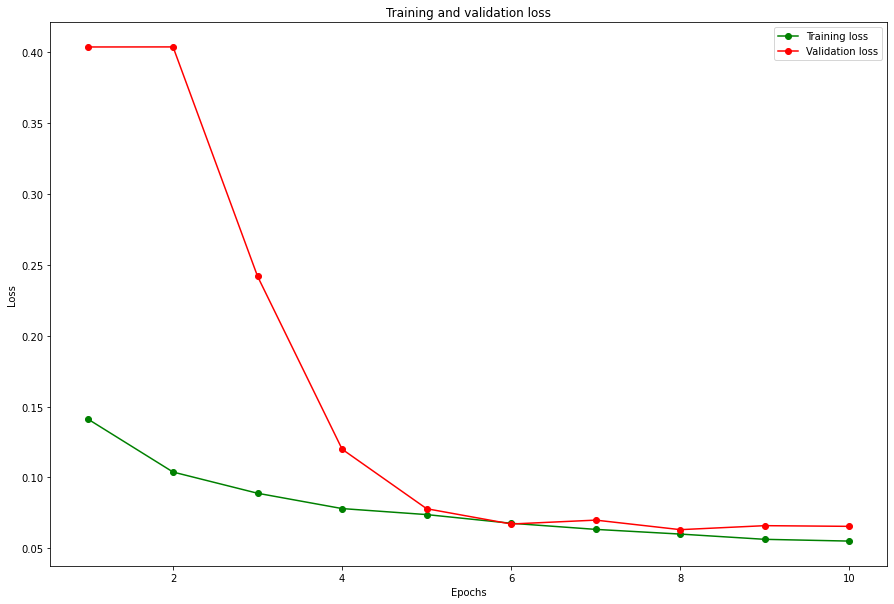

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'green', label='Training loss', marker = 'o')
plt.plot(epochs, val_loss, 'r', label='Validation loss', marker = 'o')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('loss_graph.png')
plt.show()

In [31]:
acc = history.history['one_hot_io_u']
val_acc = history.history['val_one_hot_io_u']

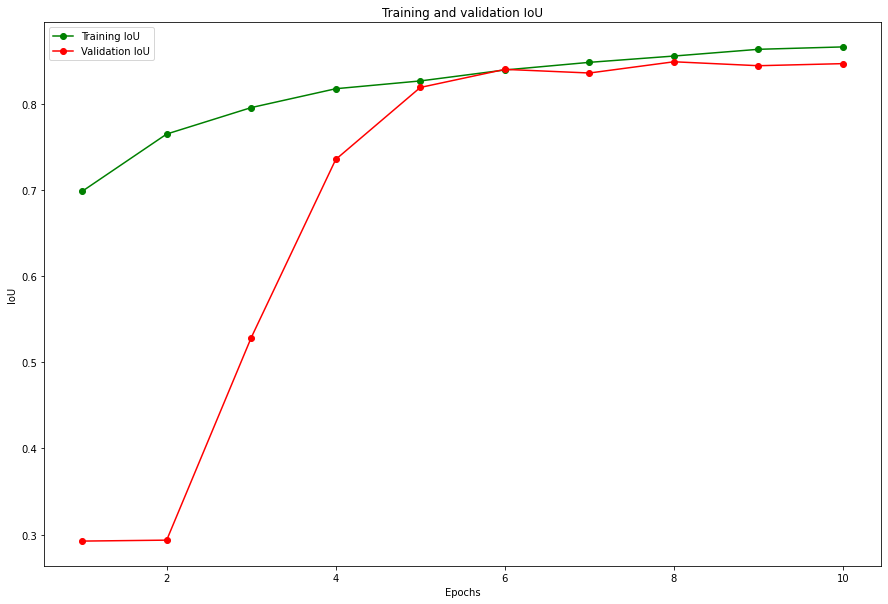

In [32]:
plt.figure(figsize=(15,10))
plt.plot(epochs, acc, 'green', label='Training IoU', marker = 'o')
plt.plot(epochs, val_acc, 'r', label='Validation IoU', marker = 'o')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
# plt.savefig('auccuracy_graph.png')
plt.show()

In [33]:
from keras.models import load_model

model = load_model(filepath, compile=False)

In [34]:
from tensorflow.keras.metrics import MeanIoU

In [35]:
test_image_batch, test_mask_batch = next(iter(valid_dataset))

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 2s 2s/step


Mean IoU =

0.879184

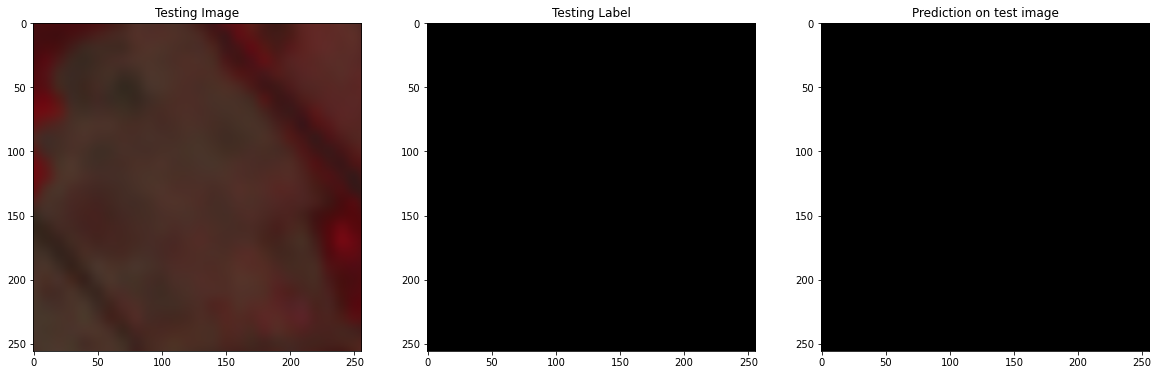

In [36]:
img_num = random.randint(0, test_image_batch.shape[0]-1)
image = test_image_batch[img_num]
plt.figure(figsize=(20,20))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(image[:,:,0:3])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num], cmap='gray')
plt.show()

In [37]:
No_of_valid_data = int(number_of_shards*filespershard*0.3)

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

In [39]:
test_image_batch, test_mask_batch = next(iter(valid_dataset.unbatch().batch(No_of_valid_data)))
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

 1/71 [..............................] - ETA: 1:02

 3/71 [>.............................] - ETA: 2s  

 4/71 [>.............................] - ETA: 3s

 5/71 [=>............................] - ETA: 3s

 6/71 [=>............................] - ETA: 3s

 7/71 [=>............................] - ETA: 3s

 8/71 [==>...........................] - ETA: 3s

 9/71 [==>...........................] - ETA: 3s

10/71 [===>..........................] - ETA: 3s

11/71 [===>..........................] - ETA: 3s

12/71 [====>.........................] - ETA: 3s

13/71 [====>.........................] - ETA: 3s

14/71 [====>.........................] - ETA: 3s

15/71 [=====>........................] - ETA: 3s

16/71 [=====>........................] - ETA: 3s

17/71 [======>.......................] - ETA: 3s

18/71 [======>.......................] - ETA: 3s

19/71 [=======>......................] - ETA: 3s

20/71 [=======>......................] - ETA: 3s

21/71 [=======>......................] - ETA: 3s

22/71 [========>.....................] - ETA: 3s

23/71 [========>.....................] - ETA: 2s

24/71 [=========>....................] - ETA: 2s

25/71 [=========>....................] - ETA: 2s

26/71 [=========>....................] - ETA: 2s

27/71 [==========>...................] - ETA: 2s

28/71 [==========>...................] - ETA: 2s

29/71 [===========>..................] - ETA: 2s

30/71 [===========>..................] - ETA: 2s

31/71 [============>.................] - ETA: 2s

32/71 [============>.................] - ETA: 2s

33/71 [============>.................] - ETA: 2s

34/71 [=============>................] - ETA: 2s

35/71 [=============>................] - ETA: 2s

36/71 [==============>...............] - ETA: 2s

37/71 [==============>...............] - ETA: 2s

38/71 [===============>..............] - ETA: 2s

39/71 [===============>..............] - ETA: 2s

40/71 [===============>..............] - ETA: 1s

41/71 [================>.............] - ETA: 1s

42/71 [================>.............] - ETA: 1s

43/71 [=================>............] - ETA: 1s

44/71 [=================>............] - ETA: 1s

45/71 [==================>...........] - ETA: 1s

46/71 [==================>...........] - ETA: 1s

47/71 [==================>...........] - ETA: 1s

48/71 [===================>..........] - ETA: 1s

49/71 [===================>..........] - ETA: 1s

50/71 [====================>.........] - ETA: 1s

51/71 [====================>.........] - ETA: 1s

52/71 [====================>.........] - ETA: 1s

53/71 [=====================>........] - ETA: 1s

54/71 [=====================>........] - ETA: 1s

55/71 [======================>.......] - ETA: 1s

56/71 [======================>.......] - ETA: 0s

57/71 [=======================>......] - ETA: 0s

58/71 [=======================>......] - ETA: 0s

59/71 [=======================>......] - ETA: 0s

60/71 [========================>.....] - ETA: 0s

61/71 [========================>.....] - ETA: 0s

62/71 [=========================>....] - ETA: 0s

63/71 [=========================>....] - ETA: 0s

64/71 [==========================>...] - ETA: 0s

65/71 [==========================>...] - ETA: 0s

66/71 [==========================>...] - ETA: 0s

67/71 [===========================>..] - ETA: 0s

68/71 [===========================>..] - ETA: 0s

69/71 [============================>.] - ETA: 0s

70/71 [============================>.] - ETA: 0s

71/71 [==============================] - ETA: 0s

71/71 [==============================] - 6s 70ms/step


In [40]:
cm = confusion_matrix(test_mask_batch_argmax.flatten(),test_pred_batch_argmax.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non_ponds','ponds'])

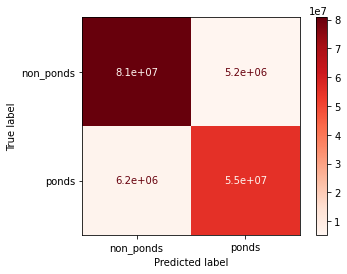

In [41]:
disp.plot(cmap=plt.cm.Reds)
plt.savefig('confusion_matrix.png')
plt.show()